### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [44]:
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
2.3.1
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### Create random genomes as toy data 

In [46]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               repeatPatterns,
                               mutationProb=0.1, verbose=True)

Pattern AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA translates to  ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACCGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAGGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACAGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGA and inserted in genome 0 contig 0 at position 479
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACCGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAGGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACAGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGA and inserted in genome 0 contig 0 at position 7230
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACCGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCT

In [47]:
if insertPatterns is not None:
    desiredPatternAA = []
    for pattern in insertPatterns:
        desiredPatternAA.extend(su.six_frame_translation(pattern))
    
    print("Desired:", desiredPatternAA)
    
if repeatPatterns is not None:
    repeatPatternAA = []
    for pattern in repeatPatterns:
        repeatPatternAA.extend(su.six_frame_translation(pattern))

    print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [48]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  186368.0 *
C 0.0293
K 0.0360
E 0.0397
W 0.0131
T 0.0604
G 0.0571
Y 0.0293
A 0.0617
I 0.0402
N 0.0312
V 0.0604
H 0.0265
S 0.1020
D 0.0268
F 0.0405
M 0.0133
R 0.0906
L 0.1000
P 0.0570
Q 0.0359
* 0.0490
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 169 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [49]:
len(genomes[0])

1

In [50]:
# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [51]:
genomes[0][0][0:100]

'CTAAGGTCCAGCTCCCTACCTTGAGTCTCGCTGTATTTTGACAACATTTTCCCATCCCTGGGGTTCGTGCGCAACTAACTCTACATCGCTTCCCTCGCGG'

six frame translation in batch mode:

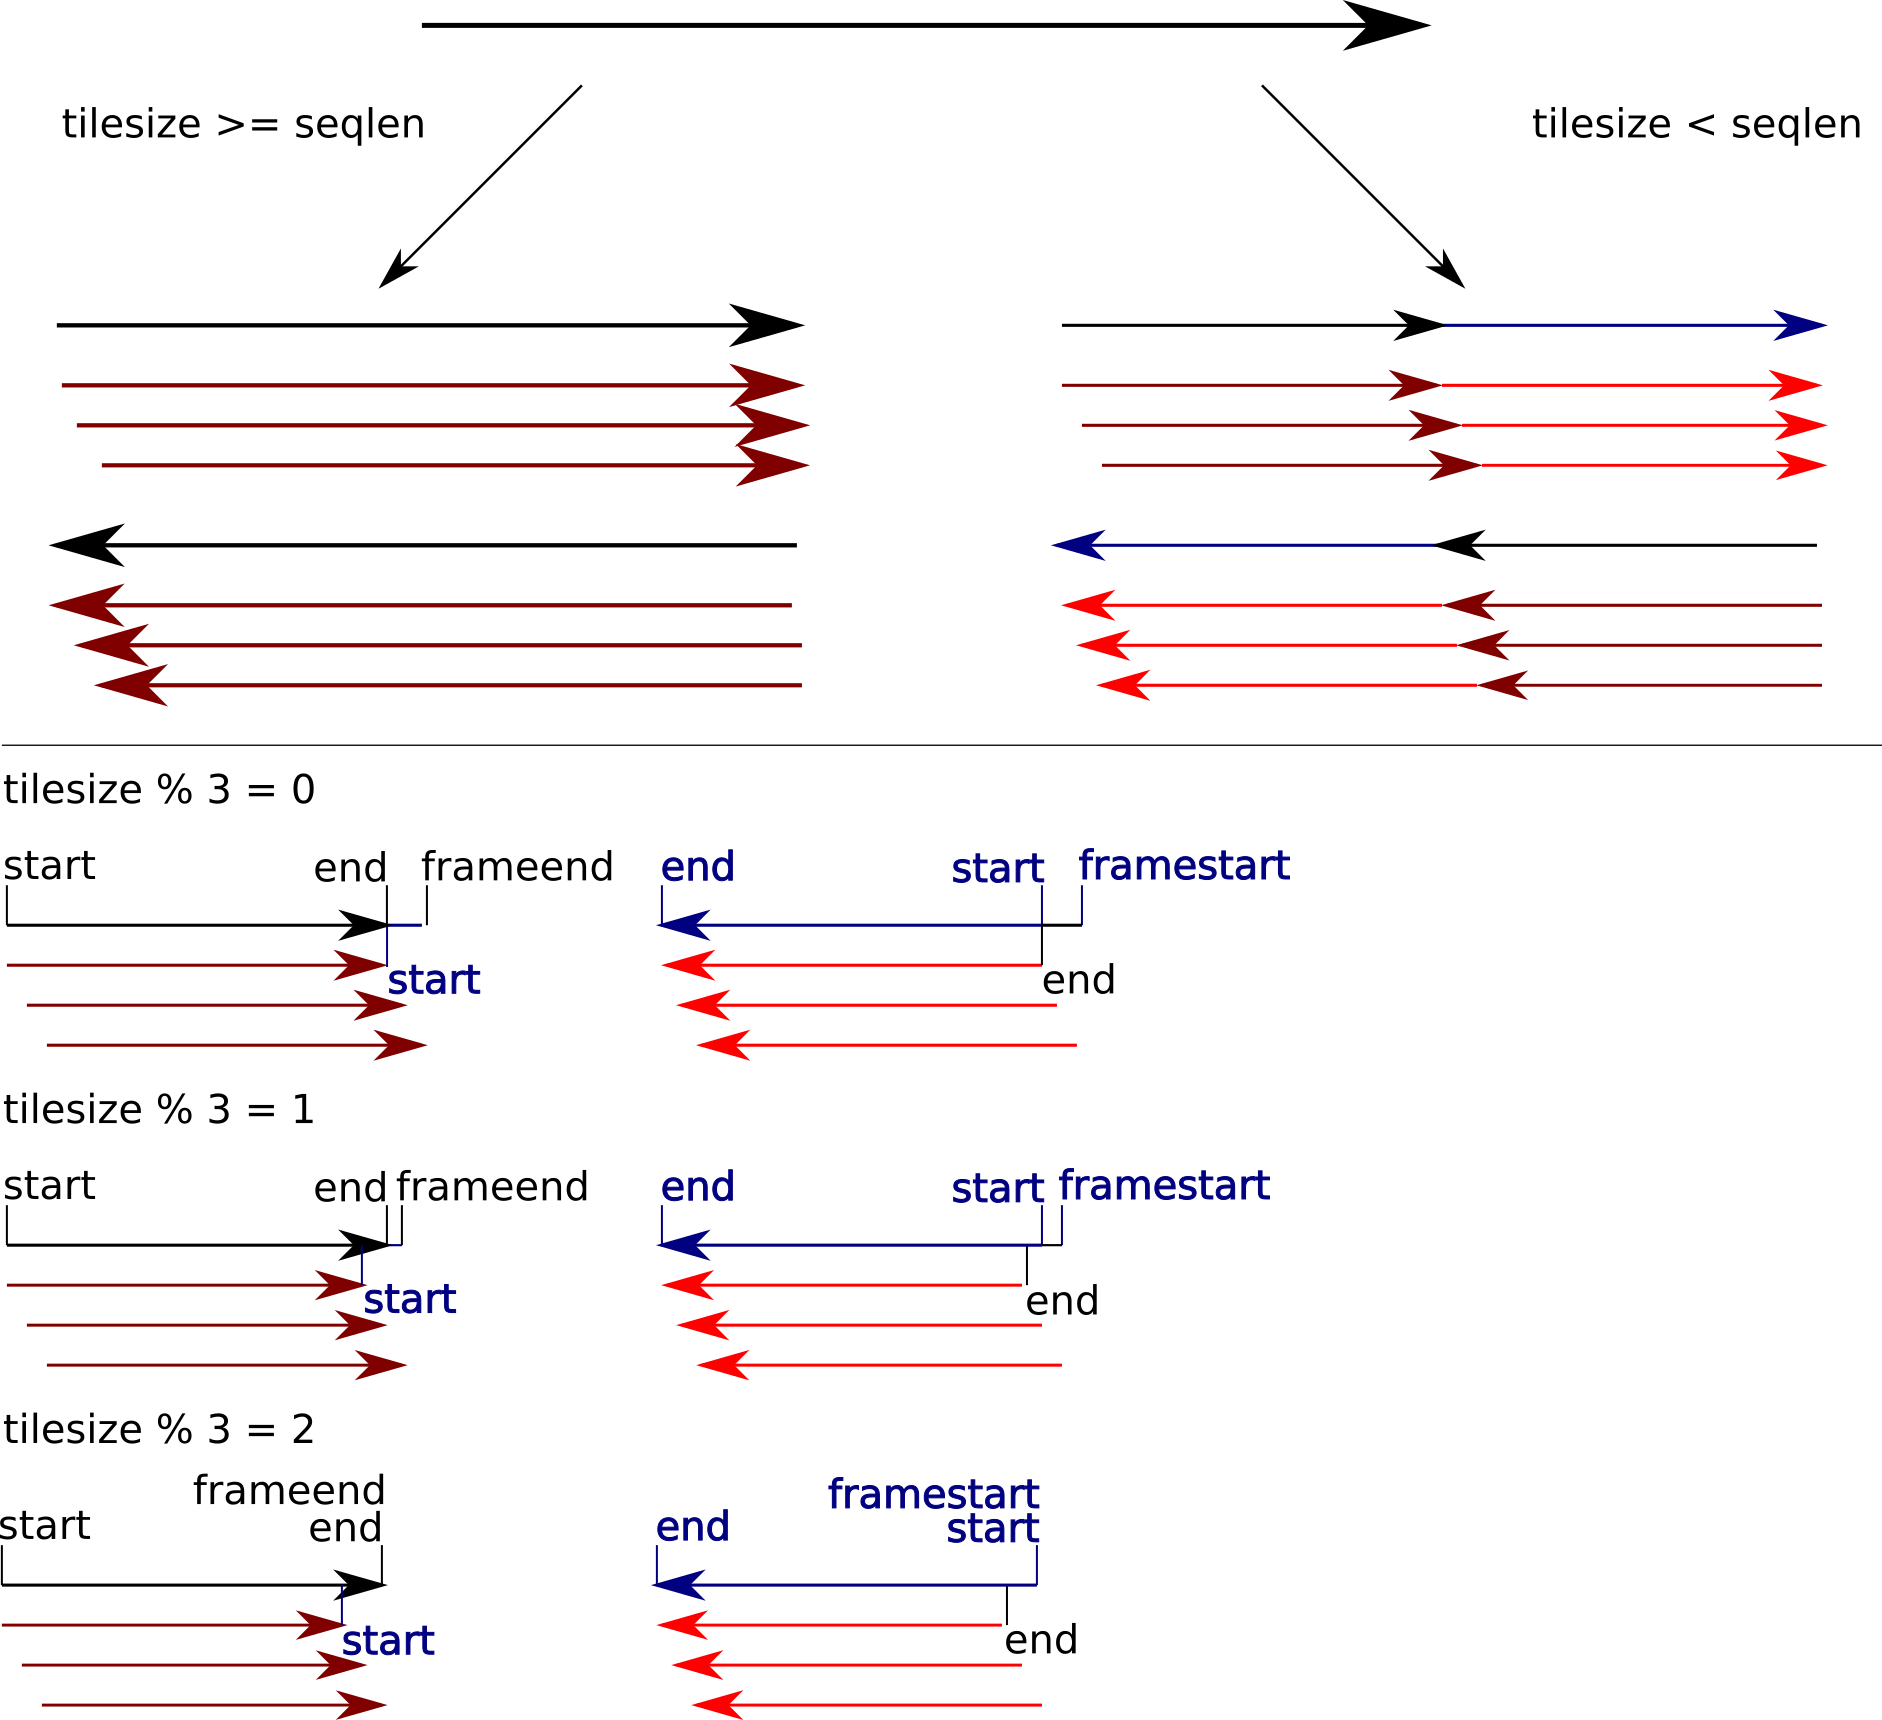

In [52]:
# manually handle reverse complements, assume that len(S) = x*3 + 2
def three_frame_translation(S):
    assert len(S) % 3 == 2, str(len(S))+" % 3 = "+str(len(S)%3)+"\n\n'"+str(S)+"'"
    T = []
    for f in range(3): # frame
        prot = ""
        for i in range(f, len(S)-3+1, 3):
            codon = S[i:i+3]
            if codon not in su.genetic_code: # real sequences may contain N's or softmasking or ambiguous bases
                prot += ' '                  # use null aa in that case
            else:
                prot += su.genetic_code[codon]
        T.append(prot)
    return T

def translateSequences(fwdSeq, pre_rcSeq, startPadding: bool, tile_size):
    rcSeq = pre_rcSeq[::-1].translate(su.rctbl)
    if startPadding:
        rcSeq += '  ' # add padding 

    # add padding to assure the right length for translation
    assert len(fwdSeq) <= tile_size+2, str(len(fwdSeq))
    assert len(rcSeq) <= tile_size+2, str(len(rcSeq))
    fwd_diff = (tile_size+2) - len(fwdSeq)
    rc_diff = (tile_size+2) - len(rcSeq)
    if fwd_diff > 0:
        fwdSeq += ' '*fwd_diff
    if rc_diff > 0:
        rcSeq = ' '*rc_diff + rcSeq

    assert len(fwdSeq) == tile_size+2, str(len(fwdSeq))
    assert len(rcSeq) == tile_size+2, str(len(rcSeq))

    # some nucleotides are part of both neighboring tiles
    aa_seqs_fwd = three_frame_translation(fwdSeq)
    aa_seqs_rc  = three_frame_translation(rcSeq)
    aa_seqs_fwd.extend(aa_seqs_rc)
    return aa_seqs_fwd

# try using a generator to get genome batches
#def createBatch(genomes, ntiles, aa_tile_size: int):
def createBatch(ntiles, aa_tile_size: int, genomes = genomes):
    assert aa_tile_size >= 1, "aa_tile_size must be positive, non-zero (is: "+str(aa_tile_size)+")"
    tile_size = aa_tile_size * 3 # tile_size % 3 always 0
    N = len(genomes)
    state = [{'idx': 0, 'pos': 0, 'exhausted': (len(seqs) == 0)} for seqs in genomes]
    while not all(s['exhausted'] for s in state):
        X = np.zeros([ntiles, N, 6, aa_tile_size, su.aa_alphabet_size], dtype=np.float32)
        I = np.eye(su.aa_alphabet_size + 1) # for numpy-style one-hot encoding
        for t in range(ntiles):
            for i in range(N):
                if state[i]['exhausted']:
                    continue
                    
                sidx = state[i]['idx']
                slen = len(genomes[i][sidx])
                
                start = state[i]['pos']
                end = min(slen, start+tile_size)
                framestart = max(0, start-2)
                frameend = min(slen, end+2)
                assert start < end
                assert framestart < end
                
                # update state
                state[i]['pos'] = end
                if end == slen:
                    state[i]['idx'] += 1
                    state[i]['pos'] = 0
                    
                if state[i]['idx'] == len(genomes[i]):
                    state[i]['exhausted'] = True
                                
                # translate and add tiles
                sequence = genomes[i][sidx]
                if type(sequence) is not str:
                    sequence = str(sequence) # with tf, input are byte-strings and need to be converted back
                    
                aa_seqs = translateSequences(sequence[start:frameend], 
                                             sequence[framestart:end],
                                             (start ==0), tile_size)
                for frame in range(6):
                    aa_seq = aa_seqs[frame]
                    assert len(aa_seq) == aa_tile_size, str(len(aa_seq))+" != "+str(aa_tile_size)+", start, end, frameend, slen, tile, genome, frame: "+str((start, end, frameend, slen, t, i, frame))                        
                    x = su.to_idx(aa_seq, su.aa_idx)
                    num_aa = x.shape[0]
                    if (num_aa > 0):
                        one_hot = I[x] # here still aa_alphabet_size + 1 entries
                        # missing sequence will be represented by an all-zero vector
                        one_hot = one_hot[:,1:] 
                        X[t,i,frame,0:num_aa,:] = one_hot
                        
        yield X

---

_**Test Batch Generator**_

Retranslate and assemble all batches, compare to translations of genome sequences

_So far, fails for seedFinding data, no idea why_

In [53]:
# limit test to subset of sequences for large genomes
if max([sum([len(s) for s in genome]) for genome in genomes]) > 100000:
    testgenome = [[]]*len(genomes)
    while max([sum([len(s) for s in genome]) for genome in testgenome]) <= 100000:
        i = 0
        for g in range(len(genomes)):
            if i < len(genomes[g]):
                testgenome[g].append(genomes[g][i])
                
        i += 1
else:
    testgenome = [[s for s in genome] for genome in genomes]
    
# translate and concatenate whole testgenome aa sequences
genome_aa = [[""]*6 for _ in range(len(testgenome))]
for g in range(len(testgenome)):
    for i in range(len(testgenome[g])):
        aa_seqs = su.six_frame_translation(testgenome[g][i])
        for f in range(len(aa_seqs)):
            genome_aa[g][f] += aa_seqs[f].replace(' ', '')#.lstrip().rstrip()

# prepare generator testing
rev_aa_idx = dict((i,c) for i,c in enumerate(su.aa_alphabet))

def to_aa(onehot):
    assert onehot.shape[1] == 21, str(onehot.shape)
    aa_seq = ""
    for c in range(onehot.shape[0]):
        if np.max(onehot[c,:]) != 1:
            continue
        else:
            aa_idx = np.argmax(onehot[c,:])
            assert onehot[c, aa_idx] == 1, str(onehot[c,:])+", "+str(aa_idx)+", "+str(onehot[c,aa_idx])
            aa_idx += 1 # argmax + 1 as in translation, empty aa is cut out
            aa_seq += rev_aa_idx[aa_idx]
        
    return aa_seq#.lstrip().rstrip()

X_to_genome_aa = [[""]*6 for _ in range(len(testgenome))] # for each genome and each frame, concatenate translated aa seqs

# create generator
#Xgen = createBatch(testgenome, 5, tile_size)
Xgen = createBatch(5, tile_size, testgenome)

# iterate through generator, transforming and concatenating aa sequences
# X.shape [ntiles, N, 6, tile_size, su.aa_alphabet_size]
for X in tqdm(Xgen):
    for t in range(X.shape[0]):
        for g in range(X.shape[1]):
            for f in range(X.shape[2]):
                x_aa_seq = to_aa(X[t,g,f,:,:])
                if f < 3:
                    X_to_genome_aa[g][f] += x_aa_seq
                else:
                    #fr = 5 if f == 3 else f-1 # for some reason, frames rotate in generator compared to direct translation
                    #X_to_genome_aa[g][fr] = x_aa_seq + X_to_genome_aa[g][fr]
                    X_to_genome_aa[g][f] = x_aa_seq + X_to_genome_aa[g][f]
            
# compare aa sequences
assert np.all(genome_aa == X_to_genome_aa), str(genome_aa)+"\n\n!=\n\n"+str(X_to_genome_aa)

3it [00:03,  1.32s/it]


AssertionError: [['LRSSSLP*VSLYFDNIFPSLGFVRN*LYIASLAVTNYQGSWVRVPLKTRKE*ALGLPTMR**QSVQLLSIIILRSAQSCDHVAQWICSTS*VMSFYR*RIAELKTANLEVSVLCIILSPQEFTTRHSEISCVQPCV*TVSVMNDDGAEKSIVWGGLHESTENLKLLLNLKEENLKLLLNLKEENQRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KMKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDAYTVAH*HFFDDAFR*CVNIECWRSSFAKYHGLAKGVSGVK*GLVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPRDNLLGSKPYQRFRQDLWGSYQEWGSSHGQIWQQHAVPTLGT**QPISTRQPCANPH*EVHSLRSIESHTFTVSVAALWPT*RMHT*GHCCYGQEMARS**SARKSRFNIAYNLTVDGLYRASDYHDSRGMTGHCRR*SNFFS*SVAMWLHVDGDSSLAGDTCSSRFHFTRRTGPRAAIFLPWTRI*CLPDKDGVSSNTGKV*VDRGGSCKYVSSRASVHVLSDLLITRFQSISANYALRFWQRKPRVAAPMLTSVLQDNKPSVSRYTVRTRLRSIDQCIRFEGTVLERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSQRVLTSTVLNGVDMPASPCWAKIFDSTLTSLQPKVPACSYQNS**WILPLWHGVKHKVSECCQKPIITSACEFRSAVRNR*YLFDRYYKPTGLRLLWFQHESEILLVTSLNSIPFWKEHPSS*TWPSARKRYAMFRLGTVVRQMDVLNGKTRDHVLGDRELCTLTGIKMLRRLLHSLEESPGLKPTSRNTRPLRCPSVPVGKWMVY*RTGTELRLQIAI*SLGRLSRACLFVNNSELGTSNPVQVRISEVPDL*GTNI*ASLQPTDRLMCRWGW*D***YCSFE*C*IGSPRGFTNAFFWKAGAPPMPPDTAGWLMPFEAALVPRLPGANYT*VLMWPRSVYMTLEHPLCTS*RSRLLIHLCSAVPVRNNTTASDLTSIRMLG*KRRIKLQDV**EN*LSRSTHYNATSISPLRRVYTTLSPRAVRGNLTFKPDISPDVHLIRCLWGGLRGDSRTFR*KII*RKVGRSVYPARDRHEASRET*AACAGARIPKFPRKLKDSAFVSS*HDYSAGFSFG*LQTFCELIDGRQGPTLPASQC**IVLLEVNEHPRGVYGVI*DSGPYQVKPANLLL*PIFIVPRKALVGA*CVGDSSLMLKAFVVPHPHRQATGSTRIGPLPSDDVVF*ASLYRICLSDWNYAHMSSCVTGSPVNSDGHSAVRQTDPEGYRIDSHQLPETSAITNP*ALQSLGVVASENVLCSDTPMVVPAR*LDCLLFL*ESRVRLIPRTKAGG**KEVHNSSSYFKGALQSEQIKRTAGRLASRSALQGAVCLKSILFA*SL*EMLHLLAVPYRLNLRCKVIISHLGGIAQGED*PLWSGGPACTSTTLLCLGMTSEIRKGVVGSF*KDPATLCDC*ETFGTSALTTPQG*GTVVRDPKLLLSTFLIVASSLQVQLVCKSCLDPRYGGDISTLIAACQNG*PFDPMHLSCIFIRIRGCVIQTGFISQGS*KRVLRRTYSPYTWTAWGVSHLLQSLISIVYAALSRNAFLRVQSCGLSSSVRCDEAFLVKTASLQIQVRWPEFNLLQKKKRSQNSSPT*TQTPLAVDMSQGRACPSVPHPISTRYLRMYILRASLLL*TAYPRL*QRLPP*SKS*N*IDISTSHHISAP*RSQRLPAV*FAICRWPCRILST*VGGTRAVSQPRATSPALDERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIGP*RCKSLC*LKQGF*SFITAVVVLLGKDGCRYGMGPLKSVGLLTLFRQFVSDSIVTCRSEATTNTPLMFKSMFKDVTLRLVHPSISERSHPRTWLV*R*DESPSSGVR*VHRPRYVGKHKRTAQLVYLPPCQTDQESSTTTRPLFGREESASHVKGQTCVSLTRNIYKNSANKDENPAR*HTTVV*RDSVSDSGKLIFPTPY*LYY*ITFTRGVRKGEIFFSTAPFWRRKEPEPGFLK*PAQC*LSPPTASPTSYTTQAELLVRIAEGNAKQIFVSLAP*PHWPIDLDCRRSQH*RAFAVGTLNSTHTSCAASNMDAHKSTALNPVSYALIV*AASLPYGPRA*FAHKKRAYEGSIWSSRCIHSQSVAHSSLIHTVTGSCAGNHYS*SMYTQKLLGANFVVVFVPLLCAYTVGYLHIFIRMPHRVEFNRGRFFPTCSVGYRSACLTCLLS*PLMQVGISPQAVLVILPNVRDSSANLFTVPRTSDRALI*NRCVDINPLDSHN*ANKWATTVQARHLLIGWSCMGKPSPYPLFLRIRYTWKILAPVADSGEGPVVIAQNGLAVFQA*KNAEHGSQVDGKMLRHLDGSGY*LLTATEAQNGSRVKLKGL*MQDIYCASLGESVPSIRENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEATAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREFVVLLTCGTRFNSN*YLAGSIL*RSCPHAEHRPGRR*GRRYIAAGLHLRGYEYARWEINCCRQLIRDASTDTQHYATVAVNNTIKLPSRTTQDSSRVNIFIGAPQSRVLDWRSHH*PYPWMLFADGTRANSYQCRYPLETWFRVVGRSHG*CRLWQLTRHCALIVVY*SCCRAWKHL*FGRGGCIMRALHLYPMCLSR*IVLGERIILKRSLEGRQTIVQRVLYRGGGGCVNRGRSWQRQSVKNSPYRVIQVVL*SNRGVLFAVSLRRAPMAVM*GSPRGHLF*LRCAVCSLEGRHSIESLRRAVCYATELTAIGVVSGKRL*Q*QGKLVSRRTGDVEELWRLWHCMVLTHVFLGLLK*GILRLVPELRLKAFRG*AHCRDSPG*AARVDNERRDCVAVTVLS*LRREPGTPGWNLMG*PRGNVVGTQTSSVQALRPSSSRNQGNSNQVGPSVYAALVQYTKTWSTLPMHLSHQ*V*KSA*N*LCGYKCKTTRHLQSCECRPI*VPNEDYMVYNCKIRLQFTNDYEKLEQRTLQI*RSHVRSLSCAERSLT*NHIGPLPIWQRSSLDLFDALERPQRSGTS*WTWAVNHAGSDAASEH*VCYA*RRGFLN*CPVRVSNAGPSCHLARCPRIISGFKKGSTDTRPTANGKITSDLCDLACDPHGRVHSIFKPCHGF*T*GCVAEFTT*SSRHCIL*RV*NQVH*VDIELSHVICEGITCLEG*ANVLRT*SPPQIHIGIFSAYRVPAIALQIGTVTTCPSCVPLYVNIGAWGD*RLTSRQAASSLL*TDLPRPA*VGGPRQSRMLMLLQRRRQLSLDQTNVSIYKRQVCVYM*RVVR*ARVTQWQKGACTWYIVQESLVRGTDNLLI*RVVHWFIP*RN*SGFPL*TAKTPHLLHFSVLSVRPGKCSNYCLGAMDGVPPGNGVPNQLYRSRNTPLRRLQASVFNELSDSIGGFRIAGCVVGNDSQDLKT*VCVGP*LGTRWMLYSSLLSAVSFSR**LDE', '*GPAPYLESRCILTTFSHPWGSCATNSTSLPSRLRTIKGVG*ECH*RPGKNRL*ASPLCDSNSPSSF*ALLS*EVRRVAIT*HSGYALLVKL*VFTADVLRS*RPPI*RFRSSVLFLAPKNSLRGTRRYLACSLAFKRSQ**MTMVQKRASFGEVCTKAQRT*SYC*T*KKRT*SYC*T*KKRTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPER*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KMPTL*RINIFLTTHLDDA*TLNAGVLALPNTMA*RKACPGSNKAL*ENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPEITSSVQNLTSALGRIYGAATKSGVRRMVRYGSSMLYRLLERDDSQFQQDNRALIRTEKYIPSGLLSPIHLLFRSRHYGPHSGCIHRDTVVMVRKWRAVSRVPESQGST*RIT*RSTGYTERLTITTAEG*LATVEGKVISFRNL*LCGCT*TATAHWLVTPVRHVSTSPAVRDHVQQSFYHGPVSNVCLIKTVSHQTRGKFKSTGAVLVSTSLVGHRYMCCPTSS*QGSNQFQPTMPCGSGNANQGWPPQCLPRFSRTTNPLYLDILSEPG*GR*TSVSGLRGRF*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVKEF*RVPY*MGLTCQHPLAGRRSLTRPSLPYNPKFRLVVIRIRSSGSYRYGMELNTKSASAAKSL*SHQRASSAQQSVTDSTCSIGIISLQDYVCFGFSMSQKSSW*LVSTRYLSGKNIQVARHGLLPGNVTLCFG*AL*YGRWTC*MGRPEIMCSAIENYVP*RASKCSVGYCTRLRNLRA*NQLVETLVHYAARPFRWGNGWYTNGRVRNFDFR*RSRAWGGYREPAYLSTIQNWVLAIPCR*EYQRFRTYEGRTSRPPFNPLTV*CVGGGGRINDSTARLSDAESGLPGASRTHFSGKLERRQCHRIPLGG*CLLKQL*SHVSLALITRKC*CGHDPYT*H*NILCVQARDRDY*STCAPLSLYGITQPLRT*RRYACWVRKGESSCKTSDERINSAAARITTLHRYHRYDGCIQRYHLEQSVETSPLNQTLALMFT*SVVYGVV*GAIPEPFGERLFSVR*AAAYIQQEIGMRRQERHRQPVQAHEYLNSHAS*KTVPSSPLNTTTARVFLSASSKRFAN*LTVGRALRFRPVSVSKLCC*KLMNIRVAYME*FEILARTK*SPQIYYFSLFSLYPAKPWWELNASGIRV*C*RHLSSRILIDKPRVLLGSAHFLRTTSYSRLRCTGSAYRTGTMRI*VHVSLVRLSTVTDTVRSGRRIQKGTALIRINYPKLLLSLIRKPYNRWGW*RQRMCCVVIHRWSYLPDDSIASCFCRKVGYALFHALKQEDNRKKFIIVPVTSKGLYNQNR*NGQRDVLRPALLCRALSA*KVFYLLKACKRCSIC*PSHTG*I*GARL*SHIWAALRKGKISPYGVAAQRALPPLCYAWA*LVK*EKEL*ARSEKTRRRYATVEKLLAPQH*LPRRDEAP*CATRNYS*VRSL*WRLHCRYNWYVNPASILDTEETYLR**RPAKMASPSIPCIFHAFLSGSEVVLFKQVSSLKEVKKECSDGLTRRTHGQLGAFPTFSSL*FRSYMLLSPVMRFFGSSHAA*AQVCVVMRHSLLRRPVYRSRFDGQNSIYCKKRSGAKIVHQHRPKHR*PSI*VKAGHARAFHILSLLDTSECIFFGRVCCYERHIPVFNSAFRRDLSLETESTSQRHITSAHLDAHRDCLQSDSPFVVGRVESYLRRSAERELFRNLEPQALRWMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLVPSAVKVYAS*NRGSKVSSQPW*SYWARMVVGMEWAP*KALAS*LCLDNLYLIALSPVVQRPQLTLRSCLSPCLKM*R*D*YTRLLARGAIHVLG*FDDRMKALAPGYDKFIDQDMSVNIRGPLN*FIFLRAKRTRSLLPRQDRFSDERRALPTLKDRRVYH*PGIFTKTRLIRTRTRRGNIQRWFNETR*AIAEN*YSQHRINCTTKLPLREE*ERGRSFFLLPPFGGERNQSQGF*SNLPNASCLRPQRARQVTPPKQSYS*E*QRETRSKSLLV*PLSPTGQ*T*TAEDPSTDERSPLGPLTLPIHHVLRVIWMPTRAQPLTLCRML*LYEQLPYRMAREHNSPTRNAHMKAQSGAAGVYTRNQSPTAA*YIP*PGRVPAIITPRVCTLRNFWEQTLWWYSSHSYVRIQWDTSTFLLECPTEWSLIEADSFLPAR*GIGLPALPVSCHNHLCR*ESRHKPC*LFSRMYETVQQTSLRYHGHLIEH*YKIDV*T*TLWIRTTRQINGLRLSRRATC*LDGLVWVSQVLTPYSYVSVTRGRYLLRLQTREKGQLSSHKTGSRFSKPKKTPSMVVKSTGRCFGTWTVVAISY*QLLKHRTALE*N*RGFECRTFIVPASGSQCRPFERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLLLENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKENLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESLWFF*PVAPVLIVTDIWPAAFYDAHVLTRNIGPAGAEAGDTLRLVYTSGDTNTLGGK*IVVGN*SAMHQLIRSITRRSL*IIPLSYPAEQPKTHPVSTFLSEHRNLGC*IGGLITNHIRGCCSLMVLGRIATNAVIP*KLGSGWLGGAMVDAACGNSHGTVRS**STDPAAGPGSICDSDAGGVS*EHSTCILCACLAKSCWENE*S*NDPWRGVRRSCSVFCIAGGVVA*IVGEAGNDSR*KTPLIG*SR*SFNQTVGYFLLCLSVVPQWLSCRGHLGGICFSYDALCAV*KADIVSNP*GAPYAMPRS*PQ*ALFPGKDYSNNRENWSVDAPET*KNYGGYGTVWS*PTFSSAF*SEEFCV*FRN*DLKPFADRHTVATHLDRRHALIMKEGTVSR*RSCRSYDVSLVHLAGI*WDDRGGMWWEPKHRASRHSGHLAVGIREIQTRWGRACTRRSSSIRKHGPRYLCTSRTSKFESLPEISYAVTSARRRDICNRVSAVQSRFPTRITWCTIVRYVYNSQMITKN*SSGPYRYSGHM*GP*AARNDL*RETT*GLCPYGSAVHWTSSMLSSGHSVLELLSGHGP*TTPARMQHLNIKFATLDDGVS*INVPCASQTPGPLVIWPGVRESYQGSKRGRPTLDLQQMEKSRPTCATLRVIHTVEFTLYSNRATDFERKAALLSLPPSHLDTVFCNAFRIRSIK*TSNCPTLYVRASPAWRAEPTFSAHSPLLRSILEYSRHIESLLSHSRSVPSRHAPLAYLYT*T*VLGVTKG*HHARLHHHSSRPTYLGPLELVAHGRVAC*CFYNEDGNSA*IKRTYPFTKDRCASICRGWLGRPELRSGKRVRVRGI*SRSP*SEAPTTCSFRGWYIGSYLSVTRVVFRYELPKRRIYYTLASSL*DQENVATTV*GRWTGCPLAMGYPTNFIEAGTLPYAVCRHLCLTNCQTQLGDSA*RDVLLGTIVRT*RPECALVHSSAPDGCFIRVFFRLSHLVDNDLTN', 'KVQLPTLSLAVF*QHFPIPGVRAQLTLHRFPRGYELSRELGKSAIEDQERIGFRPPHYAIVTVRPASKHYYLKKCAELRSRSTVDMLY*LSYEFLPLTYCGVKDRQFRGFGPLYYS*PPRIHYEALGDILRAALRLNGLSNE*RWCRKEHRLGRFARKHREPEATAEPERREPEATAEPERREPENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERCLHCSALTFF*RRI*MMREH*MLAF*LCQIPWLSERRVRGQIRPCERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTQR*PPRFKTLPAL*AGSMGQLPRVGFVAWSDMAAACCTDSWNVMTANFNKTTVR*SALRSTFPPVY*VPYIYCFGRGTMAHIADAYIGTLLLWSGNGAQLVECPKVKVQHSV*LDGRRAIQSV*LSRQQRDDWPL*KVK*FLFVICSYVAARRRRQLTGW*HLFVTFPLHPPYGTTCSNLFTMDPYLMSA**RRCLIKHGESLSRPGRFL*VRL**GIGTCAVRPPHNKVPINFSQLCPAVLATQTKGGRPNAYLGSPGQQTLCISIYCPNQAKVDRPVYQV*GDGFRENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESKSFDEYRIEWG*HASIPLLGEDL*LDPHFLTTQSSGL*LSEFVVVDLTVMAWS*TQSQRVLPKAYNHISVRVPLSSP*PIVLVR*VL*AYRTTFALVSA*VRNPLGD*SQLDTFLERTSK*LDMAFCQETLRYVSVRHCSTADGRAKWEDQRSCARR*RTMYLDGHQNAPSATALA*GISGLETN**KHSSTTLPVRSGGEMDGILTDGYGTSTSDSDLEPGAAIASLLICQQFRIGY*QSRAGKNIRGSGPMRDEHLGLPSTH*PSDVSVGVVGLMIVLLV*VMLNRVSPGLHERIFLESWSAANATGYRWVADAF*SSSSPTSPWR*LHVSADVATIRIHDIRTSFVYKLEIATTDPLVLRCPCTE*HNRFGPDVDTHVGLEKENQAARRLMRELTQPQHALQRYIDITATTGVYNAITSSSPWKPHL*TRH*P*CSPNPLSMGWSEGRFQNLSVKDYLA*GRPQRISSKRSA*GVKRDIGSLCRRTNT*IPTQVKRQCLRLLLTRLQRGFFFRLAPNVLRIN*R*AGPYASGQSVLVNCVVRS**TSAWRIWSDLRFWPVPSKARKSITLAYFHCTPQSLGGSLMRRGFEFNVKGICRPASS*TSHGFY*DRPTSFGRRRILGFAVPDLLIGLELCAYEFMCHWFACQQ*RTQCGQADGSRRVPH*FASTTRNFCYH*SVSLTIAGGGSVRECVV**YTDGRTCQMTRLPLVSVGK*GTPYSTH*SRRIIERSS**FQLLQRGFTIRTDKTDSGTSCVPLCSAGRCLLEKYSICLKLVRDAPSVSRPIQVKFEVQGYNLTSGRHCARGRLAPMEWRPSVHFHHSAMPGHD**NKKRSCRLVLKRPGDAMRLLRNFWHLSTDYPAGMRHRSARPETTLEYVPYSGVFIAGTTGM*ILPRSSIRRRHIYADSGLPKWLALRSHASFMHFYQDPRLCYSNRFHLSRKLKKSAPTDLLAVHMDSLGRFPPSPVSNFDRICCSLP*CVSSGPVMRLELKCAL**GIPC*DGQSTDPGSMARIQSTAKKEAEPK*FTNIDPNTVSRRYESRPGMPERSTSYLY*IPQNVYSSGEFVVMNGISPSLTAPSAVI*VLKLNRHLNVTSHQRTLTLTEIACSLIRHLSLAVSNLIYVGRRNESCFAT*SHKPCVG*ENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDWSLAL*KSMLVKTGVLKFHHSRGSLTGQGWL*VWNGPLKKRWPLDSV*TICI**HCHLSFRGHN*HSAHV*VHV*RCDVETSTPVY*REEPSTYLVSLTIG*KP*LRGTISS*TKICR*T*EDRSISLSSSVPNGPGVFYHDKTAFRTRGERFPR*RTDVCITDPEYLQKLG**GREPGAVTYNGGLTRLGER*RKIDIPNTVLIVLLNYLYERSEKGGDLFFYCPLLAEKGTRARVSKVTCPMLVVSAHSEPDKLHHPSRVTRKNSRGKREANLC*FSPLAPLANRLRLQKIPALTSVRRWDP*LYPYIMCCE*YGCPQEHSP*PCVVCSNCMSSFLTVWPESIIRPQETRI*RLNLEQPVYTLAISRPQQLDTYRNRVVCRQSLLLEYVHSETSGSKLCGGIRPTPMCVYSGIPPHFY*NAPQSGV**RQILSYLLGRVSVCLPYLSLVITTYAGRNLATSRASYSPECTRQFSKPLYGTTDI**STDIKSMCRHKPSGFAQLGK*MGYDCPGAPPANWMVLYG*AKSLPPIPTYPLHVEDTCSGCRLGRRASCHRTKRARGFPSLKKRRAW*SSRREDASALGR*WLLATNSY*STERLSSKTEGALNAGHLLCQPRGVSAVHSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSYC*RT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRT*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRVCGSFDLWHPF***LIFGRQHFMTLMSSRGT*ARPALRPAIHCGWFTPQGIRIRSVGNKLLSAIDPRCIN*YAALRDGRCK*YH*ATQQNNPRLIPCQHFYRSTAI*GVRLAVSSLTISVDVVR*WY*GE*LPMPLSLRNLVQGGWEEPWLMPPVATHTALCAHSSLLILLQGLEAFVIRTRGVYHESTPLVSYVLVSLNRAGRTNNPETILGGASDDRAACSVSRGGWLRKSWEKLATTVGEKLPL*GDPGSPLIKPWGTFCCVSPSCPNGCHVGVT*GASVLATMRCVQFRRPT*YRIPEARRMLCHGADRNRRCFREKIIAITGKTGQSTHRRRRRTMAVMALYGPDPRFPRPFKVRNSAFSSGTKT*SLSRIGTLSRLTWIGGTR***KKGLCRGDGPVVVTT*AWYTWLEFNGMTEGECGGNPNIERPGTQAI*QSESGKFKPGGAERVRGARPVYENMVHVTYAPLAPVSLKVCLKLVMRLQVQDDETFAIV*VPSNLGSQRGLHGVQL*DTFTIHK*LRKTRAADLTDIAVTCEVPKLRGTISNVKPHRAFAHMAAQFTGPLRCSRAATAFWNFLVDMGRKPRRLGCSI*TLSLLRLTTGFLKLMSRARLKRRALLSFGPVSANHIRVQKGVDRH*TYSKWKNHVRPVRPCV*STRSSSLYIQTVPRILNVRLRC*VYHLVISTLYSVTRLESGPLSRHRTVPRYM*GHHLLGGLSQRSPHIVPSSDPYWNILGI*SPCYRTPDRYRHDMPLLRTFIRKHRCLG*LKADITPGCIITPLDRPT*ARLSWWPTAESHVNAFTTKTATQLRSNERIHLQKTGVRLYVEGG*VGQSYAVAKGCVYVVYSPGVPSPRHRQPAHLEGGTLVHTLA*LEWFSVMNCQNAASITL*RPLCETRKM*QLLSRGDGRGAPWQWGTQPTLSKPEHSPTPFAGICV*RTVRLNWGIPHSGMCCWER*SGPEDLSVRWSIARHPMDALFESSFGCLI**IMT*R', 'VRQVIIY*MRQPKEDSNKASIGCRAMDQRTLRSSGPDYRSQQHIPLCGIPQLSLTVR*TQMPANGVGECSGFDKVGWVPHCQGAPRPSPLDSSCYIFLVSQRGR*SVIDAAFWQFITENHSSYAKV*TNVPPSK*AGCRCLGLGTPGLYTTYTHPFATA*LWPT*PPSTYRRTPVFCKWIRSFDLS*VAVFVVKALTCDSAVGHQLKRA*VGRSRGVMMQPGVMSAFSHPKHLCLRIKVRKRGMS*RYRSGVR*QGLYMPRIFQYGSEEGTMCGERWLSPPSR*CPHI*RGTVRCLLNGPDSKRVTEYSVEMTRW*TQQRSLTFKIRGTV*I*SELDRVDHTQGRTGRT*FFHLL*V*CRSTPF*TLI*FADTGPNDKRARRLRRARDINLRNPVVKRSKLNVQMLHPSRRGLRPMSTKKFQNAVAAREHRRGPVNCAAIWAKALCGFTLEIVPRSLGTSHVTAISVRSAALVFRNHL*IVNVSYNCTPCNPRWEPRLDGTHTIANVSSSCTCNRITNFRQTFKLTGARGA*VTWTMFSYTGRAPRTRSAPPGLNFPDSDC*MA*VPGRSMFGFPPHSPSVIPLNSSQVYQAHVVTTTGPSPRHSPFFHYQRVPPIQVSRDSVPIRERL*VLVPELNAEFLTLKGRGKRGSGPYSAITAIVLLRLRCVD*PVFPVIAIIFSRKQRLLRSAPWHSIRRASGIRYYVGLLNCTQRIVAKTDAP*VTPT*QPLGHDGETQQKVPHGLIKGLPGSPYKGSFSPTVVASFSHDLRNHPPRDTEHAARSSDAPPRIVSGLFVLPARFSETST*DTSGVLS*YTPRVRITNASRPCSRISRLL*AHSAV*VATGGINHGSSQPP*TKFLRDNGIGSYSP*YHQRTTSTDMVSDETANLTP*IAVLR*KC*HGMSLGLFCWVA*WYYLQRPSRNAAYQLMHRGSIADNNLFPTERIRIP*GVNQPQCIAGLSAGRAYVPREDMSVIKCCRPNISYY*NGCHRSKEPQTLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*Q*LLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLEWTALTPRGWHNKCPAFKAPSVLLESRSVLQ*LLVANSHYRPSAEASSRRLDYHARRFFRLGKPRARFVR*QLALLPSLQPEQVSSTCNGYVGIGGKDLAYPYKTIQLAGGAPGQS*PIYLPSCANPEGLCLHIDFISVLYQMSVVP*RGLLNCLVHSGE*LARLVARFLPA*VVMTRDR*GRQTDTLPSR*ERICLY*TPLCGAF**KCGGIPLYTHIGVGRIPPQSLLPEVSECTYSRSNDCRHTTRLRYVSSCCGRLIASVYTGCSRLSLHMRVSCGRIMLSGHTVRKLLIQLEHTTQG*GLCSCGHPYYSQHMMYG*S*GSQRRTLVSAGIFCSLSLLASGAKGLN*QRFASRFPLLFLRVTLLGWCNLSGSLWAETTSIGQVTLETLALVPFSAKRGQ*KKRSPPFSLLS*R*FSSTINTVLGISIFRYRSPSLVKPPLYVTAPGSRPY*PSFCKYSGSVIHTSVL*RGKRSPLVRKAVLSW*KTPGPFGTEEDKLIERSSYVYRHILVYELIVPRS*GFHPIVKLTKYVDGSSR**TGVLVSTSHL*TWT*T*AEC*LWPLNDR*QCYQIQIV*TESRGQRFLRGPFHTYNHPCPVRLPRL**NFRTPVLTSIDFYSARDQSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSHPTQGLWL*VAKQLSFRRPT*IRFDTANDKWRIRLQAISVSVKVR*CDVTLRCRFSFKT*ITAEGAVKDGDMPFITTNSPEEYTF*GI**R*DVERSGMPGLDSYRRLTVFGSMLVNYFGSASFFAVD*ILAIEPGSVDWPS*QGMPHHNAHLSSSRMTGPEETHYGREQHIRSKLETGEGGKRPKLSMCTASKSVGALFFNFLER*NLFE*HNLGS**KCMKDAWDRRASHFGRPLSA*ICLLRIEDRGRIYIPVVPAMKTPL*GTYSRVVSGRALRCLIPAG*SVLRCQKFLNSRIASPGLFRTSLQLLFLFH*SCPGIAEWWKCTLGRHSIGANLPLAQCRPDVRL*PCTSNLTCMGRLTDGASLTSFKQIEYFSSRQRPAEQSGTQDVPLSVLSVLIVKPL*SNWNYYELLSIILLL*CVE*GVPYFPTETRGNRVIWQVRPSVYHYTTHSLTLPPPAIVRLTD***QKFRVVDANQCGTLLDPSA*PHCVRHC*QANQ*HMNSYAHSSSPISRSGTAKPRIRRRPKEVGRS**NPWLVYEDAGRQMPLTLNSNPRRIKLPPRLCGVQ*K*AKVIDLRALLGTGQNLKSLHIRHADVH*LLTTQFTNTDWPEA*GPAYRQLIRKTFGASRKKNPRCSRVKRRRRHCLLTCVGI*VFVRLHRLPMSLLTPHADLLLDIRCGLPYAK*SFTERFWNRPSDHPIDNGLGEHQG*CLV*R*GFHGLLEVIALYTPVVAVISM*RCNACCG*VNSLIRRLAA*FSFSNPTCVSTSGPKRLCYSVQGQRSTSGSVVAISSLYTKDVLMSCIRIVATSALTCN*RQGDVGLELLQKASATQRYPVALAALQLSRKMRS*SPGETRFSITQTSSTIINPTTPTDTSDGQWVEGRPRCSSLIGPEPLIFLPARDC*YPILNC*QISRLAIAAPGSRSLSEVEVPYPSVSIPSISPPERTGSVVDECFY*LVSSPEIPQASAVADGAF*CPSRYIVLYRRAHDLWSSHLARPSAVLQCLTET*RNVSWQKAMSSYLDVLSRKVSS*D*SPRGFLTHAETKANVVL*AYNTYRTSTIGYGLLSGTRTLM*L*AFGSTR*LCV*LHAITVRSTTTNSDNYKPELWVVRK*GSSQRSSPSKGMLACQPHSIRYSSKLFDSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSLKPSPQT*YTGLSTLAWFGQYIEIQRVCCPGEPR*ALGRPPLVCVARTAGHSWLKLIGTLL*GGRTAHVPMPY*RRTYKNRPGRLKLSPCLMRHRLYQADIRYGSMVKRLLHVVPYGG*SGNVTNRCHQPVSCRRLRAAT*LQITKRNYFTFYSGQSSLCCRDSQTLCIARRPSSYTLC*TLTFGHSTNCAPFPDHNNSVPMYASAMWAIVPRPKQ*MYGTQ*TGGNVLLSAD*RTVVLLKLAVITFQESVQHAAAISDHATNPTLGSCPIDPA*SAGKVLNRGGYLWVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSQGLI*PRTRLSLSHGIWQS*NASIQCSRII*MRRQKNVNALQCRHLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSGSLLSGSAVASGSLLSGSAVASGSLCFRANLPKRCSFLHHRHSLLRPFKRKAARKISPSAS**ILGG*E*YRGPKPLNWRSLTPQYVSGKNS*LN**SISTVLRDRNSAHFLR**CLEAGRTVTIA*WGGLKPILSWSSMALLPNSLDSS*PRGKRCRVSCARTPGMGKCCQNTARLKVGSWTL', 'FVKSLSTK*DSRKKTRIKHPSGAELWTNAHSGLQVLTIVPNNTSRYAESPN*V*QFVKHRCLQTA*GSVPASIKLVGYPIARGHPVHRP*TVVATFSWSHREDAKV**MRRFGSS*RKTTLVTLRYEPMYHPLNEQVVGASD*GLLDYIPRTRTLLPLRNSGLPNHPLHIDAHLSFVNGYVRLI*AELPSSL*KH*HATLPWATNSSGPR*VGLEE**CSLA*CQPLVTPSTYVYV*RYARGACRDGTDLECDSRDSICREYSNMDLRRGLCAENVGSALQAGDALTYNVGQFDVYLMDLILNALQNTVSR*LGGKLSNAALRSKSVARFEYRVNSTVWITRKVAQVGRDFSICCRSSVGRPLFEP*YDSRTPGQMTRGPGV*DAHGTLI*ETPSSSVANLMFRCCIRAGVVYGPCPLRSSRTLWPLESIEEVQ*TALPYGQRPYVVSR*RSFRAA*GPHM*PLYL*GPLL*FFVIICEL*TYLTIVHHVILVGNLDWTALTRLQMSRRLALVTA*LISGRLSNLLVREVHR*RGPCFRILDERRVHARPHLV*ISLIPTARWPECLDARCLGSHHIPPRSSH*IPARCTRLTS*LRQDRHRDTVPSFIINACRLSR*VATVCLSAKGFKS*FRN*TQNSSL*KAEENVGQDHTVP*PP*FFYVSGASTDQFSLLLL*SFPGNNAYCGQLRGIAYGAPQGFDTMSAF*TAHSAS*LKQMPPR*PLHDSHWGTTERHSKKYPTV*LKDYLDHPIRGVFHRLSLPASPTIYATTPPAIQNTLHDRLTPLQGSFQDYSFSQHDLARQAHRIQVECSHDTPPASESQMLPGPAAGSVDYYERTVPCELPQAASTMAPPNHPEPSF*GITALVAIRPSTISEQHPRIWLVMRPPI*HPRLRCSDKNVDTG*VLGCSAG*LNGIIYSDRRVMLRIS*CIADQLPTTIYFPPSVFVSPEV*TSRNVSPASAPAGPMFRVRT*AS*NAAGQISVTIKTGATGQKNHKLSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSSSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSNGRH*LPEAGTINVLHSKPLQFYSRAVLCFSSC**LIATTVQVPKHLPVDLTTMLGVFLGLENREPVLCDDNWPFSRVCNRSKYLPRVTDT*E*GVRTWLTHTRPSN*QVARLDSRSPFICLVVRIQRVYVYTSILYQCSIRCPWYRKEVC*TVSYIRENN*HGLWRDSYLHKWL*QETGKAGRPIPYRAGRKESASIKLHSVGHSNKNVEVSHCIRT*EWDEYHHKVCSQKFLSVHTLGVMIAGTRPGYGMYQAAVGD*LRVYTPAAPD*AFICAFLVGELCSRAIR*GSCSYN*SIRHRVKGCALVGIHITRST*CMGRVKGPNGERSSVLGSSAV*VYWPVGLRG*TNKDLLRVSLCYSYE*LCLGGVTCRARCGRRQLALGRLL*KPWLWFLSPPKGGSRKKDLPLSHSSRKGNLVVQLIRCWEYQFSAIAHRVSLNHRCMLPRRVLVLISRVFVNIPGQ*YTRLSFNVGSALLSSEKRSCRGRRLLVRLARRKIN*LSGPLMFTDISWSMNLSYPGARAFILSSN*PSTWMAPLANRRVY*SQRHIFKHGLKHERSVSCGL*TTGDNAIRYKLSKQSQEANAF*GAHSIPTTILAQ*DYHGCDETLEPLF*LA*TFTALGTNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIQRRACGSRLRNSSRSADLRR*DSTRPTTNGESDCRQSL*ASRCADVM*R*DVDSVSRLRSRRKALLKTGICRS*QQTRPKNIHSEVSSRDRMWNARACPALTHIDG*RCLGLCW*TILAPLLFLQ*IEFWPSNLDL*TGRLNKECLITTHT*AQAA*LDPKKRITGESSIYDRN*RLEKVGNAPSCPCVRRVSPSEHSFLTSLRDETCLNNTTSDPDKNA*KMHGIEGLAILAGRYQRRYVSSVSRIEAGFTYQLYLQ*RRHYKERTQE*FRVAHYGASSLRGSQC*GAKSFSTVA*RRRVFSERAYNSFSYFTSHAQA*QSGGSARWAATP*GLIFPLRNAAQM*DYNLAPQI*PVWDG*QMEHLLQALSK*NTFQADSALQSRAGRKTSRCPFYLF*L*SPFEVTGTIMNFFLLSSCFSAWNKAYPTFLQKQEAIESSGRYDHRCITTQHIL*RYHPQRL*GLRISDSRSFG*LMRINAVPFWIRLPDRTVSVTVDRRTSDT*THMRIVPVR*ADPVQRSLEYDVVRRKWADPSRTRGLSMRMRDDKCL*H*TRIPDALSSHQGFAGYNENRLK**ICGLYLVRARISNHSIYATRMFINF*QHNLLTLTGRKRRALPTVN*FAKRLELAERKTRAVVVLRGDEGTVF*LAWEFRYSCACTGCLCLS*RLMPISCWIYAAAYLTLNNLSPKGSGIAPQTTP*TTD*VNIRANVWFKGEVSTDCSR**RCIHPS*R*YRCSVVMRAAAELILSSDVLQLDSPFLTQHAYRRQVRSGCVIPYRDSGAQVDQ*SRSLACTQRMF*CHVYGSWPHQHLRVISARETWD*SCFKRHQPPSGIRWHWRRSSFPEKCVREAPGRPDSASLKRAVLSLILPPPPTHQTVSGLKGGLDVRPS*VRNL*YSYLHGIASTQF*IVDK*AGSR*PPQALDRYLKSKFRTRPLVYHPFPHRNGRAA*WTSVSTSWFQARRFLKRVQ*PTEHFDARQGT*FSIAEHMISGLPI*HVHLPYYSA*PKHSVTFPGRRPCLATWMFFPERYRVETSHQEDF*LMLKPKQT*SCRLIIPIEQVLSVTDC*AELAR*CDYRLLAALADFVFNSMP*R*DPLLRILITTSRNFGL*GSEGRVKDLRPARGCWHVNPIQYGTRQNSLTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSL*NRPLKPDTLVYRP*PGSDSISRYRGFVVLENRGKHWGGHPWFALPEPQGIVG*N*LEPCYEEVGQHMYRCPTRDVLTRTAPVDLNFPRV**DTVFIRQTLDTGPW*KDCCTWSRTAGEVET*RTGVTSQ*AVAVYVQPHSYRLRKEITLPSTVASHPSAVVIVRRSV*PVDRQVIRYVEP*LSGTLLTARHFLTITTVSLCMHPLCGP*CRDRNSKCMGLNRPEGMYFSVRISARLSC*NWLSSRSKSRYSMLLPYLTMRRTPLLVAAP*ILPKALVRF*TEEVISGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSHKALFDPGHAFR*AMVFGKARTPAFNVHASSKCVVKKMLMRYSVGIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LHLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLFFQVQQ*LQVLFFQVQQ*LQVLCAFVQTSPNDALFCTIVIHY*DRLNARLHARYLRVPRSEFLGAKNNTEDRNL*IGGL*LRNTSAVKTHNLTSRAYPLCYVIATLRTS*DNNA*KLDGLLLSHSGEA*SLFFPGLQWHSYPTPLIVRNREGSDVELVAHEPQGWENVVKIQRDSR*GAGP*', 'SSSHYLLNETAERRLE*SIHRVPSYGPTHTQVFRS*LSFPTTHPAMRNPPIESDSSLNTDACKRRRGVFRLR*SWLGTPLPGGTPSIAPRQ*LLHFPGLTERTLKCNRCGVLAVHNGKPL*LR*GMNQCTTL*MSRLSVPRTRDSWTIYHVHAPFCHCVTLAYLTTLYI*THTCLL*MDTFV*SKLSCRLRCKSINMRLCRGPPTQAGLGRSV*RSDDAAWRDVSL*SPQAPMFTYKGTQEGHVVTVPIWSAIAGTLYAENIPIWI*GGDYVRRTLAQPSKQVMPSHITWDSSMST*WT*F*TRYRIQCRDD*VVNSATQPYVQNPWHGLNIE*TRPCGSHARSHRSDVIFPFAVGLVSVDPFLNPDMIRGHRAK*QEGPAFETRTGH*FKKPRRQA*QT*CSDAASEPAWFTAHVH*EVPERCGRSRASKRSSELRCHMGKGPMWFHVRDRSAQLRDLTCDRYICKVRCSSFS*SFVNCKRILQLYTM*SSLGT*IGRHSHDCKCLVVLHL*PHN*FQADFQTYWCERCIGNVDHVFVYWTSAAYTLGPTWFEFP*FRLLDGLSAWTLDVWVPTTFPLGHPIKFQPGVPGSRRNYDRTVTATQSLLSLSTRAAYPGESRQCAYPRKALSLSSGTKRRIPHFKRPRKTWVRTIQCHNRHSSSTSPVRRLTSFPCYCYNLFPETTPIAVSSVA*HTARLRDSILCRPSKLHTAHRS*NRCPLGDPYMTAIGARRRDTAKSTPRFD*RTTWITL*GEFFTDCRCQLLPRFTQPPPPRYRTRCTIV*RPSKDRFRIIRSPSTI*RDKHIGYKWSALMIHPPRPNHKCFQALQQDQ*TTMSAQCRVSCHRRHQPWLLPTTLNQVSKG*RHW*LFALVPSANNIHGYG***DRQSNTLDCGAPIKMLTRDESWVVLLGSLMVLFTATVA*CCVSVDASRINCRQQFISHRAYSYPLRCKPAAMYRRPQRRPGLCSA*GHERHKMLPAKYQLLLKRVPQVKRTTNSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLAVASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSRMDGTDSPRLAQ*MSCIQSPFSFTREPFCASVAVSS**PLPSKCRSIFPST*LPCSAFF*AWKTASPFCAMTTGPSPESATGASIFHV*RIRRNRG*GLGLPIQDHPISRWRAWTVVAHLFA*LCESRGFMSTHRFYISALSDVRGTVKRFAELSRTFGRITSTACGEIPTCISGYDKRQVRQADRYPTEQVGKNLPLLNSTLWGILIKMWRYPTVYAHRSGTNTTTKFAPRSF*VYIL*E**LPAHDPVTVCIKLLWATDCECIHRLLQIEPSYARFLWANYALGPYGKEAAHTIRAYDTGLRAVLLWASILLAAHDVWVELRVPTANARQCWDLLQSKSIGQWG*GAKLTKICFAFPSAILTSNSAWVV*LVGLAVGGDN*HWAGYFRNPGSGSFLRQKGAVEKKISPFLTPLVKVI**YN*YGVGNINFPLSLTESR*TTVVCYRAGFSSLLAEFL*IFRVSDTHVCPLTWEALSSRPKSGLVVVEDSWSVWHGGR*TN*AVLLCLPTYLGL*TYRTPELGLSSYRQTNQVRGWLLSLIDGCTSLNVTSLNMDLNMSGVLVVASERQVTMLSDTNCLNRVKRPTLFKGPIPYLQPSLPSKTTTAVMKL*NPCFN*HRLLQR*GPIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSNAGLVALGCETALVPPTYVDKIRHGQRQMANQTAGNLCERQGALM*CDVEMSIQFQDLDHGGRRC*RRGYAVHNNKLARRIYILRYLVEIGCGTLGHARP*LISTANGVWVYVGELFWLRFFFCSRLNSGHRTWICRLAVLTRNASSQRTLELKPHDWTRRNALRERAAYTIEIRDWRRWETPQAVHVYGE*VRRSTLF*LP*EMKPV*ITQPRILIKMHERCMGSKG*PFWQAAISVDMSPPYRGSRQDLHTSCTCNEDATIRNVLKSSFGSRTTVPHPCGVVSAEVPKVSQQSHSVAGSFQNEPTTPFLISLVMPRHSRVVEVHAGPPLHRG*SSPCAMPPRCEIITLHLKFNLYGTANRWSISYKL*ANRILFKQTAPCRAERDARRPAVRFICSDCKAPLK*LELL*TSFYYPPALVRGIRRTLLSYRNKRQSSHLAGTTIGVSLHNTFSDATTPSDCKAYGLVIAEVSGS*CESMRYPSGSVCLTALCPSLLTGEPVTHELICA*FQSDKQIRYSEA*NTTSSEGSGPILVEPVACL*GCGTTNAFNIKLESPTH*APTKALRGTMKIG*SNRFAGFTWYGPESQITPYTPRGCSLTSNNTIY*H*LAGSVGPCLPSINSQNVWS*PKEKPAL*SC*EETKALSFNLRGNLGIRAPAQAAYVSLDASCRSLAGYTLRPTLR*IIFHRKVLESPLRPPHRQRIR*TSGLMSGLKVRFPRTARGDSVVYTRRSGDIDVAL*CVLRLS*FSHQTSCSLILLF*PNMRIDVRSEAVVLFRTGTAEHKWISSRDL*LVHKGCSNVMYTDRGHISTYV*LAPGRRGTRAASKGISHPAVSGGIGGAPAFQKNAFVKPRGDPIQHHSNEQYYH*SYHPHRHIRRSVG*REA*MFVPHRSGTSDILTCTGLLVPNSELLTNKQARDSRPRL*IAI*SRSSVPVR*YTIHFPTGTDGQRSGRVFLLVGFKPGDSSSECSSRRSILMPVKVHSSLSPST*SLVFPFSTSICRTTVPNRNIA*RFLAEGHV*LLGCSFQKGIELRLVTKRISDSC*NQSKRSPVGL*YLSNKYYRLRTAERNSHADVIIGFWQHSLTLCLTPCHNGKIHYYEF**LQAGTLGCKEVRVESKIFAQQGDAGMSTPFNTVLVKTL*LFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSKTVPSNLIHWSIDLSLVRTVYRDTEGLLSWRTEVSIGAATLGLRCQNRRA*LAEIDWNLVMRRSDSTCTDALLETYLQEPPRST*TFPVFDETPSLSGRH*IRVHGKKIAARGPVRRVKWKRDEQVSPASELSPSTCSHIATDYEKKLLYLLQWPVIPLLS**SDALYSPSTVKLYAMLNLDFRALY*LRAIS*P*QQCPYVCIRYVGHSAATETVNVWDSIDRRECTSQCGLAHGCLVEIGCHHVPRVGTACCCHI*PCDEPHSW*LPHRSCLKRW*GFEPRRLSLGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTRPYLTPDTPFAKPWYLAKLERQHSMFTHHLNASSKKC*CATV*ASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWFSSFRFSSSFRFSSFRFSSSFRFSVLSCKPPQTMLFSAPSSFITETV*TQGCTQDISECLVVNSWGLRIIQRTETSKLAVFNSAIRQR*KLIT*LVEHIHCAT*SQLCALLKIIMLRSWTDCYYRIVGRPKAYSFLVFNGTLTQLP**FVTAREAM*S*LRTNPRDGKMLSKYSETQGRELDL'], ['TQETFTWVPSRTTSIRKGSRKRNVAIYPVC*YSITCPVHRWCRSPIQRLGASPAL*FYAERNVLQPRFPLLD*L*SENRHQVNT*LAIPYYIWRALT*DTAIKQRPYA*SSPFAKSLRLLCAAGVQSARCTIRVYYTPLQAEFISLIQNVGYVP*RALIGRNENSYGYIFPHQNARCRQKVRQSQD*VRVVTPAP*DHFVQGFIRKVQGVPNIIWCHPNRVISRGYMTCDLRTRAAA*GLH*MAGTRVNA*SLQHRGQSSWALRPHTTLACFTHEVTVKVKLRYLAGDR*EENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEMARIQSTANKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDLNRIN*G*REAIQDGSI*VTLYTKICSDYCENGRIQVNLEHAPVGYPPGRVMF*QFSPIGNGTLPGEP*LLLITVPIY*QLIQDPDIHR*SRSGMPLSEE*K*IKLVFVAPLSIDFSPRASE*QLLRVRGATSRWRRANNILGSNVAFTSGTPCLRVVTGRLVS*SSFNKHELIEDPTHQFDRGGPQ*VPTGR*SPSYGPCSSVATL*DTVFDWLWHMGFYS*HSPRQPPS*LRGQWGDPTYCE*GPIPLPNRSCIMSVALSLYLISIKSSFTSTRERPSALYYLLQSFVKVGTKSL*QGGKDRTRLFVYCNLRT*PISRFGTSSRKTSLHYVGLVL*LNTLVPV*R*VIRHPHKTSSRLTLRDNNRAGEAEQHKGAAHYTPMSNAFRPHLFRTRGLNRYSSS*EGSL*DRAAV*LGLADSFLLRSYLIVLQLIWELRCHPGDFPLRELRPAQMLAQRLILHYGFAETLASCLILIRVQRTLHPH*ESISGREKGLSKYTTRPRNSVPLMWTRSASFLLLASRLMY*TVNALQRN*ERDTKPSGISR*GEFHRTPFSLRYDCVPSHVCLSRFFDIHERMIMPPSSISML*VQSQGLELQLIHAKIFVRFKTSAVAL*VAIDTVQLMRRPNTPFFGAGDFSKYWYVVNGRGSSYTGSTLTTSVKRTE*RRVSGRLP*NQQSPKNCAIAFPQRIRRRCVDTDPLLSVAPMSLCVSLKTALCLPLTTTVRYYSLDTHKIKQVDLAHVKYAQRATWIRKTSRQPIWRSTTKFMVSHRNGFRPRGGVTGTEWSEFCN*SA*KL*LTSSILSLNRSDPPPTTAPPLSLNLG*VTGKHFQEVCLERVAPCMCNATHSKTR**RLQVGLRFPCIQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KTRSLVVAKAFHNS**VVMILPLVVGFHSRREVVGCLQLRVHARFSGVYKTMSRSCPK*GLFSKIIGPVVQLASTRYNADMADTDRPL*VYSRAQEVPW*CISCVVVEQNLLRFCTHRLLL*QASSVFSKDR*VSDVNMDTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERFAKFSWGRYGDRVPYYSST*QGRCKRIKIRLILDKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KITVVLTIDCGL*HRNRLSTYPIPLVLRGNRHILRLNIGIFKV*SVRFGRTSIE*PGQE*A*MWGANRTVPKA**YERPAWPLNLRTLLTRRIRFSHRQLYNK*RSPWAH***SVNGSIRAPVDTRLYEGKFAWFESTVSSVKQIAHIRRRTLEDHRVYMFTGLAQVVRRMYMSARHANRCGLSAINN*RSGQLAV*VKSGDTDSLPHIS*YSPPHLVNDLLLPTRKSKAESATMRVRNACIDLDEIM*GVICRVYADRCHSALIRRRPGHTTACQPSRHVVCMHRKKASNGRVLMRGQLTSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERY*T*RRMHRTSGLSLSRRRNSHNIL**ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDSLTFLSDPSKHAVAWSDRPRNLEEDYIGLRS*EQLYRCSGDS*PYPGYAPF*GVPTLSQAARFI*GINTVGCPP*GCEREVHRLHRPFRT**FCRDPAKLIARTFSLPMPRRID*LFGARLQRKWFDYYLLRCFGIRQISNGILNPVVRFAFRTKDVFVKLLFRDNGGPARPAHYANAYNRPDLSSRT*ILNHSNYRSAQWFIYSVACWVMRVRGCTAL*HQLEFLKGDRTCYFISTGQATARIGR*PDSTVVTVMLVNNVSQCLAVRTQ*SQVESTIRIERGLRLRRCKI*PS*EWRPTAQVTGKSATPEIGEDPSSTGIALVNKRKAKGELFRFAWESGSWSRARPIRSR*G*R*RTMY*AAAHNNVGNWSFVEEVACVLWG*QPHIFCYTMEVRGERNPHRSSDPVVSPRSTCGQWAWPSLHGTNV*HRPHQARTKPILNLLHFTLVALVALGLGDASLYLLFEISRQTGECTTSN*MQRLALTRHVSRD*RKPSRESSAKYRK*IVYTAGILHDQ*MYYSPMFV*QK*HATARHLSFIRLENEGTARLSTELLLRSSRLPNYDSDPSQVPSAHLARRIPPPTSTSLWLSGTDAPFCVPVNDNLPQERD*VGSRD*LQNDVTREAIMCAYYIANPGSGSVDWFNETFFKHVLISLCSSG*GSVRLTE*RLDR*QRD*RPLH*SSTRSQVGTAPLE*V*LHVSLNCCGPGL*PSRVIPYHLQSENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDRRSDCESEAPKLDFVMLSLWRTAIVIIGYSLCVQAHICRLESGRGLKRMSYANVCLRRVRTICARVRATQACVSL**HLRGSLPTRWAQWILGFRCCFL*WRVYLHALRYRSSAVVGRGLQYSEGGR*SIITLFGLLI*R*LASLFIIPSEYLCH*VVVWVFNFKALLDCTRQP*HHRHRPPGQRVEITEPTFRRWFACPITPTRAPT*CRHSLLLSWFPVRNAHKDEPPRDLTVQYMPYGERPTEVGQRVRCALIYDRPDNLPGGVQNGSHKRWYSLSAVAL*VLSNLNVSRYR*SGQKSHELATCSRKTENLPHMVPARNRICFKECATPALRNGTLHCQWNV*LERRTQYVRLGCAAVMKRVLALFKPQMEVLPLLMTRMSVLGCLRHEQPLERRLGSSSRR*TSCYEAGHSRQMDYTYPSCMRTPPFKITHGSRSRSFRIAA*RGPRCLIDIGFIGVARLRLLSLDNALLL*LVNLRPRF*HINTRLSYVVRG*SHVNRTAEHDSDALSWPDSTRKPYRSVKKPYTHDTNLRRTPLSTHRLAEMTKGFWAHLAWRGVRTSWSRFCPDVVPRRYRNH*HRTQPWKLGSSVHRKQTCLILAKIRLFSFVRSPPISCLLSTLVTGRSAQALTWWGRQVSVE*VRHQGSSPSDVRQSF*IYLTYTEDRCVLEQSPDISPRTGSQSILLHYNMSPNATPRLACSRSAIRYQKHS*FTAARWIGWR*PSMLGVYAPWQVVSP*LQAL*GQPQ*HLARRNPWM*TAFL*GVAQDSHHGPSGYMVF*GVQERHRAAHPLEMFLRY*LLIRFSRLVSAVG*QVMQQQSERDLPRHFTDSTVDGIFDPPKNMAGPVLKLSEQSTFRPRH*SLMCRGQ*', 'LKKPSRGSLPGLRLFVREVVSEMLRYTLSASILSHAQSIDGVVHQSND*VRVRHFNSTLNATYCNQGSHC*ISYSLKIDIKSTPNWRFLTIYGGH*PRTRR*NKGLMHEALPLRSL*GCCVQPASSRRAARSGCITHLCKQSSFR*FKTWDTYLDAPSLDVMKTVTDIYFPTRMPGADRRSGNPKIEFGW*RRPHKTISSRVLFAKCRGSQI*FGATPTE*LVVDI*RVICEHERQRKGCIRWLVPESTRSRSSTAGRVLGH*DRIPHLLVSLMRSP*K*S*GI*LATAEKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKWRGFNQLQTKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KT*IE*IRGDEKQSKTDRFKLPCTRRSVVITVKTGAFKSTWNMLLWGIRLAV*CFSSLVQSETAPYPANHDYS**QCLFTSS*FKTQTSTGDHDQGCH*VKNRNKLNLYSWHLLA*IFPRAPASDSSCESGAQLPAGGGPIIY*DPTSHLLRVPHVCE**QVVS*VNPLSTSMS*SKTQRISSIGVDHSKSRLVDSPPRMGHVLRLQRCKIPCLIGCGIWAFIPDTLHGNPRPNYVANGVILLTASEVLSRYQIGHV*CRLHFPCT*YL*SHRLLVRERGHRLYTTCYNHS*RSALNLCDRVGRIVLDCSYTAIYVHNRSHDLEHRAVRLASTT*D*YFN*TH*YRCNAKLFVTLTKPHLVLLFVTITEQAKQSSTRGPHTIRQCQMLSDRTSSERVA*IDTVRAEKDPCKTGPLYDWGWQIRSY*EVT*LSFN*YGSYGVIQGTSRCVNSDPRRCSHSV*FYTMASLKP*RPA*SSSESKGLCIHIKNRLAVEKRDCLSILRDREIVYL*CGRAQRPSYYSQAV*CTEPLMPFNATESAIPSHLVSPVEVNSIGLRSHFVTTVYRHTCVFLDFLIYMSG*SCRLHLSLCSKSNRRDSSYSSFTPRYLCDLKQARWHCRWQ*TRYN*CGDLTPLSLVLAIFRSTGMLSTGAGRLTLVLLLPPRLNAPNDVGCRAACLKINNLPRIAQLLFRNGYVGDVWIQTRSLVLPLCLSALA*KQPYVSP*LQR*GTIAWTRTR*NRSTLPT*NMPSVRRGSVRPPGNRFGDRRQNLW*VTGMVFVRVAVSPAQNGRNSATEAPENSNSHPAS*A*TDPTRPRQLRLRCL*IWVR*QENTSRKSAWNGSLRVCVTPRIVKRDNNAYKWGLDFPASREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERRAH*S*LKLSTTVDEW**SFLSW*VSTLEERL*AACNYGYTLDSPEFIKQ*VVVALSRGYFRK**DL*YSSRARDTMQIWRTLIDRFRYTRALKRCPGDAYPAWW*NKIF*GFALIASSFNKPLPYFLKIGKLVMLTWILENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDSRNFPGGDTVIVFLTILPRSKVGVKG*RFA*FWIREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPER*PSCLRSIADYNTEIA*ARIRYLWS*EGIDTSSASILEFSKCDRSDSGARLLNNLVRNRRKCGERIGPYLKLNNTSGQRGR*TSAHFLQDASASHTGSYTTNNVHPGPINSNLLTVLYGRLSIRDCMKENSHGLRVPSAP*NRLLTFVGERWRTTECICSLD*HRLLGVCICRHATRTDVACQQSITSVVGNWPFK*NPEILIPYLTYLSIPRPTL*TTCCCQPENLKPKAQR*GYVTPASISMKSCRV*FAAFTPIAATLL**GGVQGTPPLVSLVVT*FACIARKLRTGGYS*EVSSLAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDIKRDGECTEQVGYRSAAAAIHTIYYDERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KIA*LFFRTLQSTLWHGVTGHET*RRIT*ASEAKNNFIAARETHNRTRVTPLSKAYPPCHRLRDSSEELTLSVAHHKDVKGRYIGYIALSERDDSVEIQPNS*HVHFLCPCLVG*INFSVHAYNANGSTIIYYDASESGKSLMGY*ILSCGLRSGRKMYLSSCCSVTMVGPRGPHITLTHTTGLTCLHEPEF*TIQTIGQPSGLSIR*PVGSCVSGVAQPSDISSNS*RVTGHATLFQRDRLRLESVGSRTVR*SRLCL*TTFRNVSQSVRSRVR*NQQSELKEG*DSGGVKSNPPENGGRQLR*PANRRRLK*VRIHQAPELPWSTNGRRKVSCFALHGSLVLGPGRVLSAVVKGDVNEPCIKPLHIIMWATGHS*RKSHASYGDNSPISSATLWKSEERGTLIDPLILWSRHGRPVGSGPGRHCTAPTYNTDPIKLARSPY*TYSISPWWRWSL*GSEMPPCISFLR*AGRRVNVLLVTKCSA*RLPDMCRETKGSRPGSRLRSIGNRSCIPQVYCTTNRCIIRLCLYDRSDMLRLAIFRLSGSKTKALLACQRNSFCAVLDFQTMIRTRRRFLVRISRVEYRRQLVRLCGYLARTHLFACQSMTICHRKGIKWGPATDFRMMLLARQSCVLTT*PIPGPGASIGLTKRSSNTY*SPSVLRDKGLFA*QSSV*IANNVIEDRSTNRRPGRRLGQRRWNKYDCMYL*IAVVLVCNRVE*SPTTYNQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KTGVVTVSLRLPSSTL*CFLYGGRQS*SSGTPSVCKLTYVVLNPAGDSNECLMLTYACVGFGLSAQESEQHKRA*VYDSISADPFPPAGHNGFLAFGAVSFNGASIYMHYDTEALLLWGGGCNTPRGVASL**LCSGF*YEGSWQACSLFLQNTCVTELLCGCSTLKRS*IAHGSPSITATDLPGRGSKSRNRRSAVGSLVRSLQLGPLHDVVILCCYRGSPSETPTKTSHREI*RFNICLTEKDRRR*GSA*GVHSYMTARTICLAEYRMEAIRGGTAFQP*HCKCYPI*M*VDIADPDRKVTNLQHAAERLRTCPIWCQREIGYVSRSVPLPPSEMGLYTVNGTSS*SVERSMYA*VAPQ**NGS*PYLSLRWRYYLCS*HA*AYWAAYVMNSHWKEG*GPLRDGEPPATKQATQGKWTIHIHPVCVRPLLK*HMAPDPDRFASQREEAHGV*LILALSE*QGYACYRWIMHYCSSW*TYDPGFSI*TPD*AMWYGADLTLTERLSTTPTRYHGQTVLESLIGQLKNHTPMIPT*DGHHYQRID*RR*QRDSGHIWHGEEYVHRGRGSAPT*CPEGTEIISIERSRGSWALACIESKRA*S*QR*DCSHSYGVRLYHVCCLL*LRDDQLKL*LGGAGR*ASSKSGTKVLRHQMLDRVSEFT*RIQKTGVF*NKAPTSLRGQARNQYCSIIICHRMQHQDSHAAAAPSGTKSTADLQLHDGLDGDNHLC*ECTLRGRL*VPNYRLSKDNLSNTSLEGILGCKQLFYEGLPRTAITVLQGTWSSKESRNVTGRLTHWRCSSDINCLYGLAGWFQRSGSR*CSNSQKEIFLVTLLIRP*TGYSILQRTWQVPCLN*ANRVHLDHDTNL*CVEGSK', 'SRNLHVGPFPDYVYS*GKS*AKCCDIPCLLVFYHMPSP*MVSFTNPTIRCESGTLILR*TQRIATKVPIARLVIV*KSTSSQHLTGDSLLYMAGTNLGHGDKTKALCMKLSLCEVSKAVVCSRRPVGALHDPGVLHTFASRVHFVDSKRGIRTLTRPHWT**KQLRIYISPPECPVPTEGQAIPRLSSGGDAGPIRPFRPGFYSQSAGGPKYNLVPPQQSN*SWIYDV*SANTSGSVRAALDGWYPSQRVVAPAPRAEFLGIKTAYHTCLFHS*GHRESKVEVFSWRPLRREPEATAEPERREPEATAEPERREPEATAEPERNGEDSINCKQRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERLK*NKLGVTRSNPRRIDLSYPVHEDL**LL*KRAHSSQPGTCSCGVSAWPCNVLAV*SNRKRHPTRRTMTTPDNSAYLLAADSRPRHPPVITIRDAIK*RIEIN*TCIRGTS*HRFFPARQRVTALASPGRNFPLAEGQ*YTRIQRRIYFGYPMFASSNRSSRKLILFQQA*VDRRPNASVRSGWTTVSPDWSIVPLVWAMFFGCNVVRYRV*LVVAYGLLFLTLSTATPVLITWPMG*SYLLRVRSYPATK*VMYNVGCTFPVPNIYKVIVY*YEREAIGFILPVTIIREGRH*ISVTGWEGSYSIVRILQFTYITDLTIWNIEP*D*PPLRRISTLTKHTSTGVTLSYSSPSQNLISSYSS*Q*QSRRSRAAQGGRTLYANVKCFPTAPLPNAWPK*IQFELRRIPVRQGRCMIGVGRFVLIEKLPNCPSTDMGATVSSRGLPVA*TQTRADARTAFNSTLWLR*NPSVLLNPHPSPKDFASTLRID*R*RKGTV*VYYETAK*CTSNVDALSVLPTTRKPSNVLNR*CPSTQLRARYQAIWYLPLR*IPSDSVLTSLRLCTVTRVSFSIF*YT*ADDHAAFIYLYALSPIAGTRVTAHSRQDICAI*NKRGGTVGGNRHGTTNAET*HPFLWCWRFFEVLVCCQRARVVLHWFYSYHLG*THRMT*GVGPPALKSTISQELRNCFSATDT*EMCGYRPAP*CCPYVSLR*PKNSPMSPLNYNGKVL*PGHAQDKTGRPCPREICPACDVDP*DLQATDLAIDDKIYGKSPEWFSSAWRCHRHRMVGILQLKRLKTLTHIQHPELKPIRPAPDNCASAVSESGLGDRKTLPGSLPGTGRSVYV*RHA**NAIITPTSGA*ISLHPENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDALISRS*SFPQQLMSGDDPSSRGRFPLSKRGCRLLAITGTR*ILRSL*NNES*LP*VGVIFENNRTCSTAREHAIQCRYGGH*STALGILARSRGALVMHILRGGRTKSFKVLHSSPPPLTSLFRIF*R*VS**C*HGY*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KIREIFLGEIR*SCSLLFFHVAR*V*KDKDSPNSG*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDNRRAYDRLRTITPKSPKHVSDTFGLKRE*THPPPQYWNFQSVIGPIRAHVY*ITWSGIGVNVGSESDRT*SLIIRAASVAVEPPHTSYKTHPLLTPAAIQQITFTLGPLIVIC*RFYTGACRYAIV*RKIRMV*EYRQLRETDCSHS*ENAGGPQSVYVHWISTGC*AYVYVGTPREPMWPVSNQ*LA*WAIGRLSKIRRY*FLTSHILVFPAPPCERPVVANPKI*SRKRNDEGT*RLHRSR*NHVGCDLPRLRRSLPLCFDKAASRAHHRLSA*SSRSLHASQESFERAGTHERSAH*QRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KILNVTENAPNKWVIAQPPPQFTQYIMMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPER*PDFSFGPFKARCGME*PATKLRGGLHRPQKLRTTLSLLGRLITVPGLRPFLRRTHLVTGCAIHLRN*HCRLPTIRM*KGGTSATSPFPNVMIL*RSSQTHSTYIFSAHASSDRLTFRCTPTTQMVRLLSTTMLRNPANL*WDIESCRAVCVQDERCICQVAVP*QWWAREARTLR*RIQPA*PVFTNLNSEPFKL*VSPVVYLFGSLLGHACPGLHSPLTSARIPEG*QDMLLYFNGTGYGSNRSVAGQYGSHGYACKQRFAMSRSPYAVESGRINNQN*KRAKTPEV*NLTLLRMEADSSGDRQIGDA*NR*GSIKHRNCLGQQTEGER*AVSLCMGVWFLVPGASYPQSLRVTLTNHVLSRCT**CGQLVIRRGSRMRPMGITAPYLLLHYGSPRREEPS*IL*SCGLATVDLWAVGLAVTARHQRITQTPSSSHEAHTEPTPFHLGGAGRSRARRCLLVSPF*DKQADG*MYY**LNAALSAYQTCVARLKEAVPGVVCEVSEIDRVYRRYIARPIDVLFAYVCMTEVTCYGSPSFVYPARKRRHCSPVNGTPSAQFSTSKL*FGPVAGS*CASRA*NTAAN*YVSVAIWHGRTFLRASQ*QFATGKGLSGVPRLTSE*CYSRGNHVCLLHSQSRVRERRLV*RNVLQTRIDLPLFFGIRVCSLDRVASRSLTT*LKTAPLIVDPVAGWDSAVGISMIACISELLWSWFVTESSNPLPLTIREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERPA**L*V*GSQARLCNAFSMADGNRNHRVLPLCASSHMSS*IRQGTQTNVLC*RMPASGSDYLRKSQSNTSVRKSMIASPRIPSHPLGTMDSWLSVLFPLMARLSTCTTIPKLCCCGEGAAILRGGSLVYNNFVRASNMKVVGKPVHYSFRIPVSLSCCVGVQL*SAPRLHTAALASPPPTSRAEGRNHGTDVPPLVRLSDHSNSGPYMMSSFSVAIVVPRQKRPQRRATERSNGSIYALRRKTDGGRAARKVCTHI*PPGQSAWRSTEWKP*EVVQPFSRSTVSVIQFKCE*ISLIRTEKSRTCNMQQKD*ELAPYGASEK*DMFQGVCHSRPPKWDFTLSMERLARA*NAVCTLRLRRSDETGLSPI*ASDGGITSAHDTHERIGLPTS*TATGKKVRVLFATVNLLLRSRPLKANGLYISILYAYAPF*NNTWLQIQIVSHRSVKRPTVFD*YWLYRSSKVTLVIVG*CIIALAGKLTTQVLAYKHPTKLCGTGLISR*QNG*ARLRRAIMARQYSKALSVS*KTIHP*YQLETDTIINA*TSGDDKGILGTFGMERSTYIVVAVLPRRSAQKVQKSLASNAAVEVGL*RASKANVPNLSKDKTVLIRTESAYIMSVVYFSYGTISSSSNLVGQAGKRRVSPAPRFFAIRC*TEFLNLLNVYRRQVCSRTKPRHLSEDRLAINTAPL*YVTECNTKTRMQPQRHPVPKAQLIYSCTMDWMAITIYVRSVRSVAGCKSLITGSLRTTSVTPR*KESLDVNSFFMRGCPGQPSRSFRVHGLLRSPGTSPGGSPTGDVPQILTAYTV*PVGFSGRVAGNAATVRKRSSSSLY*FDRRRDIRSSKEHGRSRA*IERTEYI*TTTLISNV*RAV', 'FTALYTLEISVVV*MYSVRSI*ARDLPCSLEDRISRLRSNQ*SDEEDLFLTVAALPATRPLKPTG*TV*AVNI*GTSPVGEPPGDVPGLLRRPCTLKDRDGCPGQPLIKKLFTSKDSF*RGVTEVVLREPVIRDLQPATERTLLT*MVIAIQSIVQL*ISCAFGTGWRCGCMRVLVLHSVTYYNGAVLIASLSSERCRGFVLEHTCLLYTLSKFRNSV*HLMAKNLGAGLTRRLPACPTKLELELIVP*LK*TTDMI*ADSVRMRTVLSLLRLGTFAFDAR*SPTSTAAFDANDFCTFWALRRGRTATTMYVLLSMPNVPRIPLSSPLVYALIMVSVSSWYHGCMVF*LTDKAFEYCLAMIARRSRAQPFC*REISPVPHSLVGCLYAKTWVVSLPARAIMHYPTITSVTLLLR*SQYQSNTVGLFTLRCETIWIWSHVLF*KGAYAYRMDMYSPFALSGLLRSRRFTVAKRTLTFFPVAVHDVGSPIRSCVS*AEVIPPSEA*IGLRPVSSLRRNLSVHTAFYALARRSIDSVKSHFGGREWHTP*NISYFSLAPYGASSQSFCCMLQVRDFSVRISDIYSHLNWITLTVLRLKGCTTSYGFHSVLRQADCPGGHI*VHTLRAALPPSVFLRKAYIEPLDLSVARLCGRF*RGTTIATENDDIM*GPELE*SDKRTNGGTSVP*FRPSAREVGGGDARAAVCNLGAL*S*TPTQQLSDTGILKE**TGLPTTFILEARTKLL*TSDPPRSIAAPSPQQQSFGIVVHVDRRAIKGNSTESQESIVPSGWEGIRGDAIIDLRTLVLL*LLRR*SEPDAGIR*HKTFV*VPCRIQDDICELAHRGSTR*LRLPSAIEKALQSRAWEPQTHSHYAGLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIVSGRGLLDSVTNQDHSNSEIHAIILIPTALSQPATGSTISGAVFNHVVSDLDATLSSEQTLIPKNRGRSIRV*RTFR*TNRRSRTRDWLCSKHT*LPRE*HHSEVSRGTPLNPFPVANCH*LARKKVRPCQIATETY*LAAVFYARDAH*EPATGPNHSLEVENCAEGVPLTGEQCLRFRAG*TKDGEP*HVTSVIQT*ANNTSIGRAIYLRYTRSISDTSQTTPGTASFSLATHVW*ALSAAFSY**YIHPSACLSQKGDTRRHLRALERPAPPR*NGVGSVWASCELDGVCVIRWCRAVTARPTAHRSTVARPQDQRIYEGSSLLGLP*CSRRYGAVIPIGRMRLPLRMTSCPHYYVQRLNTWFVNVTLNDCG*DAPGTKNQTPMQSETAHLSPSVC*PRQFRCLMDPHLFQASPICRSPELSASILRRVRFYTSGVLALFQF*LLILPDSTAYGLRDIAKRCLQA*P*LPYCPATDRFEP*PVPLK*SSMSCHPSGIRADVRGLCNPGHA*PNRLPNR*TTGLTYSLNGSEFRFVKTGQAGCMR*RNVRASRAHHCHGTAT*QIHLSS*TQTARQDSISH*RFAGFRSIVVDNSRTICVVGVHRKVNLSDEAWAEKMYVL*VWLDLYRIITFGKGDVADVPPFHILMVGNRQC*FLR*IAQPVTRWVRLRKGRNPGTVMSLPSSDKVVLSF*GLCNPPLSFVAGHSMPQRALKGPKEKSGYLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIIIYCVNCGGG*AITHLFGAFSVTFNIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLC**ADLS*VPARSKLSCDACKLRDD*ADKRWCALDAALSKQSGSDRRKRGKSHPT*FHRDRCRRYVPSSLRFRL*IFGLATTGRSQGGAGNTKICEVRNQYLRILLKRPIAHYASY*LLTGHIGSRGVPTYTYA*QPVLIQ*TYTLCGPPAFSYECEQSVSRS*RYSQTMRIFLHTIAYRQAPV*NR*QITINGPRVNVICCIAAGVRSGCVL*EVCGGSTATLAARIIKL*VRSDSLPTFTPIPDQVIQ*TCARIGPITL*KFQY*GGGCVYSLLRPKVSDTCLGDFGVIVRNRS*ARRLSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSYPELGESLSFYTYLATWKNSKEHDHRISPRKISRIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*YPC*HH*LTYL*KIRKRLVKGGGDECKTLKDFVLPPRRICITRAPLERASIPKAVDQCPPYLHCIACSRAVLQVLLFSKITPT*GNYDSLFYKLRRI*RVPVIASSLQPLFESGNLPREEGSSPLINCCGKL*LRLMSASFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSGCREI*APLVGVIIAFYYAWRYTYTERPVPGRLPGSVFLSPNPDSETAEAQLSGAGRIGLSSGCWM*VRVFRRFSCRIPTILCR*HRHADENHSGDLP*ILSSIAKSVAWRSYGSTSHAGHISRGQGRPVLSCACPGYSTLPL*LRGDIGLFLG*RRET*GQH*GAGLYPHISYVSVAEKQLRNSWEIVDFKAGGPTPYVIRCV*PRW*E*NQCKTTRAR*QHTSTSKNRQHQRKGC*VSALVVPCLLPPTVPPRLF*IAQISWRE*AVTRVPAIGLRA*R*MKAA*SSAHVYQKIEKDTRVTVHSRNEVRTESDGIHLNGRYQMAWYRALSCVEGH*RFSTLDGLRVVGRTLSASTLEVHYFAVS*YT*TVPFLYR*SILNVDAKSFGLG*GLSRTLGFQRSHSVELNAVRASARV*VHATGSPLDDTVAPISVEGQLGNFSIRTNLPTPIIQRPCLTGILLSSNCIYLGHAFGRGAVGKHLTLAYSVRPPCAALLRLLCYCHEE*DEMRFCEGDE*LSVTPVLVCLVKVLILRSGG*SYGSMFQIVRSVMYVNCSIRTIEYDPSHPVTEI*CRPSRMIVTGSIKPMASLSY**TMTL*ILGTGKVQPTLYMTYLVAG*DLTRSK*DHPIGHVIRTGVAVESVRNKSPYATTNQTRYLTTLQPKNMAHTRGTIDQSGLTVVHPDRTDALGLRSTHAC*KRINLRDDLLLLANMGYPK*MRRWILVYYWPSASGKLRPGLARAVTRWRAGKNLC*EVPRIQV*FISILHLMASLIVITGGCLGLESAASK*ALLSGVVMVRRVGCRFRLD*TAKTLHGQADTPQEHVPG*LECARFHSNHYRSSCTG*LKSIRLGLLLVTPNLFYLSLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLCLQLIESSPFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGRQLNTSTLLSR*PHE*NKQVWYAVLMPKNSARGAGATTR*LGYQPSNAALTLPLVFADHTSYIHD*LLCWGGTKLYLGPPALCE*NPGRNGLMGPASPPELNLGIA*PSVGTGHSGGEIYIRNCFHYVQ*GRVKVRIPRFESTK*TLLAKVCNTPGSCSAPTGRRLHTTALETSQRESFMHKAFVLSPCPRLVPAIYSKESPVRC*LDVDFQTITNLAMGTLVAIRCVQRRIKVPDSHLIVGLVNDTIYGLGM**NTSRQGISQHFAYDFPYE*T*SGKGPT*RFLE', 'LLPSTH*RLVSWSKCTLFAQFKHGTCHVLWRIEYPVYGRISKVTRKISF*LLLHYLLPDR*NQPAKPYKQLISEEHLQWVSRPVTFLDSLEDHVP*RTVMAVLGNPS*KSCLHPRIPSSEVLLRLSLESL*LGTYNLPRSVHS*HRWLSPSNPSCSCKSAVLLVPDGAAAACESWCCIR*HIIMEQY*LRACPRRDVGALF*NTPVFCIR*VNSETLSNI*WRRTLVPDLLDAYLPAPPS*SLS*SSRN*SRQQT*YRRTPYE*EQSYLC*D*ARLLSMHARAQLPRLRSMLMISVPSGHYVGAEPRPRCTYSSPCQMCPESLCHLR*SMR**WCPSQVGIMGVWFFN*PIRLSSTVWP**RVGVVLSRSVNVRSAPYHIA*SGVYMLKPGS*VYQLEQ*CIIQR*QA*PCYSDKANINQTPWASSRCDAKRSGSGAMCYFKRGRTHTGWICIVHLP*VACFVAGGSPSRRGP*PSFQWLFMT*AAQYAHACHEQR*YLHLRLK*G*DPFHHCGAT*AYILRSTL*LDVPLTV*SPISEGGSGTLLETYPISRWHHMGQVLSLSAACCKFVTFLSGSAISTHI*IG*HLQCYG*KAVPPLMASILYSARQIVRAVIYECTPYALPYLRRSFSVRHILNR*ISRWLVFVGVSDGEPR*QQRMTTSCRGPSWSDRTSEPTAERRFRDFDPLPGRSVAVMLGLPCAI*ERFKVEHPHNNSVTQVF*RNNEQACQLPSY*KPEQSYYRLATPLGVLQPPPHNSRASVS*CM*IDAPLKETAPKAKNPLCPAGGKGSAEMLS*TYARLCCSDSCADSPNPTQAYVSIRHSFESPAGFKTTYVSLHTEGVPDDYDCRPP*RKHYKVELGSLRLTVTTPVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*L*VVGDYSTRLQTRTTAIQRYMQSYLFQRRCPNLRPGRRLVERSSITLLAI*TLLCQANRPLSRRTEGDQYVFEERFVKPIDAPGPGIGYVVSTHDCLASNIILKSVAGPHLIPFLWQIVIDWHAKRCVRAR*PQRRTSWRRYSTREMRTRNLRRVRIIVWKSRTAQKEFR*QASSAFVFEPDKRKMASRSMSLLSYKHRRIIHLLVVQYTCGIHDLFPILRRRLPGRLPLVSRHMSGKR*ALHLVTSSTFTRLPAYLKKEIQGGISEP*SDQRHQGEME*VQYGLRASLMGSVLYVGAVQ*RPGPLPTGRPWRDHRIRGSMRVPLSSDFHSVAEDMGLLSP*DACDFLYE*PVAHIIMCSGLIHGSLTSPLTTADRTRPGPRTRLPCKAKQLTFRLPFVDQGNSGA*WILTYFRRRRFAGHLSCRPPFSGGLDFTPPES*PSFNSDC*FYLTLLRTDCETLRNVVYKHNRDYRTVRLPTDSSRSLSR*NKVACPVTLQEFELMSEGCATPDTHDPTGYRIDKPLG*PIV*MVQNSGS*RQVRPVVCVSVMCGPRGPTIVTEQQLDKYIFRPERKPHDRIQYPIRDLPDSEAS**IIVEPFAL*ACTEKLIYPTRHGQRKCTCYEFGWISTESSRSERAM*PMYLPFTSLWWATDSVNSSDESRSL*QGGYALERGVTRVRL*VSRAAIKLFLASEAYVILL*VSWPVTPCHSVL*RVRKKSQAIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSS*YIV*IAAAAER*PTCSVHSPSRLISFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSASELTSHEYPPVRSFLAMHANYVTTRLTSGGVPWTPPYQSRVAAIGVNAANHTLHDFIEIDAGVTYPHRCAFGFRFSGWQQQVVHKVGRGILRYVR*GISISGFYLNGQLPTTLVIDC*QATSVRVACRHIHTPNNLC*SSEHIHSVVLQRSPTNVSNLFHGADGTLKPCEFSFIQSRIDRRPYRTVNRLLLMGPG*TLFVV*LPV*EADASCKKCAEVQRPRWPLVLLSFRYGPIRSPHLRLFLTRLFNRRAPESDRSHFENSNIEAEDVSIPS*DQRYRIRA*AISVL*SAIDRKHDGYLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIQN*ANLYPFTPTLLRGRIVRNTITVSPPGKFRESFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSIHVNITNLPIFRKYGRGLLKEEAMSAKP*KILFYHHAGYASPGHLLSARVYLKRSISVRHICIVSRARELYYRSYYFRK*PLLRATTTHCFINSGESSVYP*LQAAYNLSSRVETYHERKDHHHSSTVVESFSYD**ARLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLDAGKSKPHL*ALLSRFTMRGVTHTRSDPFQADFLEVFSCHLTQIQRQRRRSCRGRVGSV*AQDAGCELEFSGASVAEFRPFCAGDTATRTKTIPVTYHKFCRRSPNRLPGGLTDPRRTLGIFHVGKVDLFYLVRVQAIVPYRCS*GET*GCF*ANAERHRGNTKERVCIHTSPTYPLRKSNCAILGRLLILRQAARHPTSFGAFNRGGKSRTSVRRPAPVDNIPVLRKIASTKERGVRSPH*LYRVYCHLQCHRACFKSHKYLGVNEL*LESLRLDLEHRDR*RRHDHPLMYIKKSRKTHV*RYTVVTK*ERSPMEFTSTGDTRWLGIALSVALKGINGSVH*TACE**EGR*ARPH*RYTISRSRSILRQSLFSTANRFLMWMQSPLDSDED*AGR*GFSEAIV*N*TLCEHLRGSEFTQREVPWMTP*LPYQLKDN*VTSQ*ERICQPQSYSGPVLQGSFSARTVSI*ATRSEEVRSESI*HWRIVCGPLVLLCFACSVIVTKSKTR*GFVRVTNNLALHRY*CV*LKY*SYVVEASLTARCSKS*DRLCT*IAVYEQSSTILPTLSQRFSADLHE*L*QVV*SRWPLSRTSKR*LYRY*VQGKCNRHYT*PIW*RDRTSLAVSRITPLAT*LGRGLPWRVSGIKAHMPQPIKHGILQRCNRRTWPIRGGLSTSRDLLWSTPIELMRWVFDQLMLVERGLTYETTCYYSQTWGTRSKCDVGS*YIIGPPPAGSCAPDSQELSLAGARGKIYAKRCHEYKFNLFLFFT*WHP*S*SPVDVWVLNQLLVNRHCYQE*SWFAG*GAVSDWTKLLKHYTARRIPHRSMFQVDLNAPVFTVITTDLRVQGNLNRSVLDCFSSPLIYSI*VFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFVCS*LNPRHFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFSAVAS*IPQLYFHGDLMSETSKCGMRS*CPRTLPAVLERLRVDSGTSHLMQPLRCRSCSQITRHISTTNYSVGVAPNYIWDPLHFANKTLDEMVLWGRRHHPNSILGLPDLLSAPGILVGKYISVTVFITSNEGASRYVSHVLNQRNELCLQRCVIHPDRAARRLDAGCTQQP*RLRKGRASCIRPLFYRRVLG*CPPYIVRNRQLGVDLMSIFRL*LI*QWEPWLQYVAFSVELKCRTRT*SLDW*TTPSMDWACDRILADRVYRNISLTTSLTNRRSPGRDPREGFLS', 'YCPLHIRD*CRGLNVLCSLNLSTGPAMFFGGSNIPSTVESVK*RGRSLSDCCCITCYPTAETNRLNRISS*YLRNISSG*AAR*RSWTP*KTMYPEGP*WLSWATPHKKAVYIQGFLLARCY*GCP*RACN*GLTTCHGAYTPNIDGYRHPIHRAAVNQLCFWYRMALRLHASLGVAFGDIL*WSSIDCEPVLGEMSGLCSRTHLSSVYVK*IQKLCLTSDGEEPWCRTYSTLTCLPHQVRA*ADRPVTKVDNRHDIGGLRTNENSLIFAKIRHVCFRCTLEPNFHGCVRC**FLYLLGTTSGQNRDHDVRTPLHAKCAQNPFVISASLCVDNGVRLKLVSWVYGFLTDR*GFRVLSGHDSASESCSAVLLT*DQPRTT*LSRVFIC*NLGRKFTS*SNNALSNDNKRNLATPIKPISIKHRGPLHAAMRNDLDLEPCVILKGGVRIQDGYV*SICLEWPAS*QEVHRREEDPNLLSSGCS*RRQPNTLMRVMSRGNTSI*GLNRAKTRFITAAQPKRTYCVLRSS*TFH*QCKVPFRRAGVAHSLKHILFLAGTIWGKFSVFLLHVASS*LFCPDQRYLLTFKLDNTYSATAERLYHLLWLPFCTPPGRLSGRSYMSAHLTRCPTSVGLSP*GIY*TVRSLGGSSLWAFLTGNHDSNRE*RHHVGARVGVIGQANQRRNVGSVISTLCPGGRWR*C*GCRVQSRSALKLNTHTTTQ*HRYSEGIMNRLANYLHIRSPNKVIID*RPPSEYCSPLPTTAELRYRSACR*TRH*RKQHRKPRIHCAQRVGRDPRRCYHRLTHACVALTLAQIVRTRRRHTLA*DIRLSPLPDSRRHM*ACTQREYPMITIAVRHRESITKSSLGASDSQSLRRSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSDCKW*GITRLGYKPGPQQFRDTCNHTYSNGAVPTCDRVDD*WSGLQSRC*RSRRYSVKRTDPYPEEQREINTCLKNVSLNQSTLPDPGLAM**AHMIASRVTSF*SQSRDPT*SLSCGKLSLTGTQKGASVPDSHRDVLVGGGILRARCALGTCDGSES*FGSRELRRRSSVDRRAVPSFSSRINERWRAVACHFCHTNIGE*YIYWSCNIPAVYTIYFRYFADDSRDGFL*SRDTCLVSAKRCI*LLVVHSPVCLLISKRRYKEASPSPRATSATKVKWSRFSMGFVRA*WGLCYTLVPCSDGQAHCPQVDRGETTGSEDL*GFLSPRTSIV*QKIWGCYPHRTHATSSTNDQLPTLLCAAA*YMVR*RHP*RLRIGRARDQEPDSHAKRNSSPFAFRLLTKAIPVLDGSSPISGVADLPVT*AVGLHSQEG*ILHLRSLSPLSILIVDST*LYCVRTARHCETLFTSITVTTVLSGYRPIRAVACPVEIK*HVLSPFRNSS*CQRAVQPRTRMTQQATE*INHWADL*FEWFRIQVREDRSGRLYALA*CAGLAGPPLSRNSNLTNTSFVLNANRTTGFNIPLEICRIPKHRSR**SNHLRCRRAPKS*SIRRGMGRENVRAMSLAGSLQNHHVRKGRCSRCTSLSHPYGGQPTVLIPQMNRAACDKVGTP*KGA*PGYGYESPEQR*SCS*LLRPM*SSSKFRGRSLHATACFEGSERKVRLSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHHNILCELRRRLSDNPLVRCILRHV*YLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLVS*PLMSTRPFEAFLRCMQTT*RLG*QAVVCPGRRLIKAEWQRSA*TRQITPYMISSRSMQALRTLIVALSALDFRVGNNRSFTRWGGEY*DM*GKESVSPDFT*TANCPLR*LLIADRPHRFAWRADIYIRLTTCANPVNIYTLWSSSVLLRM*AICFTELTVLSNHANFPSYNRVSTGARIEPLTDYY*WAQGERYLLYSCRCEKRMRLVRSVRRFNGHAGRSYY*ALGTVRFAPHIYAYS*PGYSIDVRPNRTDHTLKIPILRRRMCLFPLKTKGIGYVLRRFRCYSPQSIVSTTVIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLSRIRRIFILLHLPCYVEE**GTRSPYLPQENFANLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVSMLTSLTYLSLENTEEAC*RRRR*VQNLKRFCSTTTQDMHHQGTS*AREYT*SGRSVSAISALYRVLASCTTGPIIFENNPYLGQLRLIVL*TPENLACTRNCKQPTTSLREWKPTTRGRIITTHQLLWKALATTNERVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWMQGNLSPTCRRYYRVLLCVALHIHGATRSRQTSWKCFPVT*PRFRDSGGAVVGGGSDRFKLRMLDVS*SFQALQLQNSDHSVPVTPPRGRKPFR*LTINFVVDRQIGCLEVLRIHVARWAYFTWARSTCFILCVSRL*YLTVVVKGRHRAVFRLTQRDIGATLRSGSVSTHLLRIRCGKAIAQFLGDC*F*GRRPDTLRHSVRLTEVVRVEPV*DDPRPLTTYQYFEKSPAPKKGVLGLRISCTVSIATYSATALVLNRTNILA*MSCNSSPCDWT*SIEIDEGGMIIRSCISKNRERHTCDGTQS*RSENGVRWNSPQREIPDGLVSRSQLR*RALTVQYIRRLASSRKDAERVHIRGTLFRGLVVYLDSPFSLPLIDS*CGCKVLWTRMRIKQDARVSAKP*CRIKRCASICAGLSSRNGKSPG*HRSSHIS*RTIR*LLNKNESANPNHTAALSYRDPSQLELYLFRPRVRKRCGRKAFDIGV*CAAPLCCSASPALLLSRRVRRDEVL*G*RIT*RYTGTSVFS*STNPT*WRLVLRLDVPNREIGYVRKLQYTNNRVRSFPPCHRDLVPTFTNDCNR*YKADGLSLVLVNDDFIDIRYRESATDIIHDLFGSGIGPHSQ*VGSPHWPRN*DGGCRGECQE*KPICHNQSNTVSYNVATEEHGPYEGDYRPVGTYCGPPRSN*CVGSSINSCLLKED*LTRRPVTTRKHGVPEVNATLDPSILLALRQREVAPRTRKSCHSLARGEKSMLRGATNTSLIYFYSSLNGIPDRDHRWMSGS*ISC**IGTVIRSSHGSPGRVPFPIGLNC*NITRPGGYPTGACSRLT*MRPFSQ*SLQIFVYRVT*IDPSWIASRHP*FILFKSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLFAVD*ILAISFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSQRSPAKYLNFTFTVTS*VKQASVVCGLNAQELCPRCWSDYALTRVPAI*CSPYAAARVRRSHVIYPRLITLLGWHQIIFGTPCTLRIKPWTKWSYGAGVTTRTQSWDCLTFCRHRAFWWGNIYP*LFSLRPMRARQGTYPTF*INEMNSACKGV*YTRIVQRADWTPAAHNSLRDFAKGELHA*GLCFIAVS*VSARHI**GIAS*VLT*CRFSDYN*SSNGNLGCNTLRSA*N*SAGLAPNRWIGERHHLWTGHVIEY*QTGYIATFRLRLPLRIDVVREGTHVKVS*'], ['RY*HFNVRGQVYIWSCNRPRTPKTHL*NSLSRPADVYGISLAKRSRETCSVGKDATPWIDGHRFVGLVT*TFFKSPSCCTGRFLPQSIATSLLVPNQSAWQEVSRL*MSTHAFSVTCEQVGHGWRSWTVVVTISSRGGQYLRVSLVTETTTLAKKFHERCLFLKTSHLRGTALAEG*LGLTYHL*RQWY*WRTSRQKDG*RS**KGLHDKMNSYRGRFSWPYAYRGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKDIW*DPIEQAAHSRCDLTACVNTY*AYFFC*PDH*HVGRMT**GTQSELLVNKSMLHVY*TPRKCNAPIWQAFGNATPTFAGI*AYPDPSPVTVKYHR*AEEC*INMLGVLPEE*CPNAVLVIQPTQLSRVPVR*SRPANS*DHATLSYRRSTPCTPAGVGINGLGATLRNGSMPL*ALFMIDTNTRLITLQGIMLGQ*IGDVLPSNC*KDVLYPIPFALLDWLCIEVLVYICPHAQTTTHLSDDGIGRSTLQRATWQYERHRVQLTAPAVGRNNHSKGVRTIVAVLIATKETGAP*SNDRDSARIKEFLRQIER*TKG*QRLGQCAIVSTHLRVAPLSVPRLVNYVPL*THPIGNWLVYEDVKYGPLRLTLNLPIPQTIGTVRLGNSQCRRMVGLVLWRQMERGDDPFSSKIGRVYPMGPRLWHLGRIVLCIPNVKFRRYHKRLRRVDRSHIKSW*LKTWQASALPWSVQFIRWA**GKLFLDYMPSIFRVYNT*VWNKSRVGPSVLHNSELRCRVIESPTHQATSAYKEGEACLTCIMVS*PYTRALGRRGYI*CLAPNWRGVLPTQCGNARARLGDSCASNRGDSVKFAMLIPDA*PQQTVRRTANRRSTVHVRLPDRLHRGQTSTTSA**GS*GTRSGRRWRIYCGLFLPHR*VLYKKSPLALPDYVNEQSQQKYKRAAFFRGGKIPKPPQAYSDVFLAPWSVY*ACNLGIANKDKF*HREVPGQ*A*PTHQAQNTLRETSSS*ASTSALVRGQRDGARRISPQSVRTRKTLTLIQLF*QTAPLQPHALHSRFRIHSAPRTRHQEGRYLTCERRRCAS*QHVRCTRVHAKNWH*PTLICLTPKSGYGT*NLAWNGIEEASNQTF*TCR*LVGEELRKNFTQIVYIGLSVAMRRIGPAVRLICCDDSCNTLGGQSLVRYGKNPIYCK*RNF*AR*GVGVLSPHKQRGQAPSTFGALFGTSGVAAPPIVAQRTVQRWVWSITCALSYIGRSRLDAVGRDSVEEVQLYC*LL*GMLLVTRYQQSFDFRVGAWEVIRGPRNILIVASAREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERITPGSSPLRLQMVLGPALIPTSGLRLPPSFFFSESLNN*ILVPQENMRLDTTLIAVVTLATSSGGSLHYDKASYFRRAPCA*SRLISYLFERSVD*HVC*LNGLPVGVDYGCPIKSSVRVCPTIWAIAATVGKCLVTNSACAMSETEKASTAIPSFASCRLV*EYISLKKCWASISCKVTLGSS*TGR*WIGARSINTRLALLTEPGMVIGLTLTPFSA*GGDPHSLL*RLVVISPSTP*GKICNYNVGELQT*TSYVAGPRRSSYDCWCSLGKTSCKIVPFSGSKRNQVRLI*DTVCVSEKEFSAIDLQWTL*DCGGWRYFSLGVHTV*R*RLTEPPHLHTRVGNCLTLAFRLFTTT*AAVYTTSVEECGFPVRSGDRTQPFGWDPQ*GVCPADSCFDVASHMRRVIGLTRVPY*LCGGNPGPSIYTGLITTGAIA*QRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KSPVAAYLNGD*Y**NDNQQGPCHWPRIGQHSCKSRSYHLPGSPQIRY*SPKDP*RLSRPR*PSYVQGHPRKQSYY*SCLSAE*SDAVQKAGVVGWYYSDQSVIIAQARGARKPPYITCQIEELIATERYLCRVIFLQ*SADVCGQAGVSRVASFI**SRDTLHLSFQRHDLRTYANLRAENLSAGIGGPYAE*VLGQYSRPRRRVKRILSGTTNMQVFSKPTTMFSYIFP*QSCHR**TFTQLRGS*PDSNIVTRLSEPSTG*SVCRNKGPCYFTMVTGFELASTRQV*L*PHKV*PSLGTRVPSVAMPIPS*PPNSRDQLAGAIHFICCFPTILVPVSWPCAYSYNTRQRYCRVGPPASRIRSWIHEGCFPSPRRPFLTEKEARRMVKA*KSIQSDDL*IAVDLLTEKDRKRWAMLRSEMSRLMARSLWNVNEYGL*LVPLSTGHRLTIIMVNCTIRRIRRARSVLR*SYN*SRSSMDRPWRPRAPGLVKLTQQSVVNRPFTGSITSLYLSWVSINFICRVHERQNGAVTAPARTTIFASNLVPIGRAPCNTSFPQFYFRRRRDNNNVRCTL*PRAPWPVIIGQSPRDASSS*SVDSGSCTICLNLLVRLYHSRNCGKIP*LILLIADTANRHFHSL*EL*FGF*SIGLPVVTESR*WDEIFFRRMVIGSYRSLGGYGPPLRYSVGSATDYLRSSLVSIRQTACWAVHSEARSGLGHTLYIRPVPSDVNPGRSFRTGQVVWRPARQSAVASSTTAKPKRTRPDATYPPVRENTSRSLSLHPASTN*RFSTIDSLGILSPRL*YIGACEPRNQLHIRSYKSAQYHCFNRCEIGGLRLGYRLHNHIPVHDAAASHDLPTTPTTSGEQHLTCDMTATIPELFRSTPLLDCEA**TR*NCHMVYRTAG*LVGNQPQVAMACLRCVLGDSKGHPGWCFPSRSGALTSGVSQGKRCVCSRAVLCCWCRTQHHKRYACVNHER*TCL*CPIFLVYIGYKIFRVYSWYGVSFVKAKGSRRNLARIREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERNAKLYFSTMFSLLIYRRPSH*NHSHPRYQHLGDYRNPRASTRHLHAHDAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKERYQVPTFMLAGVLQLIRIMANRMTACTNF*LLNNILVLVITALLLQQCTLDVKAPCPRVQRSSHD*STVNLLR*AYVYRSRICGPSITKARGF*RCLKMRYTDIDVLGRVDTSFYRGVKQTIGVDPPTNSGIVAAQVLHCLRKPWFTVENQVPSS*GVLSETSRTSPNMRRDPREP*PGTTSEVILEK*LD*I*CES*RRNPR*DSVRNSSFSFSV*IVPQFPYANLHKQRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KTKWPRTSLCQCCPPPLVMVSGVSLHISCAPRYLSIGRIWECSRR*SS*FGPWQLGP**YPRLLRCECCSRILVPFHAIWVNGMGPGSGPSKCLRYISHRPLSEKHIALLALPIDNQDITSGSACRTVRVPIY*CGVSGGRALGRTLSDICWRLVRYSSCLRGHDAFIRSVSVFYCLTKLRSGVRPVKSHSPEEKRAYR*IV*C*PVN**GRTMIGSIIRPHLVARWSLIHKTVPYV*GVVDSSRSGNRPCASLYWGWRIV', 'VTDILMSGDKCIYGVVTDLVRQKHIFETPYHVLQTYMVYPSPKDRVKLVPLVRMLHHGSMAIASLV**LRRFSKVHHVVQDGFFLSRSLLACSSQTRALGRKSRVCECLHMLSVLHASK*AMGGDRGP*S*QSPRAEANTCVYPL*PRRQR*PRNSMKDVSSLKLRI*EGLR*PKAD*A*HIIYKGNGIDGGHHGKRTGSVHSEKVYTTR*TVIEVGLVGHTRIEERT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KIFGRIRLNRRLIAAAT*RRALIHTELIFSADRIIDMLVA*PNEELRVSSW*TNRCFMFTRPRASVMPLFGRLLAMRLLRSQEFELIRIPPL*P*NITDRRRNVE*ICWGCSRRNNVQTPF*LFSRPNSRGSPFVRAGRRTLKTMQLCRIEGPRHAPQPELVLTVLGLHCAMGRCLYKPCL*LIRTPDSLRYRE*CWASKSETFYRRIVRKTYYTQSHSHSSTGYA*RY*FTYAPTHRQPHISQTMGLGDQLCRGPLGSMRGIEYS*RRRRLVETTTQKGCEPS*QY*LPLRRPAHPDPTTGIRHASRSFCVKLSAKPRVSRDLGSALLCPPTYVWLP*AFHGWLTMSLYERIQ*AIGWYMRTSNTGPFD*P*TFQFRRQ*ARFV*EIPSVDVW*GLSSGAKWNEVTIPSVPKSDVYIPWALVCGT*AGSYFVYPT*NSDGITSVCGGWTEVILNHGD*KRGRRARYPGVYSS*DGPSKENYSLIICLAFFGYTIHRCGISQELGRPFFITLNFDAVSSNPRLIKLQVLTKRARLVSHALWSANRILVP*GEGAIYDA*LRTGGAFFQPSVATPELDSAIRVHPIAVTA*SLRC*FRTHNPSRR*GAPQTGGLPYTLDFQTGFIGDKQALHRPSEDHEAHVAGGDGEYTVGSSFLTDKCYIRNPLWLCLTM*MSRVNKNINARPSSGAVRSQSRLRLILMSSWRPGVFIKHAIWVSPTRTSFNTGRYPVNERNQLIKRKIRLEKLVLARHLRPPSFVDNEMVLDGSPRSPLGQEKH*L*YSCSDKQLRCNHTHYIRDSGFTRPLAQGTRRADI*LASVGGAPADSTLGARECTQKTGINLRLSA*PPRVAMERRI*PGMVSKKLLTRLSERAANLLARNYVRTLRRSSTLV*VLLCAASARPLGLFAVTTRVTLWGARASFGMARIQSTANKEIFRLARA*VF*VLISRGARHPVRSGPCSAHLG*QRRLSSPRGQCRDGSGL*PALSLTSVARVLTPWGVTLWKRYNYIANYSRACFWLHGTNSPLIFVWVRGKSLGVQGIYLSSLRRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKESPQVPVPCDCRWFLGQHLSRRAASGYLLAFFSANL*IIKS*YPKKT*D*IPH*LRWSLWRLLRVARCTMTRLRISAVHPALSLV*FPTFLKGALTNTYAS*TVFQ*V*TTVVPLKVLFGYARPYGPLLRPSGSA**PIVLARCLRPRKRVPLSRVLLAVALSRSTFHLKSVGLPYLAK*RWGALKQAGNGSVRGPLTHG*RY*QSPAW*SA*R*RHLARKAEIPIVCYSA*S**AHQRHEGRFVIIT*ESCKHERHTSQDPEGRHMTAGVALERLPVKLFPFPARSVIR*DLYEIPFA*ARRNSPRSTSNGHCETAEVGGTSVSEFIPSKGNVSRSPRTSIRE*ETV*RLHLGFLQRPKLPCIPRQWKSADSL*GLVIGRSRLAGILNRACVPRIPVLTWPPTCVV**VLRGSHIDCAEGIPVPRFTPAL*RPVRSPNREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERAR*QLT*TAINTNRTTTSKVPVIGPE*GNIAVNLGHITFLARRK*GTEVLRTRNV*VDPANRPTFKAIQENNLTTDHVCQRSDQTRFRRRVWWGGTIVTNP*SSHRREAPANLHT*PVK*RNLSPLSVTCVE*FFSSDRRTSVARPACPELHRSSSNRGILYIFLFSDMICELTLIYVLRI*ALVLVDLTPNRS*DSIVGPGGV*RGFSAALQICRYSLSLRPCFRISSLSKVVTASERLLSYAALDRILI*LPD*VNLRLVSQSVVIKVPATLRW*LDLN*HPPGKSDSDRTRFNRHSELGSLPSRCLSLHNLPTRATNWLGRYISSVASLLYWSRSPGLAPIHTTLDNATVG*GPPRQGYDLGFTRVVFLVPGGLF*QKKRHGEW*RHEKVSNQMTSK*R*IF*LKRTEKDGQCSVARCPDLWHGACGM*TNMDCD*YHYQLATA*PSLWLIAQSGEFDVLEAYYGEVTTNPDRAWIVPGVLAHRVSSN*LSSPS*TGRSRVALLHYTLAGSL*ISFAGCTRDKMGPSQLRREQRFLHLILYQSDERPVTPAFHSSTSGDDATITMFGVHYDPEPLGLSS*ARARVTHPVPDRLILAVALFV*IYWLDYTIAEIAGRSRNSFCS*QTPQIGTFIAFENYNLAFDRLDCLL*LNLDDGMKFFFEEWL*GLTGH*GDTGLPFAILLVQPLITCVVLWFRYVRRRVGPSTVRHVVDWGIHYIYARYPQT*IRGVLFVRDR*CGGPHVSLPLRHRLQLNPSVRVRTQPTRPFEKILHVPSPSILRAPTNDLAQ*TVWASYPLVSSISEHASLGINYILGHTKAHNTIVSTVVK*VVCD*GTVYTTTYQSTMQQPHTISLPHRQQVENNTLPVI*RQPSPSYFEALRY*IVKLDELDEIVTWCIGLLDN*LGINHK*PWHV*DVFWGTRKDTQDGVFQVGPAP*PVEYHRGNGAFARERFYAAGVGLSTTNATRALTMSVEHACSVLSS*YILDTRSSAFTHGMVCRSSRQKEAGET*RALENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEMQSCTSLLCFHF*FIAVHPIKITRTRDTSI*ETIVIRGQARATCMRTTQRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KRGTRSQRSCLQACCSSLGLWLTG*PLARIFDC*TTSSYW**RPFCFNSVRSM*KHLVRACNEAPTTSQRLTYSGRPTFIGHVFAGLLSLRRGGSNAA*RCATQILMCSAGLTLASTAE*SRQLVLILLPTPVLSPRKYYIV*GSLGSQ*RIRFLAPKGCSLKHLARHQI*GEIHESHDPALHLKLFWRNS*TKYSVKAEGETHDEIVSGIPHFPFPSKLYPSSHTRTCISREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERLNGHGRRYASVARHLWSWLVESHCTFPVRHAIYQSVGSGSAHEDDPHNSGRGNWVRNNILAYCAVNAARGS*YLFMLYGSTAWDLARDHQNA*GISATVH*VKSISHSSRFLSITRI*PAVRLAALYGCRFTDVVSLEVEP*GAHFPIFAGA*SVTAPACEGTTHSYGQYQYFIASQS*GPGFVQLNPIVLKRNVHTGELSDVSPLTNRVAP*SGRLLDLT*WHDGRLSTRLFPTSRES*IPVDPVIDLAHLFIGGGELC', 'LLTF*CPGTSVYMEL*PTSYAKNTSLKLPITSCRRIWYIPRQKIA*NLFRW*GCYTMDRWPSLRWFSNLDVFQKSIMLYRTVSSSVDRY*LARPKPERLAGSLAFVNVYTCFQCYMRASRPWVAIVDRSRNNLLARRPIPACIPCDRDDNVSQEIP*KMSLP*NFASKRDCVSRRLTRPDISSIKAMVLMEDITAKGRVAFIVKRFTRQDEQLSRSV*LAIRVSRREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERYLVGSD*TGGS*PLRPDGVR*YILSLFFLLTGSLTCWSHDLMRNSE*APGEQIDASCLLDPAQV*CPYLAGFWQCDSYVRRNLSLSGSLPCDRKISQIGGGMLNKYVGGAPGGIMSKRRSSYSADPTLEGPRSLEQAGELLRPCNSVVSKVHAMHPSRSWY*RSWGYIAQWVDAFISLVYD*YEHQTHYVTGNNVGPVNRRRFTVELLERRTIPNPIRTPRLVMHRGTSLHMPPRTDNHTSLRRWDWEINSAEGHLAV*EA*STADGAGGW*KQPLKRGANHRSSINCH*GDRRTLIQRQGFGTHQGVFASN*ALNQGLAETWAVRYCVHPPTCGSPERSTAG*LCPSMNASNRQLAGI*GRQIRAPSIDLKPSNSADNRHGSFRKFPVSTYGRACPLAPNGTR*RSLQFQNRTCISHGPSFVAPRPDRTLYTQRKIQTVSQASAAGGPKSY*IMVIENVAGERATLECTVHKMGLVRKTIP*LYA*HFSGIQYIGVE*VKSWAVRSS*L*TSMPCHRIPDSSSYKCLQRGRGLSHMHYGQLTVYSCPRAKGLYMMPSSELAGRSSNPVWQRQS*TRRFVCIQSR*QREVCDVNSGRITPADGEAHRKQAVYRTR*TSRQASSGTNKHYIGLVRIMRHT*REAMENILWALPSSPISAI*EIPSGSA*LCK*AESTKI*TRGLLPGR*DPKAASGLF*CLLGALECLLSMQSGYRQQGQVLTPGGTRSMSVTNSSSAKYA*RN*F*LGIYVRPRSWTTRWC*TDLPAVR*DKKNINSDTAVLTNSSVATTRITFEIPDSLGPSHKAPGGPIFDLRASAVRQLTAR*VHESARKKLALTYAYLPNPQEWLWNVESSLEWYRRSF*PDFLNVPLTCWRGIT*ELYADRLHWFKCCYAPHRPGR*AYLL*RLV*HFGGPEPRSVWQESNLLQIKKFLGSLGRRCFESS*AEGPGTQYVRGLVRHIWGSSAAYRRPEDSAEMGLVYNLRSLLHRSLAS*RRGA*LCGRGTIILLTTLGHAFGYTVPTVL*FSCGCVGSH*GSKEYTYRRFGERT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KNHPRFQSPAIADGSWASTYPDERPQATS*LFFQRIFE*LNPSTPRKHEIRYHIDCGGHSGDFFGWLAAL*QGFVFPPCTLRLVSFDFLPF*KER*LTRMLVKRSSSRCRLRLSH*KFCSGMPDHMGHCCDRREVPSNQ*CLRDV*DRESEYRYPEFC*LSPCLGVHFT*KVLGFHILQSDVGELLNRQVMDRCEVH*HTASATNRARHGDRPDVDAI*RVRRRSP*SVIAPSRDKPINAMREDL*L*RRRVANMNVIRRRTQKVVI*LLV*PWKDFL*NCSLFRLEA*SGKTYMRYRLRKREGILRDRPPMDIVRLRRLEVLQSRSSYRLKVTSHGAPAPPYESRKLFNACI*AFYNDLSCRVYHVSGRVRIPCEVW*SDAAVWLGSSIGRVSRGFLF*RGLPHASCDRSYAGPILTVRRESRSLDLHRPYNDRCDRLTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEPGSSLPERRLILIERQPARSLSLAQNRAT*L*I*VISPSWLAANKVLKS*GPVTFE*TPLTVLRSRPSKKTILLLIMFVSGVIRRGSEGGCGGVVL**PIRNHRTGERRPQTSIHNLSNRGTYRH*ALPVSSDFSPVIGGRLWPGRRVPSCIVHLVIAGYFTSFFSAT*SANLR*STC*ESERWYWWTLRRIGLRTV*SAPEACKEDSQRHYKYAGIL*AYDHVFVYLPLAKLSPLVNVYSVTRLLTGF*YSYQTE*TFDWLVSLS**RSLLLYDGDWI*TSIHPASLTLTAQGLTVTRN*GPFRRDAYPFITSQLARPIGWGDTFHLLLPYYIGPGLLALRLFIQHSTTLLSGRAPRVKDTILDSRGLFS*SPEAFSDRKRGTANGKGMKKYPIR*PLNSGRSSD*KGQKKMGNAP*RDVQTYGTEPVECKRIWTVTSTTINWPPPNHHYG*LHNQENSTC*KRTTVKLQLIQIEHGSSLASSRTGSRQIDSAVRRKPAVHG*HYFTIP*LGLYKFHLPGARETKWGRHSSGANNDFCI*SCTNRTSAL*HQLSTVLLPETTRQ*QCSVYIMTQSPLACHHRPEPA*RIQFLIG*FWQLHYLFESIG*TIP*PKLREDPVTHFAHSRHRKSALS*PLRIIIWLLIDWIACCD*ISMMG*NFFSKNGYRVLPVIRGIRASPSLFCWFSH*LLA*FSGFDTSDGVLGRPQ*GT*WIGAYTIYTPGTLRRKSGAFFSYGTGSVEARTSVCRCVIDYS*TQAYASGRNLPARSRKYFTFPLPPSCEHQLTI*HNRQFGHLIPSSLVYRSMRA*ESITY*VIQKRTIPLFQPL*NRWFATRVPSTQPHTSPRCSSLTRSPYHTDNKWRTTPYL*YDGNHPRVISKHSVTRL*SLMNSMKLSHGV*DCWITSWESTTSSHGMSEMCFGGLERTPRMVFSKSVRRLDQWSITGETVRLLESGFMLLV*DSAPQTLRVR*P*ALNMLVVSYLPSIYWIQDLPRLLMVWCVVRQGKRKPEKLSAH*RT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKCKAVLLYYVFTSNLSPSIPLKSLAPAIPAFRRLS*SEGKHAPLACARRREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPEREVPGPNVHACRRVAAH*DYG*PDDRLHEFLTVKQHPRIGDNGPFASTVYARCKSTLSARATKLPRLVNG*PTQVGLRLSVTYLRAFYH*GEGVLTLLEDALHRY*CARPG*H*LLPRSKADNWC*SSYQLRYCRRASITLSKEALVHSRESGS*LLRGAL*NISHVTKYEERSTRAMTRHYI*SYFGEIVRLNIV*KLKAKPTMR*CQEFLIFLFRLNCTPVPIRELA*AENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKD*MATDVAMPVLPATSGHG*WSLIAHFLCATLFINRSDLGVLTKMILIIRAVAIGSVIISSLTAL*MLLEDLSTFSCYMGQRHGTWLGTIKMPKVYQPPSIE*KAYRTPRASYR*PGYNQRFGLPHCTGADLLMWCLWRSSLRAHTFRYLLAPSPLQLLLARARRIHTVSISILLPHKAEVRGSSS*IP*S*RETCIQVNCLMLAR*LIGSHHDRVDY*TSLSGTMVAYPQDCSLRLGSRRFQ*IR**TLRISLLGVANC', 'AQFATPNKEMRKVYYRIYWNLRLPRRREQSCG*ATIVPLSEV**STRSWCDPIS*RANIRQFTCMHVSLQDYGI*LDEPRTSAL*GNKILILTV*MRRALASRSCNGLGASKYRKVCALRLDLQRHHISKSAPVQCGKPNRWLYPGYR*EARGVRYAFHSMDGG*YTLGILMVPSQVPCR*PI*HEKVLRSSSSIHSAVSEDIITDPIATARIMRIIFVSTPRSDRLINSVAHRKCAMRLH*P*PEVAGNTGIATSVAI*SFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSAYASSRMGTGVQFRRKRKMRNS*HYLIVGFAFSFHTIFSLTISPK*LQM*CRVMALVDLSSYLVTCEMFQRAPLRS*EPDSLL*TKASLDNVILARRQYRSW*EDQHQLSALLRGRS*CQPGRAHQYLCSASSSSVRTPSP***KARKYVTDKRRPT*VG*PLTSRGSFVARADKVLLHRAYTVEAKGPLSPIRGCCLTVKNSCKRSSG*P*S**AATRLQA*TLGPGTSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLRRAHASGACLPSDYDSLLNAGIAGASDFNGMDGDKLEVKT**RSTALHFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVL*CALSFSGFLLP*RTTHHTMSKRGRSCIQYILGR*DTTSMFNAHG*RTRSVCGAESYTSSIKPLSSKRTVSPVILHWSRRRTDLENTILGVLSSPPKHISDMPWLLVVDSQLVIQQSYTPCDNFIEFIKLHNLVTECFEITRGWLPSYHR*GVVLHLLSVW*GDRVRLLHRGLVCGCVDGTLVANHLFHNG*NNGIVRFCMT*YVIDS*ARMLRYTRDEGIRCPNCLLC*IVSWCSQDGGRGNVKYFLERAGRLRPDAYAWV*L*SMTQRQTDVRASTLPVPYEKNAPDLRLRVPGVYIVYAPIHYVPHCGRPNTPSDVSKPENYASNQWLNQQNSEGEARIPLMTGKTL*PFFEKKFHPIIEIQSQQAIQSIKSQIIILKGYESADLRCLL*AK*VTGSSRNFGYGIV*PIDSNK*CNCQNQPIRNWMRHAGSGL**QAKGLWVIMYTEHCYCRVVSGSRTVESWCYRALVRLVQD*MQKSLFAPEL*RPHFVSRAPGK*NL*RPS*GIVK*CYP*TAGLRRTAESI*RDPVREDARDDPCSIWISCNFTVVRF*HVEFS*LCN*P**WLGGGQLIVVLVTVHIRLHSTGSVP*VWTSRYGALPIFFCPFQSEDLPLFRGHLIGYFFMPLPFAVPLFLSEKASGD*ENNPRESKIVSLTRGALPDSSVVECCMNRRKARRPGPI**GSNR*NVSPQPIGRASWEVMKG*ASRRKGP*FRVTVKPCAVRVRLAGWMLVQIQSPS*SSRDLYYDRLTNQSKVHSVW*LY*NPVKSRVTE*TFTSGDNFAKGRYTKTWS*A*RIPAYL*CR*ESSLHASGADYTVLRPIRRKVHQYQRSDSQHVD*RKFADHVAEKKDVKYPAITR*TMQLGTRRPGHRRPPITGEKSLDTGNAQWR*VPLFDRLCMEVCGRLSPVR*LRIGHYSTTPPHPPSEPRLITPLTNMISSKIVFLDGLERRTVSGVYSNVTGP*DFSTLFAASQEGDMT*IYSYVALFWANDRDLAGCRSISINRRSGKLLPGSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSVRRSHRSL*GRCKSRDRDSLRTVNMGPA*DLSHDACGRPRQNRNPRDTRPIEDPSQTAASDHQTSQGIRTLPLTWYTRQLRSL*KA*MQALNSFLLSYGGAGAP*DVTFRRYELRD*STSNLRSLTMSIGGRSRRIPSRLRKRYLI*VLPDYASSRKREQFYRKSFQGYTSSHMTTFWVLRRMTFMFATLLRYNYKSSLMALMGLSRLGAITDYGDLRLTR*MASTSGRSPCRALLVALAVC*WTSHRSITCLFKSSPTSLCKIWKPNTF*VKCTPRQGDS*QNSG*RYSLSRSQTSRKHYWLLGTSRRSQQWPIWSGIPEQNF*WDNRSLHLLEDRLTSIRVSQRSFQKGRKSNETKRRVHGGNTKPCHSAASHPKKSPE*PPQSMWYLISCFLGVLGFNYSKIR*KKS*EVA*GRSSG*VLAQEPSAIAGDWNLG*FFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLSPKRR*VYSLDP**LPTHPHENQRTVGTV*PKACPRVVSNIIVPLPQSHAPRRQDASDRCKRERRL*TRPISALSSGRR*AALLPQMCRTRPRTYWVPGPSAYEDSKHLRPSEPKNFFICSRLDSCHTERGSGPPKCYTSRHSK*A*RPGRCGA*QHLNQCRRSA*SSYVIPRQQVSGTFRKSG*KLLRYHSRLDSTFHSHSWGLGR*A*VNASFLRALSCT*RAVSWRTADARKSNIGPPGALCEGPSESGISNVMRVVATELFVRTAVSELMFFLS*RTAGRSV*HHLVVHERGRT*MPS*N*FL*AYFALDELVTLIDRVPPGVKTCPCWRYPDCMLNKHSRAPRRHQNKPEAALGSYRPGRRPRVYIFVDSAHLHSQAEPEGISYIALIGEEGRAHSIFSIASRYVCLMILTRPM*CLFVPDEACLEV*RVR*TACLRCASPSAGVMRPELTSQTSRCHRDWMHTNRRV*LWRCHTGLEERPASSELGIIYSPFALGHEYTVS*P*CM*DKPRPLCKHL*LDESGIR*HGIEVQSYEERTAQLLTYSTPMYCIPEKC*AYNQGIVFLTRPIL*TVHSRVARSPATFSITMI*YDFGPPAADACDTV*ILRWVYKVRSGLGATNEGPWDIHVRFWN*RDRHLVPFGARGQALPYVDTGNFLNEPCLLSAELEGLRSIEGARI*RPHIPANCLLDAFIEGHS*PAVERSGEPHVGGWTQ*RTAQVSANPWFSAQFDAKTP*CVPNPCRWIRVRRSP*WQLILLRWFAPLLSGCFYQPPAPSAVLYASHTAKWPSAELISQSHRLRDVWLSVRGGICKLVPLCITSRGVRMGLGIVRLSNNSTVKRLRFTGPTLFPVT**VWCSYQS*TRLIKASTHCAM*PQDR*YQLRLGCMAWTFDTTELHGLKSSPACSNERGPSRVGSAE*LERRLDIIPPGAPPTYLFNIPPPICDILRSQGRDPDKLKFLRT*ESHCQKPAK*GHYTCAGSSKHEASICSPGAHSEFLIRSCDQHVNDPVSRKNKLSMY*RTPSGRSGYEPPVQSDPTKYLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLDTRMAN*TDLDNCSSCRVNLFTMNATRPFAVMSSINTIAFIDDMSGLVSLRLTQSLLDAKF*GRDIFHGISWLTLSSRSQGIHAGIGLRARRLLRLRSTIATHGLLARM*H*KHV*TFTNARLPAKRSGLGRAS**RSTEEETVLYNMMDF*KTSKLLNQRSDGHRSMV*HPYQRNKFHAIFWRGIYHIRLQDVIGSFKDVFLAYEVGYNSIYTLVPGH*NVSN', 'HNSPPPIKRCARSITGSTGIYDSLDVGNSLVDKRPSCH*VRSNNRPDHGATLLVNGLTSDNSPVCTFLFRTMGFNWTNPGPQLCEAIKY*Y*PYECVVPSQAGAVTD*APANIGKCAP*GSTSRDTTSVNRHPYSAASRTAGYILVIDRKREECDMLFTQWTVADIP*AF*WSRARSHAVDPYSMKRY*DPRAAFTAQ*ARILLRTQLPRPEL*GSSS*ALPDPTD**IAWRTGNVQ*DSTNHDQRWRATLA*RRPWPFSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLMQVRVWELGYNLDGKGK*GIPDTISSWVSPSAFTLYLV*LFLQNNFRCSAGSWLSWISPHIW*RARCFREHPLGARNLILYCEPRLP*TM*YLRGDNTGVGRRINTNCLLYSAVEASVNPAEHINICVAHLQAALEPPRLSDRRPANT*PINVGLPE*VNR*LVVGASLHARTRCFYIERTLLKQKGRYHQYEDVV*QSKIRASGHPVSHNPNELQHACKHERWDLVPLFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLCVVRMQVARACPRITIVS*MLVSRVRVILMGWTAIN*K*KHSREVQLCISFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSNAR*VSPASFCLDERHTIP*VNAEDLVSNIY*EDRTLQACSTLMVNARVAFVVLSPTPAA*NRSRANAPFPL*YSTGQGAGPTWKTPSWVSFRVPQNTSQTCHGYLWLIPN*LSSSPIHHVTISSSSSSFTI**RSASK*LGDGCRHITGKVLFSTCCRCGREIV*GCCIVDWYVVV*TVP*SQTTYFTTVETMVLCAFV*PNM*LIPRLACSDILETRG*DAQTVYCAKSLVGARRMEGEGT*SIFSNGRVGCVRTRTLGFSCSR*RNGRLTCGPPHYLSRTKRTPRIYV*GYRAYI*CMPQSTTCLTVDGPTRRLTYRNQRTTQVISG*TNRIAKGRPVSP**PVRPYNHSSKKNFIPSSRFSHNRQSNRSKAKL*FSKAMKVPICGVCYEQNELRDLPAISAMV*SNQ*IQTNSATARINRSGTGCVTRALAYDDRPRGSGS*CTPNIVIVASSPEVELWKAGVTGRSSDWYKIRCKNRCSRRSCDGPILSLVHPANEIYRDPAKV**SNATRERPVYDGLLSQFDETRCARTPGTIHARSGLVVTSP*YASSTSNSPDCAINHNDG*AVAS**WY*SQSIFVYIPQAPCHKSGHLATEHCPSFSVLFSQKIYRYLEVI*LDTFSCLYHSPCLFFCQKRPPGTRKTTLVNPRSYP*RGGPYPTVALSSVV*IGARPGDRDQYSREATDEMYRPSQLVARVGRL*RDRHRDGRDPSSE*RLNLVRSESDLPGGC*FKSSHHRKVAGTFITTD*LTSRRFTQSGNYIRIRSRAA*LSKRSLAVTTLLREDIRKHGRRLREYLHICSAAENPLYTPPGPTILS*DLFGVRSTNTSAQILST*ISVSSQIMSLKRKM*SIPRLLDERCNSGHAGLATDVRRSLEKNHSTQVTLSGDKFLYLTGYVWRFAGASRLCDDYGLVTIVPPHHTRLLNRV*SLR*QT*SVVRLFSWMALNVGRLAGSTQTLRVLRTSVPYLRRARKVI*PRFTAMLPYSGPMTGTLLVVVLLVLIAVQVSCYRALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLGDRTGRYKAGVNRGTGIPSAQSIWDPRKTYHTTHVGGHVKTGIRGTHALLRIPAKRLRPITRPHRESALFH*RGIHGSLGRCKKPKCKR*TVSYSRMEVRGLRETLPLDGMNSETEVPPTSAVSQCPLEVDRGEFLLAYANGISYKSYLITLRAGKGNNFTGSLSKATPAVI*RPSGSCDV*RSCLQLSYVIITNLPSWR*WAYHD*AL*QTMGISALRAKWRQRQADHHAGLC**R*PCVNGPRTDPLPACLRAPQRHFARYGSPTLFK*NVLLDKATASKTRDSGTRFLGLRHRASTIGY*ALPDGRSNGPYGRAYPNRTFNGTTVVYTYWKTV*LAYVLVNAPFKKVGNQTRLSAGCTAEIRSLVIVQRATRRSRQSDHRNQCGI*SHVFLGY*DLIIQRFAEKKARR*PEAARRDKCWPKNHLQSQGTGTWGDSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSRRSDDKYIPWTPNDFPRTHTKIKGLLVPCNQKHALE*LAI*LYLFHRVTPHGVKTRATDVRESAGYRPDPSLHCPLGDDRRRCYPRCAEQGPERTGCLAPLLMRTQNTYALASLKISLFAVDWILAIPNEALAPQSVTRVVTANKPNGRADAAHSNT*TNVDDLRKVLT*FLANKLAARSESLVRSFFDTIPG*ILRSIATLGG*ADKRRLMPVFCVHSRAPNVLSAGAPPTLASQISALLVPCARGRVNPESRM*CVWLQRSCLSEQLYQS*CFSCPNGLRGDPSSTISLSTNEGGRRCLARTSFSKRILRLMSWLRSLTGYLPVLKLVLVGDTQIACLINTPGRQEDIRISLRRLWDLTAPEEGRAFIFLLTLLIYIVRQSQRGFLI*HLSVRKEEPTVYSPSPPATCAS*SSLGRCSACLSPMKPVWKSNVYGRPPVCGAPHRLLGLCVRN*HRKLHAVTAIGCTRIAESSSGVATLGWKNAPPVRS*ASYIAPSP*GTSIRLADHNACETSLALFVSTCSLMSRGFDDTASKFRVMKNGRPNS*LIPHLCIVYPKNARHIIKE*FSLLGPSYELYTPG*RARLPRFQSP*FNMTSVHPPQTLVIPSEFYVGYTKYDPA*VPQTRAHGIYTSDFGTEGIVTSFHLAPEDKPYHTSTLGIS*TNRAYCLRNWKV*GQSKGPVFDVLIYQPIAYWMRS*RDIVNQPWNAQGSHT*VGGHNSALPKSLLTLGLALNLTQKLLDACRIPVVGSGCAGLLSGN*YCYDGSHPF*VVVSTNRRRRQLYSMPLILPSGPLQS*SPNPIV*EMCGCLCVGAYVN*YLYA*PVEECEWDWV*YVFLTIRR*NVSDLLAQHYSL*RNESGVRINHKQGL*RHRPIAQCSPKTVNTNSGWGAWRGPSIRQSCMVLRVRRPALTNGDPRELGRLNN*NGVWTLFLREHPQHIYSTFLRLSVIFYGHRGGIRISSNSCERRSRIAKSLPNRGITLARGLVNMKHRFVHQELTLSSSLGHATNMSMIRSAEKISSVCINARRQVAAAMSRLFNRILPNIFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLSSIRVWPTKPTSITVHLVV*TFSL*TLPVLLP*CPPSIPLPL*MICQA*SAFG*RSPS*MRSFKEETSFMEFLG*RCRLGHKGYTQVLASARGDCYDYGPRSPPMAYLLACNTESMCRHSQTRDFLPSALVWDEQASSDRLRKKPSCTT*WTFEKRLSY*TNEAMAIDPWCSILTNGTSFTRSFGEGYTIYVCRT**GVSKMCFWRTRSVTTPYIHLSPDIKMSVT', 'TIRHPQ*RDAQGLLPDLLESTTP*T*GTVLWISDHRATK*GLIIDPIMVRPY*LTG*HQTIHLYARFSSGLWDLTGRTPDLSFVRQ*NTDTDRMNASCPRKQEL*RTRRQQISESVRPKARPPETPHQ*IGTRTVRQAEPLVISWLSIGSARSAICFSLNGRWLIYLRHFDGPEPGPMPLTHIA*KGTKILEQHSQRSKRGYYYGPNCHGPNYEDHLREHSQIRPIDK*RGAQEMCNETPLTMTRGGGQHWHSDVRGHLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLCLCKFAYGNWGTI*TEKENEEFLTLSHRGFRLQLSHYI*SNYFSKITSDVVPGHGSRGSLLIFGDVRDVSESTP*ELGT*FSTVNQGFLRQCNTCAATIPELVGGSTPIVCFTPR*KLVSTRPSTSISV*RIFKQR*NPLALVIEGPQIRDR*T*AYLSRLTVD*SWELRCTRGQGAFTSSVHC*SKRAVITNTRMLFNSQKFVQAVIRLAIILMSCNTPASMNVGTWYLSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSASCACKWRVLALGLR*SPKCWYRGCE*F*WDGRR*IRSENIVEKYSFAFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLMRAKFLRLPFALTNDTPYHE*TRKILYPIYTRKIGHYKHVQRSWLTHA*RLWC*VLHQQHKTALEQTHRFPCDTPLVKAPDRLGKHHPGCPFESPKTHLRHAMATCG*FPTSYPAVLYTM*QFHRVHQASQSSNGVLRNNSGMVAVISQVRCCSPLVVGVVGRSCEAAASWTGMWLCRRYPSRKPPISQRLKQWYCALLYDLICN*FLGSHAPIY*RRGDKMPKLSIVLNR*LVLAGWREREREVFSRTGG*VASGRVRLGLAVVDDATAD*RAGLHTTCPVRKERPGFTSEGTGRIYSVCPNPLRASLWTAQHAV*RIETRELRK*SVAEPTE*RRGGPYPPNDR*DPITILRKKISSHHRDSVTTGNPIDQKPNYNSQRL*KCRFAVSAMSKMSYGIFPQFRLWYSLTNRFKQIVQLPESTDQELDASRGLWPMMTGQGALGHNVHRTLLLSRRLRK*NCGKLVLQGARPIGTRLDAKIVVRAGAVTAPFCLSCTRQMKFIETQLRYSEVMLPVNGRFTTDC*VNLTRPGARGRQGRSMLDLD*L*LHRSTLLARRILLIVQLTIMMVRRWPVDSGTSHSPYSFTFHRLRAISLDISLRSIAHLFLSFSVRRSTAI*RSSDWILFHAFTIRRASFSVRKGLRGLGKQPS*IQDRILDAGGPTRQ*RCRVLYE*AQGQETGTNIVGKQQMKCIAPANWSRELGGYEGIGIATEGTLVPSDG*TLCGQSQTCRVDASSNPVTIVK*QGPLLRQTD*PVEGSLSLVTILESGQEPRN*VNVH*R*QLC*GKIYENMVVGLENTCIFVVPLRILFTRLRGRLYCPKTYSA*GPPIPALRFSARRLA*VRRSCR*KERCKVSRDY*MNDATRDTPAWPQTSADHWRKITRHR*RSVAISSSI*QVMYGGLRAPLACAMITDWSL*YHPTTPAF*TASDHSADKHDQ**DCFLGWP*T*DG*RGLLKRYGSLGLQYLICGEPGR*YDLDLQLCCPILGQ*QGPCWLSFY*Y*SPFR*AATGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLC*AIAPVVIRPV*IEGPGFPPHSQYGTRVRPITRRMWEATSKQESAGHTPY*GSQPNGCVRSPDLTGNPHSSTDVVYTAA*VVVKSLNASVKQFPTLVWRCGGSVRRYL*TV*TPRLKYLQPPQSHNVHWRSIAENSFSLTQTVSHISLT*LRFEPEKGTILQEVFPRLHQQSYDDLLGPATYDVHVCNSPTL*LQIFPHGVDGLITTRRYNRLWGSPPYALNGVNVRPITMPGSVSSASRVLMDLAPIHYLPV*ELPNVTLQDMEAQHFLSEMYS*TRRQLAKLGIAVLAFSVSDIAQALLVTRHFPTVAAMAHMVGHTRTELLMGQP*STPTGRPFN*HTC*STLLSKR*EIKRD*AQGARRKYEALS*CSEPPEEVARVTTAINVVSNLMFSWGTRI*LFKDSLKKKLGGSLRPLVGISAGPRTICNRRGLEPGVILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLAEATISIFLGPLMTSHAPTRKSKDCWYRVTKSMP*SS*QYNCTSSTESRPTASRRERPM*ERAQVIDQTHLCTVLWATIGGAATPDVPNKAPNVLGAWPLCL*GLKTPTP*RA*KFLYLQ*IGFLPYRTRLWPPKVLHESSQQISLTAGPMRRIATLKPM*TICVKFLRNSSPTS*RHVQKVWLEASSIPFQARFYVP*PLLGVRQISVG*CQFFACTLVHLTCCQLAHRRRSQVKYRPSWCLVRGAE*IRNLECNACGCNGAVCQNSCIRVNVFLVLTDCGEIRLAPSRCPRTRADVDA*LELVSLSVFCA**VGYAH*PGTSRC*NLSLLAIPRLHA**TLQGAKKTSE*A*GGFGILPPRKKAARLYFC*LCSFT*SGRARGDFLYSTYR*GRKSPQYILHRLPLRVPHDPH*ADVVLVCPR*SLSGSLTCTVDRLFAVRLTVCWGYASGINIANFTLSPRLDAHESPSLALALPHWVGRTPRQFGARHHI*PLRPRARVYG*LTIMHVRQASPSL*ALVA**VGDSMTRHRSSEL*RTDGPTLDLFHTYVLYTRKMLGI*SRNSFPY*AHLMNCTLQGSALACHVFNHHDLI*LRSTRRRRL*YRLNFTLGIQSTIRPRCHKRGPMGYTRPILELKGSSPRSIWRQRTSPTIRRHWEFPKRTVPIVCGIGRFKVNRRGPYLTSSYTSQLPIGCVHRGT*LTSRGTLRGATRRWVDTIAHCPSLC*PLV*RSI*RKNSLMRAESLSLDQGAPVSLVAINTATMVRTPFEWLFLPTAGAVSCTLCLSYCQVALCRVDLPIPSSERCVVVCAWGHM*TSTSMHNQSRSANGIGYSTSF*QFDGKTSPIYWPNIIPCNVMSLVFVSIINKAYKGIDPLRNVAPRPLIPTPAGVHGVDLRYDRVAWS*EFAGLL*RTGTLESWVG*ITRTAFGHYSSGSTPNIFIQHSSAYL*YFTVTGEGSG*AQIPANVGVALPKACQIGALHLRGV**T*SIDLFTRSSL*VPH*VMRPTCQ*SGQQKK*AQYVLTHAVRSQRL*AACSIGSYQISFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSPRYAYGQLNRPR*LFILSCKPFHYERYPSFCRDVLHQYHCLYR*YVRPSQPSANAVPLRCEVLRKRHLSWNFLANVVVSVTRDTRRYWPPREEIVTTTVHDRHPWPTCSHVTLKACVDIHKRETSCQALWFGTSKLVAID*GRNRPVQHDGLLKNV*VTKPTKRWPSIHGVASLPTEQVSRDLLARDIPYTSAGRDREFQRCVFGVRGRLQLHIYTCPRTLKCQ*'], ['*VKNPDDYTSQAL*AESPLVNYVPHLD*YIIRMHMTNFEHLDTLYMASNERT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTVKEPPPYSVPDAKCYLKPRCAQ*CLDYPQLSCLV*A*EVSNAVPLSSTPIYS*ESLGPWMTRGLT*MPR*VQGPQLIKSLIE*ISRLGRVAESMPLSAHWTRAPFQL*ITTGTFRGEYHAIPSLHTKTGWTLIYPNGRLALAQFILSGGRYR*LLEALECIPSV*CCKTKQGCLVHTGDKPSEYGDFLYTHIYALSGGHYDKSLWMAELAWDVRALIKIRLTRS*SSWTP*LLDYVSPDFDPF*LIVSG*PATTRTSFAFY*SLITGRLQMRSAPLGSLSTN*PNYHQRFR*RGGPYGRE*EVGQTAATVMLTFLHLDELG*FLRKRLGITENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPLDWFRQRESRSNRLAH*AQTP*IKHRSPYGWTRWCSLTSKPADVRR*GLGLIHLGMKASVVGNGFFGTSRLGEYLYFFQCGMPVQFP*SNLPCGL*TLDVPP*LYSLGLLSPTGKRIA*CESFRGPHHSSRWYPNSIINCGTQVAPMTRSLLFFCRVS*ANVHKGTHAPDVQNLRSENYPTQLYGTKDSNYAFIDQQTSGGPSLCCVKCADPLIACSFSVQSCVNKPTKLVPDATHRSLSQVSVGLGGFYLDAV*QLRCRSRSRSRVNCHMDIALYGCVCGAATAVMLSTHCLD**DRSMKGIQVFTGNEDESLAVFQHPTGREIAASELDGKGLFSFEIN*QGMRDVTSLSYILSNIGSFNLALQ*RRG*EMYNIRV*LGADDSIQVPSS*IADIP*A*SPLLKRMCQPSCGRRDNTVASKVGLGPSHIGPRAACEL*FRVHQTVMLH*MNLHLTLVASLSRYYRCGGRETRPETSSSVSTLPIHWRVCFCDFLSTFLNIVNNREVAIFGSL*FIHAGRHREPDRNVE*VNSCWNRTPCRLT*ALLAWNVLFIAAHMREPDLGRLWYVKWP*PVV***LALKQRLLSTTGPRVYRIEV*ALRGNFFASVVLLLLVVAAQSGIAGD*DHHCINRVLSHCPRPSPEFVG*NMWGGNLTATAPIKFQYP*HILIGARRSLLLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKELGAPIPHGSLPRHSPNVSLISLSSPRTSPDQRWHLRSHGDISKAG*ILEYRQISSTVFKVQLLILLEIVKKWRVLKESW*NPQPFAS*ARVLARR*IR*VQLFGRGFTDRVMTTAQEPISRNDTSRPSLLR*SPDDCLSHSIWSQTPITARDHPL*TMYIVKSGGTICYPTAPPA*LPEYHSLPL*SHMRTQWHRPFAPSATNGASGPFCNKCI*GVPAKVYD*PTDASCNQRYRDKSLNCAILPSRGTENYLRQLGSSSWGGVFSRHFGRTVIALPRCLHCG**AHS*E*QPLLAQSGLCSLRKVVNDLSCKPAFSPSTT*VAFSHSRPLNINLCYTDVVTAQPAPTRSVFWMSMIVVMVRWWAYRYTC*PATLIQCPRHRDRGLTTH*YF*T*GWNGSARW**YYIT*PWLRTYETARANFREWAACHSGLDVGVLLYARSRGPRQVSDSQNSIYCK*RSALGQWEPSSECLCPQVYR*TILC*RNAFTVAGGARD*PCP*SKRLCFNKLKAS*HLSVNAFLGVCSWILRRTYL*SCLT*L*CVDLPRKSFLPLGLCGLYP*VLMLHTVTSLRVERHLK*NDIFSPRTGSM*KPDIID*IQVPPSPTLEQFHRRTGPGNKTSLSGIGLQRQPIV*AGLMVTQPSAICSRVMAP*RVSCTR*SLKRVFGAFDARDIACPSITSPPLKR*RGRRYKVMPGNALHSSCIASL*GILSSRSSPEWWTC**INTSAHGTQCDHPLRARFGADIIHEVAQETRSHCLSHYPRYSRDNGQTVLGLK*RRRRKSRD*FDSIYDLRPSLQDFVRPAYNWAIRASLFLSPTNIPNMKEIKVRDLT*ST*RIDHFR****DIDRLQPRLARFDSEYVSLCTKSHWFASFMLMEVITIFYLLTC*FRHYMPPRLYFKDYSFPPMQYLLSIPSSRVDRLSLKLNRAREWRRNADDMTCCMIDKI*TILRRQVHLCASPVSTARDRYHSLISPSKLALTPRATLIARIPLERRLCGLGPGAAAIV*LVNSREDARLLESGVTGQVIKHVPAQIALKHSSLHRQCRLLYLGLRDWFCSLQNIAST*PVFSFRH*SCIQGPLQQLMGPRMALVIAGSPHAPCTKTLADISHVQPGISRSNWILFRIVLVHIQDSHQDKGPTTENHELRMVCPRLTYLIDRRRTKDVGEV*NSSFRTRRAACIKFPFWRCFMYQCVL*IKTKPDVFDIE*TISHRSCSMEPSDKER*QDF*RHKRVGKGRSYC*MMVHALRNLKKRLVVLIDAYRASAAYTDRQQRRECSSPHRLLTVGQ*STCCFTAIVMSETPLGLWTRLHHTVLGRVNKAFTLYRPSPLDG*ERLELELRS*GTHSTIYVHMQFS*HSTHRTGGTSTSIVLLRTLK*PTVGALDKLGPVSICRYLQSRNFSSHLGEQKPRTL*KDTHISVYSSNRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYRLIARV*PVKSCAVDIGLHPAPESLVVRCDTFKYIGCDSSAHGSVRSIETSSYRALLGWESMLQFG*MRTQKCVFVGSVCRYVNPCALFAYCPRHGRFRPLRLRSRGSCTSGACGS*LPNDVKSSDVTR*HCKCRTYIEVSLATAFPSFWVVLGWPCRSAFIIFTLSRFN*AIRSAILTHSFTGFILAR*TLCYGRNLRQQRNLTQDQFSMMPHRSILTNRFRVEREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERQLTGSPK*GSISKQKCW*DV*ALSRKSSQGHTSLPTNLFQRTVHVLRP*RAPFLNWDQCTVLVQIHYTALGTDIMPFEILTLERACETIQTCH*SLRVSIKAVAGELDMDPTLDASDGTHKEN*AQLNKYGRHFDYYLSHDVGICGRVNAQLTLSLVP*LFTRTHQC*ALDATAYGIGRELGRSGDTRIPSF*QNIGFVFQNSTNAARCL*IVLYCP*TSASVGSAPLLFWLLHPALDYCV*PFWRKSI*TSASGRLQDSFQFGQRWL*TTRAISNELTHNNPSAVAAV*VAMETLVLPNWLDSFTVY**KVISKVYVTQLHDC*KVSVQPVNWVSKMQYLPPFTMQVTFHAAYCSVWATFEGGLPQFTKYRLGRCSVGDMPCMMGLHRFSGSPIYRAAYPSTVNQLQSRLMILHLTDQLGTGR*SGIIYNWSATKALRETQKDTACFDHVSCAWWPSVRLRPLVVETSLACFRKLFRF*CGLADCRSMLCRNIQNEGELRRCQ*RIRTIPATMNGWSP*F*IDNQQMERNSFP*RRCPAIELSAPQYQDPFVGTSL', 'KSKTRMTIRPKLCRRRAP**IMCPTWIDTSSVCT*QILSI*TPCIWPLTREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERR*RSRHPTVCQMRNAILNHAVHSSVWITPNSAVWYKPRKCPMQSRSQALQSIVKNPWVLG*HGD*RRCLDRYKGLS*LRVSSSEYRVSEEWLSLCPSRLIGLELLFNCE*LRVPFVANTTLYLHFTPRRAGRLSIQMVDWHWHSSY*VVVVIANCWRR*SAFHPYSVVRRSRVVWFIPGTNQASMGIFYIRTYTP*AGVITIRASGWLSSLGM*EL*LRSG*RDRDLLGHHSYLTM*VRTSILFSS*SQGDPLRPVHPLLFISR*SQVVCKCALPPWVVCLPTNQIIISVSAKEVARMAESERLAKPQQQ*C*PSYILTS*GSSCARGSASQRT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIH*IGFAKENRAAIGWRTRPRHRRSSIDHPMGGRDGVH*PRNPLT*GDEA*G*YI*E*RRPWLGTGSSEQVGWVSISIFFNVVCPFSFRKATSPADYRH*TFPPSYTHWVCYPLRASALPNAKASVGRITPADGIQIA*LIVERKWLP*LVVFYSFVELARLTCTKARTRRTCKT*GPKTTLHSCMGLRILTMPLSTSKLAGGHRFVA*NVPTH**LVASLYKVASTNLLSWFQTPRIDPCHRYLSGWGVFT*TLYDNCDVARAPAQG*TATWT*RFTVAYAERLPQLC*VPTV*TDRIVR*KVYRCLQATKTKA*PCSNTLQAEK*RQAS*MAKGCSPLRSTNRA*GMSLV*VTSSVI*EVLIWPYNSGEDKRCTIYASN*ELMTLFKFRVAELLIYRRRRVHY*NGCANRLADGGTIQSPRRLDWGLVI*APEPPASFSSGSTRR*CFIK*ISISL**LRLADIIAAADERRARRPHPRFRHYPSTGVYVFATSCPLSSILSITVR*LFSDLYNSFTLAGTVSQTGMWSESIVVGTGPLAD*HKRYSLGTSCSSPPT*GSRTLEDCGMSNGHSLLYSNN*HLNSGYCQRLDHAYTE*RCRLCAGIFSRASYYYF*LSRPNRELLEIRTITA*TVC*VTVLGPLRNLLAEICGEVI*QLLPP*NSSILSTF*SALEDPCY*RT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNWVLQYRTDLYQDIHRMLA*SASLARGPRRIRGGI*GVMEILVRQGES*STDKYLLQSLRCNY*SFWK*SRSGGC*KNPGKTHSRSRVKLVS*QGVKYGEFNCSVGVLPIEL*QPPRNRYLETIHLDQAYSGDPLMIASLTVYGHRPQ*RHETILCELCT*LKVGGQFVTPRHHPLSCLSIIPSLCSHICGLNGIGHLPRQLPTARVVLFVTSASKGFQRKFMIDPPMHLATRGTVTNP*IVLSSLLVEQRTISDSWALVAGGVFSPGISAAL*SHSLDASIVGDKLILESDSRC*RNPDCVRSVR**TI*AVSRPFPLAQPESRLVIADPSTSTCATQTS*QPNRRRLDPFFG*A*LL*WSGGGLIVIRADPQH*YSVLDIGTGGSLLISTFKRRGGMDRLGGSNIT*PDLGYAPMKRLERTFGNGPRAIRVST*AFFCMPGVEVHVKFQIARIQSTANKEALWVNGNRLVNVFVLKSTDKLFSAREMRSQWQAVLVISHALEVRGFALTS*RHHDTSASMLF*EFVVGF*GAPTCDPALPDFNALICPGNPSCRWDYADFTHKFLCFTLSPR*GLKGTSNEMTSFLHVRAQCRNPISSIKFKFLPRQH*NNSIEGRGQVIRLH*AALAYNVNPLSERA*WSRNRLQYARGLWPLSVSAVRAKA*NVYSERSMPETSPVQVLQAPLLNGSEDEGTRLCQEMLCTPLVLHHYRVYFRRVLRLSGGPADE*TPRHTEPSVIIL*EHGSGRILSTKSPRKQEATASPTTLDILETTARLYWGLSKDDEGKVEINLIAFTTYVPPYKIL*GLRITGRSARHYSYLPQTFRI*KKSKYEI*RSRHKESITLGNSDKTLIAFNRA*RASIRSM*VYARSPIGSHRSCSWRL*PYSTFSRADFGTICRLGSTSRTTASPQCNIY*AYLALVSTGYR*N*IEQGNGAGTRTI*RVA*LIRFKPY*EGRYTYARAL*AQRAIDIIV*SLHLNWL*RREQR**LGFPSSDVYVVLDRGLRR*SDWSILGRMRDY*SLE*PVRSSNTCLRRSP*NIPVYTDNVDCSTSGYAIGSAHFKI*HRPNPYFHSVIRVVFKVHCNS*WVREWLLL*LGLRMRPVLRPWQTSAMCSRESHGATGSYSV*FWFTYKIHTKIRAPRPKTTSLEWYARA*PT*SIEGARKTSVKCKIRASVPDGRLA*SFRSGDVSCINVYYE*RQNLTFLI*SRQLVTDRVLWNLLTRNDNRISNVTSGWEKAVRIAE*WCTHYEISKSDLLFSLMPIVLARHIPIDSNDANAHHPIVY*L*VNKALAVSRLS**AKHRLDYGLDSIIPS*GESIKRSHCIGPRRLTAKNGLSSNSDREVPIRLSMYICNSANTAPTELVALRPALYFSGP*NSPPLGP*ISLVQFPFADTFNHATFRVTSANRNRELCKKILTYRCTARIERT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNIG*LLAYNQSNLAR*I*GSIPRQRAWL*GVTPSNTLGVIHPPTVRCEVLRQAHIERCWAGRVCYNLGE*GHRSAYS*VLYVDM*TPAPCSLIVHGTAVFDRYVSGVAEVVRVGPAGADYQMM*KVAT*HVSTANVEHILRYPLLPRFRAFG*SLGGHADRLL*FLH*VVSTKPSDQLF*HILLPGLYWHVRHCVMDVICDSSGT*RRTSLV*CLIVLYSQIVLEWKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDN*RVARNRVPSASRNAGRMSRPYQGNHRKAIHPSPPTYFSAQCMFSVHSGPHSLTGINALS*SRYITLP*ERI*CRLKY*LLNVRARRFRPATSPCGFPLRPSRAN*TWIQHWTLQTVHTKKIRHSLTSMGGILITISVMT*GSADVSTHSSH*ALYHNFSQGHISAKLWTPQPME*VENLGAAAIPVYLRFDRI*VSFSKTPLTPLGASKSYCIALRHLRVWGALPFCFGYSTLLWTTAYDHSGGNPYKRPPRDDYRTASNSGKGGYRRHVLSPMSSRTTIHRQSRPYKSPWRL*CYPIGWTVSQYISRRLSVKYM*LSFMIAKRYPSNRSTGYRKCSTCLLLQCRSLFTRRIAQYGQLSRVGCLNSQNTAWVVVVSATCHA*WACTVSADLRYIGLLILAQ*ISCSPG**FYI*PTS*ALVVKVGLYITGRLPKRYEKRRRTRPASTM*VVPGGPR*GLDRW*WRHHLLVLENYSDFNAALQTAGLCSVGISRTKGN*DVVSDESEPFLPR*MAGHHSFK*TISRWKGIVFRRGDAPPSNYRLPSIRIRSWAPAY', 'SQKPG*LYVPSSVGGEPLSELCAPPGLIHHPYAHDKF*AFRHLVYGL*RENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDGEGAATLQCARCEMLS*TTLCTVVFGLPPTQLSGISLGSVQCSPALKHSNL*LRIPGSLDDTGINVDASIGTRASAN*ESHRVNIASRKSG*VYAPLGSLD*SSFSTVNNYGYLSWRIPRYTFTSHQDGLDAYLSKWSTGTGTVHTKWWSLSLIAGGVRVHSIRIVL*DEAGLFGSYRGQTKRVWGFSIYAHIRLKRGSLR*EPLDG*ARLGCKSSN*DQANEIVIFLDTIVT*LCKSGLRSFLAHSLRVTRYDPYILCFLLVADHRSFANALCPLG*FVYQLTKLSSAFPLKRWPVWPRVRGWPNRSNSDVNLPTS*RVRVVLAQEARHHREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSTRLVSPKRIAQQ*VGALGPDTVDQASITLWVDEMVFINLETR*RKEMRPRVDTSRNEGVRGWERVLRNKSAG*VSLFFSMWYARSVSVKQPPLRTIDIRRSPLVILIGFVIPYGQAHCLMRKLPWAASLQPMVSK*HN*LWNASGSHDS*SSILLSS*LG*RAQRHARAGRAKPEVRKLPYTAVWD*GF*LCLYRPAN*RGAIALLRKMCRPIDSL*LLCTKLRQQTY*VGSRRHASIPVTGICRAGGFLPRRCMTIAMSLALPLKGELPHGHSALRLRMRSGYRSYAKYPLSRLIGSFDERYTGVYRQRRRKLSRVPTPYRPRNSGKRARWQRAVLL*DQLTGHEGCH*SELHPQ*YRKF*FGLTIAARIRDVQYTRLTRS**LYSSSE*LNC*YTVGVESITETDVPTVLRTEGQYSRLEGWIGA*SYRPPSRLRALVQGPPDGNASLNESPSHFSSFA*QILSLRRTRDAPGDLILGFDITHPLACMFLRLLVHFPQYCQ*P*GSYFRISIIHSRWQAP*ARPECGVSQ*LLEQDPLPINISATRLERPVHRRPHEGAGPWKTVVCQMAIACCIVITST*TAVIVNDWTTRIPNRGVGSAREFFRERRIITSSCRGPIGNCWRLGPSLHKPCVKSLSSALSGICWLKYVGR*SDSYCPHKIPVSLAHFDRR*KILAIREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTGCSNTARISTKTFTEC*PNQPL*PADLAGSEVASEESWRY**GRVNLRVPTNIFYSL*GAIINPFGNSQEVEGVKRILVKPTAVRELSSCLSKALNTVSSTVRSGFYRSSYDNRPGTDISKRYI*TKPTPVIP**LPLSQYMVTDPNNGTRPSFVNYVHS*KWGDNLLPHGTTRLVA*VSFPPSVVTYADSMASAICPVSYQRREWSFL*QVHLRGSSESL*LTHRCILQPEVP*QIPKLCYPPFSWNRELSQTAGL**LGGCFLQAFRPHCNRTPSMPPLWVISSFLRVTAAASAIRIVFAP*GSKRFEL*AGLFP*HNLSRV*S*QTPQHQPVLHRRRNSPTGADSIRFLDEHDCCNGQVVGLSLYVLTRNINTVSSTSGQGAHYSLVLLNVGVEWIGSVVVILHNLTLATHL*NG*SELSGMGRVPFGSRRRRSFVCPESRSTSSFR*PEFNLLQIKKRSGSMGTV**MSLSSSLPINYSLLEKCVHSGRRCS*LAMPLK*EALL*QVKGIMTPQRQCFFRSL*LDFKAHLPVILPYLTLMR*SAPEILLAVGIMRTLPISSYASHCHLAKG*KAPQMK*HLFSTYGLNVETRYHRLNSSSSLANIRTIPSKDGAR**DFTERHWLTTSTHCLSGPNGHATVCNMLEGYGPLACQLYALKLETCIRSVRCQRHRLSKYYKPPS*TVARTKVQGYARKCSALLLYCIIIGYTFVAFFA*VVDLLMNKHLGTRNPV*SSSKSTVRGGYYPRSRPGNKKPLPLPLPSIF*RQRPDCTGA*VKTTKEK*RLI**HLRLTSLPTRFCEACV*LGDPRVIILISHKHSEYERNQSTRFDVVDIKNRSL*VIVIRH*SPSTAPSALRFGVCESMHEVPLVRIVHAHGGYNHILPSHVLISALYAA*ALLQGLQLPPNAIFTEHT*LSCRQAIAETESSKGMAQERGRYDVLHD**DLNHTKKAGTLMREPCKHSAR*IS*FNLSI*IGFNAESNVNSSDSPRATSMWSWTGGCGDSLIGQFSGGCEIIRVWSNRSGHQTRACADRLETFQSTPTM*IALPRVTRLVLLTSKYSIDLTRIFIPSLELYSRSIATADGSANGSCYSWVSACALY*DLGRHQPCAAGNLTEQLDPIPYSSGSHTRFTPR*GPHDRKPRA*NGMPALDLLDRSKAHERRR*SVKFELPYQTGGLHKVSVLEMFHVSMCTMNKDKT*RF*YRVDN*SPIVFYGTF*QGTITGFLTSQAGGKRPFVLLNDGARITKSQKATCCSH*CLSC*RGIYR*TATTRMLITPSFIDCRSIKHLLFHGYRNERNTAWIMD*TPSYRLRESQ*SVHIV*ALAA*RLRTA*ARTPIVRYPFDYLCTYAIQLTQHPPNWWHFDQHCTSQDLKIAHRWGPR*AWSSFHLQIPSITQLFESPRRTETENFVKRYSHIGVQLE*REPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERI*ADCSRITSQILRGRYRAPSRARELGCEV*HLQIHWV*FIRPRFGAKY*DKLISSAAGLGEYVTIWVNEDTEVRIRRFCM*ICKPLRLVRLLSTARPFSTVTSQESRKLYEWGLRELTTK*CEK*RRDTLALQMSNIY*GIPCYRVSELLGSPWVAMPIGFYNFYIKSFQLSHPISYSDTFFYRVYTGTLDTVLWT*SATAAELDAGPV*YDASSFYTHKSF*SGKRT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTING*PEIGFHQQAEMLVGCLGLIKEIIARPYIPPHQPISAHSACSPSIAGPIP*LGSMHCLSPDTLHCLRNGYNAV*NINS*TCVRDDSDLPLVLAGFH*GRRGRTRHGSNIGRFRRYTQRKLGTA*QVWAAF*LLSQS*RRDLRTCQRTAHTKPCTITFHKDTSVLSFGRHSLWNR*RTWAQRRYPYTFVLTEYRFRFPKLH*RRSVPLNRIVLPLDICECGERSPFVLATPPCFGLLRMTILAEIHINVRLGTTTGQLPIRAKVAIDDTCYLQ*AHAQQSIGSRGRISRHGDFSVTQLVGQFHSILVEGYQ*SICDSAS*LLKGIRPTGQLGIENAVPASFYNAGHFSRGVLLSMGNFRGWAASIHKIPPGSL*CRRHAMHDGLAPFQRISDI*GCLS*HSESAAVPVNDSTFDRPVRHWSLKWDYI*LVGYQSVTRNAEGHGLLRPCELCLVALGKA*TVGSGDITCLF*KTIQILMRPCRLPVYALSEYPERRGTETLSVTNQNHSCHDEWLVTIVLNRQSADGKE*FSVEAMPRHRIIGSPVSGSVRGHQP', 'IGWCPRTDPDTGEPIIRWRGIASTENYSFPSADCLFKTMVTSHSSWQEWF*FVTDNVSVPLRSGYSDRA*TGSLQGRIKI*IVF*NKQVMSPLPTV*ALPRATRHNSHGRSRPCPSAFLVTLW*PTSYI*SHFNDQCLTGRSNVESLTGTAADSLC*DKQPYISEIR*NGASPSCMACRRHYNDPGGIL*IEAAHPRKLPILSNTPREK*PAL*KEAGTAFSIPS*PVGRIPFSNHEAESHILY**PSTNIL*NCPTNWVTLKSPWRLIRPRLPMDCCA*AHWR*HVSSIATFARIGSCPVVVPRRTFIWISARMVIRSSPKQGGVAKTKGERSPHSQMSKGNTIRFRGTERR*WSFGKRNLYSVKTKVYGYRRCAQVLYLFHRLWRPKLSTDVSL*KVMVQGLV*AVR*HVRRSLRHD*DSNQNAAHTC*AVPNFLCVYRLKRPMLDPCLVRPRRP*WKPARTSGRSESSRTHVQELIFQTALYPFLRQCNVSGLRQCIDPS*GMGPAMDGEHALCAEIGWWGGMYGLAMISLIRPRHPTSISAC*WNPISGYPLIVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLFPL*NDL*V*NDEASY*TGPASSSAAVADYVHNTVSNVPV*TR*KNVSE*LIGWLS*NDLM*KL*KPIGMATQGLPKSSETR*QGIPQYMFDICSANVSRRYFSHHLVVSSRRPHSYNFRDS*DVTVENGRAVDNKRTRRRGLHIYIQNLRIRTSVSSFTQIVTYSPSPAALDMSLSQYFAPNRGRMNHTQCI*RCHTSQPSSLARDGALYLPRKI*LVIREQSAYILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLYSSCTPICEYLFTKFSVSVRRGDSKSCVIEGICKWKLDQAYLGPQRWAILRS*EVQCWSKCHQFGGCCVS*IAYVHR*SNGYLTIGVRAQAVLSRQAARAYTM*TLY*LSLRRYDGV*SIIQAVFRSLR*P*NSKCFIDLQSINDGVMSIRVVAVYRYMPR*HDRHQ*EQQVAF*DFVMRAPSFSNTNGLFPPACDVRNPVIVPCQKVP*NTIGD*LSTLYQKRQVLSLFIVHIDT*NISRTETLCKPPVWYGSSNFTLHRRLSCAFDRSSRSSAGIPF*ARGFRSWGPYLGVNLVCEPELYGIGSSCSVRFPAAHG*CLPRS*YRAHAETQL*QEPFADPSAVAMDLEYNSNDGMKIRVRSMLYFEVSRTNRVTRGRAIYIVGVDWNVSRRSAQARV**PDRLLQTLIISHPPEN*PIRLSPQPPVQDHIDVARGESELLTLLSALKPI*MERLNYDIYRALCLQGSRISVPAFLVWFKSYQSCNTSYRPRSCAIPLLDSVSAIACRHES*VCSVNIALGGSCSP*SRA*AAYSAEIST*EGRIWL*PP*A*TMRTNGTSCIDSHTPNRSALGAVEGDQCLITIT*SDRFFMSTTSNLVL*FLSYSECLWEIRIMTRGSPSYTQASQNLVGRDVSRKCYQINLYFSFVVFT*APVQSGRCL*NIEGSGRGSGFLFPGRLRG*YPPRTVLLEDDHTGFRVPRCLFISRSTTQAKNATKVYPIMMQYKRSAEHFLA*PCTFVLATV*EGGL*YLDRRCLWHRTLRIHVSSFSAYS*HAKGP*PSSILQTVA*PLGPLRQWVDVVSQCRSVKSYYLAPSFDGIVLMLAREELEFNR*YRVSTLSPYVEKRCHFI*GAFQPLAR*QCEA*ELMGKVRIIPTARRISGADQRIKVR*GRITGRCALKSNYKLLKKH*R*GVMMPLTC*SKASYFKGMANHEHRLPL*THFSSRE*FIGRLEDKDIH*TVPIDPERFFICSRLNSGYLKLDVDLDSGHTKERLRRDPNGTRPIPESSL*PFHRCVAKVRLCNITTTEPIHSTPTFKSTNE**APCPDVEDTVLMLRVSTYNDKPTT*PLQQSCSSKKRIESAPVGLLRRLCSTG*C*GVCYD*TRLRLC*GKRPAYSSNRLLPYGANTIRIALAAAVTLKNELITHNGGIEGVRLQCGRNAWRKHPPSY*SPAV*DSSLFHEKGG*HNLGICHGTSGCKMHRWVNHKLSLEPLRCTCYKKDHSRRW*LTGQMADAIESAYVTTEGGNDTQATKRVVPWGNKLSPHF*LCT*FTKDGLVPLLGSVTIYCERGNHQGITGVGLV*MYRFEISVPGRLS*LDR*NPDRTVELTVFNALLRHELNSRTAVGFTRILLTPSTS*LFPKGLIIAP*RL*KIFVGTLRFTLPY*YLHDSSDATSDPARSAG*RG*LG*HSVNVLVEIRAVLEHPVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLIARIF*RRSKCAKDTGILWGQ*LSDYLPTYFSQQIPERAEDSDLTHGLCSDGPNLQQFPIGPRQLEVIIRRSRKNSRAEPTPLFGIRVVQSLTITAV*VLVITIQQAMAI*HTTVFQGPAPSCGRR*TGRSKRVALMLIGKGSCSNNY*LTPHSGLAHGACQRE*IIEIRK*LPHGY*QY*GKWTRSRKNIHASGWVMSKPRMRSPGASLVRRSDNIC*AKLLK*DGDSFNEALPSGGP*TKARRRLGGLYD*APIQPSRRLYCPSVRKTVGTSVSVMDSTPTVYQQFSYSELE*SHQLLVRRVYCTSLILAAIVRPN*NFLYY*GCNSD**HPSCPVS*SQRRTALCHLARLPLFLGL*GVGTRLSFRLRCL*TPVYLSSNDPISLDSGYLA*LR*PLRIRNRKALCPCGSSPLSGSASDIAIVIQRLGKNPPARQIPVTGIDAWRLEPT**VC*RNFVQRSYKLSMGRHILRNKAMAPR*FAGR*RHS*NP*SHTAV*GSFRTSGFARPARACLCAR*PS*LDKRIEDYESWEPLAFHN*LCYLDTIGWSDAAHGSFRIRQCACP*GITNPMSITRGERLMSIVRRGGCFTETERAYHIEKNRDTHPADLFRRTRSQPRTPSFLDVSTLGLISLRQRVSRLMNTISSTHRVIDA*STVSGPSAPTYCCAILFGETNLVDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSL*CRASCARTTLTRQDVGRLTSLLLRFGQPLTLGHTGHLFSGNADDNLVSW*TNYPRGQSAFANDL*SATNKKQRMYGS*RVTLRL*AKKDRSPDLHSQVTMVSKKITISLA*S*LELLHPKRAQPSRGSYRNDPRLRRICAYIENPHTRLVCPRYEPNNPASSYNTIRMECTLTPPAISDNDHHLV*TVPVPVDHLDR*ASSPSWCEVKV*RGIRHERYP*LFTVEKEL*SNEPRGA*TQPLFRDAIFTR*DS*LAEALVPIEASTLIPVSSKDPGILNYRLECLRAGLHWTLPRLIPDS*VGGNPNTTVHSVV*DSISHLAHCRVAAPSPSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSR*RPYTRCLNAQNLSCAYG*CINPGGAHNSLRGSPPTELGTYSHPGF*L', '*AGAHERILILGSR*FDGGASPLRKTIPFHLLIVYLKLW*PAIHRGRNGSDSSLTTSQFPFVLDIPTEHRPAVCKAALKSE*FSKTSK*CLHYQRSKPYRGPPGTTHMVEAGRVLLRFS*RFGSRPVIYNPTLTTSA*LVGQM*NH*PGLQLIHCARISSPIYRRSAETVQAHHAWHVADTTTTQAVFCELRQPTLESCPY*AIRRVKSDLHCKRRQVLHFRYPVDRLDGYLLAIMKLSHIYFTDNLLLIYCETVQPIG*H*SLHGDLYGRDCRWIVVRELIGDSTCRL*PPLPELEAVL*SSRGGRLYGFPPEWSYAVVQSRVE*PKQKGSAPHTRRCLRAIQYDLEAPSGVSGVLENETYILSKRRYTGIAAAPKFSTYSIGCGVQSLALMCPCEKLWYKA*CELCVDTSADPYVMTEIVIKMPPILVKLCLIFFVCTV*SVQCWIHV*FARDGLNGNPQGLVAGLNRLARTFKS*YFKRHYIRS*GSVMYLD*DSALIPVKEWGPLWTENMHCALK*VGGEGCMALR*FP**GLDILPAFLLADGTLFRATR*LSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSFHSKTICEYRTMRHHTKLVLRQVPLLSQITSITQCLTCQYKPGKRMCQNS*SDGLVETT*CKNYKSRSAWPPKDYPKARKRGSKGYLNICSTFAVLTCHVATFHIIW*SAPAGPTRTTSATPET*RSKTAVPWTISEQGAGVYISTYRTYEYALLCPHSPKL*HTLPAQQRSI*ACLNTSHRTVGG*ITPNVFEGVTPHNQALWRGMEPYIYRARFDWLYASNQPIFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLSIRAVHRYVSIFLQSSRFLFAEVTRKVA*LKVSANGNWTKLI*GPNGGLF*GPEKYNAGRSATSSVGAVLAELHMYIDSRMGTSRSEFELKPFLAVKRRGPIQCERFIDSP*DGMMESSP*SKRCFAHYDSRETASALLTYSQ*TMG**AFASLLSIGICRASTIGINENNKSLFEIS*CVHHHSAIRTAFSHPLVTLEILLSFLVRRFHRTRSVTNCLLYIKNVRFCLYS*YTLIHETSPERKLYASRPSGTEARILHFTDVFRAPSIDQVGQARAYHSKLVVFGRGALILV*ILYVNQNYTE*DPVAP*DSRLHMADVCQGLSTGRMRRPSYNKSHSRTHQLLQWTLNTTLMTE*KYGLGRCYILK*AEPIA*PEVEQSTLSV*TGMFQGDLRRHVFDDLTGYSRL**SRILPRIDQSDYRRSPRSKTT*TSLEGNPSY*RCSRR*SQFRWRD*TMISIARCAYRARA*VYLPS*YGLNLINHATRHIVRVPAPFPCSIQFQR*PVDTRARYAQ*ILHWGEAVVLEVEPRRHIVPKSAREKVEYGYNLHEHERCEPMGLRA*THILRIEAR*ARLKAINVLSLLPKVIDSLCRLRQISYFDFFHIRNVCGR*E**RADRPVIRRPHKIL*GGT*VVNAIKLISTFPSSSLLKPQYSLAVVSRISRVVGEAVASCFLGDFVDNIRPEPCS*RMITLGSVCRGVYSSAGPPLRRRTRRKYTL**CNTRGVQSISWHNLVPSSSLPFKRGACNTWTGDVSGIERSEYTFQALARTADTLRGHNPRAYCRRLRDH*ARSDNGLTL*ANAAQ*SLITWPRPSMELF*CWRGRNLNLIDDIGFLH*ARTWRKDVISFEVPFNP*RGDSVKHKNLWVKSA*SQRQEGFPGQINALKSGKAGSQVGAP*NPTTNS*KSIDAEVS*CL*LVKAKPLTSRAWLITSTACHCERISLAENSLSVDLRTKTFTRRFPLTQSASLFAVD*ILAI*NLTWTSTPGIQKNAYVETRMARGPFPKVRSSRFIGA*PRSGYVILLPPSRSIPPLRLKVLMSSEPPVPMSRTLY*CCGSARITISPPPDHYNNHAHPKNGSSRRRLGCYDVCVAQVDVEGSAMTKRDSGCARGKGRLTAQIVYYLTERTQSGLR*QRLSLSRMSLSPTMEASRECDYSAAEMPGENTPPATRAQLSEIVLCSTRREDSTI*GFVTVPLVARCIGGSIINFRWNPLDALVTKRTTRAVGS*RGKWPMPLSPHM*LQREGMILRQLSGWCRGVTNCPPTFNYVHSSQRMVSCRYWGL*PYTVREAIIRGSPE*AWSRCIVSRYRFLGGCHNSIGKTPTEQLNSPYLTPC*DTSLTRERLWVLPGFF*HPPLLDYFQKD**LHLKDCRRYLSVL*DSPCLTNISMTPQMPPLIRRGPRAREAD*ANIR*MSW*RSVRYWSTQFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVL**QGSSSADQNVLRILEFYGGSSCQITSPHISANKFRRGPRTVT*HTVYAVMVLISSNSRLGRDN*K**YDAREKIPAQSLHLYSVYAWSSR*Q*PLFKC*LLLYNRLWPFDIPQSSKVRLPHVGGDEQDVPSE*RLC*SARGPVPTTIDSLHIPVWLTVPASVNEL*RSENSYLTVIDNIEESGQEVAKTYTPVDG*CRNRG*GLRARLSSAAAIISAKRSY*SEMEIHLMKHYRLVDPELKLAGGSGAYMTRPQSNLRGDCIVPPSARRLAHPFQ*WTLRLRYISNSATRNLNRVISS*LDAYIVHLLSSPLL*GQIKTSYITEDVTQTSDIPHALLVDLKGEQPFAI*LACRYFSACRVLEHG*AFVFVACKHLYTFHRTILSV*TVGT*HNCGSRSAYATVKRYVHVAVHP*AGARATSQLSYSV*VKTPQPDRYL*QGSMRGVWNQLSRFVDATLYREATSYQWVGTFYATKRWPPASLLVDKGIVRILSPIQLCRVVFGPQVLHVRRVRAFVHVSLANSTKE*KTTSHGSHLRSTINYAIWIPSAGVMRPTEAFALGNALARRG*QTQ*V*LGGNV*CL*SAGEVALRKLNGHTTLKKIEILTQPTCSEEPVPNHGRLHS*MYQP*ASSPYVSGFRG**TPSRPPIG*SMLDLRCLGLVRQPIAARFSLAKPI*WIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLCDAEPLAQELP*LVKM*EG*HHCCCGLANLSLSAIRATSLAETLMIIWLVGRQTTQGGRAHLQTTCDQRLIKSKGCTGRSGSP*DYELKRIEVRTYIVK*LWCPRRSRSR*PDLN*SSYIPSELSHPEALIVMTPA*GVYVRI*KIPILAWFVPGMNQTTLLRLTTLYGWNAL*RLQQLAITTTT*YELCQCQSTIWIDKRPARLGVK*RYSVVFATKGTRSYSQLKRSSSPMSREGHRLSHSSETRYSLDETLN*LRPLYLSRHLR*SPCHPRTQGFLTIDWSA*ERDCIGHFLGLYQTAELGVIQTLLCTAWFKIAFRIWHTVGWRLLHRLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLVRGHIQGV*MLKICHVHTDDVSIQVGHIIH*GALRLQSLGRIVIRVFDL', 'RLVPTNGS*YWGADNSMAGHRLYGKLFLSIC*LSI*NYGDQPFIVAGMVLIRH*QRLSSPSFWIFRQSIDRQSARPH*NLNSFLKQASDVSTTNGLSLTEGHQAQLTWSKQAVSFCVSRNALVADQLYIIPL*RPVPNWSVKCRIINRDCS*FTVLG*AALYIGDPLKRCKPIMHGMSPTLQRPRRYFVN*GSPPSKVAHTEQYAA*KVTCIVKGGRYCIFDTQLTGWTDTF*QS*S*VTYTLLITFY*YTVKLSNQLGNTKVSMATYTAATADGLLCVSSLEIARVVYSHLCPNWKLSCSRPEADVYMDFRQNGHTQ*SKAGWSSQNKRGALPTLADV*GQYNTI*RHRAALVEFWKTKPIFCQNEGIRVSPLRPSSLPIP*AVASKA*H*CVLVKSYGTRLSVSCALTRPQIPTS*LR**SKCRPYLLSCA*FSLCVPSEASNVGSMSSSPATALMETRKD*WQV*IVSHARSRVNISNGIISVPKAV*CIWTKTVH*SQLRNGARYGRRTCTVR*NRLVGRDVWPCDDFLDKA*TSYQHFCLLMEPYFGLPVNCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLSTLKRFVSIER*GIILNWSCVKFRCCRRLRP*HSV*RASINPVKECVRIADRMA*LKRLNVKIIKADRHGHPRTTQKLGNAVARDTSIYVRHLQC*RVTSLLFTSFGSQLPQAPLVQLPRLLRRNGRKRPCRGQ*ANKAQGFTYLHTEPTNTHFCVLIHPNCNILSQPSSARYELVSILRTEPWADESHPMYLKVSHLTTKLSGAGWSPISTAQDLTGYTRAISLYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSLFELYTDM*VSFYKVLGFCSPR*LEKLRD*RYLQMETGPSLSRAPTVGYFKVLRSTMLVEVPPVRWVLC*LNCICT*IVEWVPHDRSSSSSRS*PSSGEGLYNVNALLTLPKTV*WSLVHNPSGVSLITIAVKQQVLY*PTVNKRWGDEHSRRCCLSVYAALAR*ASMRTTSRFLRFRNACTIIQQYERPFPTRL*R*KSCYRSLSEGSIEHDR*LIVYSISKTSGFVFIHSTH*YMKHLQNGNFMQAARLVRKLEFYTSPTSFVRLRSIK*VKRGHTILSSWFSVVGPLSWCESCM*TRTIRNRIQLLREIPGCTWLMSAKVLVQGACGDPAITRAIRGPISCCNGP*IQL**RNENTG*VDAIF*SEQNQSRNPR*SNLHCRCRLECFKAICAGTCLMT*PVTPDSNNLASSRELTNQTIAAAPGPRPHRRRSRGIRAINVALGVKANLDGEIKL*YLSRAVLTGLAHKCTCLLSMV*ILSIMQHVISSAFLRHSLARFSFSDSLSTRELGMLSKYCIGGKL*SLK*SLGGI*CRNQHVRR*NMVITSMSMNDANQWDFVHRLTYSESKRARRG*RRSMSYHYYLK*SILYVDYVKSRTLISFIFGMFVGDKNNDARIAQLYAGLTKSCREGRKS*MLSN*SLLFLRRLYLSPSTVWPLSLEYRG*WERQWLLVSWATSWIISAPNRALRG*SHWVPCAEVFIHQQVHHSGEERDESIPYNDAIQEECRAFPGITLYLRPRYRLRGGLVILGQAMSLASNAPNTRFKL*RVQLTR*GAITLEHIADGCVTIRPAQTMG*RCKPMPLSEVLLPGPVLRWNCSNVGEGGT*I*SMISGFYIEPVRGEKMSFHLRCLSTLSEVTV*SIRTYG*SPHNPNGKKDFRGRSTH*SQVRQDHR*VRLKIQLQTPKKALTLRCHDAFNLLKQSLLLQGHG*SRAPPATVNAFL*QRIVYR*T*GQRHSLDGSH*PRALLYLQ*IEFWLSET*RGPRLRAYKRTPTSRPEWHAAHSRKFALAVS*VRSQGQVM*YYYHRADPFHPYV*KY**VVSPLSRCRGHCINVAGQHV*R*AHHLTITTIMLIQKTDRVGAGWAVTTSV*HRLMLRGLL*LNATQVVLGEKAGLQLKSFTTLRSEHNPDCASSGCHSQE*AYHPQWRHRGSAITVRPKCLEKTPPQLLEPSCLR*FSVPREGRIAQFRDLSRYLWLQDASVGQS*TFAGTP*MHLLQKGPLAPLVADGANGRCH*VRICDYRGRE*YSGN*AGGAVG*QIVPPLLTMYIVHKGWSRAVIGVCDHIL*ERQSSGDHRSRLGLDVSFRDIGSWAVVITRSVKPRPNS*THRI*RLAKTRA*LANGCGFYQDSFNTLHFLTISKRINNCTLKTVEDICRYSKIHPALLISP*LLRCHL*SGEVRGLERLIRLTFGECLGRDPCGIGAPSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSNSKDLLAPIKMC*GYWNFMGAVAVRLPPHIFQPTNSGEGRGQ*LNTRFMQ*WS*SPAIPDWAATTRSNNTTLAKKFPRRAYTSIRYTRGPVVDNNRCLSASYYYTTGYGHLTYHSLPRSGSLMWAAMNRTFQASSAYVNRQGVLFQQLLTHSTFRSGSRCLPA*MNYRDPKIATSRLLTILRKVDKKSQKHTRQWMGNVETEDEVSGRVSRPPQR*YLLSEATKVRWRFI**SITVWWTLN*SSQAARGPI*LGPNPTFEATVLSLRPQDGWHIRFSNGLYAYGISAIQLLGT*IESSAPS*TRILYISYPRRYCKAKLKLPILLRM*LRLVTSLMPC*LISKENSPLPSSSLAAISRPVGCWNTAKLSSSLPVNTCIPFIERSYQSRQWVLSITAVAAPHTQP*SAMSMWQFTLERERERHRNCHTASR*KPPSPTDTCDRDRCVASGTNLVGLLTQLCTEKLQAINGSAHFTQQSDGPPLVCWSIKA*LESLVPYSCVG*FSDLRFCTSGACVPLCTLA*LTRQKNRRLRVMGATCVPQLIMLFGYHRLE*CGPRKLSH*AMRLPVGDNKPNEYN*GGTSNVYSPQGRLLYGN*TGIPH*KK*RYSPSRLVPKNPFPTTDAFIPRCINPRPHLLTSAGFEVNEHHLVHP*GDRCLIYGVWA*CANLLLRDSLWRNQSSGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSVMPSLLRKNYPNSSRCRKVNITVAAVWPTSHSRPYGPPL*RKR***FG*LVDKLPKGAERICKRPVISD**KAKDVRVVAGHPETMS*KGSKSGLT*SSNYGVQEDHDLVSLILIRALTSQASSAIQRLLS**PPLKAYMCVYRKSPYSLGLSPV*TKQPCFVLQHYTDGMHSNASSN*R*RPPLSMNCASASRPFG*ISVQPVLV*SEGIAWYSPRKVPVVIHS*KGALVQ*AERGIDSATLPRRDIHSMRLLIS*GPCTYRGIYVNPRVIQGPRDS*L*IGVLESGTALDTS*AYTRQLSWG*SKHYCAQRGLR*HFASGTL*GGGSFTVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLSLEAIYKVSKCSKFVMCIRMMYQSRWGT*FTKGLSAYRAWDV*SSGFLT'], ['ASRLNKQH*RLKVPSLIAEVEPSIGMCSRATILMPKQRFQANIRPEVSIATGVALKYVLFLGKTLVAMAEVVHVGTRLSTSVDLYQQLPQV*DISDLSYQSPAPYSIHLDSC*HYFCFVVTHGISNRSRSGFPNRINEASCCLKTNARGLSR*NNYVHCFTLPVGLVRKLSGG*SIL*LTRVAAWLYYLPSLTARGRGKAGSNTGIP*RHVFRYSQLTIRLSLVHHVTPRTAQHSKGLSGRIQGMVLPFRRSYPKNEMRRGVQACFGDNLLSVCLSTFLLSNHYCFHRTNCI*ATSGRFRRGGSVY*RWLYKPQLIRGAKVNNRTVANGSIFPVRVTKSNNMLIA*AVSSAKGAGATGTPLGPGIV*WIRSGTPCCPRLRRSDVTAAH*VVSRKFLGTATYGTCPLLLDCVGASVSVRTYETVGYVTAGFGVLGCSSTVCVCRPQFY*FILAPSYETQSITPSRGSRYPPWATVQI*AARLSYSFLKRSNIPRGTYVIGFKRNRDLQVCTKRYASPAE**MRVK*GLTGHALCGQTFKYKAMD*AAMID*PRSQMDQTELSHGTCHRISYGRL*RSSTKSSLSRS*PRRSMCSSIDISYGDLCFYPVTSLVRFCSVPSILCGP*KIRA*SQCSPIRV*EIRILVRCVRRRNIAGSASLGSCGPFSES*A*YDIPVN*HTRFRLRVASLLQPACTTADNPADRGSRIQVEAGTPTSVGRI*PY*PVRGHCRSSKMISHPNLSKCRLQAGVRTTKWLEGPIDFLYLDSNERVNFRPFQNKIPTMYSRLICYCSRLL*WHPGYIRPKMRDSRRRVRLFLAALWKAEIVCCLGLFRYAGQDRSTK*RV*RPAAKSAHKCLSGHTQHAARISGVVIVKALLTGDQACRSSQTA*E*CPRTQTCQLTQTTDSSCPFHRRLTRGSNDSK*IPPVGMRQACREATQLLSDYPKGEHHRQKVVTLICRLANSECMVLYLVRT*QVVGRPLHAP*LGARDLYN*NLLSNSAP*RYGYRRTIGGPSLGGSALQTQSRTRRVVPFVPPVSKRYLDIQVANMVRLLKAQ*GWSGLVQISHLHAYMGLFAQSASGVVVIEGRPLIAYRRR*VHDSHSYKFIRLWWWSSTWQNNDI*SGYFVPDTVPPTLRKTPSRVVQSRTDTQLSTTVPLECPPITADNVVHMRINADRRSQKKDI*EARQNILEILIASTCACIV*RGCEGQKESNNADGFRH*ASDTTGRRIAALR*HTVLSSRRVVSEILSENRSHFILPNYEPCHTSTMDLRGTDEELAALNHDKV*SYTSIRARY*VDLDAPSSLQVLTENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDEQGDKKSKQRNA*I*VRENYEFRD*SYFNLPE*S*VSQSKAQRIVCASRRPHLVYRRTAA*DSVKILSFVTVPGFSRHAVRPS*DVDIASRRRHFKPLAEIKGADFGTLFHQCPGAGLIYGE*LTRMTGTFYMIVRPVAYWPYVSRFMPENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYAQFPVSTCPM*MSGLVR*VSKIRKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTNGRRSRQRGYDRSKGLLWCND*ILLTPTS*VDYLNFRD*N*GVKVSSLADAHVEH*PPYRFRRPVGAGTKSSHTP*RTVAFGSSRSGVLSIVTNRQLDCLFLAQPVKGSGS**VRGLRLWLTELEVLSIVQELIQVSVH*VILDLPVGYTSSRDITILPQYPLPCLFLRCRTEQNVGEPVCVGLWNP*PTVVVEDLHRSIIFVGSFQLEGSSRHASLVPLPCTGLGLYSISFTSGRPTSSGHRIW*LSDTCADPARHRQRVLKRLEVGLPRVQPASTG*LWTSH*SDFGGLGFSRERA**WTR*TVPQQTTVSRWQRGLLFRTATRRAFR*LGSFSLRSCEQIAYCIYRFSHSYTKFTRGTPRGRTFDVIGEFERGLDKPRLGFYQSQHLRCLMTKFTG*YRKLPSLRPLVTG*LSDRSPTPMQHLTPPHGSLSHNARSASRCHGLLQLSCSRCTLDELDKFVSYLTMHDLTYKSRKCAMYSQGTLTVSTGRGPGVKVGAPCAW*MQCAKLCCTAHPRIY*A*VYYEKH*NSSRLFDS*PLGTSPVYLKLLCVVLNAAETTMDVRTSGVGDN*RLCAQLAKALVKHLIHSPDLMP*VFNIRLMP*CYCPNESFLCQPPMQTFLGFLVRARVLAG**QTDEYTVRVGCL*FPHASMLH*RGQETPVVNSKPTARVMKV*RQALGY*NCCVIQGCERDDSLSVPGSAYRALTR*SILDYCH**SMLLPER*QAPTISKSHGDFIR*T*IS*NL*PPPYMDTAVGVRPICCWTLGGLRITQDY*TVHYPVLAHSWRASQQSVHTAITL*AALKNEYPLVFLYAQLPFLRTAPHEFP*PYDSRRL*TVVLTPRRCPFVEYGWNPA*YYRALSAFGNN*YNYGRSPRYAQPDPHAGQLCMARIQSTANKEHTLSSLARPIG*Y*TS*TRLESSPRVWEFKGADLDTRLIQMASVSGLHDFCEKTTMIGVTGS*WVIWCISRVGSYQLRRVPGSLSTLRQSTRSQFFEPSFLQIVMHS*HTTYRIQNWRPASYAKWLLVTPRATVFEHHTVYNRTHAVCF*IPVPRAVFGNEGTIHLCAAGFDHRSPERLSFRFGLWGGYFRILY*RPSCIVPVR*FRALRWHSKFLNFDRRATLPLP*EEDK*QISGHVYLLAHLRLLHGLHTYPGSKHSQCYVI*R*AAELTRVERSPPQTAGPTFIAGQAPSPHVSPTIKQRLSKIRGVTFSP*GVSTQCHRDTCIWKGTLVSRKSHYF*SLARS*SLLYNMGGGTQGCSPRTIRLCLGSGFA*LPQKKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKPSSSTGHLRGGTPYNVDTYWCGRSTYYQAGS*SGRLNKAALAGSSGFGFDHRIAKAGFGRAARTITRDTG*IKVNIP*CLQLQAKPSAKRRLLLAGELS*IPVFSPSGASTEIRRHLPDNTMVPGEEITGPHPVVWASVRKCHSPLLNVSTNPVLDKGPCFKARRAAELHASIDSRRRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVLGTIELVDDSSGLVAIDRLPCEQARQPGLTVSINHCCLSFAQPAFNSLKSNTQGYFDVTRMRQFYQNQD*YFYNERPVLPG*TLLPGMIIIPRLYR*GLRPWYIIE*SYKLSIHF*KGY*WITDLDDMPCKFATSILVY*LYVGYS*MFSLSKRCGGHLL*DVILCMFSLILRLVRTW*PSQTLIRLEAGVWRPLCSTIGVTSPRR*TDRPETCNLWT*TKIGRALCAS*HGSASKHRG*PPRRF*R*SLSPEGGYVTNKLPKQCVSHVAPTMIWIVWINVQHARSSPVQMVAPSNTVKPSEHSRSFSRTFIIARCVWKILRALTRTL', 'QVA*TNSTRGSKCPH**QR*SRVSECVPALQFLCRSSVFRPT*GQR*V*PQAWH*STSCFWGKHS*QWRR*SM*GRG*APL*ICTNNYLKSRIFRTLAIKVQRPILFI*IRASITFALW*LTVFQTVLDQASLIVSTKRVVV*RPTLVG*AGETTTSIVLHCQLAWSESYRVDNLYSD*PGSPLGFITCPRLLLEAEEKPGQTLVYPNATSFDIAS*PFDYRWYTM*PLGRRSIAKVYPVGYKGWYYHFGDPTLKTRCVGVCRRVSEIIYSRCA*VHSFCLITIASIEPTVFRQRRDALGGGAVSTNVGCISLS*FAGLR*ITGPWLTVLYFLLG*PSQITC**RER*VPLRVQGQPARLWDLA*CDGYVAEPPVARAFVDPT*PQLTKWFRGSFWEPRHTEPVPCCSIVSVLQLV*GRMKQWAT*PLDSGYLDVAPQFVSVVHSSISSSSPPHMKRNLLRQVVAPGIPRGPQYKFKRLA*ATLS*KGVIYLEALM*SASKGIGTSRCAQRDMHRPLSSE*E*SRA*PDTHFAVRHLNIRLWTKQR*LTNLEVKWTKQNCRMARVTVYHTVVFKGHLPSHLCPGVSPGAVCVRASIFPTATYVSIRSHHLYDFVAFQVSFVDPRKSAHDLSAHLSECEK*GFL*DALGEGT*QVAHRWVHVGHSQNPEHSMTFQ*TNTHASDYVLRAYYNLPAQQLTILPTEDRVFKSRRERLLQWVAYNPTNPCGATVGVLK*YHTPIFPNAVCRPVYERLSGWRVRSIFCISTLMSALIFAPSRTKYLLCTAVSYATVQDSYDGIRGISGQKCVIRDDVSAYS*LLYGKQRSFVAWGCFVMLAKTDRQNNGFKGRPPSLHINASPVILSMPRESQAW*LSRPC*RGIRHAARPKQRKSNAHVPKRAN*PKRLIHHVRFTGD*HGDPTTPSRFPRLGCARPVAKRPNCSRTIRRGNITGRKLSP*YAGWLIPSVWYYI*FGPSK*LEDRCMRLNWAPGTYTTETCYPIQPHKDTGIGVPLEGLLLGARLYRHSLVLGGSSRLFHR*ANDTWTSRSRTWYGY*KRNKVGVASCK*VTCTHIWACSRSPPPVWLS*KVDP*SRTDAGRYTTHTLTSSSGFGGGLRPGKTMTSNPVISSQTRFHLHSGRHRREWYSLGRTRN*VRQFH*SVPPSLQTT*YI*ESTLIVDLRKRISKRPARTY*KSL*LPPVPVLCDAGARDKRKAIMPMASATRPLILRGVASRLCADTQFCRHDVWFPKFYRRIVHTLFYPIMSLVIQVRWTCEGRMRSSLPSIMTKSDLTRASGRVTKWTLTRRRHYKS*QRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTSKVIRSPNSATRRSEFGKITSSGTRATLTCRSEVRCRSLKLSASCVRLGAHIWFIEGPRLEIQSRFSVLLPCLDLAVMRSDLRRMSTLLHGAVILSP*RRLRELTLEPYSISVLGPD*FTAND*PG*PEHFI***GR*RIGRMLVDLCQRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNTHNSPLVPAPCRCRDWSDE*AKSVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPTGDAHVNVVTIGPRVYYGAMTESFSRRRRESII*TFVTKTRASKSRPSLMLTLSIDHHTASEGP*AQEQKVPIPHDARSRLVRHGQAFYLL*QTDNWTAYFWLNP*KVQAVSKCVDLDCG*RN*RSLVSYRN*SKYQYTKLS*TSPSAIPQVET*LSCPNIPCLACF*DAGQNKTWGNLYVLGSGILNRLWSSKIYTDRSFL*ALFNLKGLPDTLA*SRCRAQV*AFIVFPSQVAVPQAPVTESGSYRTLVQTRRDIDSGF*KDWRLGYHGCSPPAPASCGQVINPISGG*GSVARELSDGHVRQFHNRLLSLDGREASSFAQPPVGLSVSSDLSH*GHANK*LIAYIVFRTPTRNLQEVPLGGGHST*LGSLSAA*TSPGLASTSRSIFVV**QNLRDSIESFRASAL**PDSYRTDLPLRCNI*HPPTVRCHTMQDQHPVAMGFCSLAVRDVLWTNSTNLSRT*LCMI*LINPESVRCIVKGL*RLAQAEDQESK*ARPAPGKCSALNSVALRILGSTKLESIMRSIKTPPDYSIPDR*VHLRCT*NSCV*CSMPPRPLWMCALLVSVITSDFAPNLPKRS*ST*SILPT*CHRFSTFG*CRSVIVRMRVSYVSRQCRPFSGS*SVHECWQDNNRRMSILSGSDACSFLTLQCCINEDKKRRL*IANPRPEL*RCNDKR*GTKIVVLFRVASAMIL*ACPDPLTGL*QGSLSWTIVTSSRCYSPSANRPPRSQKAMGTSYGELKLVEIYNPRHTWTRLLE*DQSAAGPWGACALRKIIKPFTIPC*RTPGGRVSSLYTLL*HSEQLSKTSIRWSSYMPSFHFCEPHPTNFLNLMTLVVYKQLSLPHGDAHLLNMVGIRLNTIAHLARSVIIDIITGGRPDTRNLTHTPDNCAWQEFNLLQIKNTPYHRWPGP*DSIKQVEPGSSHRPGYGSLRELT*TLVLFKWRAFLDFMTSVKKQQ*LG*RGRDG*YGASRGSVLTNYEGFLGVFPLYGNRLGRNSLSHRFFK**CTPNIPRTEYRTGARLPTQNGFWSPRAQPSSSITRSITEPTRYASKFLSPGRFLGMRGRYISVRPVLTIDLPKGSPSGSGCGGVTFAYCTSGPLASYQYGNLGLSDGTANFSTSIAGRPCPCREKRTSDKLAVTCIYWHILDCCMVCTPTRVLNILSAT*YNVEQQSSHVWNVPPRKRPDRPSLRVRPRPRTLAQRLNSD*ARFVELRSVHKESVPSAIGTRVSGRVHLSREKVITFDLLHEANPCSIIWVEGPKAVRHALLDCV*VQDSHNSLKRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERNPLVRQDIYEAGRHITLILTGAGGLLITKPVRNQVD*IRPHSPAVLGSGLIIGSLRQDLGEPLER*HETPVK*RLTYHSACNYKPSHLRNEGFYWPGSSHEYRSFRRLGRAPRFEDICLTTLWCLVRR*LALIR*SGQA*ESATRHC*MCLQTRSWIRARASKPEELRNCTRR*TRAGEENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFLELSNSSMIAPVWLLLTGSRVNRQDSPVSLCPSTIVVLASLNPPLIRLNRILRVTSM*PE*DSSIKTRTSIFITSVQFYPVRPCYQG**LYPGCIGEGLGHGI*LNDRINSLSTFKKATSGLRIWMICHASLQPRF*YIDYMWAIPRCFRCRSDAGDISYRMSSSVCSP*FYA*SALGSLPKL*SD*KRAYGVRFVQQLA*PVQGDKLIVPKHAISGHKRRSVGLYVLHSMVQPQNIEGSHLDAFEGDRLARRAAM*LINYLNNA*ATWHRP*SG*YGLMSSTHAPHQSRWSLPVTL*NPRSTPVAFHGPL**PGVFGKFCER*PVHS', 'KSPKQTALEAQSALTNSRGRAEYRNVFPRYNSYAEAAFSGQHKARGEYSHRRGIEVRLVSGENTRSNGGGSPCRDEAKHLCRSVPTTTSSLGYFGP*LSKSSALFYSFRFVLALLLLCGNSRYFKPFSIRLP*SYQRSELLFKDQRSWVEQVKQLRPLFYIASWPGQKVIGWIIYTLTNPGRRLALLLALAYCSRPRKSRVKHWYTLTPRLSI*PVNHSIIAGTPCDP*DGAA*QRSIR*DTRDGITISAILP*KRDA*GCAGVFRR*FTLGVLEYIPSV*SLLLP*NQLYLGNVGTL*EGGQCLLTLAV*ASANSRG*GE*QDRG*RFYISC*GDQVK*HADSVSGKFR*GCRGNRHASGTWHSVMDT*RNPLLPAPSSIRRDRSSLSGFEEVSGNRDIRNLSPAARLCRCFS*CKDV*NSGLRNRWIRGTWM*LHSLCLSSTVLLVHPRPLI*NAIYYAKSWLPVSPVGHSTNLSGSLELLFLEKE*YTSRHLCNRLQKESGPPGVHKEICIAR*VVNESEVGLNRTRTLRSDI*I*GYGLSSDD*LTSKSNGPNRTVAWHVSPYIIRSSLKVIYQVIFVPELAQAQYVFEHRYFLRRPMFLSGHITCTIL*RSKYPLWTLENPRMISVLTYPSVRNKDSCEMR*EKEHSR*RIVGFMWAILRILSIV*HSSELTHTLQITCCEPTTTCLHNS*QSCRQRIAYSSRGGNAYFSGSHITLLTRAGPLSEF*NDITPQSFQMPSAGRCTND*VVGGSDRFFVSRL**AR*FSPLPEQNTYYVQPSHMLLFKTLMMASGVYQAKNA*FETTCPLILSCSMESRDRLLLGVVSLCWPRQIDKITGLKAGRQVCT*MPLRSYSACRANLRRGDCQGPVNGGSGMPLVPNSVRVMPTYPNVPTDPND*FIMSVSQAIDTGIQRLQVDSPGWDAPGLSRSDPTALGLSEGGTSQAESCHPDMPAG*FRVYGIIFSSDLASSWKTVACALIGRQGPIQLKLVIQFSPIKIRVSAYHWRAFSWGLGFTDTVSYSAGRPVCSTGKQTILGHPGREHGTATESAIRLEWPRANKSLARIYGLVRAVRLRCGCHRRSTPNRVPTQVGTRLTLLQVHQALVVVFDLAKQ*HLIRLFRPRHGSTYTQEDTVASGTVSDGHATKYDSSTRVSPHHCRQRSTYENQR*SSISEKGYLRGPPEHIRNPYSFHLCLYCVTRVRGTKGKQ*CRWLPPLGL*YYGASHRGSALTHSSVVTTCGFRNSIGESFTLYSTQL*ALSYKYDGLARDG*GARCPQS*QSLILHEHQGALLSGP*RAVVITSPNREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRAR**EVQTAQRVDLSSGKLRVPGLELL*PAGVKLGVAV*SSAHRVCVSAPTFGL*KDRGLRFSQDSQFCYRAWI*PSCGPTFVGCRHCFTAPSF*APSGD*GS*LWNPIPSVSWGRTNLRRMIDQDDRNILYDSKAGSVLAVC*SIYAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIRTIPR*YLPHVDVGIGPMSEQNP*ENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDQRETLTSTWLRSVQGFIMVQ*LNPSHADVVSRLSELS*LKLGRQSLVPR*CSR*ALTTIPLQKARRRRNKKFPYPMTHGRVWFVTVRRSIYCNKQTIGLPIFGSTRERFRQLVSAWT*TVANGTRGP*YRTGTDPSISTLSYPRPPRRLYLK*RHNYPAPISLALLVFKMQDRTKRGGTCMCWALESLTDCGRRRSTPIDHFCRLFST*RVFQTR*LSPAAVHRSRPL*YFLHKWPSHKLRSPNLVVIGHLCRPGET*TAGFEKTGGWATTGAARQHRLAVDKSLIRFRGARVQSRESLVMDTLDSSTTDYCL*MAERPPLSHSHPSGFPLARIFLTEVMRTNSLLHISFFALLHEIYKRYP*GEDIRRDWGV*ARLRQAQAWLLPVAASSLFDDKIYGIV*KASEPPPFSNRIVIGPISHSDATSDTPPRFAVTQCKISIPLPWASAA*LFAMYFGRTRQICLVLNYA*SNL*IQKVCDV*SRDFDG*HRPRTRSQSRRALRLVNAVR*TLLHCASSDLLSLSLL*EALKLLQTIRFLTVRYISGVLETPVCSAQCRRDHYGCAHFWCR**LATLRPTCQSARKAPNPFSRLNAIGFQHSVDAVVLLSE*EFPMSAANADLSRVLSPCTSAGRIITDG*VYCQGRMPVVSSRFNAALTRTRNAGCK*QTHGPSYEGVTTSVRVLKLLCYSGLRAR*FFERARIRLPGSNKVVYLGLLSLVVDATPRALTGPHDLKKPWGLHTVNLN*LKSITPAIHGHGCWSKTNLLLDLGGPAHYARLLNRSLSRVSALLEGESAVCTHCYNTLSSSQKRVSAGLPICPASIFANRTPRISLTL*LSSSINSCPYPTAMPIC*IWLESGLILSRT*RVR**LI*LREVAPIRAT*PTRRTTVHGKNSIYCK*RTHPIIVGPAHRIVLNKLNQARVIAPGMGV*GS*PRHSSYSNGERFWTS*LL*KNNNDWGDGVVMGNMVHLAGRFLPTTKGSWESFHSTAIDSVAIL*AIVSSNSNALLTYHVQNTELAPGFLRKMAFGHPARNRLRASHGL*PNPRGMLLNSCPQGGFWE*GDDTSLCGRF*P*ISRKALLQVRVVGGLLSHTVLAALLHRTSTVI*GSPMAQQISQLRSQGDLAPAVRRGQVTN*RSRVFTGTS*IVAWSAHLPGF*TFSVLRDITLSSRAHTCGTFPPANGRTDLHCGSGPVPAR*PND*TATEQDSWSYVQSIRSQYPVPSGHVYLEGYTCLEKKSLLLISCTKLILAL*YGWRDPRLFATHY*IVFRFRIRITPSKEENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKETL*FDRTFTRRDAI*R*YLLVRAVYLLPSRFVIR*TK*GRTRRQFWVRV*S*DR*GRIWESRSNDNTRHRLNKG*HTIVLAITSQAICETKASIGRGALMNTGLFAVWGEHRDSKTSA*QHYGAW*GDNWPSSGSLGKRKKVPLATVKCVYKPGPG*GPVLQSQKSCGIARVDRLAPEKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSSWNYRTRR**LRFGCY*PAPV*TGKTARSHCVHQPLLS*LRSTRL*FA*IEYSGLLRCDQNETVLSKPGLVFL*RASSFTRLDPATRDDNYTPAVSVRA*AMVYN*MIV*TLYPLLKRLLVDYGFG*YAMQVCNLDSSILIICGLFLDVFVVEAMRGTSLIGCHPLYVLPNSTPSPHLVAFPNFNQIRSGRMASALFNNWRNQSKAIN*SSRNMQSLDINEDRSGSMCFIAWFSLKTSRVATSTLLKVIA*PGGRLCN**IT*TMRKPRGTDHDLDSMD*CPARTLLTSPDGRSQ*HCKTLGALP*LFTDLYNSPVCLENFASVNPYT', 'RVYGLTLAKFSKHTGLL*RSVKSYGSAPRVLQCYWERPSGLVRSVRAGH*SILSRSWSVPRGLRIV*VIY*LHSRPPG*AITFKSVEVATLDVLRLNHAMKHIEPDRSSFMSRDCMFRDDQFIALDWLRQLLNKADAIRPLLI*LKFGKATKCGLGVELGRTYRG*HPIRDVPRIASTTKTSRNSPHIINILESRLQTCMAYHPNP*STSSLFKSG*RVYTIIQLYTMA*ALTDTAGV*LSSLVAGSNRVKLDARYKNTSPGFDRTVSFWSHRSNPEYSI*AN*RRVERS*DNNG*WTQ*DRAVLPVHTGAGQ*QPNRSYHRRVR*FQELFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLFSGASLSTRAIPQLFWL*STGPYPGPGL*THLTVASGTFLRLPRLPDEGQLSPHQAP*CCQADVFESRCSPQTAKRPVFMRAPRPIEAFVSQMAWLVIASTMVC*PLFNRCLVLSFERLSQILP*RSYDQTRTQNCRRVRPYLVYLITNRLGNK*TARTSKYQRYMASRLVNVLSN*RVSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSSFEGVMRILNLNTI**CVANSLGSLHPYYRARISFVQEIKSNDFFSRQVYPSRYTCPDGTGY*LLMD*T*LHESCSVAV*SLG*RAGTGPDPQ*RSVRPFAGGNVPHV*ALLLNVISRSTENV*NPGRCADHATI*DVPVNTRDR*FVTCPLLTAGARSPCDRS*EICCAIGEP*ITVLVRCKRAASTVCESNPPTTRT*RRAFREIYGQNRPHRDVSSPHSQKPPWGQEFRSIPRGFGYRPCDARRRLRAG*PKAILRRKPGASSVFCTWYVRSALLFEETMAQRIATESIAVEWKDSQEPFVVGKNRPARCTILPITTPSPQSLLFFHRSHEVQKRSPFE*DECLGQLP*TPIPGAMTRAWFNLFNTILWAGPTMIGCVLYLQ*IEFLPCTVVRRVGQVARIGATSRNYINYYRTR*VRDSIKPDSNHIQQMGIAVG*GQLFIDDESHKVKEIRGVRFAKMEAGHIGRPADTRF*ELLRVL*QCVQTADSPSRSALTRDSERFNNLA*CAGPPRSSSRLVLLQQPCPCMAGVIDFN*FKFTV*SPHGFLRSWGPVSARGVASTTSDNSPR*TTLLEPGKRIRARSKNHRARNPE*HNNFSTLTLVVTPS*LGPWVCYLQPAFLVLVNAALKREETTGIRP*QYTHPSVIILPALVHGLRTRERSALAADIGNSHSDNNTTASTEC*KPMALSRENGLGALRALWQVGRKVASYHRHQKCAHP*WSRRH*ALHTGVSSTPEMYLTVRNRIVWRSFNASHNRLKLSRSEDAQCNRV*RTAFTRRRARLL*LLVLGLC*PSKSLDYTSHTFWIYKLDHA*LSTRQICRVRPKYIANS*AAEAHGNGMLILHCVTANRGGVSDVASEWEIGPITIRLLKGGGSEAFYTIP*ILSSNNEDAATGRSQAWACLSRAQTPQSRRMSSP*GYLL*ISCRSAKNDICNKLFVRMTSVRKIRANGKPDGWLCERGGLSAI*RQ*SVVELSNVSITKLSRD*TLAPRNRINDLSTASRCWRAAPVVAQPPVFSKPAVYVSPGLHKCPITTRFGDRSLWDGHL*RKYYKGLDLCTAAGLS*RVWKTLQVEKSLQK*SIGVDLRRPQSVKDSRAQHIQVPPRFVLSCILKTSKARDIGAG*LCLYLRYSRRGGLG*LSVLILGSVPVRY*GPLVPLATV*VHALTNCLNLSRVEPKIGSPIVCLLQ*IERLTVTNQTRPCVMGYGNFLFLRLRAF*SGMVVNAQREHQRGTRL*RPSFSHESSDNRLTTSA*EGFSHCTIINPWTDRNHVDVSVSRWSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSYGFCSLIGPIPTSTWGRY*RGIVRILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLA*ID*HTANTLPALLSYKMFRSSWSIIRRKLVRPQDTDGIGFQSQLP*SPLGA*NDGAVKQCRHPTKVGPHDG*IQAR*QN*ES*LNLKPRSFYKPNVGAETHTRCAEL*TATPNFTPAG*SSSSPGTRNFPELRSTRCAVWTSYHLARLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLGLVMTTARQGPLSNAP*CSCKIRLCHD*GQRAPHPSLASPSYLYDKAHNWVE*SVNDSPIEFRKPHVVTTELCVSAEPRCDAP*YQRPSGGSHRHYCFPFVPRTRVTQYRHRWKL*GFLICSGGPLRYPFSEIDDQR*FSYVLRCLQ*WGDTLVELSYLVACPSETVPLATVSS*V*VEPCLGRNNRIRCHCFARSKTTTKA**TCKSVSRVPTCVGTRLGVDLL*QPHRRRTARTSPYMRASDLFARGHSNLIALSVAVPCSRPGCPSIVCLPVEQTGRPAEYETVSVKPSPQEKALQWYADTRIFMGLNWITSFSCIGPWRPIKAHATVFQLLARSELNIIPYTRN*PAGISG*QLSACDVPPSDSPRAVGSLRDRPGASQPGESTWSRWIPVSIACETDMMNQSFGSVGTFGYVGITLTLFGTSGMPDPPLTGP*QSPRLRFARHAEYDRRGIYVQTWRPAFKPVILSICLGQHNETTPSNKRSLLSIEQLRISGHVVSNHAFLA*YTPDAIIRVLNSSI*DGCT**VFCSGRGEN*RAH*SRDTKNRSDPPTT*SFVHRPADGIWKDWGVISF*NSDSGPARVSRVICDPLK*AFPPRLEYAILCRQDCQLLCRQVVVGSQHVI*SVCVSSLECHTMLRILRMAHMNPTMRYLLCSFS*RISQESLFLTLG*VSTEIMRGFSRVHKGYLERYKIVQVM*PDRNIGRRRKYRCSNTYCAWANSGTKMTW*MTFKDDRMIYGDTCHATVLFGPFDFEVSQSSLLSP*PYI*MSDRKVRVRLSPTSLSFTTQRAMHISLCTPGGPDSF*SRLHKCLEVYYSFSRKSSSSEPLKFVLWPTGDTGSHDLA**IAFHMRGRG*TNRTVDDRHKLWSYIQVPRIQRLRSPLFHTSLH*LKHRHNRAAGDRFRMSRFPETSSKPLSELRSRRIDEGAGNRGFRYVSITLCQVPEACRLPLHP*RNLPLTLSACYLTWSP*QEI*NR*PRSCYSP*PRELAEAYTANVSRHCPPS*SVPTLPKYSWFYGSNSD*TEGMYSSTPRVNYLRNTPAHPYASRF*GRIAEMVIPSLVSYRIDLCYAAPS*GSHGVPAIIEWLTGYIERRGVRVYQCLTRLFLGLEQ*ARASNKAKRRPGLVRV*IIHPITF*PGQLAM*NNGRSCFTCSTHERWSLNNNSLR*YD*GSLIENGLKYRELPQSKSNASTNLNE*NRALDFDS*GPKYPRLEVVVGTDLQRCLASSLHGLPPPLLRVFSPETRRTSMPRLWLYSPLALCWPENAASA*EL*RGNTFRYSALPLLLVRAL*ASSAVCLGDL', 'ECTG*RSQNFPNTPGYYKGP*KATGVLRGFYSVTGSDHLDW*GACVLDINPYYPDHGRCHVAYALFR*FISYIAALRAKRSPSKASRWLPSMF*G*TML*ST*SPTDLRLCPEIACFGTISLSPWTGYANC*TKRTPYARF*SD*SLGRLPSAD*A*N*GEHTEDDIL*EMSPASLRQRKHLGIAHI*SIY*NRGCKLAWHIIQIRNPLVAFLKVDREFIRSFNYIPWPKPSPIQPGYNYHPW*QGLTG*NWTLVIKILVLVLIELSHSGHIEVTLSIRFKRIKGGLSEAKTTMVDGHSETGLSCLFTREPVNSNQTGAIIDEFDSSKNSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSSPARVYRRVQFRSSSGFEARALIQDRVCRHI*QWRVALSYACPDYRMRASYLLTRHHSVVRQMSSNLGARPRRRKDRYS*ELPGQ*KPSFRRWLGL*LQALWYVNLYLTGVSCYRSSGSPKSCLSDPMIKPEPRTAGECGLI*ST*LRTGLVISRPPAPVSINVIWRPAS*MSCRTRGFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLLRELCES*T*TQSNSAWRTALGPSTHIIEQGLASCKRSKVMTFSRDKCTLPDTRVPMALGTDSLWTERNSTNLAQSLFNRWANVRGRGLTRNEGRSGRLRGGTFHTCELCCSTLYHVALRMFRTRVGVQTMQQSKMCQ*IHVTANLSLVLFSRQGQGRPAIEVEKFAVPSESPKLPYWYDARGPLVQYAKVTPPQPEPEGEPFGRSMVKTGRTEMYRPLIPKNRPGDRNLEAYRVGSVIDRVMLEDGCARGDQKPFCVGSRAPVLYSVRGMLGVHYYLKKRWLKELRPSRLP*SGKTPRNPS*LVRTDPRDAPYYPSRPRHPNHCCFFTEVMKSRNARHLNKTSV*VSSLKLPYPGR*LEPGSTCLILSYGPGQR**GVFFICSRLNSCHAQLSGVWVRLRVSGRPPVIISIITERAKCAIVLSRIPTIFNKWASPWGKDNCL*TTRVIRLRKFVGCGSQKWKLGI*EDQRILVFESCSECYSSVYRLLTRPPGVR*HGIVNGLIILRNAQAPQGPAADWSYSNSRVHVWRGL*ISTNLSSPYEVPMAF*DRGGLLALGE*HRLLVTIVQDRLPC*SPVSGSGHAQRIIALATLNNTTILVP*RLSLHLHNSGRGFAIYNRRFLSSLMQH*SVRKLQASDPDSILIRLLLSCQHSCTD*EPEKGLHWRLT*ETLIRTITLRHQPNVENLWH*VGRMD*VLYERFGKLGAKSLVITDTRSAHIHSGLGGIEHYTQEFQVHRRCT*RSGIE*SGGVLMLLIIDSSLVDPRMRSATEFSALHLPGAGRAYFDSWSSACANRQSPLTIHRTLSGFIS*IMHS*VRDKFVEFVQSTSRTAKLQKPMATGC*SCIV*QRTVGGCQMLHRSGRSVR*LSGY*RAEARKLSILSRKFCHQTTKMLRLVEAKPGLV*AALKLPNHVECPPPRGTSCKFRVGVRKTIYAISYLFA*PQ*ERSELTESPTGGCAKEEASLPSRDSSLLWNCLTCPSLSSLATEP*PPEIGLMTCPQLAGAGGLHPW*PNLQSFQNPLSMSRRVCTSVR*LPDSVTGACGTATCEGNTIKA*TCARQRD*ASVSGRPFKLKRAYKNDRSV*IFDDHSRLRIPEPNTYRFPHVLFCPAS*KQARQGILGQDSYVST*GIADGEV*DNLVY*YLDQFLYDTKDL*FR*PQSKSTHLLTA*TFHGLSQK*AVQLSVCYNR*NA*P*RTKRDRASWGMGTFCSCAYGPSEAVWWSMLNVSISEGRDFDALVLVTKVQIIDSRRRREKDSVIAP**TLGPIVTTLT*ASPVGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTDFAHSSDQSRHLHGAGTNGELCVFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLWHKSTNIRPIRYRPYYHIKCSGHPGQSFAVN*SGPRTLME*GSKVSSLNLR*GLKMTAP*SNVDILRRSDRMTAKSRHGNKTENLD*ISSRGPSINQMWAPRRTHDALSFRLRHLTSLRQVKVALVPELVIFPNSDLRVALFGLLITLLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLC*DL**RRRVKVHLVTRPDARVRSDFVMIEGSELLIRPSQVHRTCMTRLIIG*NKV*TILR*NFGNHTS*RQNCVSAQSRDATPRSIRGLVAEAIGIIAFLLSLAPASHNTGTGGSYKDF*YVLAGLLDILFLRSTISVDSHMYYVVCSDGGTL*WNCRT*LRVRPRLYHSRRCLPECRWNRVWDEITGLDVIVLPGRRPPPKPDELVRV*VVYLPASVRD*GSTFYDNHTGGGLREQAHICVQVTYLHEATPTLLRFQ*PYHVRDLDVQVSFAYRWNKRDDPPSTRLCL*SRAPKRRPSNGTPIPVSLWG*IG*QVSVV*VPGAQLRRMQRSSNYLLGPN*I*YHTLGISQPAYQGDNFLPVMFPLRIVREQLGRFATGLAHPNRGNLLGVVGSPCQSPVKRT**ISRLGQLARLGTWALLLRCLGRAACLIPR*QGLDNHHA*DSRGMLSMTGEAFMCRLGGRPLNPLFCRSVLASITKQPQATNDLCFP*SS*E*ADTSSRITHFWPDIPRMPS*ES*TVAYETAVHSRYFVLEGAKINALIRVEIQKIDRTLQPLSRSYTGLQTAFGKIGV*YHFRTPTVAPHGLVGLYATH*SRRSRLDLNTRSSVGRIVSCCAGRL**ARNT*SEACVLVHWNVILCSGF*EWPT*TQRCATCYVPSPNASHKNPYFSHSDR*ALRSCADFLGSTKDTWNATKSYK*CDRIET*VAVGNIDARTHTAPGLTPGQR*LGR*PLKTTV*YTVTRAMRQFCLVHLTSRLVNHRCLVHSLIFKCLTAKCVSG*ALLHSHSLLSGRCISLCAHLEVPIPFEADYISASRYITPFQERVAQASRLNLYCGPRGIPGATTWRNRLRFI*GGEDELIELWTTDTNCGATSKYPESSGYVAHCFIRPYTN*STDTIEQQGTGSVCRGSQKLPRNHLVSCGHVGSTKARATGGSATYPSHYARSQRRAGCPCTLSGTYRSRYQHVI*LGHPNRKYRTVSHGPVIHLSPAN*LRLIQPTLVDTAPPPKASRRCLNTVGSMEAIVIRQKECTQAHRE*IISETRLHTPTHLVFRVGSPKW*YHPLYPTG*TFAMLRRPRGHMVYQR*SNG*LAISKDVALGYTSV*PGFSSASSSKRGQVIKPSGDPG*SEYRLSTR*LSDQANWQCKTMDVVVSPAQPTSVGL*TTTRFVDTIREA*SRTV*NTVSYHKAKVMLARI*MNRIGRWTLIAKVRNILDLR*LLVQIYRGA*PRPYMDYLRHCYECFPQKQDVLQCHACGYTHLWPYVGLKTLLRHKNCSAGTHSDTRLYLCY**GHFEPLVLFV*ATC', 'SVRVNARKIFQTHRAIIKVREKLRECSEGFTVLLGATIWTGEERACWTLIHTIQIMVGATWLTHCLGNLLVT*PPSGLSDHLQKRRGGYPRCFEAEPCYEAHRARPIFVYVQRLHVSGRSVYRLGLVTPIVEQSGRHTPASNLIKVWEGYQVRTRRRIRENIQRMTSYKRCPPHRFDNENI*E*PTYNQYTRIEVANLHGISSKSVIH**PF*KWIESLYDHSIIYHGLSPHRYSRGIIIIPGSRV*PGKTGRSL*KY*SWF**NCLILVTSK*P*VFDLSELKAG*AKLRQQWLMDTVRPGCLACSHGSRSIATKPELSSTSSIVPRTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLRRESIDACNSAALLALKHGPLSRTGFVDTFNSGEWHFLTLAQTTG*GPVISSPGTIVLSGRCLRISVLAPDGEKTGIHESSPANRSLRFADGLACNCKHYGMLTFI*PVSRVIVRAALPNPALAIL*SNPNPELPASAALFSLPDYEPAW**VDRPHQ*VSTLYGVPPRKCPVELEGFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLFF*GSYANPEPKHNLIVRGEQPWVPPPIL*SKD*LRARDQK**LFLETSVPFQIHVSRWHWVLTPYGLNVTPRILLSRCLIVGLTCGDGA*PAMKVGPAVCGGERSTRVSSAAQRYIT*H*ECLEPG*VCRPCNNLRCASKYT*PLICHLSSSHGRGKVALRSKLRNLLCHRRALNYRTGTMQEGR*YSMRK*PPHNPNLKESLSGDLWSKPAAQRCIVPSFPKTALGTGI*KHTAWVRL*TV*CSKTVARGVTKSHFA*EAGRQFCILYVVC*ECITI*RNDGSKNCDRVDCRRVERLPGTLRSW*EPTREMHHITHHDPVTPIIVVFSQKS*SPETLAI*IRRVSRSAPLNSHTRGDDSSLVQLV*YYPMGRANDDRVCSLFAVD*ILAMHSCPACGSGCAYRGDLP*LYQLLPNALSAR*Y*AGFQPYSTNGHRRGVRTTVYRRRES*G*GNSWGAVRKNGSWAYRKTSGYSFLRAAQSVIAVCTDC*LALQECANTG**TV**SCVMRRPPKVQQQIGLTPTAVSMYGGGYRFQLI*VHRMKSPWLFEIVGAC*RSGSSIDY**Q*SKIDYLVRAR*ADPGTLKESSRSQP*ITQQF*YPNACRYTFITRAVGLLFTTGVSCPR*CSIEA*GNYRHPTLTVYSSVCYYPASTRARTKNPRKVCIGG*HRKLSFGQ*HYGINRMLKTYGIKSGEWIRCFTSALASWAQSR*LSPTPEVRTSIVVSAALSTTHRSFKYTGDVPNGQESNSLEEF*CFS**TQA**IRGCAVQQSLAHCIYQAQGAPTLTPGPRPVLTVKVP*LYIAHFLDL*VRSCIVKYETNLSSSSKVHREQLSCRSPWQRDADLALCDSEPWGGVRCCIGVGDRSDNYPVTKGRRLGSFLYYPVNFVIKQRRCCDW*KPSLGLSKPRSNSPITSNVLPLGVPLVNFV*ECEKRYMQ*AICSHDLSEKDPS*RKARRVAVRKRRPLCHLETVVCCGTV*RVHH*ALSRLNPSPPKSD**LVHS*PVLAGCTRGSPTSSLFKTRCLCLAGSAQVSDNYQIR*PELVGRPLVKEIL*RPRPVHGSGTKLACLEDPSS*KEPTKMIDRCRSSTTTVG*GFQSPTHTGSPTFCSVLHLKNKQGKGYWGRIVMSLLEV*PTGRSRIT*CTDTWISSCTILRTSSSVSHSLSPRTY*LPEPFTG*AKNRQSNCLFVTIDRTPDRDEPNATVRHGVWELFVPAPTGLLKRYGGQCST*ASARDETLTP*F*SRKFR*STHDVGVRRIQSLHHNKPLDRS*PR*RERLPLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLLRILLTHRTNPDIYMGQVLTGNCAYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSGINRLTYGQYATGLTII*NVPVILVNHSP*ISPAPGH*WNRVPKSAPLISARGLK*RRREAMSTSYEGRTA*RLNPGTVTKLRILTESQAAVLL*TKCGRRDAHTMR*ALDCDT*LHSGRLK*L*SRNS*FSRTQIYALRCLDFLSPCSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSVRTCNDDGASRST**RALMLV*DQTLS*LRAASSSSVPRKSIVLV*QGS*LGRIKCERFSDRISETTRRDDRTVCQRRAAMRRPVVSEA*WRKPSALLLSFCPSHPRHTIQAQVEAIRISNMFWRAS*ISFF*DRRSALILICTTLSAVMGGHSSGTVVLSCVSVRDCTTRDGVFLSVGGTVSGTK*PD*MSLFCQVEDHHQSLMNL*ECESCTYLRRYAIRGRPSMTTTPEADCANKPIYACK*LICTRPLQPYCAFSSRTMFATWMSKYRLLTGGTNGTTRRVRDCVCKAEPPREGPPMVRRYPYLYGAELDNKFQLYRSLAPN*GACNGLPTTC*VRTKYNTIHSELASRHIRVTTFCL*CSPFG*SESSWVASRQAWRIPTGGIYLESLDPRVNRL*NGHDESVVWVSWHVWVRGHYSYAVWDERHA*SPVNRALTITTPEIRAAC*V*PERHLCADLAAGL*TRYFVDLSWPA*RNNPKQQTISAFHRAAKNKRTRRLESRIFGLIYPGCHHKSLEQ*HMRRLYIVGILFWKGRKLTRSLESRYKKSIGPSNHLVVRTPACRRHLERLGCDIILELRQWPRTG**GYMRPTEVGVPAST*IRDPLSAGLSAVVQAGCSRLATRNLKRVC*FTGMSYYAQDSENGPHEPNDALPAMFLLLTHLTRILISHTRIGEH*DHARIF*GPQRILGTLQNRTSDVTG*KHRSP*EISMLEHILRLG*LRDKDDLVDDL*RRPYDIR*HVPCDSSVWSI*LRG*SIIAA*SIALYLNV*PQSACPVKPYFTLIHYSAGDAYLFVHTWRSRFLLKPIT*VPRGILLLFKKE*LKRAA*ICTVAHGGYREPRLGVIDCVSYEGARMN**NCGRQTQTVELHPSTPNPAVT*PTVSYVLTLTEAPTQSSSRGQVPYVAVPRNFLETT**AAVTSDRRRRGQQGVPLRIHHTMPGPRGVPVAPAPLAELTAHAISMLFDLVTLTGNIEPLATVLLFTLAPRIS*GLYSQR**TLPPLLKRPDVA*IQLVLWKQ**LDRRNVLKHTESKLSPKHACTPLRISFLG*DRRNGNTIPCILPDRPLLCCAVLGVTWCTSDNRMVNWLYRKTWR*GIPVFDPAFPRPRAVSEGK**SQAATRVSQSIDYPPDNFLTRPTGNVKQWT*LFHLLNPRALVFKQQLASLIRLGKPDRERFEIP*VTTKQK*C*HESK*IE*GAGL**LRSEIS*T*GSCWYRSTEVLSLVPTWTTSAIATSVFPRNKTYFNATPVAILTSGLMLA*KRCFGIRIVAREHIPILGSTSAISEGTLSL*CCLFRRL'], ['VG*RCGAYRCTC*ALVTTTNAISFYIMC*NIERNGTPGNCANLVLWGISLTQTYPSEPESQTVVLSPASVRISSVFQPRHVPGNTRLLNNPQGTTPRTRCPEPGHEKSTNARRSLALQITRCW*VGCVTVFDMSYGLTKLRYTFPTLT*IIR*LCRIR*SVSS*NSASVG*QLSCVPKNKKLESSSSKT*QTAPLHTRVYSNLN*GTR*IFAHPRALCREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERVVSPVYRTCITHLLVSMCVV*ASRSRTILLVLSKPNNNRSGQCRTIRSYTYLDVTPSAVVSLAVMPETGKEALS*SAMRTTGVG*CINDP*FSSLWMSYRRSAANLC*DHPLVSVSTTGFLRDSFNRIFYPPTR*ASDSGSPVSLPESRFPVRGGKRRAFLPY*TLLQGL*AFNTFDIEKIPDSRHTLLGCIN*ANVW*SKSKPADLLMWHRIFADDVRSATNSQLTTGCYPRVLYAQC*PLPY*QPA*SFNFADRRNLTLKG*HPRSRCRIKYSARNMWHPVLRVRIRLRSPVICRWHNSLLATTI*SVRSLQSILFHEYCMSLSSCPHRTLFGNRCEWYAVLTAGGIRDVCVAINSQWLL*ITLCS*RPLIN*LNLNVDYLAASFLHRLTSFIKLHFRTYCKYEQEERGRLVVPLAYRLKCRPQRR*FLPTS*KYVVKAVRSPVRGWTSRVL*ESLYGVYTFAMYG*PPEPLASFAAAPYSYALKNLTSPAKPAGSGFSMCVVRNCD*ILKAPEIWATNTPRLIPVVKFM*LWQTLLGGPRPAFAS*FAYLF*MVVQKVPRGF*FTVSNLNDDLFCCVQAPQWSAIRCVAFFRVVLFPCVVTPFDASICEVLETQARQ*RDISSKSVFLATKTHTEHA*RLC*SSRSPAEYAS*T*GGTSGASLPWMCVNIPPTDGCTRSTV*TPNGART*SQR*VS*GCLLLVRLRVLCRVSRSARYHRATDVRAI*HTVSRLTITSLLGVHLFSI*LQWCACNLI*GLAALI**PLIAIYMTKPFLISVIPAFRRSMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERPLLVHRFRHRTIMDESIVSALG*SYVLEAGIHIISLGKAVQISVPDYHGQCKAPD*SSRSSAWKD*GRSSVRTTGTFLWWTLSLCRL*TAIRVLKRL*LSAPSI*YFCLETFGLSYILYSRPEHAYPNI*M*TWKGMTARAVPTPRIVHTTVMFDSLGARDRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESVGVRLRFLVTAKDSIRAPFAPRLDTSLGWSPDAMLLRTIQLNQVFATRPTMPLIISASMILGSIWQASADIS**VAAAACEDDRAYQYMRVATGV**LNWRCTLH*TLIATLRFAALDAELESGDTNLTFIALPDPLIKRGPESVPRLRGECIH*PEPSCSKPLLPLNP*TLHMDESVSRRRD*ISQWRSTGLGAWHPMM*N*SNLVLHRRYKYQIEMLSLSRRPVVKSWNPA*HAS*H*MPLPSTGS*RKTERYQVRDV*FPSIISLSRHEPDPSRSKRSISAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDRPPDIE*IMSHID*E*MSSRD*YQVASEPLLRHLISCSRGTERNGALYDLTEAK*ELSTH*WRPLKLARGTL*R*CPILRRVFHNRPLS*TGIASSKVLTGRTVLYR*WE*GRGPVFPE*QHEHV*YQ*SGRDTHRPCVLEHLGLTYTTL*ITSSLGTMKKQTL*GGLPTVTGIFNVYW*TAQIT*SATGLRWHLHHAGVLTYVCFMRARLGPPGGI*SAFK*IAKTFFVANRP*VASGLQMALLWALKIALLQGMSRYNALHC*FRVWPLRKYKPATHQPGSGFYAQPYDSLVSLPIDALYWMQFTRFKLSDDTRVPDFKVQVY*TAGRGVCIAAGAPIQPS*NRVS*PLP*PSDTLSIRRIDT*VIPLRAHKWPI*LE*PQTQTRCLTPRSRISHKQCR*FKY*VKPVVATPSSGPCFPLIAPLWNMMVSHQEYTLNHSIRRQCLVVRWAWHSMQHCQELFFVNGCQKIPVMRVIFIDSGLMCGTFSGLDTRNQSICVL**FHLCRERL*GITKLPDRRTRVGGS*FLLTRCPG*GPIRCYLSGPLHLRFGFVKAYDGSATADYVRSPSYNRNLVVCVTTRNVLDCSLQHPWMWNQAMVPGESNASFYRRVAAAIGAYKIRQGTRAP*TTSG*AAGFKLFCFLAVSETVVSMKLGLYFALSIDFLRNSRAYFCPL*PYRSMTKTVNPEVTAADSMMIDKERSILNHNVSSSNSWLAIRYLTSHRQSMPLCVPGIPC*AKSRHSGCIV*GMTLHVPER*KN*IAILVY*RLTQLMATQGFPGTFVGEEEEHSATNCDSLGSVATNRTDSYRKHVTRC*SYAHLSQSRESPYTLPLCHASHLQKRPKSSLTLL*PI*NYVS*ARIYVQGEDTG*HSLLASHKLFVRSPFYVIFPDYTYTHRAQQI*DLTGGDIMP*LVSVPSDTQRTS*PTIC*PM*PVVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKD*GTTLVCGCLSPSPRSNKLYNITSPTSPMILVDLRCSEA*SPHWAKVYGRTAPVAKPVYSFTLDGPSTNVSRIKGSR**TLVASINPSGRRFGPTGSNRL*AGFSLMTVRGLGKS*NRQSGPRNLRCLTLYATDGGVLPGIRPTALTAPKEHRFQRHVGHLFV*I**L**GRPPRLMVSPRSTLSVIGARAVSRIQSPH*QTITVTTFRPVIILRLLLCALEQGQVAIPSLSRATSSRSHMFVHGWNVRWCGDSHHGKHSIYCQ*RTYNHKSTLIGQG*SCFDEELWCCRHPAPKLSPICWRSLFRIFNFRFSWK*L*DMWVTRDGLKAYGLLHLPNTEHLCGSHT*ASSETSL*LPR*FIDHTSSA*CRELVPRGWLYSASGIVDI*YVLHNRSTCRTIESHLQTRSGDMTETFILRHARACDYGSTGRAQPLDLT*GPSFPINFRCTVIHCGRYAALVAETQYGFTLLCLDLTTS*HP*NGITRSKNGDDWCMQFISSDAQIILSVAQCSDVTISASSAL*LDV*WVTAPQDLWCSKGEPKRSLFERRGPHSIRH*STKLAGGE*RTTNRPDEQLVVMRHLR**FRGVTR*RVTHGAVQKNLFFDMSGTPA*QKIHYPMIREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEIKQTTTLSRELPSLRAQRVFPLRPKFRFSLLSRRVFNCMLDLTKSPCSTLRIVGWYTTLQLKSGIPTCCWRNGHTWSYLIGAFASREVKLGLADYDRYGLFVQPIRGSRERVAR*RLASPSNAAWHMSAMISIAFKQTAHSVMESPRVFRKEHGRPTRCWIPSCQPGSCPL*F*APHLSNFAEQTQRARTISIDGPHSGRYERLSVLPSSIQSLLL*HLIIFMPILYRLKLS*FLDTFARFQSVQNG', 'LGEGVGLIAVHAER*LPQPMPFPSTSCAKTLSVTVPLEIAPI*CYGVFH*RKHIRANRNHRQ*F*ARRRSESLLCFSLGTFRATLAF*TIHKVQHHVLDALNLDMKSRRMREEV*HCR*LDVGRWVV*RCLTCLTA*LSCDIHSQP*PESLGSSVESGNRCRPRIAHRLASSYPAYQKTRNLKVQVRKPDRLHLCTHVFIRTLTKELGEYLLIHGPYAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEWFRLSTGLV*LTCWLVCVLYKPRGQEQFSWYCQSPIITGVDNAERLGPTHI*MSRRALLFPSQ*CLRQARKRYLSRL*GRLE*GDVSTIPDLVRYGCRTGGLRPTFAKTIR*CLFQQPDFLGIRSTEFFIRQPVRLRTQVVLYPYRNRGSPFAGVRGERSSPTKHFYRGYKLSTRLISRRFPTLDIRYSGALTELTSGNQKANLLIS*CGIESSRMTYGRPPIRN*RRAVTREFYTHSVDPFRTDNRHSLLTLQTDVI*H*KVNILGRAAGLSTRLATCGTRCYGFVSGYVVQLYVVGITPCWQQQFEACGPSSLFSFTSIACLSHLAPTVPCSVIAASGMPF*PREASETFV*PSTRSGCFR*HCAPDDHLSTSST*MSITSRHLSYTD*QALSNCIFERIVSTNKKKGAV*SFRWRID*SVDRKEGNSCRHHKNML*KQCALQYADGLAESYESPFMESTHLPCMVSLPNLWLRLLPHPTAMLSRI*LPLLNPLGVDFPCVWSVIVIEYLKLRRSGPQTRLDSSQ*SSLCDYGKPCWEGPARLSLHNSHTSFRWWYRRYLGVFNLLFRT*MTTYSAVCRHRSGLQ*GA*PSSGSCYSRVW*HPSMRRSVRY*RHRPVNNETSQVSLCF*LLKRILNMRSDCAKAVDHPLNMRAKLEVVRLAPVYLGCV*TSRRPTGVHVLLSRHRTVRGHSPNAEFLKVVYCLSDYVSFAESRVRPVTTVRLTYVPSDTRCPD*PLLPCSAYICSRYNCNGALAI*YEDSLL*SDNP*LQYT*RNPF*SQ*YPHSVEV*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPCSFTAFVTGQLWTNL**ARWVDLMSLRRAYISSP*GRQFRSAFPITMVNARLQIDLLGAPHGKIRGGLQFERPGRFCGGLYRCVVFKRPSES*RGCD*ARRPYNTFAWRRSGCRTSCTVARNTRTRISRCKLGRE*RPGPSLLRV*YIRRLCSTRWVLGTERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNRSGLD*DF**LQKTPSEPPSLRA*TRHWGGLRTPCFFGQFSLIKYLPPVQQCRLSSQRQ*YLAQFGKQVRTLASRSPQPRARTTGRISTCVLQLVYDDLIGGAPFIER*SPHLDSRH*TQSWSRGTLT*HL*LFRTRLSSAGPRACRDCEGNVSIDPSLLAANHSCPSTPRLFTWMNQ*VGGVIESVNGDRRVWVHGIR*CRIDQISCYTDVTNTKLRCCRCLEDP**NPGIRHDMPVSTECHCPARALDAKQNAIR*EMYSFPL*SHYRDMSPTPAAVSVVYLQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTGLRI*SKLCRTLIENRCRQGINTRWRRNRYCDI*YLALGVPKGTGRSTILQKRSKSCRLISGDL*NWPAAHCDDSAPSFGGYSIIAHYLEQGSHLPRC*QAELCYIDSGNRDVVLSFQSSNTSMCNINDRAETRTALAC*STLD*HTRRYESRLLWGL*KNKHCEVVCRQ*QAYLTCTGRLRKLLDQPRVCDGTSITLEC*LTCALCVPG*AHPGASSLRSSELRKLFS*QIGPELRAVCKWHYSGL*KSHSFRA*ADTMRFIASSGFGHCENINQRRISQAQGFTLNHMIHLSRSRSTLCIGCSLLVSSSQTTHAFPILKFKFTEPRAAAYV*PPELQSSPVRTEFHNHCHSRVTRCLFGV*TRELYRYERINGPSNWSSLKLKRGA*PHVVGLVINSVGSSNTRLNPLSLPLPLVHAFR**HLFGI*W*VTRNTR*ITVYAGNVWSCAGLGTVCSIVKNSFS*MVAKKFL*CV*FS*IVD*CVGPFLDWIPEIRVFVFSSSSTFVASDFKV*LNCLTDELGLGDRNFY*LDAQDEGPSGAIFQDHCTFVLAS*KLMTVARLPIM*DPHRTTEIS*FA*QHVMCWTVHYSTLGCGTRQWSLGRVTRHSIAELPRRLGHIRSARVPVLHRLLQVRPQASSSFASWPSPRPS*V*N*VCISHCPLTFYVTAELTFVRCNRTVA*RKR*IQKSPRRTR**STKSGVSSIITSRAPTLG*PFGI*LHTDRACHSASLAFHAKLNRGIPAALSKV*RYTSQNDKRIE*RFSCTDV*HS*WRRKGFQAHL*GRKRSTVRLTVTRSVPWPRIEPTPIGNMLLDVDRTRIYHNRAKARIRYPYVTLRTCKNARNPL*RCFDQYRTTSAKPEFMYRVKTPADIHSWPHTNFLCAHRFM*FFLIILIRIGPNRSRTSQGGT*CLNW*ASPPILNAPRSQLYVSRCSQL*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTKGPHSSVDVCLRVLEVTNSTISPAQPVL*S**ICVAPRLKAHIGPRFMVGQLLWLNPFTLSR*MARLPMCPGLKAHDNRPWWRRSTQVGEDSAPLDRIVYEQVFH**RSEASGSLETGNPVQGT*GVSRFMLRTAACCQE*DQRL*RLRKSIGFRDTWVTYLYRYNNCSEAGPRD*WYRPGVHLALSVPGPLVVSNRHTSKQ*QSPPSAPSLS*GYYYAHSSRVKWRFHHSPGPRQAEATCSSMAGMFGGAVIAIMASIQSTANKELTTTNQH*LAKDEVVSMRNYGVVDTQPPNYPPSAGGPFLESSISAFPGSDFKICGSPGTV*KHMGCYTFPIPSTCAVVTLKLQVKLAFSSRVDS*TTLHPHNAGS*CQGVGSIPLRVLSIYNMSCTTVVLAARSSRTYKLDQGI*QRRLFCATRELAIMVQPAERSPLT*PEVHLSQ*ISAVQ*FTAAVTRP**LKPSTGSPFYV*T*LPPSTHETGLLGLKTVMIGVCNS*AQTRKLFYPSRNVPT*LSQHHRHCDSMYSG*RPPRTCGAQKGNPSALSSNVVGLIPSATDLPS*LAVNSAQLIGQTSSWL*CVISDSDLGA*PVDA*HTGRYKRISSSICQELPPSKKFTIQ*SGKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKET*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRSNKRRHCRENCPHSGHNAYSLCVLSSGSHYYHVGFSTACSI*RRVHAQPFE*SAGTQLCS*SPVSPRVVGEMGTLGLI*SGRSRPER*NWVLRTTTGMDFSYSRYVGRENELLDSAWHPLLTRRGTCLQ*SRLLSNKQHTP*WKVRVSSEKSMAGPPDAGYRPVNLGRVHFNFKHPTFRTLPSKLNGHEQFP*TDPIRDGMSVCPFCPVVFRVFCCNT**FSCRFCTALSSADF*TRSLDSSRYRMA', 'WVKVWGLSLYMLSVSYHNQCHFLLHHVLKH*A*RYPWKLRQSSAMGYFINANISERTGITDSSFEPGVGQNLFCVSASARSGQHSPSKQSTRYNTTYSMP*TWT*KVDECEKKFSTADN*MLVGGLCDGV*HVLRPD*AAIYIPNPNLNH*VAL*NQVIGVVLE*RIGWLAAILRTKKQET*KFKFENLTDCTSAHTCLFEP*LRN*VNICSSTGPMQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSGFACLPDLYNSLAG*YVCCISLAVKNNSPGIVKAQ**QEWTMQND*VLHISRCHAERCCFPRSDA*DRQGSVILVGYEDDWSRVMYQRSLI*FVMDVVQAVCGQPLLRPSASVCFNNRIS*GFVQPNFLSANPLGFGLR*SCILTGIAVPRSRG*EESVPPLLNTFTGVISFQHV*YREDSRL*TYATRVH*LS*RLVIKKQTC*SLDVASNLRG*RTVGHQFAIDDGLLPASSIRTVLTPSVLTTGIVF*LCRQT*SNIERLTS*VALQD*VLGSQHVAPGVTGSYQAT*SSYMSLA*LLVGNNNLKRAVPPVYSLSRVLHVSLILPPPYLVR*SLRVVCRSNRGRHQRRLCSHQLAVVALDNTVLLTTTYQLAQLECRLPRGIFLTPTNKLYQIAFSNVL*VRTRRKGPSSRSVGV*TKVSTAKKVIPADIIKICCESSALSSTRMD*PSLMRVPLWSLHICHVWLASRTSGFVCCRTLQLCSQESDFPC*TRWEWIFHVCGP*L*LNT*SSGDLGHKHA*THPSSQVYVTMANPVGRAPPGFRFIIRIPLLDGGTEGT*GFLIYCFEPE*RLILLCAGTAVVCNKVRSLLQGRVIPVCGNTLRCVDL*GIRDTGPSITRHLK*VCVSSY*NAY*TCVAIVLKQ*ITR*ICELNLRWYVWRQSTLDVCEHPADRRVYTFYCLDTERCADIVPTLSFLRLFTACPTTCPLPSLAFGPLPPCD*RTCHLTHGVQIDHYFLARRTFVLDITAMVRLQFNMRTRCFDLITLDCNIHDETLSNLSNTRIP*KYERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTPARSPLSSPDNYGRIYSERAGLILCP*GGHTYHLLREGSSDQRSRLPWSMQGSRLIF*ELRMERLGEVFSSNDRDVFVVDFIVVSSLNGHPSPEEVVTKRAVHIILLLGDVRVVVHPVQSPGTRVPEYLDVNLEGNDGPGRPYSAYSTYDGYVRLAGC*GPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERIGRG*TEISSNCKRLHPSPLRSALRHVIGVVSGRHASSDNSA*SSICHPSNNAAYHLSVNDTWLNLASKCGH*LVGRRSRVRGRPGVSVHACCNWCMMT*LAVHPSLNVDRHT*IRGTRRRVGVGGH*PDIYSSSGPAYQARARERAAIARGMYPLTRAFLQQTTPAPQPLDSSHG*ISE*AA*LNQSMEIDGSGCMASDDVELIKSRVTPTLQIPN*DAVVVSKTRSKILESGMTCQLALNAIAQHGLLTQNRTLSGERCIVSLYNLIIAT*ARPQPQ*A*YICREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERPASGYRVNYVAH*LRIDVVKGLIPGGVGTATATSNILL*GYRKERGALRSYRSEVRAVDSLVETFKIGPRHIVTIVPHPSEGIP*SPIILNRDRIFQGADRPNCAI*IVGIGTWSCLSRVATRACVISMIGQRHAPPLRARAPWTDIHDVMNHVFFGDYEKTNTVRWFADSNRHI*RVLVDCANYLISHGFAMAPPSRWSADLRVLYACPARPTRGHLVCVQVNCENFFRSK*ALSCERFANGITLGFENRTPSGHEQIQCASLLVPGLATAKI*TSDASARLRVLRSTI*FTCLAPDRRSVLDAVYSFQALRRHTRSRF*SSSLLNRGPRRMYSRRSSNPAQLEQSFITTAIAE*HAVYSAYRHVSYTATSA*MAHLTGVASNSNEVPDPT**D*S*TVSVVQILG*TRCRYPFLWSMLSANSTSLEYDGESPGIHAESQYTPAMSGRALGLAQYAALSRTLFREWLPKNSCDACDFHR*WTNVWDLFWIGYPKSEYLCSLVVPPLSRATLRYN*IA*PTN*GWGIVIFTD*MPRMRAHPVLSFRTIAPSFWLRKSL*R*RDCRLCEIPIVQQKSRSLRDNT*CAGLFTTAPLDVEPGNGPWGE*RVILSPSCRGDWGI*DPPGYPCSIDYFRLGRRLQALLLPGRLRDRREYETRSVFRIVH*LST*QQSLLLSVVTVP*HDENGESRSHRGGLDDDRQRAEYPQS*RLELQLLVSHSVSDFTQTEHATLRPWHSMLS*IAAFRLHCLRYDATRPRTIKELNSDSRVLTFNTADGDARVSRHICRGGRGAQCD*L*LARFRGHESNRLLSETCY*MLIVRASITIARKPVYATLMSRFALAKTPEILSDAALTNIELRQLSPNLCTG*RHRLTFTLGLTQTFCALTVLCDFS*LYLYA*GPTDLGPHRGGHNALIGKRPLRYSTHLVANYMLADVASCREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERLRDHTRLWMSVSES*K*QTLQYHQPNQSYDPSRSALLRGLKPTLGQGLW*DSSCG*TRLLFHARWPVYQCVQD*RLTIIDLGGVDQPKWEKIRPHWIESFMSRFFINDGPRPREVLKQAIRSKELKVSHALCYGRRRAARNKTNGSNGSERA*VSETRGSLICIDIIIVVRPAPEIDGIAQEYT*RYRCPGR*SYPIATLANNNSHHLPPRHYPEATTMRTRAGSSGDSITLQGHVKQKPHVRPWLECSVVR**PSWQAFNLLPIKNLQPQINIDWPRMKLFR*GTMVLSTPSPQTIPHLLAVPF*NLQFPLFLEVTLRYVGHQGRSESIWAVTPSQYRALVR*SHLSFK*N*PLAPALIHRPHFIRIMPGASAKGLALFRFGYCRYIICPAQP*YLPHDRVAPTNSIRGYDRDVYSAPRESLRLWFNRQSAAP*PDLRSIFPNKFPLYSDSLRPLRGLSS*NPVRVHPSMFRPDYLLAPMKRDY*V*KR**LVYAIHKLRRANYSIRRAMFRRNYLSIIGIVTRCIVGNGPPGLVVLKRGTQALSLRTSWASFHPPLIYQVSWR*IAHN*SARRAAGCDASSQIVI*GRNPLTRDTRGGTKESLLRYVRNSRLAKNSLSNDPGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKPERREPEATAEPERREPEATAELERREPEATAEPERDQTNDDIVARIALTQGTTRIPFAS*VQVLTTITSGFQLHARFDEESMLNPSNSRLVHNSAVKVRYPHVLLAKWAHLVLSNRGVRVPRGKTGSCGLRQVWTFRTADTWVARTSCSIAPGIPF*RGVAHVCNDLDCFQTNSTLRNGKSACLPKRAWQAHPMLDTVLSTWVVSTLILSTPPFELCRANSTGTNNFHRRTPFGTV*ASVRSAQ*YSESSAVTPNNFHADSVPP*AQLIFRHVRSIPVGTEW', 'GHSVPTGIERTCLKIS*A*GGTESA*KLLGVTAEDSEYYWAERTDAHTVPNGVRLWKLFVPVEFARQSSKGGVLKIKVDTTQVDRTVSSIGWACHALFGRHADFPLRSVLFV*KQSRSLQTCATPR*KGMPGAIEQLVLATHVSAVRKVHTCRSPQDPVLPLGTRTPRLDKTKCAHFANNTWGYRTLTAELCTSRLFEGLSMDSSSNRACS*KPDVIVVRT*T*DAKGIRVVP*VRAILATMSSFV*SLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPGSLDSEFFARREFLTYRRRDSFVPPRVSRVNGLRP*ITI*DDASQPAARLAD*LCAIHRQLTW*ISGGWNEAHDVRRESAWVPLLSTTSPGGPLPTIHRVTMPMMLR*LRRNIARRIE*FARLSL*IAYTNHHRF*T**SRFMGARR*SGLNIEG*TRTGFQLLRPRNGRSESLYSGNLLGKMDLRSGQGAALCRLNHNRKLSRGAE*TSLSYPLIEFVGATRSCGKYYGCAGHIIYRQYPKRNRANPLALAPGIMRMKCGL*INAGAKG*FHLKLKCDYRTSARYWEGVTAHMLSDRPW*PTYLKVTSRKSGN*RF*KGTASRWGIVWGLGVDNTIVPHRNNFILGQSMLICGCKFFIGSRLNACHDGYHRTTEHSSHGRTCGFCLTWPWRVMESPLDPARVRIVVASG**RGGRW*LLLFASVAIGYD*RPGHR*R*VYSWAIPSISGAGLTTIIISIQISDPRVSETYALSEPLEPLVLFLAARRRP*HKA*DTLSSLDRIACFKTSRGLGPSLMKNLLINDSIQWGRIFSHLG*STPPRSIIVSL*SWTHW*TGHLA*KSKRV*PQELSYHKPWPNVGFKPRSNADLLGS*DWLGW*YCRVCYF*DSETDIHRRVWSLSLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQLATSANI*LATRCVEYRRGRLPIKALCPPL*GPRSVGPYAYKYNQEKSHKTVSAQKVCVRPRVNVSRCLHPVHKFGLS*RSSILVKAASERISGVFASAKRDIRVAYTGFRAIVIDARTINI**HVSDRSRFDSWPRNRASHS*SHCAPLPPLQMCLETLASPSAVLNVSTRESLFNSFIVLGRVASYLRQCSRNAAI*LSMECQGRRVACSVCVKSDTEWLTKSWSSRRYD*GYSALCRSSSSPPR*LLDSPFSSCYGTVTTDKSKLCCYVESQWTMRNTDLVSYSRRSRRRPGSKRA*SLRPNLK*SMEHGYPGGSYMPQSPRQLGDRMTRYSPQGPLPGSTSKGAVVNSPAHYVLSRKLRDFCCTMGISHNRQSRYRHKLLRSQNEGAMVLKDSTGWALILGI*SVKITIPQP*FVGQAI*LYLKVARDKGGTTREHKYSDFGYPIQKRSHTLVHYL*KSHASQEFFGNHSRKRVLDNAAYCAKPSARPDIAGVYCDSACIPGDSPSYSKEVLLAESMDQRKG*RQRV*PSI*TTDTVYD*SYYVGSGTSFEFEATPVRWAIYALVAV*LTCLYAE*TACHSAMAVVMKLCSNWAGLELRRLYIRRGPRFSKLEL*NRERVCRLRA*NE*TASNTERRSGARQVNHMVERKTLSLADASLVYIFAVAKPGTSNEAHCICSCPEGVRFSKPRVMPFANRSQLRAYLLRKKFSQFT*TQTRCPRVGLAGHA*STRKSALQRDGGAIANPWLIK*FAQSTSTR*ICLLLSANHLTVFVFS*SPKKT*FITSCMSVQGALARKGGACLCPIIDITHARVATLERQDHVPIPTIYIAQFGLSAPWKMRSLFKIMGDYGIPSEGWGTIVTMCRGPILKVSTNESTALTSLL*DRRAPRSFRYP*SKILDVAVAVPTPPGINPLTTSILNQCAT*FTLYPEAGLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQIYYAYCGWGRAHVAIMRL*RETIHLSPDSVLFCVKSPCWAMAFSANWHVMPDSRILLRVFETTTASQFGICNVGVTRDLINSTSSDAMHPDPSISID*FNHAAYSLIHPCEESRG*GAGVVCCKKARVNGYIPLAIAARSRARA**AGPEEL*MSG*CPPTPTLRLVPRI*VWRSTFNEGCTAN*VIIHQLQHACTDTPGRPRTRLRRPTS*CPHLLAKLSQVSLTLR**AALLDGWQILD*AELSEEAWRPETTPMTCLSAERRGLGWSLLQLLEISV*PRPILSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGP*HPASRT*PSYVLYAE*GRPGPSFPSKFTSRYSGTRVPGDCTGCTTTRTSPSKSIIWTARLVTTSSGLGWPFKDDTTIKSTTKTSRSFELKTSPNLSMRSS*KINLEPCIDHGNRER*SELPSLRR*YVCPPQGHKINPARSL*IRP*LSGDESGERAGVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSYFYGMRVLLRLERVSSCILQSRVIRSKQRVLILNCKRTIAVISRTNVRRARK*WSIWTPCVRWHVRQSHGGNGPNARLGKGHVVGQAVNNLKKLSVGTMSAHRSVSRQ*NVYTRRSAGCSHTSKVDWRQTYHLKFSSHIQRVIYCFSTIATHVQYAF**LETQTYLRCLVIDGPVSLIPHRSTHRRVLPHTGITRP*RRLRTLLQTTAVPAHSRISRHSGSKQ*IKNP*VPSVPPSKRGMRIMKRKPGGALPTGFAIVT*T*LLG*V*ACLWPRSPEL*VFNHNYGPHTWKIHSQRV*QGKSDS*EHSCRVRQQTKPEVREANHTWQMCRLHKGTLIRLG*SIRVLESALLSQHIFMMSAGITFFAVDTLVYTPTERLDGPFLLVRTYNTFENAI**SLLVGVRKMPRGNRHSS*AS**VVVRSTVLSKATTAS*WLHKRL*CLPRLERHTTRSDYRTRYGGGKMRETCNTRERE*TGGTARFKLLLPTRSYANDI*LDYVA*YEPVTPGATCCEPST*SCSAT*DVNLSMLDYVCLQS*KTMPVVSTEGVNTVRIELAGNSPSSIANWWPTVRHPRRFDATSRDQQVCFLITRR*LS*CTRVAYV*SRESSRYQTC*KLITPVKVFSRGGTLSSYPRERGTAIPVRIQDYLSPKPNGLADKKFG*TNP*EIRLLKQTLADGLSKGWPQTACTTSITN*IRDR*YITLLQSSS*PTKITLPCLSQASLRGKQQRSA*HLDMCRT*SFCIVHSCYYWALTIPGELFLTARLIQHTY*PASELYKSGRQAKPLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCIGPVDEQIFT*FLS*GSNKHVCAEVQSVRFSNLNFQVSCFLVRRIAASQPMRYSRTTPIT*FYRAT**FRLGLGMYIAA*SGRKTCQTPSHNPPTNI*LSAVLNFFSHSSTFHVQVQGIEYVVLYLVDCLEGECCPERAEAETQKRF*PTPGSKLLSVIPVRSDMFALMKYPIALDWRNFQGYRYAQCFST*CRRKWHWLW*LTLSMYSDKPHTFTQ', 'AILYRLESSERV*KSAELKAVQNRHENY*VLQQKTLNTTGQNGQTLIPSRMGSVYGNCSCPLSLLGKVRKVGCLKLKWTRPRLTGRYPASGGPAMLFSEDTRTFHYGVCCLFESNRDHCRHVPRRVRRGCQALSSNSFSRPTYRLYEKSIPVVVRKTQFYLSGRERPD*IRPSVPISPTTRGDTGL*LQSCVPADYSKG*AWTLRQIEHAVENPT****EPELRTQREYALCPE*GQFSRQCRRLFDLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFPDHWIVNFLLGGSS*HIEEEILLYRPVCHASTGYAPKSLSEMTHHNQLLVWPISCALFTAS*LGRSVADGMRPTTFEERALGFPF*APQVLGGRYPLYIESQCR*C*DSYVGTLRDG*NNLRV*AYELHTPIITVFRPSNPVSWVLGGSQV*T*KGEPVLGFSY*GRVTAAVNHCTAEIYWERWTSGQVKGLRSAG*TIIASSRVAQNKRLCHIP*SSL*VRLDRAASTTVVQDILYIDNTRSGIEPTPWH*LPALCG*SVVYESTRELKASFT*SLSVTTAQVLGIGKV*QPICFQTVPGDPHILKSLPGKAEIEDSKKGPPADGG*FGGWVSTTP*FLIETTSSLANQC*FVVVSSLLAVD*MLAMMAITAPPNIPAMDEHVASA*RGPGE*WNRHLTLLECA***PQDNDGAEGGDCYCLLVWRLDTTNGPGTDNAKCTPGRYHQSRGPASLQLLYLYK*VTHVSLKPMLFRSR*SRWSYSWQHAAVRSIKRETP*VPWTGLPVSRLPEASDRH**KTCS*TIRSSGAESSPTWVDRRHQGLLS*AFNPGHIGRRAI*RERVNGFSHRSCPTINLGPMWALSLGATQIY*DHRTGWAGDIVEFVTSRTRRQTSTDECGPLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYNWLHRLTYSWLRGALSIGGDAYQLRHYVPPCEVLDLLGPMRISIIRKNHIKR*AHKKFV*GQE*MSAGVFTLYINSGLADVVLYWSKQRQRGFRAFLQVRSVT*G*RIRAFARL**MRVRSTSSNMFPIGVGSIRGHGTERVTVSRTVLLFLPYKCAWKPLRRHQLC*TSVHENRYSILLSFWDV*RHTLDNAAGMPRFSLAWNARDAEWHALSV*SQIPNG*PRVGARDVMIEDTPLFVDHHRVRRGDFWIHRFRHATVRLQRTKVSSAVT*KVNGQCEIQT*FHTHDGLGDGQEAKELEACGLT*SSLWSTGTLADLICPNRRGNSAIE*RVTLPRDHCLVPHPRVL**TVQHITCCHANYEISVVRWGSHIIGSRATVISFYEAKTKVQWS*KIAPDGPSSWASSQ*KLRSPNPSSSVRQFSYTLKSLATKVELLENTNTLISGIQSRKGPTH*STIYENHTHHRNFLATIHEKEFLTMLHTVPSPAHDQTLPAYTVIQRVFLVTHHHIPKRCY*RKAWTRGRGSDNGFNLVFELPTLFMTNPTTWGQAPRLSLRLLQLDGPFMRS*RYNSRVYTPNRQRVTRLWQWL*NSVLTGLDWSSGGYTYAAARGSVNLNFKIGNACVV*ELETSKLHPIQSVDRERDK*IIWLSVKP*AWLMRRWFIFSQWPNPELAMKRIVSAHALKECDFQSPE*CHLQTARNSGPICYEKSFRNSLERRLDAPGWA*PGTHKAHVSQHSSVMEVPSQTRG*SSNLRSLPVHVKYACYCRQTTSQCLFFHSPQRRRDS*RRVCQSKVL*HARAVRVSARSLILHMLVLLLWKDRTTSLFPLSI*HSSACQHLGRCDPCSR*WAIMEYPPKDGALSSQCAAGQF*RSPLMSRQLLLRFCKIVERPVPFGTPRARY*MSQ*RFRRHLVLIP*RHLFSINVRHNLLYIRRPVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCRYTTLTAAGVGLMSR**DYRGKLYISHLIAFCFASRARAGQWHSVLTGMSCRIPGFYYGSSRQRQHLNLVFVTSV*HEI*SILHHRMPCTQTRRSPLTDSITPPTH*FIHVKSLGVEGQEWFAARRLGSMDTFPSQSRHALGPALDKRVRKSYKCQVSVPRLQLCV*CRESKCGDQRSMKGAPPIKSSYTSCNTHVLIRPVVLARGCGDLLANVRTCLPN*AKYH*R*DDKRHCWTGGKYLIKLNCPKKHGVRRPPQ*RV*ARSEGGSDGVFCSY*KSQSNPDRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSVPSTQRVEHNRRMYYTRSRDGPGRHSLPSLHLDIRVRVFRATVQDVRQPERLQAKVLYGRRA*SQPLQDSDGRLKTTQR*SPPQKRPGRSN*RPPLIFPCGAPRRSIWSLALTMVIGNADLNCLP*GDDMYARLKDIRSTQRAHYRFVHNCPVTKAVNEQGSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHTSTECGYY*D*KGFRHVYCNQGLSDQSSESSY*IASAPLQLYREQMYAEQGSNGQSGHRVSDGTYVSRTVVTGRTRDSAKDT*SDKQ*TTLRNSALGLCPRTVRCLDSRTCTPVGRRDVHTHPR*TGARRTTSSLARIFSG*STALAQSLRMFSMRFSS*KHRLT*DVSLLTGLCL*YLTDRRIEGCYHTRE*HDPEEGYAPYCRPLRCLHTAE*VVIQVRNSKLKTPRYLLYHHLKEVCEL*SESRAGPSQQGLP*SHKLDYWDESRRVCGPDLRSFKYSITITDHTHGKSTPSGFSRGSQILESIAVGCGSKRSQRFGRLTIHGKCVDSIKGLS*DSASPSAYWRAHCFHNIFL*CRQELPSLRSTL*SIRQRND*TAPFFLFVLTIRSKMQFDKAC*SV*ERCREVIDIQVELVDKWSSGAQCYLKQPLRVDGYTNVSDASRG*NGIPLAAITEQGTVGAR*ERHAILVKENRLEGPHASNCCCQQGVMPTTYNWTT*PDTNP*HRVPHVASRVLNPAARPRMLTFQC*ITSVCKVKRLCRLSVRKGSTLCV*NSRVTARRQLRIGGRPYVIREDSMPHQEISRFAF*LPDVSSVNAPE*RMSRVGNLLDIKRVESL*PL*KCLVGEERSPLTPANGEPRFR*GYRTT*VRSLTGWRIKNSVERIPKKSGC*NRH*RMVLAKVGRRPPVRHP*RTKSGIVDTSPYSSRPHSRLR*RFLACLRHHCEGNNSARRDI*ICVGPNRSALSTPVIIGL*QYQENCS*PRGLYNTHTNQQVSYTSPVDRRNHSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSA*GPWMSKYSPSSLVKVRINTCVQRCSLSGFRT*TFKFLVFWYAG*LLANRCAILGRHRLPDSTELPNDSG*GWECISQLSQAVRHVKHRHTTHLPTSSYLQC*TSSRIRRLFMSRFRASSTWCCTLWIV*KASVARNVPRLKHRRDSDRRRAQNYCL*FRFARICLR**NTP*H*IGAISRGTVTLNVLAHDVEGNGIGCGN*RSACTAISPTPSPN', 'PFCTDWNRANVSKNQLSLRRYRIGMKIIRCYSRRL*ILLGRTDRRSYRPEWGPSMEIVRAR*VCSAKFERWGA*N*SGHDPG*QDGIQHRVGLPCSFRKTRGLSITECAVCLKAIEIIADMCHAALEGDARRYRATRSRDPRIGCTKSPYLS*SARPSFTSRDANAPIR*DQVCPFRQQHVGIPDFNCRVVYQPTIRRVEHGLFVKSSMQLKTRRDSSENLNLGRKGNTRCALSEGNSRDNVVVCLISFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSRIIG**IFC*AGVPDISKKRFFCTAPCVTRQRVTPLNHYLR*RITTSCSSGRLVVRYSPPANLVDQWRME*GPRRSKRERLGSPFEHHKSWGAVTHYTSSHNADDAEIVTSEHCATDRIICASELMNCIHQSSPFLDLVIPFHGC*EVVRSKHRRVNPYWVSATKAA*RPQ*ITVQRKFIGKDGPQVRSRGCALPVEP*SQALAWRRINVSVISPDRVCRCDSIVRQVLRLCRTYYISTIPEAE*SQPLGTSSRHYADEVWSMNQRGS*RLVSLEA*V*LPHKCSVLGRCNSPYAFRPSLVTHIS*SHFQEKRKLKILKRDRQQMGDSLGAGCRQHHSSSSKQLHPWPINVDLWL*VLYWQ*IECLP*WLSPHHRTFQPWTNMWLLLDVALESDGIAT*PCSSAHSSSLRIMTGRKVVTVIVC*CGDWIRLTARAPITLSVLLGDTINLGGRPHYNYYIYTNK*PTCL*NLCSFGAVRAVGLIPGSTPPSVA*SVRHLKFLGPDCLFQDFPRPRTVINEKPAHKRFDPVGPNLLPLGLIDATKVYYREPLILDTLVDGPSSVKE*TGLATGAVLP*TLAQCGL*ASEQRRSTRIIGLVGLVIL*SLLLLGLGDRHPQTSVVP*SFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTTGYIG*HIVGYEVR*VSEGTLTN*GIMSPPVRS*ICWALCV*V*SGKIT*NGERTKSLCEAKSECQPVSSPCT*IRA*LT*FYIGQSSVREDFGRFCKCEA*HKGSVYGLSRDCDRCAYDQHLVTCFR*ESVRFVATEPSESQLVALCSSSSPTNVPGNPCVAISCVKRQYTRIAIQFFYRSGTCSVIP*TMQPECRDLA*HGMPGTQSGMLCLCEVRYRMANQELELETL*LRILRSLSIIIESAAVTSGFTVFVMLRYGYNGQK*ALLLRRKSMDNAKYRPSFILTTVSETARKQKSLKPAA*PEVVYGARVPWRILYAPIAAATRR*NDALLSPGTIAWFHIQGCCSEQSSTLRVVTQTTRFLLYDGDLT*SAVALPS*AFTKPKRRCNGPER*HRMGPHPGHLVSKNYDPPTLVRRSGNLVIP*SRSRQRWNY*RTQIL*FRVSNPEKVPHISPLSMKITRITGIFWQPFTKKSS*QCCILCQAQRTTRHCRRIL*FSVYSW*LTIIFQRGAISGKHGPEEGVATTGLT*YLNYRHCL*LILLRGVRHLV*V*GYSS*MGHLCARSGITHVSIRRIDSVSLGYGSGYETLF*LGWIGAPAAIHTPRPAVQ*T*TLKSGTRVSSESLKRVNCIQYRASIGSETSESYG*A*NPEPG*CVAGLYFRSGQTRN*Q*SALYLLMP*RSAIFKAQSNAICKPLATQGLFATKKVFAIHLNAD*MPPGGPSRARIKHT*VSTPA*WRCHRKPVADQVICAVYQYTLNMPVTVGKPPHSVCFFIVPKEDVIHNVVYVSPRCSSTQGRCVSLPDH*YYTCSCCYSGKTGPRPYSHYLYSTVRPVSTLEDAIPVQDNGRLWNTLRRMGHYRHNVPRANFKGLH**VDSSYFASVRS*SAPFLSVPLEQDIRCRSSGSDATWY*SLDDIYSQSMCDIIYSISGGRSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSADILRLLRLGSGSCRDNEIIEGNYTSLT**RSVLRQEPVLGNGIQC*LACHAGFQDFTTGLRDNDSISIWYL*RRCNTRFDQFYIIGCHAPRPVDLH*LIQSRRLLTDSSM*RV*GLRGRSGLLQEGSGQWIHSPRNRGTLSGPRLISGSGRAINVRLVSPDSNSASSAANLSVAINVQ*RVHRQLSHHTPVATRMY*YARSSSHAAAATY*LMSALACQIEPSIIDAEMISGIVGRVANT*LS*IVRRSMASGDHPNDVSKRGAKGARMESFAVTRNLSLTPTDSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRSLAPSESNITVVCTIRGVGTARAVIPFQVYI*IFGYACSGRLYRMYDNPNVSKQKYYMDGALSHNLFRTRMAV*RRHNDKVHHKNVPVVRTEDLP*SFHAELLEDQSGALH*PW*SGTLI*TAFPKEMICMPASRT*DQPSALTIDSSIIVR*RKR*TSRGLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLILLRNAGITEIRKGFVMYIAIKGYQIKAASPHIKLQAHHCSYIENKCTPSKEVMVNLDTVCQMARTSVARW*RAERETRQRTRSRTSSKQP*ETQRWDYVRAPFGV*TVERVHPSVGGMFTHIQGRLAPDVPPQV*LAYSAGDLLL*HNRYACSVCVLVARNTDLLEMSRY*RACVSNTSQIDASKGVTTHGNNTTLKKATHLIADHCGACTQQNKSSFRFETVN*KPLGTFCTTI*KRYANYEAKAGRGPPNRVCHSHINLTTGMSLGVFVAQISGALSIQSQLRTTHMENPLPAGLAGEVRFLRA*L*GAAANEARGSGG*PYMANV*TP*RDSHKTRLVHPRTGERTAFTTYFYDVGRNYLLCGRHFSLYANGTTRRPLSSCSYLQYVRKCNLIKLVSRCKKDAAR*STFKLS*LISGRQEHSVI*SNHCELMATQTSLMPPAVRTAYHSQRLPNKVRWGQDERDMQYS*KRIDWRDRTLQIVVANKELCQRHITGLRSLIRTRNTGCHMLRAEYLILQRDLGC*PFNVRLRLSAKLKDYAGCQYGRGQHCAYRTRG*QPVVNCELVADRTSSAKIRCHIKRSAGLLFDYQTLAQLMHPSSVCLESGIFSISNVLKAYNPCKSV**GRNALLLPPRTGNRDSGKDTGLPESEA*RVGG*KIRLNESLRNPVVETDTSGWS*QRLAADRLYDIHNELNQGSLIHHPTPVVLIAD*DNASLPVSGITARETTALGVTSRYV*DLIVLHCPLLLLLGFDNTRRIVLDREAYTTHILTSK*VIQVR*TGETTLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLHRARG*ANIHLVP*LRFE*TRVCRGAVCQVFELELSSFLFFGTQDSC*PTDALF*DDTDYLILQSYLMIQVRVGNVYRSLVRP*DMSNTVTQPTYQHLVICSAKLLLAFVDFSCPGSGHRVRGVVPCGLFRRRVLPGTCRG*NTEEILTDAGLKTTVCDSGSLGYVCVNEIPHSTRLAQFPGVPLRSMF*HMM*KEMALVVVTNAQHVQR*APHLHP'], ['VTERLP*EHNGTANGCR*LL*SQGPSP*IGRMGLV*LSIRLFVPCTLLASSLSRAQVV*A*AGSLAGSTYNLASNSAYARIMSHFPGAVAFYNVGATMSVPFVAAEVSSVGTWARRRGKEVALVWSVVVEPLSA*VANPAIANLTETFV*FPGRSARHRRAVLVPLEQMPEFMLAYVTQIYSM*GHWTLPAYSLRT*RKIYNASVQAWPTEFRG*KNLSLGRTKGIACGV*GDMPLRGKLPPYSSPGNVVRSSVHGGLIPSTSPYDQGTVSAYLRLVHLRTPKSSEKALALQQKREHRKRMGQSFA*YVCRMMECLAAVDGYLQGGWSSLRSYPAISACLFPIVRIVSILGSNAIFRSVTRR*PLRPGVMPKGKSAS*LSWCTFVYSNDSVGKSDGPTWQSMWALGCPKNTNGYQSYRTIVIPRKTHPVALQGK*GSWRLVRRQGLLCLLAAQKH*SCMSFQRSVRLSIVAYHMSQLNQ*RSPE*LHWLSLTHHPLCFNNSTL*HTIYY*LRGPVAEFMLS*RPPDFSASLASIDYPIVSSSAKRSS*MYRRSLVKKRDAERYLPKMEVAKSIVRVPQYPVRSRPGHRHFSVTLFLRPATPIE*GCPPMKGGEEVLGTLHSQLVFKAKSRPIGTLHSA*RHKILCRFSFLLSSRPALLINFVVGSGKSRMNEGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDSS*RSANIDG*RGQTRH*PVNTVLG*R*PENPLSI*PERSSEEAFPIKCGSHLARTPWELAQSHRGSEAYLVEGTGMFMRRNETMNEVQVVTIR*LRSPGITYTTLVYVDHAGPPTSRRPYS*RHLWAPVRSLKAEVLVHGHTTR*NGNRHSEILREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLTTYGRANCN*LATTNGEFSSIDVANATRDILNTPLDTGPMP*S*LICRCISESIIR*SPMTVPCPHFPLLSASSGYFKRCNGPTGWAVM*DQDKYHRVTPLRHWVSPVFVDVLDNHCLHRFKSLTIRGGLLLGVLSRGL*GRSRGARVLSAGFTRITGLPAY*PVRL*GTVNPTATFRDNCPQAKSRRPGDRWSGRAGAPWAAFSPGS*CRC*RKANNVDWTGEV*MQIASVLSDEVLWWNISGFRYYTLIL*TAAIQSRAEDRGPWD*VVIQAPVGRRVPVSNNQTALLVVPQCRTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIIGPNPAIWCSTFTPSFVATRTTVVFLKPCCPPPRPGYEPASFPLIEIQSGLAPLVCLTSYQPNRNTKKTVVSVQPSLSTEGTFIILKH*LHNQEGTV*YVSWTWCRMLYILMLLGGDGVQRKYKASQLVNSLC***PSTHVSTCFQVEDWWTLTHHPPDGAHETLSDLDR*AKGTF*EVVGQ*REHLVQVEAGEQVGSVEIYPSGELPLGSAYRPLVTARTTDRCRYRVQH*CSPWG*DHAHIGTWRVHEMIS*WDAGNSKVVHYDEYEPYYILPWAQSWDV*IILYYKLGSSKCKSPQESWGCFAMAH*DTSHVRQRDQHSDRSLDWYS*ALMCSRPGKPG*RRNP*EQRTTIAMSRLQWRVKS**TAH*LIFQ*MCMR*RSRNSSSVTLVDPTIYICAASTSIRFYAL**HSPTNVRYAKLVWTDDVISRG*VSIFPGEPNGGYAKNSRRPNTCCCSQALLIIYRSQQNRPAQDLSAVNVL*VLA*TR*SSSFQRKLTLAGHLLSSRAVTRARSSNSVSNKLEAQCAAR*VVYPGGCELPFSSTSHQKKAGYQKEFSLMNMLRALSER*MAMYPDIE*LWRNRKLLRDSKLCLTRATSH*LSEDHSNTRKLQIRFWRRSILASRRDGIIGSAAGRSMDA*TTAYRPLRVRL*GYAG*RNYMGAL*YSFSDCKYSAI*RKYYAILAASRRTSQHS*TCRSNHRPTGVTLAYLMPPL*RY*LKHSMRRG*R*NCSMYTELFIGMNVTFYPPRDYSESAVPGVLSDEPIPTYPAQPN*RSTRKEVRPRLHRVATTLRFLPFAPRDRRMPPATQERT*RRILPLTWSQTKTSAQDLLFFPSIPRIGSELDQVGLLFSLVILSVQLYRRYSLAFLQKS*KSLFRLTAGVLQISSPRGMAVPLRKYSHQITRSTIDVLGVRAAVLVAGAGSGPLRHGDEYHHLLQHKRWLRRGQPGHHSHKRTPVQIPPYRSSVDINVRCSLYYNNSRTRSEVKPVASNCNHMHRLY*LRQ*GYFTDMRVALYSLPTEF*GWVA*IS*HASHPHRTHPPCSTPRLDQLIEYIILGGPLLNSTIVISGP*DISVYLCKLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERLERNIVCPLLAKRQESEAMIRILSSLLCINLMVCAMLKLEFRVFIIGRQERDTVGDTSPYGPVDYSFYILVQRCIY*VIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDQRREEERLVIC*YWPLAADVFDSVHHLKTTLPPARASASTSHGNRARCGLV*SRVRSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIRLYE*QV**TGSPESNRLKLGVPSLAHYCKCDTAKCKRRRAATSVILSS*GKEHDKVSSPRSL*PSYRCDKSTTYDF*KLAA*VRLRSSCPVW*TWWAPI*LLCLMACKRLLICHDGQNSIYCK*RMTQCDMRTQGTLRCGLLCPAKSDDSSQL*SHVCHATKSRSTVHV*RSWPCPGGAHLWITEDEDALVVHFPRAIRMTQDHRILPLSGNLVAVEVLIIDATVIGRHCGFDAPTVLTERVSTRPLTYEGGNTNAPFLARYVKAQSRILPSCKYMTWTGPCTYHVQP*KPYLGHI*V*MHEGDLMREG*YFSCAGARTWHATPIISGSDQRRDSRQRATAEVEVPFARSTRT*SVVA*GLKTTAPSLGLQHV*HL*SKPRFSPSVRTLRLTK*CARGRHA*GTNVWRRFGVA*ACGEIYLSLTFAHTCVEQSWQYYIDSPESDLTCSKTGAPVGWLRCELATDAHAH*PQAPDEIILSVVDDGDTYLQGRELARCLPRFPYRIGIVHCGILGSGSGILGVIWTANRHCPGIVAPGVYADTIAIKVAF*CCGTWIWVCNRRVRGHSRAVITDTPHGPANYRKTHLVAQWWRSIKNMMASGSTKQALMSYLPPIVSLRRASISSYYPRSRLCTHDRYGTT*EADSYTAYIC*ASDWDFQIHLMLLIPRHRHRSLLL*SESYESVSGESIPRRRRAKTIVTGRVSFERRRTIGSVHGGAYSLPMRR*KGLPLSCIGGHGKPERPDTCMESNPRDRTVIGLRSRLLITIVLGMLNVARPRCRVHIPLSVGAKG*LLYHGVGT*LI*YYRK*QFSLGGYDT*ILAEIESPLHPNGQLHGWHNRIIICHSSGGEVIAIA*PTLCGIRLDQTPG*WRSAP*DLNITIGIELW*SSGHRFR*MSHISHFS*RLPLAAAHRPPPL', '*LRGSLENITGLLTGAADYFDLRAPPHE*GGWA*SDSQYDYSFLALCLRHRSAGRKSSKRKRAP*PVPPTT*RVTLHTRGSCRTFLGLSRSIMLVRPCRSLLWQRKSPVSVLGPVDAEKR*RWSGQ*S*SP*VRRLPTRRSRILRKHSCNSPAVVRGIDALSWCP*SRCLNLCLPM*RKSTQCRVIGLCQHIP*GHKGKFITLRFKLGQLNSGGKRICLLAARRV*PAAYRAICLYAASYRLTRVREMSYGPQYTAVSSQVLVRMTRGPCLLIYAWYT*ERQSRRKRR*PYNKNVSTENAWDKASHSTYAA*WSAWLRSMGIFREDGQACAPIQPLVRVSSP*FESSLY*GVMPYLGRSPAGDRCVPV*CPKANPPRD*VGAHSCTAMIASARATVQLGSLCGPLAALRTRTGISRIAPL*YLGKPTPSPFKVNKGRGD*FADRVCYVCWQRKNTSRA*ASSEVFD*AS*HIICPN*TSRDLPNDYTGSH*LTTRYVLIIVPSNILFITNYAGPLRSLC*VSGPRTSARLSLL*TTL*YPLVPSDRHECIAGLL*RNVMLSDTCQRWRLLSPSYEFLNTRFGQDLATGISLLHCSSDLLPQLNEVARP*RVGRRS*VPCTPNSFSRRSHGL*APCTLHSAIKFCVGFRSSSHLDPLCLSTLSWGVGSQE*TKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTPVDDQLISTAEEDRHDIDRLIQC*GSDSLRTHFPYSRSAPRKRHSLSSAVATSLVPRGNWPNHIGEAKLI*WRELACLCEGMKQ*MRSKL*RSDNLEVQG*PTPL*YMSITRDRRLPGGHTLDVICGPPFVR*KPKY*FTVILLDRMVTDTPRY*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDSQHMEGLIATD*QPRMGNLALSTWPMRRETYSIPPLTLDRCHNPD*YAVVFPSPLSVKVL*RYHAHISPCFLQVVATLRGATVPLGGLLCRIRISTIE*PHLGTGLVLYLLTCWTTTAYIDLRV*QFAAACCWVCYPGGSKDAAEARGYFLPASRG*RAFRLISLSGCREPLTRPPPLEIIARKPSRVGQEIVGRVVLEHLGPLFHPGRDADAKGKRITSIGLAKCKCRLQVFYPTKYYGGTYQDFGITL*YYRRPPSRVARRTEALGIKSSYKHRWVGESQYQTIRLRF*SYHSVGRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKE**GLIQRYGALPLLHHS*RLGPLSSS*NHAVLRHGQGTNRRPSH*LKFNLD*PH*YV*PPISRTGIPKKRWCPYSRPCPQKVRSSYSSTNFTTKRALCNMSLGHGAGCYTS*CYSAVTACSENTKLRSWLIHFVNDSLAHTSLHASKLKIGGP*HIIHQTVLMRR*AIWTGRPKVPSKRS*VSSGSTWCKLRQANRLVQWRFTPQANYHSAPPIGH**PQGLQTGVDTVCNTSALPGVKTTHTLVHGEYMK*SVSGMQEIRKLCITMSTSPTTFYRGPRVGTSESFYIISWDPRSVKAPRRVGVALPWLIEIRPMLGSEISTLIGHWTGTLRH*CAAGLVSLASEGTPKNNEPRLR*VGFSGE*NLDKPLTN*YFSECACVDVHAIVRQ*RS*IRLSIYALPRLQFVFTHFSNTVQRMFVTQNWFGPTT*YPEAKLVFSQGSQTEAMRKTREDRIPVVVLKRS**STAHSRIVQRRTSRQSMCYECWHRQGDLAVFKGNSLLPVTYCQVGPLRGPEAVTVCPIN*KRNARRGE*STRAAVSCLFQAHHIRRRPVTRKNLA**ICSEHCLKGEWPCTPT*SSSGEIENYCVIRNYA*PAQPRTDYRKITVTPESFKSGFGADPS*RVGEMV**GQLRDGAWTRRLRPTGPYE*GFRGTRDNGIIWAPCSIVFPTANIPPSNASIMPY*QLHVEPVSIAKRVVVTTGLLA*LWRT*CRLYSDIN*STVCAEGNVKIVQCIRNCSSA*M*RFTHQETIPNLRCPAS*VMSRFLLIRRSQTRDLPEKKLGHDYTA*PQHCGSCHLLHETDACLQPHRREREDESYL*PGHRRKHQLKTCFSSQVYRALARS*TKLAFCSA*LYFQFSYTADIV*LFYRSPKNHCFA*RLGCCRFPHRGGWQCLSVSIRIKLRGLQSMF*ELELRYW*LALVPARCATVTNITIFYSTKGGLGGGSPAIIAIRGHRYKYLLTDHP*I*TCVAVYTTITAEPGPK*NQ*LPIAIICTGCTDSGSRVTLRICVLLCIAFLRSSEDGWHEYLSTHLIHIEHTHLVQLPD*TNS*STLYWVGPC*ILLS*SVDHEIYPFIYAS*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSDSNVISSAHSWPRDRNPRL*SGSFLASYV*TLWYVLCLNLNLGYLLLDVRSETRSAIRVLTDQSITPFISWCKGASIK**RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KINAVRRSGLSYVSTGHLPQMYSIQYII*RRLFPQPGRARVPATAIVRDAG*CSLACVQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYDYMNDRSSKPGPPSLTA*NLVFRL*LIIANVTLQSAKGEGLRPLLFYHLEARSTIKSRALEVCDRHTGATRAQRTTFKNWQHRYALGRPAPYGKPGGHQYSSCA*WPASDS*FVMMARIQSTANKE*RSATCGPKVL*DAACSVQPSPTTRVNYDRTFAMQPSQDLRYMCKEVGPAPVVLTSGLPRTRTPLSCTFLVPSE*PKIIESYRSVATW*PLRS*S*MLRSSGAIAGLTPPQSSQRGSVRDR*LMKVAIRMPRSSRGT*KRKVESYLVVNI*LGRDRVLITSNRESHIWAIYKFRCTKGILCVKDDIFLVLAPERGTPPQ**AAQISVGILVKGPRRR*RYRSPGALEPRALLLRV*RRRPLV*DYSTFDIYNRNLDSPRALGLYD*LNNAPVVVMPKEQTFGDGLGWHEHVGKYTCRSLSLTHVLNKVGSITSIRQNLT*RVLRRVHL*DGYVVN*RRMRTPISRRHLMR*YYPSWTMVTHTYRVGNSPDVCPGSPTESGSSTAVYWGPAPAFLGLFGPQTGIVRG*SHPAFTRTLLPSKLRSNAAAHGFGFVIAEYVGIHAR**LIRRTDRLTIAKLISSLSGGDRSRT*WLRDQPSKP*CHTCLRSFLSGVHPYLRIIRDRDYVHTIDMGRHRKLTHTRRISAEPRTGTSKFI*CC*SPGIVTDPSSCSLNHTNLYLVSQYRGEGELRLS*RAGSRSNAGAL*GAYTAVPIRCQCEDRRVFPSAV*AGMESQSGPTPVWNPTPEIGQLSDCEVGCL*L*Y*ACLMLRGRDVECTFPFL*VQRANYYTMESELNSFDTTVNSNSPSGDTTHRFWRR*RVRFILMVSYMGGTIGLSFATPVEGR*SPLHSLHYAASGWTKPPASGVVLHKI*TLL*VLNSGDLADTALGRCHTSPTLVSGFRLPQHIGHHP*', 'D*EAPLRT*RDC*RVPLTTLISGPLPMNRADGPSLTLNTIIRSLHFACVIAQPGASRLSVSGLPSRFHLQPSE*LCIRADHVALSWGCRVL*CWCDHVGPFCGSGSLQCRYLGP*TRKRGSVGLVSSRRAPKCVGCQPGDRESYGNIRVIPRP*CEASTRCLGALRADA*IYACLCDANLLNVGSLDFASIFLEDIKENL*RFGSSLAN*IPGVKESVSWPHEGYSLRRIGRYASTRQVTALLESGKCRTVLSTRRSHPKY*SV*PGDRVCLFTLGTLENAKVVGKGASLTTKT*AQKTHGTKLRIVRMPHDGVPGCGRWVSSGRMVKPALLSSH*CVSLPHSSNRLYIRE*CHI*VGHPPVTVASRCNAQRQIRLVTELVHIRVQQ**RRQERRSNLAVYVGPWLP*EHERVSVVSHHCNT*ENPPRRPSR*IRVVAISSQTGFVMSVGSAKTLVVHELPAKCSTEHRSISYVPTEPVEISRMITLALINSPPAMF***YPLTYYLLLITRARCGVYVKLAAPGLQRVSRFYRLPYSIL*CQAIVMNVSQVSCKET*C*AILAKDGGC*VHRTSSSIPGSVKTWPPAFLCYIVPPTCYPN*MRLPAHEGWGGGPRYLALPTRFQGEVTAYRHLALCIAP*NFV*VFVPPLI*TRSAYQLCRGEWEVKNERRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLQLTIS*YRRLKRTDTTLTG*YSARVAIA*EPTFHIAGALLGRGIPYQVR*PPRSYPVGTGPIT*GKRSLFSGGNWHVYAKE*NNE*GPSCDDPIT*KSRDNLHHSSICRSRGTADFQEAILLTSFVGPRSFAKSRSISSRSYYSIEW*PTLRDTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTHNIWKG*LQLTSNHEWGI*LYRRGQCDARHTQYPP*HWTDAIILIDMPLYFRVHYPLKSYDGTMPTFPPAFCK*WLL*EVQRSHWVGCYVGSG*VPSSDPT*ALG*SCIC*RVGQPLPT*I*ESDNSRRLVVGCAIPGALRTQQRREGTFCRLHADNGPSGLLACQAVGNR*PDRHL*R*LPASQVA*ARRSLVGSCWSTLGRFFTRVVMQMLKESE*RRLDWRSVNADCKCFIRRSTMVEHIRISVLHSNTIDGRHPESRGGQRPLGLSRHTSTGGSASPSIKQSDCAFSRTTV*DERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNNRA*SSDMVLYLYSIIRSDSDHCRLLETMLSSATARVRTGVLPIN*NSIWISPISMSNLLSAEQEYQKNGGVRTAVPVHRRYVHHTQALTSQPRGHCVICLLDMVQDAIHPNVTRR*RRAAKIQSFAAG*FTLLMIA*HTRLYMLPS*RLVDPNTSSTRRCS*DAERFGPVGQRYLLRGRRSVAGALGAS*GRRTGWFSGDLPLRRTTTRLRL*AISNRKDYRPVSIPCATLVLSLGLRPRTHWYMAST*NDQLVGCRKFESCALR*VRALLHSTVGPELGRLNHSIL*AGILEV*KPPGELGLLCHGSLRYVPC*AARSAL**VTGLVLLGIDVQQAW*AWLAKEPLRTTNHDCDESASVESKILINRSLIDISVNVHALTFTQ*FVSDARRSDYLYMRCLDFNSFLRTLVTQSNECSLRKIGLDRRRNIPRLS*YFPRGAKRRLCEKLEKTEYLLLFSSAPNNLPLTAESSSAGPLGSQCAMSAGIDKVI*QFSKETHSCRSLTVKSGRYEGQKQ*QCVQ*TRSAMRGEVSSLPGRL*VAFFKHITSEEGRLPERI*LNEYAPSTV*KVNGHVPRHRVALEK*KITA*FEIMLNPRNLALTIGRSQ*HQKASNPVLAPIHPSESARWYNRVSCGTEHGRVDYGLQAPTSEALGVRGITELYGRPVV*FFRLQIFRHLTQVLCHISSFTSNQSA*LNVS**PQAYWRDFGVLDAAFIAILIEAQYAQRVTLKLFNVYGTVHRHECNVLPTKRLFRICGARRPE**ADSYLSGAAKLEIYPKRS*ATITPRSHNTAVLAICSTRQTHASSHTGENVKTNLTSDLVTDENISSRLAFLPKYTAHWLGVRPSWPFVQPSYTFSSVIPQI*SSFFTEVLKITVSLDGWGVADFLTAGDGSASP*VFASNYAVYNRCFRS*SCGIGSWRWFRPAAPR*RISPSSTAQKVA*EGAARPS*P*EDTGTNTSLQIIRRYKRALQFILQ*QQNPVRSKTSSFQLQSYAPVVLTPAVGLLYGYACCFV*PSYGVLRMGGMNILARISST*NTPTLFNSPIRPTHRVHYIGWAPVKFYYRDQWTMRYIRLSMQAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERATRT*YRLPTLGQETGIRGYDQDPF*PPMYKPYGMCYA*T*I*GIYYWTSGARHGRRYESLRTSRLLLLYLGAKVHLLSNREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSTP*GGAACHMLVLATCRRCIRFSTSFEDDSSPSPGEREYQPRQSCEMRASVVSRAFKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNTTI*MTGLVNRVPRV*PLKTWCSVFSSLLQM*HCKVQKEKGCDLCYFIILRQGAR*SLEPSKFVTVIQVRQEHNVRLLKTGSIGTP*VVLPRMVNLVGTNIAPVLNGLQATPDLS*WPEFNLLQIKNDAVRHADPRYFEMRLALSSQVRRLESIMIARLPCNQVKIYGTCVKKLALPRWCSPLDYRGRGRPCRALSSCHQNDPRSSNLTAQWQLGSR*GLDHRCYGHRAPLRV*RPHSPHREGQYETVNL*RWQYECPVPRAVRKSAKSNPT*L*IYDLDGTVYLSRPTVKAIFGPYISLDARRGSYA*RMIFFLCWRQNVARHPNNKRLRSA*GFSSKGHGGGRGTVRQEH*NLERCCLGSKDDGP*SRITARLTSIIETSILPER*DFTTN*IMRPWSSCLRNKRLETVWGGMSMWGNILVAHFRSHMC*TKLAVLHRFARI*LDVF*DGCTCRMATL*TSDGCARPLAAGT**DNTIRRGRW*HIPTGSGTRQMSAPVPLQNRDRPLRYIGVRLRHSWGYLDRKPALSGDSRTRRLRGHYCHQSCVLMLRHMDLGL*SQSTWAFTRGDN*YAARTG*LSQNSSRRSVVEIDQEHDGFGINQASLDVILASDRFSQACIHIFVLSEIAIMYTR*IWDDIGS*LIHGVYLLSLGLGLPNSSNVVNPPASSPIPPPVV*IIRICIW*VNTEEKES*DYRNGPGLVRTPAHYRERTRRCLFVANAKIEGSSPQLYRRAWKARAARHLYGIQPQRSDSYRIAKSAAYNYSTRHA*CCEAAMSSAHSPFCRCKGLIIIPWSRNLTHLILP*IAILPRGIRHIDFGGDRESASS*WSATWVAQ*DYHLPLQWRGGNRHCIAYIMRHQAGPNPRLVA*CSIRFEHYYRY*TLVI*RTPL*VDVTHLPL*LAASACRSTSATTP', 'SGVVADVLRQAEAAN*SGRCVTST*SGVR*ITRVQYL**CSNLMEHYATSRGFGPA*CRIM*AMQWRLPPLHWSGK**SYCATHVADH*DEADSLSPPKSMCRIPRGRIAIYGSIK*VKFRLHGIIISPLHLQKGECALDIAASQH*ACLVL*L*AADFAIR*LSDLWGWIPYRCRAALAFHARLYS*GEDPSIFALATNRHRRVRSL*CAGVRTRPGPLR*S*LSFSSVLTHQIQIRMIQTTGGGIGDDAGGLTTLDEFGSPSPRLSRYTPCMSQLPMSSHIYRVYIIAISDNTKIWMHA*EKRSEASMTSRLAWLIPKPSCS*SISTTERRDEFCDS*PVRAAYQLSPRVNAHVLCDYKPKSMCRSIRTQL*WQ*CPRKRRVRLSPDNAGLRSK*PQECRSRTPIYRSGRSRFCRGTGADIWRVPDPVGMCHHRPRRIVLSHQVPAANGRAHPSLVHNVAILQVHPS*NTSSQILANRCNTANFVQHMCERK*ATSIFPHMLMPPQTVSKRLFLRHDDHGRII*LVVKS*RSGRIEVSIIDVKRAVILD*GPSSLDPKQQRSRF*CSWRTVPLPPPWPFDENPYADLSRLLLGWRATFWRQHKKNIILHA*DPLRASKLIYGPNMAFTVGRDKYTVPSKSYIYN*VGFDFALLRTARGTGHSYCHLHKLTVSY*PSL*GLWGRQTRNGAR*P*HL*SRPQRLPSCH*AVRFDDLGSF*WHEESARQGRPRPR*SRGEHHRGRANFFTHVP*ILTWLHGKRAIIIDSSRRTWLDRASRISKYLGSACRTASFFICSRLNSGHHDKSGVACRPLSTGAILVPTRFTIRGRTT*GVPMLPVFKSRTLCSCRTCMTVTNFEGSRLYRAPCLKMIK*QRSQPFSFCTLQCHICNNELKTEHQVLSG*TRGTRFTRPVIHIVVFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLNARETTLARISHDCRGWYSRSPGLGEESSSNDVLNRIHLRQVASTNI*QAAPPHGVDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLLNRCTFAPRYKRSNRLVRKDSYRRPCLAPDVQ**IP*IQV*A*HIP*GLYIGG*KGS*S*PRIPVSWPRVGRRYYVRVALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLACIDKRIYLMVH*SR**NLTGAHPI*CTL*VGLIGELNKVGVFYVDEMRAKIFMPPILRTP*EGYTKQHAYP*SNPTAGVSTTGAYDCNWKLLVLLRTGFCCYCSINCNARLYLRMICKEVFVPVSSYGYDGRAAPS*ATFCAVEDGDIRHRGAAGRNQRQLPIPQL*LLKHRL*TA*FDANTYGEALPSPAVRKSATPQPSSETVIFRTSVKKLDYICGITELKV*LG*TKGQLGLTPSQCAVYLGRKASLELMFSSVTRSEVRFVFTFSPVWLEACVCLVEQMARTAVLWLRGVIVA*LLFG*ISSLAAPDK*ESAHHSGRRAPQIRNSLLVGKTLHSCR*TVPYTLNNFNVTLCAYCASINIAIKAASSTPKSRQ*ACGYYDTFSYADWFDVKLLIWHNTCVRWRNICSRKNYTTGRPYNSVIPRTPKASLVGACRP*STRPCSVPQLTLLYHLADSLGWIGAKTGFEAFWCYCDLPIVSARLRGLSIISNHAVIFYFSRATLCRGTWPFTFQTVLGAYSLS*ILSGNRPSSDVMCLKKATHSRPGRLLTSPRIALLVYWTHCYCFWPS*RPDLTVSDRQE*VSFENC*ITLSMPALIAH*LPRGPALDDSAVSGRLLGALENNNRYSVFSSFSHSLRLAPLGKY*LSLGILRRRSKPILRNEHSLDCVTKVRKNELKSRQRIYR*SDLRASLTNYCVNVNACTFTEISISERFIKILLSTEADSSQSWFVVLRGSFASQAYQACCTSMPKSTSPVTYQSADLAA*HGTYLNEPWQSNPNSPGGFYTSRIPAYNIE*FRRPNSGPTVECSRARTHRNAQLSNFLHPTN*SFHVLAMYQCVRGLNPRESTSVAHGIDTGL*SLRLLMAYRRSRVVVRLRGKSPLNQPVRLPQLAPSAPATDLRPLRRYLWPTGPNRSASHEHRLVDDVLGSTNLQLGSM*RRVC*AIINKVN*PAAKLCIFAARRHRRVTLGCIASCTMSKRHITQCPLGCEVSA*V**TYLLWTGTAVRTPPFFWYSCSADRRLDILMGLIQIEFQLMGRTPVRTLAVAEDSMVSRRRQWSESLRMME*R*STISLD*ALLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSYTVVRLKAQSDCLILGLADPPVLV*RLNPKGLCPPRDSGWRPSIVLECNTEILICSTIVLRRIKHLQSAFTLRQSNRRYSLSFSICITTRVKKRPKVLQHDPTNDLLAYATWLAGNYL*RWRSG*RFPTA*QANKPEGPLSA*SRQKVPSRLCCVLRAPGIAHPTTSRRELSDS*IYVGSGCPTRQQIQD*PSA*VGSLDGTYPDPT*QPTQWDRCTS*SSHYLQKAGGNVGMVPS*DFNG*WTRKYNGISIRIMASVQCQGGY*VCLASHWPRR*S*IPHSWLLVSCN*PFHML*VFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLVSRSVGYHSIE*YDRELILRLLANERGPTNDVKSMASWKSAVPRDRHILEWCRLSLDF*VIGSSQLGPHSLFHSFA*TCQFPPLNKLRFPYVIGPVPTGYERGGYRT**GMPLPRSAPAIWKVGSQAIATLALY*PVNVVSVLFSRRY*LIVNWSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLRSFLTSHSPRQS**AERV*MRGGTKTYTKFYGAMQSARCL*AVTSP*KRVGSARYLGPPPHPSWAGNLIQLG*QVGGTM*QRNAGGQVLTEPGIEELVRWT*QPPSLASIAQHHVSLQETCDTFMTIAWH*RIL*GSL*KRETR*SPGAANLT*TPQRARVISNK*YVRGYYY*NIAGGELMRASVIIREISTGSVGTYDMLRCSVEHFAGSSCTTSVFALPTDITNPVCELIATTLIYLEGRRGGFS*VLQWCDTTDTRSCS*GSQGPT*TAKLDRRSCRRYHCCTRMCTNSVTRRICLWALHRDATVTGG*PT*IWHYSLI*RRFELWGRDTH*WLDRSAGLTILPEDTHRPQPGTPSCGIRTMRSFVPCVFCAHVFVVRLAPFPTTLAFSSVPSVNKQTRSPGHTD*YLG*DRRVLRTVRHFPDSSKAVTCRVEAYRPIRRRLYPSCGQETDSFTPGIQLAKLEPKRYKFSFMSSRNMLAKSNDPTLSRFASHRQA*IQASALRAPRQRVDASHYGRGITRMFP*DSRSPGWQPTHLGALRLLTRPTLPLFRVYGPKYRHWRLPLPQKGPTWSHQHYRTRQPQESAT*SARMQSYSLGCRWNRLGSPLTLRRLAPG*AMTQAKCKERIIVLRVRLGPSALFMGRGPEIKVVSGTR*QSRYVLKGASQS', 'QGWWPMCCGKRKPLTKVGDV*HLPKAVSARSPEFNTYSNVQILWSTTPLAGGLVQPDAA*CRLCNGDYLPSTGVANDNPIVPPM*LTIRMKRTLYLRQNLCVVSPEGELLFTVVSNELSSDSMV**LALCTYRKGNVHSTSRPRNIKHA*YYSYKQPTSQSDNCPISGVGFHTGVGPLWLSMPAYTAEGKTLLSSHWQRIGTAVYAPYSAPAFERDPARYDSLSSPSPRY*LTRYRFV*FRLQEEGSVTMPGD*QH*MNLEVPVRGSADIRRV*VSFLCRPISIVCT*SRSRIIRRYGCTPERNDRRQV*HQGLLG*SRSHHVLDRSPPLSDEMSFAIVSRSVRRISYHRA*MPTYSAITNPNPCAAALERNFDGNSVRVNAGCDYPRTMPVCGPNNPKNAGAGPQYTAVDDPDSVGEPGQTSGEFPTL*VCVTIVHDG*YYLIRCLRLMGVRIRR*FTT*PSYRCTRLRTRQVRFWRIDVILPTLFNTCVSESERQVYFPTCSCHPKPSPNVCSLGMTTTGALFS*S*SPNARGESRFRL*MSNVL*S*TRGRRL*TLSNNALGSSAPGERYLYLRRGPLTRIPTLI*AAYYWGGVPRSGASTRKISSFTHKIPFVHLNLYMAQIWLSRLDVISTRSRPSHIFTTR*DSTLRFYVPREERGIRIATFIS*RSRTDPLCEDCGGVKPAMAPDDRSIYDQDLNGYQVATER*DSMILGHSDGTRKVHDKGVLVLGNPEVSTTGAGPTSLHMYRRS*LGCMANVRS*LTRVVGLGWTEQAASQSTLGPHVALRHSLFAVD*ILAIMTNQESLAGH*AQELYWCPPGLPYGAGRPKAYLCCQFLKVVRCALVAPV*RSQTSRARDFIVLLASR**NNRGRSPSPFALCSVTFAIMS*RRNTKF*AVRLGGPGLLDLSFI*SYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*THARLH*PASRTIAVAGTRARPGWGKSRLQMMY*IEYICGKWPVLTYDKPLLLTALIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYYLIDAPLHQDIKGVIDWSVRTRIADRVSLLTSNNKYPKFKFKHSTYHKVYT*EARKDPDHSLGFLSLGQEWADDITFESLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*LA*INGYISWSTDHDSRI*QGPTQYNVLYELV*SGS*TRWVCSMWMRCVLRYSCHPSSELRRKAIQSNTHIRKVTLLPESVQPVHMIAIGSYWFYFGPGSAVIVV*TATHVYIYG*SVRRYLYRCPLMAMMAGLPPPKPPFVL*KMVIFVTVAQRAGTSASYQYRSSNS*NIDCRPRNLMRILTERHCHPPR*GNLQHPSRQAKQ*FLGLL*KS*TISAV*LN*KYN*AEQKANLV*LRANARYTWEEKQVLS*CFRL*PGQR*DSSSRSLLCGWRHASVSWSKWQEPQCCGYAV*SWPNFFSGRSLVWLRRISRNRLITQDAGHRRFGIVSWWVKRYIHADEQFRIH*TILTLPSAHTVLQLISL*RRHQVRQSHASRPVVTTTRLAMLTGST*SC*YGIILALDGGIFAVGKTILQGAHIIPLSRVPLKPHS*GPVGRSLRVHAPSRS*PYYTISPTR*DGSAPKPDLKLSGVTVIFR*SVRGCAG*A*FRITQ*FSISPELLYVGVHGHSPFRQCSEHIH*AKFFLVTGLLLM*CA*KRQLTAARVDYSPRRALRF*FIGHTVTASGPRNGPT*Q*VTGKSEFPLKTARSPCLCQHS*HIDCREVLRWTILL*AVDY*ERLRTTTGIRSSRVFRIASVWLPWENTNLASGYYVVGPNQFCVTNIRWTVLLKCVKTN*SRGSAYIDSRIYERH*RTIA*TSTHAHSLKYQLVSGLSRFYSPLKPTHRNRGSLFLGVPSLARLTRPAAHQCLRVPVQ*PIRVLISLPNMGRISMSHGKATPTLLGAFTLRGSQLII*NDSDVPTLGPR*NVVGLVLIVMHNFRISCIPLTDHFMYSPCTNVCVVLTPGRALVLHTVSTPVCSPCGY*WPIGGAEW*FA*GVNLH*TNLFACLNLHQVLPLLTYDLLEGTFGLPVQIAQRLMSTVWWMMC*GPPIFNLEACRDVCARLSLTK*INQLRSFVFSLHAVTAE*H*DV*HPAPCPRDILHSALLVVKLVLEYDERTFCGQGRLYGHHRFFGIPVRLIGG*TY*WG*SRLNFN*WEGRRFVPWPWRRTAWFQEDDSGPSRYE*WSKGRAPYRWIRPYYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRPTLWYD*KRSLIV*YWDSPTHRCLYDDLIPRASVLRATLDGGRL*Y*SVIPKS*YVPP*YFVG*NTCNLHLHFASPIDVIRFPLASASRPG*KSGPRCSSTTRPTISWPTRLGLRAIISKGGGRVNGSLQPDRLISRKARYPREAGRKYPRASAASLEPPG*HTQQQAAANCQTLKSM*AVVVQHVNKYRTNPVPKWGHSMVLILILHNSPPSGTVAPLKVATTCRKQGEMWAWYRHRTLTDNGLGNTTAYQSGLWHRSSVKGGIEYVSRRIGHVDRAKFPIRGC*SVAISPSICCESFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*YLGVSVTILSSSMTVN*YFGF*RTNGGPQMTSRVWPPGSRRSRVIDIY*SGVGYPWTSKLSDRHNLDLIHCFIPSHKHASSLH*ISFASPM*LGQFPRGTSEVATALDRECLFRGALRLYGKWVLRLSLP*HCINRSMSCLSSSAVDIS*SSTGVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSFVHS*LPTPHDKVDKQSGSR*EEERKPTQNFMALCRVQGAYRP*LRLENELGVQGT*DLLPTLHGRATSFNWGSRSEEQCNREMPVARS*PNRVLRNSYDGLSNLHLWQVSLSITFLYKRPAIHS*RSLGTRGYYRVVYRSERRAEVRGPLT*HKLRNGPA*LVINSMLEGTIIKT*RVVS**EPV*SFGRSLLVQLGHMICYDAQSNTSLEAHARLVFLRCQQT*QTLSAN*SPRPLFTLKGDGVGFPRYYNGAIRLIPVRVLRAAKGPHRLPSWTVALADAIIAVHECAPTQSRGGFAFGHYTGTQRSPAGDRPKYGITP*YRDDSNYGEETRTNGWIGAQA*PSSLKIPIDRSQALHHAAYVLCEALSHAFSVLTFLL*G*RLFRRLWRSQVYQA*ISRHGPLVIRTSTWDETAVY*GPYDISRTRVRR*LAA*RHIALYAAGYTLRAAKRQILLPPEFSWPSLNRSVINFPLCPQGICWQSPMTLH*VDLRHIGKHKFRHLL*GHQDSASMPRTTAGELHECFRKIRDRRVGNLRT*GLYDY*PDQRYLFSASTGPSTDTGDFRCHKRDRHGRTNIIERDSPRKVRHDPRVCRVTR*VVGGTG*GARLRLDDLRPAER*RKQSARNE*SY*ESD*AHPPYSWGGALRSK*SAAPVSSPVMFSREPLSH', 'RGGGRCAAASGSR*LKWEMCDIYLKRCPLDHQSSIPIVMFKSYGALRH*PGVWSSLMPHNVGYAMAITSPPLEWQMIILLCHPCS*PLG*SGLSISAKIYVSYPPRENCYLR*YQMS*VPTPWYNN*PFAPTERGMCTRHRGLATLSMPSTIVISSRLRNPITVRSLGLDSIQVSGRSGFPCPPIQLRGRPFYLRIGNE*APPCTLPIVRRRSNETRPVTIVLALLLLGIDSPDTDSYDSDYRRRDR*RCRGINNIR*IWKSQSEAQQIYAVYESASYVVPYLSCVHNRDLG*YEDMDARLRETIGGKYDIKACLVDPEAIMFLIDLHH*ATR*VLR*LAGPCGVSVITARECPRTLRLQTQIHVPQH*NATLMAIVSA*TPGATIPGQCRFAVQITPRMPEPDPNIPQWTIPIL*GNRGRHLASSRPCRYVSPSSTTDSIISSGACG*WACASVASSQRSHPTGAPVLEHVKSDSGESM*YCQLCSTHV*AKVSDKYISPHAHATPNRLQTFVP*A*RPRAHYLVSRKVLTLGENRGFDYRCQTCCNPRLGAVVFRP*ATTL*VLVLLANGTSTSAVAL*RESLR*SEPLIIGVACHVLAPAQEKYHPSRIRSPSCI*TYIWPKYGFHGWT**VHGPVQVIYLQLGRIRLCAFTYRARNGAFVLPPS*VNGLVLTLSVRTVGASNPQWRPMTVASMIKTSTATKLPLSGKIR*SWVILMARGKCTTRASSSSVIQR*APPGQGQLLYTCTVDLDLVAWQTCDHN*LESSDLAGQSKPHLKVPWVRMSHCVILYLQ*IEFWPS*QIRSRLQAIKHRSYIGAHQVYHTGQDDLRRTYAASF*KSYVVLLSHLYDGHKLRGLETLSCSLPQDDKITEVAALLLLHFAVSHLQ**AKDGTPSFKRLDSGDPVY*TCHSYSRILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLERTRDYTSPHLARLPWLVLALARAGGRVVFK*CTESNTSAASGQY*HMTSRSSSRR*SFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSIT**MHLCTKI*KE*STGP*GLVSPTVSRS*RPIINTLNSSLSIAHTIRFIHRRLERILIIASDSCLLAKSGQTILRSSRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLHR*TDISHGPLITIVEFNRGPPNIMYSMSWSNRGVEQGGCVLCG*DAC*DIHATHPQNSVGRLYKATRISVK*PYCRSQYNRCI*LQLEATGFTSDRVLLLL*YKLQRTFISTDDL*GGICTGVLLWL*WPGCPLLSHLLCCRRW*YSSPWRSGPEPAPATNTAALTPKTSIVDRVI*CEYLRRGTAIPRGEEICNTPAVKRNSDF*DFCKKARLYLRYN*TESITRLNKRPTWSNSEPMRGILGKKSKS*ADVFVCDQVRGKIRLHVLSCVAGGMRLSRGANGKNRSVVATRCNRGLTSFRVDL*FGCAG*VGIGSSLRTPGTADSE*SLGG*NVTFMPMNSSVYIEQF*RYPLRILCFN*YRYKGGIKYAKVTPVGLWLLRHV*LC*LVRREAANMA*YLR*MAEYLQSEKLYYRAPI*FRYPAYP*SLTRRGL*AVVYASMLRPAADPIIPSRRLARMDRRQNRI*SFLVLL*SSDSQCEVARVKHNFESRSNFLFLQSYSMSGYMAIHLSDSARSIFIKLNSFW*PAFF*CDVLEKGNSQPPG*TTHLAAHCASSLLDTLLLLLALVTARLDSK*PARVSFL*KLLDHLVYASTHSTLTAERSCAGRFCCER*IIRSA*EQQQVFGLLEFFA*PPFGSPGKILT*PRDITSSVQTNFA*RTFVGLCY*SA*KRIEVEAAHI*IVGSTSVTDELLRERQRMHIH*NIN**AVYQDFTLH*SRLIAIVVRCS*GFLR*PGLPGLLHINA*EYQSSDLSEC*SRCLTWDVSQ*AMAKQPQLSWGLLHFEDPSL*YRMIQTSQLWAHGRM**GSYSS*CTTFEFPASH*LIISCTRHVPMCAWS*PQGEH*CCTRYRHRSVVLAVTNGL*AEPSGSSPEG*ISTEPTCSPASTCTKCSRY*PTTS*KVPLAYRSKSLSVS*APSGG*CVRVHQSSTWKHVETCVLGYH*QSELTSCEALYFRCTPSPPSNIRMYSILHHVQETYYTVPSWL*S*CLSMMNVPSVDRDGCTDTTVFLVFLFG**EVRHTNGANPD*ISINGKDAGSYPGRGGGQHGFKKTTVVRVATNDGVKVEHHIAGLGPIILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLHCGTTKSAV*LFDTGTRRPTGACMTT*SQGPLSSARLWMAAVYSIRV*YRNPDMFHHSTSSDKTLAICIYTSPVQSTLFAFL*HLHHDPGEKAAQGAPARPDQRSPGLRDLACGQLSLKVAVGLTVPYSLTG**AGRPVIRVKPAESTLAPLLRP*SPRDSTPNNKPPRIVRLLNLCRQWLSNTSTNTGLTQCLSGVTRWYLS*SYITAHPVGPLHLLK*PLLAESRGKCGHGTVIGL*RIMDSEIQRHINQDYGIGPVSRGVLSMSRVALATSIELNSPFVVASQLQLALPYVVSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSISECRLPFYRVV*P*TNTSAFSERTGAHK*RQEYGLLEVGGPA*STYTRVV*VIPGLLSYRIVTTWTSFIVSFLRINMPVPSTK*ASLPLCDWASSHGVRARWLPHLIGNASSEERSGYMESGFSGYRYPSTVLTGQCRVCPLQPSILADRQLESFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSPSFILDFPLPTTKLISRAGLDERRNENLHKILWRYAECKVPIGRDFALKTSWECKVPRTSSPPFMGGQPHSIGVAGRRNNVTEKCRWPGLDRTGY*GTRTMDLATSIFGKYRSASRFFTRDLRYIHDDRLALEDTIG*SIEARDALKSGGR*LNINSATGPRN***IVC*RVLLLKHSGW*VNESQCNHSGDLYWFSWDI*YATMLSRTLRWKLMHD*CFCAANRHNKPCLRTNRHDPYLP*RATGWVFLGITMVRYD*YPFVFLGQPRAHIDCQVGPSLLPTLSLLYTNVHQLSHEADLPLGITPGRNGHRRVTDLNMALLPNIETIRTMGKRHALMAG*ERRLDHPP*RYPSTAARHSIMRHTYYAKLCPMRFLCSRFCCKASAFSDDFGVLKCTKRK*ADTVPWSYGLVLGMRPPCTEDRTTFPGLE*GGNLPRRGISPYTPQAIPFVRPRDRFFYPRNSVGQA*TEAL*IFLYVLKEYAGKVQ*PYIE*ICVT*ASINSGICSKGTKTARRCLALRPGNYTNVSVRFAIAGLATYALRGSTTTDQTNATSFPRLRAQVPTLETSAATKGTDMVAPTL*NATAPGKCDMIRAYAELLARL*VEPAREPAYA*TTCARLSDDASKVQGTNNRIESQTRPIRPIHGEGP*DQSSQRHPLAVPLCSQGSLSV'], ['SHRAKLRSSIRRITHVRIYPWNVSSDH*GGVRQSIGVLKSTVQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTLTVSLCHER*STDLGRSRSDKVQNNRSLATR*HLYPRALDHQLLTDICLHFPYPHS**DVLKAGEDDDNEVFRNHAEPSSGGAYFGATPLTRNVG*NPRVYT*APCSSRNFSGDTAYSEKRVV*TGAPVPDA*CLSQTIADGGG*TSQ*KRRLRNSSVAPIWRELQWRRACVGV*MVRKNFHRAHLLRELQLPVRFRSYVLCVYFAGTI*PMPFSVLSGNHQVS*GLLGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVEQANPLTTYRVRDRVPRCGLFGDPRRVYCHTALKHEAATSLTAE*SF*RRRSLIEAHILSCTRLATI*MEVGARL*ISRA*TLKRSSSHPRF*KLTSHCMSSISVIW*YAVEN*MGFTK*GPAKLNVTDMFLKNY*LRSQ*AVFHR*LLLTRRASRSGI*KQLRNR*EEPTHTLK*STGNTFGGGGAGEQPKEAGDCN*GST*RTDIRGLPGGSLH*LNLTRASSTSCQPCMKAAS*PNSLFSHKPGGSSQVPI*KFKINR*PQEGCEPSPAKHRTLRSNPHLAP*IAKDASGNGPPSAHFREPTASLSNLESNITKVPTLVRKQGCRQTSQICNFVFNHTTAIGN*YSVKEATRISGWNCHWWSTAHNMWLRTHANRYHNEPPSCKVNERHQSHPLFCLITVRAGAGTNPPR*RQFTRIHPNIFYPRLQYNAGCVGRVAHAGTLKQCQILRVLHLVVPASSRRLSR*QDKSAFC*RTT*SDCEIRTPSELRTMPHAKESHSPGQGAPATLPAAVCICKQHNG*ALR*RSVRSR*RLDCSSEEYYYQRTGERLKSTQWYSTLYTPVRINQCYLKYYRSNACPLPCEG*SRAESFARYQIPMYLVCDTILPPTIRVGCTLIDGVIWPLVRHLALVTTVPGSGKESETYPYATAFYPECTSMKTRCGVRVVYSKCPLTISRRWGFSVRAALPASAAVVTKMTQMTLQRAHAPSFDGSRLYSCESLRRTTFPEHYRPRGLFHRLDFNRIPQ*RS*PPVEEGSCTPIWSRPNTKIFFGRSCHRVLRNGLAEHTE*STRTKPGSKWDNYADESTSAGLHF*MQDLH*PVQFHTHSTGTLVSSHLR*HPKDEVVNTR*LESST*D*SNSTKPY*SLLSGKLMDTTFVCR*IGGKLCTREVYKHDLSLLVGDNRIGSRA*GPTR*TVN*LAAWLHHDQSDLSCKNSSTS*PLNNSRK*RVSRPSDGLLYLQ*AIPWEVAATERGHVLLTLCLIA*IELSISYI*SGWLLVSRKDVELEQV*WLGT*VRLSSTNTSTV*KQA*RCSAQSR*IYDCDSPSCPT*TLT*TALCPRAHLAIIGKQSHGSGQWSYLGQLYTMRGCICRSGIQLLRRIAR**YYIPALWTTPTVGDGEATSPE*RALQLNSKYPAGQSERVRDYRSGKTQAKIGAHTGRLRTDDTYCGFTTDHVQRH*CYFSLRLGSTGSRLENS*NPHWLCLGVNNSTDRRSCPKQGGMLLIANPGSILGTFETSLLITNPQSGETEQSDTDTILIGKLGRHGMES*RCFRPVRLVG*PPHNLSKPAGYSEVSGESPLPSSCESGR*NRLFDYRCQSLTVSFWSQLRDFRSNAGISQSAGYSPGQQLSA*QLLHFNCPIAGHRSEALRGGI*TNVSAKICEERDYFCDIVSLLPA*KIW*GRSLVDPSPKRPVD*FSTDKGFPKENKF*DYSKECMS*AKTARSRGS*LNRQSYKPYVKCEYRQSRSTSVNGQYFAALSKGQTRKTGTLSTSLLVRRWLYLSARSSDAGYS*VILLERANGKTWQEFSQLQIKNCTTPAAIIQ*WRQTCVIVV*TLLYQEARMELLS*DRPQGQSLKVRRYSFIFIAVPMLPARPTR*AEYILCRQES*YNKSNGC*KSVYHRRTQLSWLVGVHPQKVRLYLA*GVRKRRSGLPARNNS*TMDPKVSL*QVVNYQPY*PRRQQGRYSLQCPLRFRCDTQA*GDRFQ*RIGHVCSKRLPTLCGVDNRVLWPIG*YTR*TNRYQSRRRSHSRRLPGHYLGEMRDVSW*IQPTLRTCWCSVVVAWI**FMKLLTEQHWYGRESSQYAVHFT*WVPIMVI*LNSHSDGRTYH*PQDRCHLTKSHHLRNSTPESTRVRWFRVYY*RYRSDSRPYPARDPQFDSPR*FEIG*IQRSTG*DLCIALT*GYVVTTVTQ*PTATEMDGEL*SMPKIRVR*CRDQPQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLHCGRAMHFLLQNLLVGAVSLRC*TA*DQQS*VSPLMHRVAVAR*LRY*VLTSKTSRAYQW*YCSRRAAQALRSIWVNLLGGDLG*TYMASLLIDTLTGKSMDGASRFMTTYELYASIRPSLRLLLSNKSPHPISFKTGLFQSSLGHGSILIP*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTSKLGWQYLTS*LGRVNVVRCQLRGARI*SIQPAS*CELVYI*KPGPQRSATLLYVTAIHSSIQY*FPVESKALLK*SSGL*QTHLTSIKRVRYMRKESGFRDPVLTAPIFYRLYS**L*LACTWAPLPASGVKIHVAPAS**RPFLSCRCEPWYCGCTPRLGLRCFSSRIKRLKTMSLDVRIHSGYVR*RIVFGAPYQKIRRCVEETHSDAVPVVLPICLSRFQSCGSAATTFKASIIPLDPHGLVYERSSY*NITNS*LVLVFNYVICHPL*KSGSTTGGLPISSYVQVNWHFASAI*LGLLE*HRPILQLDTA*NTVANYSQKWLRGPSEEWALGTLIL*FNKIFSMTECQR*NFSIH*DKS*GR*K*LITSGPIMCVFKLT*LAGKIITWRGHSSRDWPAHTAIPP*AINILLKIIPVSSVRQLTSINYGP*DLPCKRRGYKFEVIDIQIVVVTSTPST*FREVESITTRGRTCV*VIHPLST*L*GNYSSSP*HYSRERRYPLGSLYHHCFVFVYPNISIRIISHWGARIPP*APCAYSRRMVDTRGYRGDEVTLDRVACASPDRREPEATAEPERREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERKKTVICELFSRHPR*IGVTS*SRPSRVHTTTECGWQFVPTEAAVTHVLINYLSALLGTFTTSPRVRPPPLLEPIVVKVHEA*ARDRDPEMAHPVVYAVREAFERPRGGPIDRAPCDEHRLWFRLGWSITFVLGFP*TPGIDQYSILTIAQIT*LRTGIAVPPDKPGTAV*KNINYSTLIRLSHRGD*ISFLFHTISCGSPRGSLSGNTPYNQ*TDTSAKGQRKYSHEMEVTPCLF*GQSL*HEIYWFRSGRADRVR*RSGVILPPHELASITVSPRLGLVGTLHYNSPHAPIYWISMEVGGRPTYAGRSPQFITTKSDTIDRATAGYLGGNSTPRT', 'AIELNLEAAFDGLPTCGFTHGMSPVITRGGCANL*EYSNPPYKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEP*PYPCAMNDEAQTSVEVDRIKCKIIAPWQPDNTCTRARWITNSLQISVYTSHTLTRSKMS*KLEKTMITRSLEIMLSQVLVGHISVLPL*LGTLVKTLEFTHEPPVALEISRVTRHTQRSELSRQVPLYQMLNVLVRL*QMGAARPPSRSGDSVIVLLPPYGENSNGDVLVWEFKWFGKIFIVLTYLENYNFLFALDPMFSVYILPVQSNPCPSPC*AETTKYRRGCLAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKE*SRQTH*QHIGLETGYPAADSSEILGGSIAIRP*SMKPQHH*LRNEAFDAGGPL*RHTYYHVLVWRPFRWR*EQDYESAGRRHSNEVVLTPDFESLRPIV*VVSL*YGSMPSKTKWDSRNRGQQN*TSQTCSLRIISYGPNKPFFTADYY*RVGHQGRVFENNYGTVRKSPLIPLSEVPETRLAEVERANSRRKLETVTEEVPRGLI*EDCLADLCINLISLEHLVLHASRV*KRLADLIRYFRINQGDPRKYLFKNSKLTDSLRKGVNRVPRNIAPSEVIHI*PRR*LRMPAEMARRPLTLGSPPHR*AISKVTLQKYPLWCENRVADKLVKYAILFSTIPLL*VTSIQSKKQLGFPVGIAIGGALLTICG*GHTQTATIMNRLPVK*TSVTNRTLCFV*SQYVQAQAQIRRDKDNLPEFIPIFSTRVSNTMRGVLVGSPMPGH*SSVKYYVFCIW*SLHQADACLADRISRPFAKGPHDPTVRYVPRRSSEPCHTLRSRIPLDKGLPRLYQPRSVSANNTTVKLFVSGPSAVDNGLTVAVRNITINVRENV*SPRNGILPFIPQ*GLTNAISNTIGRMLAHFPARADRGLSPLLGTRYLCI*YVIPSCRPPLG*DAPLLTELFGRSSDILPLSPPSRGRERSRRLIRMPQLFTPSAQA*KRDVGSGWFTQNAPLL*VVGGAFRFALRFPLRRQ**QK*PR*LFKGLMHRRSTDRDFTHANL*GVLHFLNTTGRVAYFTD*ILIGYRSSDHDHRLKKEAVPLFGAARTRKYSSAGRAIECYATD*LNIPSDLLVLNRGQSGTIMLMSPPARGCIFECKTCIDLCNFIHILRARWSQAT*DSIPKTK**TRASWNHQHRTKVIRRSPTDRCCRGS*WIRPSCAGE*VGNFVPEKYTNMIYHC*LGITELAREHEAPRGRLSINWPLGCTTTSLILAVRIHLRHDH*TTQGNKEFRVRRTDSCICNKPFHGKSQLRSGDMCY*LCALSLRLN*ASATSSRVGCWFREKTLN*NKYNGSEHR*GCQARIRQLSESRHSVAQPSRGKSMIAIRRPVLLRL*LRPHCVHARTSP**VNNPTDPVNGHI*VSCTQCEGVYVAVGYNFSVELQGDSIIFRHCGRRQL*VTERQLHQNDARCS*TLSIRLARASVFAITGVVRHKRR*GPTLGGSGQTIRIVVLRLITYNVIDATFRYD*VVREAA*RIARTRTGYAWESTILRTAGHVRNKVECY**PTPVASLVLLKPRF*LRILNPARLNSQIQIQYLSVNSDGTAWRVNDVFDLCA*WVSRHTIYQNLQVTQK*VEKVLSPVRVNPAGETDSSTTGASPSR*VFGPSCEISDQTQAFHNRQGTLPGNSYLLNNSYTLIALLPATDPKH*GAAFELTSPLKSVKNGIIFVTSLVSCLLKKFGEGAR*LIQVLNAQWIDLVRTKAFLKRINFRTTLRSVCLKRKLLGRAAPDSIDKAINHT*NVNTASRGPLVLTANTSRLFQKDRHAKRAH*VRVCWFGDGCIYPPGRAMRVIPRSFCLSAPTARHGKNSVNCK*RIAQRLPQ*YNNGGRLVLLLFKPFCIRKRGWSFCLKIVLKVSP*KSGDTVLFS*PFRCCLPGRLGKLNISYVDKKANITSRMAAKSRYIIGGPN*VG*LECTHRRCDCIWREGSESAVPACRPETTPELWIRKCPYDKWLIINPTDPVDNRGDTPYNARYVSGATRKLKGIVSNSALVMFVANVFLRCAESITESSGLLGNTLDELIGINRDGDLILGAYRGTISER*GTFHGRFSLHYERVGAR**SRGYDSL*NY*PNNIGMVESLPSTQCTLHNGSP*W*FN*ILTVMGGHITDLKIAAI*PKAITYGIRLLSRRACAGSEFTINDIDRTLDPIQHAIPSSTRPVNSRSDKSKGVRAKIYALR*LKAML*PP*PNSPRQPRWTVSYRACLRYVCGDVETNPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSFIAAELCIFCCKIY*SAQSVFGARRHKINRAKCPH*CTESPLLVS*DIESLPPKLPGRTNGNIAPAGRHRRYEVYGLIFWEVTLGERTWPPYLLIL*LVRAWTGPPAS*QPTSYTLVLGRLSAYS*AINHLTQFPSRLDYSNLVWVMVRS*SRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRRN*VGNTLLPN*VG*TWCAVS*GELGSDPSSQQASVNLYTFENQGRNGVLPCYMSLPSTHPFNISSRSNPRHC*SRVVVSDRHI*LPSNGSVTCGKNQASETPC*PPPSSIGSILDSCNWPARGRHCQRRVSRSMLPLPHSSARFSRVVVNRGIAVAHLGWASGAFRPVSKDLRL*VWMSEFIPATSGSASCLGRLIKRYEGVLRRRILTQYLLYFRFAFHDSSRVVAQRPPSRHPLSRSIPMA*CMKDHPIKILQIAS*S*SLTT*YATLCERADLPPGVYRFRRMYR*TGILRLQSS*DY*SSIGLFYSSTRLEIQLPITRRSGFGVHRRSGRWGH*FFDLIKFLA*RNANVEIFQSTKTSPEGGKND*LHLVPSCASSN*HNWLARLSRGEVTAHAIGPHIQPSHPKRLIYC*KSFLSLQ*DS*LLLTTVPRTCRVNGVGTNSK*STFKLSS*HRLLVHNFERSNRLQRVDVHASELSIPCPHSCRVTTVLRRSIIAGKEDTH*APYIIIALSSSTLILVSELYLIGGRESLREPPVPILDGWSTLEDTGVMKSLLTGSHAHPQIGENLKLLLNLKEEKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKRLSFASYFLGTPVRSV*RHSPGQVVYTRLPSADGSSYPPRLLLLMS*SIT*VLYWGLLQQVPGYGHPPFWNLSW*KYTRLKHETEIRRWLTP*STR*GKRSKGPGGAPSIGLRATSTVCGSD*GGRLLSYWVFPKPLE*ISIRS*LLLRLPNSGRVSLCPRTSLELQYRRTSIIVLLFGCRTGEIKYRSCFIQYLVGRLGDLYREIPLIINEPILVLKASASTVMRWRLRPAFSRDKAFSMRFIGFVPGGQTGSGNVPELFFHRTNWPPLL*ALGWVWSALCIIIAHMPRYTG*AWK*VDARLTQAEAHNS*QPSPIQLIERPQATWEAILLHEQ', 'P*S*T*KQHSTDYPRADLPMECLQ*SLGGGAPIYRSTQIHRTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNLNRIPVP*TMKHRPR*K*IG*SAK*SLPGNQITPVPARVGSPTPYRYLFTLPIPSLVVRCPESWRRR**RGL*KSC*AKFWWGIFRCYPSD*ERWLKPSSLHMSPL*LSKFLG*HGILREASCLDRCPCTRCLMS*SDYSRWGRLDLPVEAATP**FCCPHMERTPMETCLCGSLNGSEKFSSCSPT*RTTTSCSL*ILCSLCIFCRYNLTHALLRAERKPPSIVGAAWQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSRAGKPINNISG*RQGTPLRTLRRS*AGLLPYGPKA*SRNIIDCGMKLLTPAVPYRGTHIIMYSSGDHLDGGRSKIMNQPGVDTQTK*FSPQILKAYVPLYE*YLCDMVVCRRKLNGIHEIGASKTERHRHVP*ELLATVPISRFSPLIITDA*GIKVGYLKTITEPLGRAHSYP*VKYRKHVWRRWSGRTAEGSWRL*LRKYLED*YKRTAWRISALT*SHSSI*YFMPAVYESG*LT*FVIFA*TRGILASTYLKIQN*PIASGRV*TESRETSHPQK*STSSPVDS*GCQRKWPAVRSL*GAHRIAKQSRK*HYKSTHSGAKTGLPTN*SNMQFCFQPYHCYR*LVFSQRSN*DFRLELPLVEHCSQYVVKDTRKPLP**TAFL*SKRASPIAPFVLFDHSTCRRRHKSAAIKTIYQNSSQYFLPASPIQCGVCW*GRPCRDTEAVSNTTCFASGSPCIKQTLVSLTG*VGLLLKDHMIRL*DTYPVGAQNHATR*GVAFPWTRGSRDSTSRGLYLQTTQRLSSSLAVRPQ*ITA*L*Q*GILLSTYGRTFEVHAMVFYPLYPSED*PMLSQILSVECLPTSLRGLIEG*VLC*VPDTYVSSM*YHPAAHH*GRMHPY*RSYLAARPTSCPCHHRPGVGKGVGDLSVCHSFLPRVHKHENAMWGQGGLLKMPPYYKS*VGLFGSRCASRFGGSSDKNDPDDSSKGSCTVVRRIATLLMRIFKAYYIS*TLPAAWPISQTRF**DTAVAIMTTG*RRKLYPYLEPPEHENILRPVVP*SATQRTS*TYRVIYSY*TGVKVGQLC**VHQRGVAFLNARPALTCAISYTFYGHAGLKPPEIASQRRSSKHALVGIINIGLK*FDEALLIAVVGEVDGYDLRVQVNRWETLYPRSIQT*FITASWG*PNWLESMRPHAVDCQLTGRLAAPRPV*S*L*EFIYVMTIEQLKEIKSFASVGRTPVFAISHSMGSRSYGAGTCVTDSVPYRLD*IKHQLHLVGLVVGFEKRR*TRTSIMARNIGEVVKHEYVNCLKAGIALLSPVAVNL*LRFAVLSYLDFDLDRTVSTRAPRHNR*TIPRIRSMVISRSVVHNARVYMSQWDTTSPSNCKVIVLYSGIVDDANCR*RRGNFTRMTRVAVEL*VSGWPERACSRLQEW*DTSEDRGPHWAAPDRRYVLWFYD*SRTTSLMLLFATIR*YGKPLRE*LEPALAMPGSQQFYGPPVMSETRWNAINSQPR*HPWYF*NLAFNYESSIRRD*TVRYRYNTYR*TRTARHGELTMFSTCALSGLAATQSIKTCRLLRSEWRKSSPQFV*IRQVKQTLRLPVPVPHGEFLVPAARFPIKRRHFTIGRVLSRATVICLTTLTL*LPYCRPPIRSTKGRHLN*RLR*NL*RTGLFL*HR*SPACLKNLVRALAS*SKS*TPSGLI*YGQRLS*RE*ILGLL*GVYVLSENCSVARLLTQ*TKL*TIREM*IPPVEVH*C*RPILRGSFKRTDTQNGHIEYEFAGSEMVVSIRPVERCGLFLGHFA*ARQRQDMARIQSTANKELHNACRNNTIMAADLCYCCLNPSVSGSEDGAFVLRSSSRSVPKSPAIQFYFHSRSDVACPAD*VS*IYLM*TRKLI*QVEWLLKVGISSEDPTKLVSWSAPTEGAIVFGVRGQKAPFRPAGPKQLLNYGSESVLMTSG*LSTLLTPSTTGEILPTMPATFQVRHASLRGSFPIAHWSCL*QTSSYAVRSR*PSPLAYWVIH*MN**VSIETAISF*ALTGALSRRDEGRFMVDSAYTTNVLVLGSSRVDMIVYEIINRTTLVWSRVFPVRSALYIMGPHNGDLIKFSQ*WADISLTSRSLPFDQKPSLTEFDS*VDARALVPSLLLTISIGLSTLSSTRSPVRLAPLIRDRINPKEYGLRFMHCANLRLCCDHRDPIAHGNRDGR*AIEHA*DTCAVM*RPTPENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEASLRQSYAFSVAKSTSRRSQSSVLDGIRSTELSVPTNAQSRRCSLAEILSPYLQNFQGVPMVILLPPGGTGVTKYMG*SFGR*PWVNVHGLPTY*YFNW*EHGRGLPLHDNLRVIR*Y*AVSPLTPEQ*ITSPNFLQDWTIPI*SGSWFDPDPVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDVEIRLAIPYFLTRSGKRGALSVKGSSDLIHPASKLV*TCIHLKTRAATECYPVICHCHPLIHSILVPGRIQGIAEVE*WSLTDTFDFHQTGPLHAERIRLQRPRVDRPHLLSALFLIAVIGLHVGAIASVGCQDPCCPCLIVAPVSLVSL*TVVLRLHT*AGPPVLFVPYQKT*DYEFGCPNSFRLRQVAHRVWGALSKDTKVC*GDAF*RSTCCTSDLPFTIPVVW*RSDHLQGIHYPARSPWLSV*KIILLKYYK*LASPSL*LRNMPPSVKERIYHRGFTDFVVCTGELAFCVCNLARITRVASAYFTARHGLKYSCQLLAEVASGSIGGVGVGDTDSLI**NF*HDGMPTLKFFNPLRQVLRAVKMTNYIWSHHVRLQINITGWQDYHVERSQLTRLARTYSHPTLSD*YIVKNHSCLFSETVNFY*LRSLGLAV*TAWVQIRSNRHSNCRRNIDS*YIISRGRIDYNAWTYMRLSYPSLVHIAVG*LQFFAVAL*QGKKIPIRLLISSLLCLRLP*Y*YPNYISLGGENPSVSPLCLFSTDGRH*RIPG**SHS*PGRMRIPRSERT*SYC*T*KKRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKKDCHLRVIFSAPPLDRCDVIVPAKSCTHDYRVRMAVRTHRGCCYSCLNQLPKCSIGDFYNKSQGTATPPFGTYRGKSTRGLSTRQRSGDGSPRSLRGEGSVRKAQGGPHR*GSVRRAPSVVPIRVVDYFRTGFSLNPWNRSVFDPDYCSDYLTQDGYRCAPGQAWNCSIEEHQL*YSYSAVAPGRLNIVPVSYNILWVASGIFIGKYPL*SMNRY*C*RPAQVQS*DGGYALPFLGTKPLA*DLLVSFREGRPGPVTFRSYSSTARTGLHYCKP*VGSGRHSAL**PTCPDILDKHGSRWTPDLRRPKPTIHNNQVRYN**SDRRLPGRQFYSTN', 'LFVE*NCLPGSLRSLYQLYRTWLL*IVGFGLRKSGVHLLPCLSSISGHVGYYNAECRPDPT*GLQ*WRPVRAVEE*LRNVTGPGLPSRNETNKSHAKGFVPRKGRA*PPSHDCTCAGL*H*YRFIDYKGYFPIKIPEATHKILYETGTIFNLPGATAE*EYYN*CSSILQFQACPGAQRYPS*VR*SEQ*SGSNTDLFQGFRENPVRK*STTLIGTTDGARRTEPYRWGPPWAFRTLPSPRRLRGEPSPDLCLVLKPRVLLPR*VPKGGVAVPWDLL*KSPIEHLGN*LRHE*QQPRWVRTAIRTR*SCVHDLAGTMTSHRSNGGAEKITRK*QSFFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLFFQVQQ*LQVLSDLGMRMRPGQE*LHHPGIL*CRPSVENRHRGLTEGFSPPNEI*FGY*Y*GRRRQSNDDIRSLMGIFFPCYNATAKNCSYPTAMWTRDG*LRRMYVHAL*SIRPLEIMY*ESMLRRQFECRLLRICTHAVYTASPRDRS**KLTVSLKRQE*FLTIY*SLRVGWLYVRANRVSCDLST**SCQPVMLI*RRT*WDQM*LVIFTALRTCLSGLKNFNVGIPSC*KFY*IKESVSPTPTPPMDPEATSASNWQLYFKPCRAVK*ADATLVILARLQTQNASSPVHTTKSVNPRW*IRSFTEGGILRS*RLGLASYL*YFNRMIFHTLSHGDRAG*WMP*RWSLRYHTTGIVKGKSEVQQVLRQNASPQHTFVSFDKAPQTRCAT*RSRNEFGHPNS*S*VF*YGTKSTGGPA*VCNRNTTVHNDTRETGATMRQGQHGS*HPTLAMAPTCRPITAIKNRADRRWGRSTRGL*SLILSACNGPV*WKSNVSVRDHYSTSAMPWIRPGTNIEWMSGWQ*HITG*HSVAALVFKCIQVHTSLLAGWIRSELPLTDSAPRLPDLVRK*GIANLISTSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTGSGSNHDPD*IGIVQS*RKLGEVIYCSGVSGETA*Y*RITRRLS*SGRPRPCSYQLKYQ*VGRPCTFTQGHLPKD*PIYFVTPVPPGGSNITIGTPWKFWR*GLNISANEQRRLCALVGTLSSVDLMPSSTED*LRRLVDFATENA*LCRNEASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSGVGLYITAHVS*ACSIAHRPSRLPWAIGSRWSQHSLKLAQCINLSPYSFGFIRSRINGASRTGDRVLDRVESPIDIVNSKLGTSARASTQESNSVSDGFWSNGSDLEVSDMSAHHCENLIKSPLWGPIM*SALRTGKTLDHTNVVRLIIS*TIISTRLLPSTNTFVV*AESTMKRPSSLRDSAPVSA*NEIAVSIDTY*FI*CITQ*ARGLGYRLRTA*EDVCYKHDQCAIGNDPLKLACRT*NVAGIVGSISPVVDGVSRVDN*PLVIRTLSDP*FRSCFGPAGRNGAF*PLTPNTIAPSVGALQLTNLVGSSDDIPTFSSHSTCYISFLVYIRYIQLT*SAGQATSERL*K*NCIAGLLGTDLEDDLKTKAPSSLPDTEGFKQQ*HKSAAIIVLLRQALCNSLFAVD*ILAMSCRWRAQAK*PRNNPHRSTGRIDTTISEPANSYSMCPFCVSVLLKEPRSIGR*H*WTSTGGIHISRMVYSFVY*VRSRATEQFSLKTYTP*SSPKIYSL*ESLCPY*INPLGV*DLDQLASALTKFFKQAGD*RCHKNNPVLHRF*RRR*FKCRPLVLRIGGRQ*GN*SVRVVKQITVARESTLPIVKCLRLIGNLAAGTKNSP*GTGTGSRRVCFTCRIHTNWGEDFLHSLLSNLQVLIDCVAANPLSAQVENIVNSPCRAVRVYR*VLYLYLTVQSRRIEDS*LKARFQKYQGCYRGWLLIAFHLVSDMTGGP*NC*LPGIASAGSSYSLSGFPYYLIVAKSSINDVVRDQS*NHNTYRLSGAAQCGPLSSLVSYHSCNREHARSGQPDT*SSTATRVILVKLPLRHLQLASSTMPEYNTITLQFDGEVVSHCDIYTLALCTTDLDMTIDRIRGIVYLLWRGARVDTVRSKSKSK*DRTANRNHRFTATGLSNAMPAFRQLTYSCLTTSPMFRAIILVLVQRLFSKPTTNPTRCS*CLIQSKR*GTESVTHVPAP*LRLPMEWLIANTGVRPTDAKLFISLSCSMVMT*MNSYS*DQTGRGAAKRPVN*QSTAWGLMLSSQFGYPQLAVINHVCILLGYKVSHLFTCTRRSYPSTSPTTAISRASSNYFSPMLMIPTSACLLLRLWDAISGGLRPACP*NVYEIAQVNAGLAFKNATPRWWTHQHNCPTLTPV*YE*ITRYVQLVRCVALYGTTGRRIFSCSGGSK*GYSFLLQPVVMIATAVSY*NLVCEIGHAAGSVQEM*YALKIRMSKVAIRRTTVHEPFEESSGSFLSLLPPKREAQREPKSPTYDL**GGILSKPP*PHIAFSCLCTRGKKLWHTDKSPTPFPTPGRW*QGQDVGRAAK*LRQ*GCILP*WWAAGWYHILDT*VSGT*QRTQPSISPRREVGKHSTDSI*DSIG*SSLGYKG*NTIAWTSNVLPYVDSNIPHCYSQAVIYCGRTANEELNRCVVCRYRPRLVESREPLVQGNATP*RVAWF*APTGYVSHSRIMWSFSKRPTYPVSETSVCLMQGLPDAKHVVFDTASVSRHGRPYQHTPHCIGDAGRKYWDEFW*IVFIAADLCLRLHVL*SNKTKGAIGDARLLYRKAVHYGSGLRVSLTTYCEQCSTNGNSNRKS*LLL*LNTSYL*QWYG*KQNCIFD*FVGNPVFAPEWVLL*CYFRDCLAMRWAP*SERTAGHFRWHP*LSTGLDVDYF*GCDVSRDSVHTLPEAIG*F*IFK*VLARIPLVYAKITN*VS*PLSYTAGMKY*MLE*D*VNAEIRQAVLLYQSSRYFLSYSLQLPSAVRPLHLRQTCFRYFT*GYEWALPNGSVIVFKYPTLMPYASVIISGEKRLIGTVANNS*GTCL*RSVLLAPIS*IPFSFRRHTTISQRYYSYNGT*AFKIWGENYFV*VSTPG*FIILLLPPSKWSPDEYMIICVPL*GTAGVKSFIPQSMMLRLHALGPYGNRPA*DLRRVRSGVPCL*PDMLLMGLPALLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCQAAPTILGGFRSARRRAWVRLYRQNIHREHRI*SEQEVVVL*VGEHDENFSEPFKLPHKHVSIGVLSIWGQQNYYGVAASTGRSSRPHLL*SD*DIKHLVQGHLSRQLASLSMPCHPRNFESYRGLMCKLEGFNQRS*SEG*HRNMPHQNLAQHDF*RPRYHRLLQLSGHLTTSEGMGSVNRYL*GVGDPTRAGTGVIWLPGSDYFALYPIYFYRGLCFIVHGTGIRLRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFVRWI*VLL*IGAPPPSDHWRHSMGKSARG*SVECCF*V*LYG', 'CSWSRIASQVACGRSINCIGLGCYELWASACVSRASTYFHAYPVYRGMWAIIMQSADQTQPRAYSNGGQFVRWKNNSGTLPDPVCPPGTKPINLMLKALSLEKAGRNLHLMTVLALAFSTSIGSLIIRGISR*RSPRRPTRYCMKQERYLISPVRQPNKSTIIDVLLYCSSRLVRGHSDTRPELGNLSNSQDRILIYSRGLGKTQYESNRPP*SEPQTVLVARSPIDGAPPGPFERFPHRVDYGVSHLRISVSCLSLVYFYHDRFQKGGWPYPGTCCKSPQ*ST*VID*DMSNSSLGGYELPSALGSRVYTTWPGL*RHTDLTGVPRK*LANDSLFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFSSFRFSSSFRFSPIWGCACDPVKSDFITPVSSSVDHPSRIGTGGSRRDSRPPMRYNSDTNIRVDEDKAMMI*GA*WVSSFPAIMLRRRTVVTLQLCGQGMDNSDACTSTRCNRFDLSKLCTRSRCYDDNLNVDYFEFVPTPFTRQVLGTVVNRS*LSH*RDRNDF*QYINRLGWDGCMCGPIA*AVTSPRDNLASQLC*FEDAHDGTRCN*SFLPPSGLVLVD*KISTLAFRHAKNFIKSKNQCPQRPLLRWTPKPLLRVIGNCISSRVEL*NRPMLL**S*LDCRRKMPVHLYIRRNR*TPGGRSALSQRVAYYVVKD*D*LAICNILIG*SFIH*AMGIERDNGCLEGGRCATTRLES*KANRKYNRYCVRMRLLNTPSYLLIRRPKHDALPDVAGMNSDIQTHSLKSFDTGRKAPEAQPRCATAIPRFTTTREKRALL*GRGNMDLDTRRWQWRPRAGQLQLSRIEPIEDGGGQHGVSEA*FFPHVTDPFDGSQMCLSETTTLLQQCLGFDRELILNG*VDGSDI*QGSTPLRPWFSNVYKFTLACWLDGSDPSSP*LTAHHVYPT*LGSKVLPT*FRRLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRDQDRTMTQTRLE*SSLEGNWVR*FIAQE*AERRPNTSV*LVGCHEAGGPVHALTS*SINK*GGHVRSPKVTSQKINPYTS*RLCRPAGAILPLVRPGSFGGKDSISQLTSNGDSVH*WGHLALLILCRLAPKTDCAD**ILQQKMHSSAAMKLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGLVSTSPHTYLRHAL*LTVHLGCRGLLGHGGHNIALS*RNA*ILARTPLDLSDLELTGRVELGIACWIGSRVRSISLIVNSEPAHARRLRSRIP*VMAFGQMAAILRSVICPPITVRI*LNHHYGDPLCKVHCVLGRLSTIPMLFG**FHKLSYPRDYYRAPTRS*CRLNLP*NVPHLSEIVPR*APRMRSPSRLIPISSSSVLPNRPEDSVIDSAQRRKTFATNMTNALLETIPLSLRVAPET*RAL*GVSPLLSTGSVGLIINHLS*GHFRIHSSGVVSGRQAGTALSDPSRQIQSHLLWVHSN*PT*LGPPMIYRLLAAIRLVILAFLST*DIFSLPSRPGRQHRNGYENKTVSPDF*GLTLRTILRQKLHPRFLIQKGLNNNNTSLPPLLYYCGRRCAILYLQLTEFLPCLAVGALKQNDLGITRIARPGG*IQPSPNQQTRTQCARFACLSF*KSREVLAVNTSGPRLAVFTFHVWFIALSIESGAARPSSFRLRHTLLRVVLKFILFRKAFVRTKSIHWAFRTWIN*RAPSPNFLSRQETNDVTKIIPFFTDFSGDVSSNAAP*CFGSVAGNRAIKV*ELLSR*LLPGRVPCRL*NACV*SEISQLGPKTHREGLAPVVEESVSPAGFTRTGERTFSTHF*VTCRF**IVWRLTH*AHRSKTSLTLHAVPSEFTDKYCICI*LFSLAGLRIRN*KRGFKSTKDATGVGY**HSTLFRT*PAVRRIVDSQA*PVRVLAIL*AASRTT*S*RKVASMTLYVISRKTTIRIVCPEPPSVGPYLRLCLTTPVIANTLALASRILRVQLQRASFW*SCLSVTYSWRRPQCRNIILSPCNSTEKLYPTATYTPSHCVQLT*I*PLTGSVGLFTYYGEVRAWTQCGLSQSLSRTGRRIAIIDLPRLG*ATLCLLSDS*RIRA*QPHLCSEPLYLF*FNVFSRNQQPTRLDVADA*FNLSDKAQSQ*HMSPLRSCDFPWNGLLQIQESVRRTRNSLFP*VVQWS*RR*ILTAKIRLVVVQPSGQLIDSLPRGASCSRANSVIPN*Q**IMFVYFSGTKFPTYSPAHEGRIHQLPRQQRSVGLRRITLVLC**FQLARVYYFVFGMLSQVA*DQRARRMCMKLHRSMQVLHSKMQPRAGGLISIIVPL*PRFSTSRSLGMFS*SVA*HSMARPAEEYFRVRAAPNRGTASFFNRWS*SLLRYPIKI*SVK*ATRPVVFRKCSTP*RFA*VKSRSVERRCMSPLKSHLGHFCHYCRRSGKRSANRKAPPTTYSKGAF*VNHPDPTSRFHACALGVKSCGIRISLRLLSRPRDGGDKGKMSDERPNNSVNKGASYPNGGRQDGITY*IHRYLVPSKGLSPRSALAGKWASIRPIVFEIALVNPHWGIKGRIPLRGLQTFSRTLIVIFLTATVKPLSTADGPLTKSLTVVLFADTDRGW*SRGSPLSRGMRLLSVWHGSELRRGTYLTVGSCGPLAKGRLILSARQASA*CRDYQMQNT*YLTLLQCPGMGDPTNTPRIVLETRVENIGMNSGKLSLSRRICACACTYCDQTKQRVRLVTLVYFTGRRFIMVAVCVCP*PHIVSSAPPMAIPTGNPSCFFD*ILVTYSSGMVENKIAYLTSLSATLFSHQSGYFCNVTFEIA*RCGGLPKVSGRRAISAGILSYLRG*MWITSEGAMFRGTRFTPFLRLSVNFEFLNRYLRGSPWFMRK*RIRSASRFHTRLA*STRCSSEIKLMQRSARQSSYISPLGTSSVTVSSFLRLFARSTSAKRVSGTSLKGMSGLFLTVP*LFSNTRP*CPTRQ**SAVKNGLLGP*LIILKEHVCDVQFCWPLFRESHLVFDGILPYHRDTTHTMGRKLSKSGVRTTSFECLRPADS*SCSYLHLNGRQTST**YVCLYKGPPASKASFRSQ*CCGFML*GRMAIDPPRISEESAAGYPVSNPICC*WVCLLYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAKQPLRYLVVSAQHGEGHGLDCTGKIYTENIGSKANRKL*FSK*VSTMKIFPNHLNSHTSTSPLEFSPYGGNRTITESPLLLGGLAAPICYSLTKTLSIWYRGTCLDNSLL*VCRVTREISRATGGSCVNSRVLTNVPSQRGSTEICPTRTWLSMISKDLVIIVFSSFQDILLRVRVWEV*TDICKELVIQRARVQVLSGCQGAIILHFIRSTSTEVCASSFMAQGYG*GSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLYGGFEYSYRLAHPPLVITGDIPWVNPHVGNPSNAASKFSSMA', 'VRGVELPPR*PAVALSIVSDLVVMNCGLRPA*VGRPPTSMLIQYIGACGLL*CRVPTRPNLGLTVMEASSCGGRITPERYRTRSALPERNQ*ISC*RLCP*KRQGVTSIS*LYLRWPLALVSVH*L*GVFPDKDPRGDPQDIV*NRNDI*SPRCDSRIRVL*LMFFYTAVPGLSGGTAIPVLS*VI*AIVRIEY*SIPGV*GKPSTKVIDHPNRNHRRCSSHGALSMGPPLGLSNASLTA*TTG*AISGSLSRA*ASCTFTTIGSKRGGGRTLGLVVKVPNRALR*LIKT*VTAASVGTNCHPHSVVVCTRLGRDYDVTPI*RGCRENNSQMTVFFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLLSGSAVASGSLRSGDAHATRSRVTSSPRYPLVSTIRRE*AQGAHGGILAPQ*DIIRILILG*TKTKQ**YKEPNGYLLSLL*CYGEEL*LPYSYVDKGWITQTHVRPRVVIDSTSRNYVLGVDVTTTI*MSITSNLYPRRLHGKS*GP*LIEVNCLTEETGMIFNNILIA*GGMAVCAGQSREL*PLHVIILPASYVNLKTHMMGPDVISHFYRPQDLS*WIEKFQRWHSVMLKILLNQRISVPNAHSSDGPRSHFCE*LATVFQAVSSCKIGRCYSSNPS*IADAKCQFTCTYDEIGKPPVVDPLFHRGWHIT*LKTRTS*LFVIF**DDLSYTKPWGSSGIMDALKVVAALPHDWNRERQIGSTTGTASECVSSTHLRIF**GAPNTMRYLT*PE*IRTSKLIVLSLLIRDEKHRRPSLGVQPQYHGSQRHERNGRYYEAGATWILTPDAGNGAHVQANYSYQE*SR*KMGAVNTGSLKPDSFRM*RTRLMEVKCVCQRPLLYFSNALDSTGN*Y*MDEWMAVTYNRVALRCGPGFQMYTSSH*LAGWMDQIRAPLN*QRTTFTRPS*EVRYCQPNFDVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYGIRIEP*PRLDWNSPVLKEIG*GDLLLRSKRRDGLILAYNS*VVMKREAPSMLLPVKVSISREAMYVHPRSPPKRLTHILRNACAARREQYYHWYALEVLEVRTQYLS*RATATLCISGDT*LC*SYAV*HRRLTAPTSRFCNRKCIALPQ*SFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWGWSLHHRTRILGMLYSSPSISVAVGYWVTVVTT*P*VSAMHKS*PVLLWIYPISN*RGESNWGSRAG*GRESDRYR***TRNQRTRVDSGVEFRK*WLLVKWQRS*GQ*YVRPSL*EFN*ITIMGTHYVKCTAYWEDSRPYQCCSVNNFINYHIHATTTEHQHVRSVG*IYHETSLISPR*CPGKRLE*DRRLD*YLLVHLVYYPIGQRTRLSTPHSVGRRLLQT*PMRYWKRSP*ACVSHLKRSGHCREYLPCCRRGQ*G**LTTCHKDTFGSIVQELFRAGRPERRFLTPHAKYNRTFCGCTPTNQLSWVLR*YTDF*QPFDLLY*LSCLHKIYSAYLVGRAGNIGTAMKIKLYRRTFRD*P*GRS*DKSSILAS*YRRV*TTITQVCRHYCIIAAGVVQFFICS*LNSCHVLPLARSSKMT*E*PASLDRADRYNHLRTSKLVLNVPVLRVCPFERAAKYWPLTLVDLDWRYSHFTYGL*LCLLSQEPRDRAVFA*DIHSLE*S*NLFSLGKPLSVLNQSTGRLGLGSTSERPHQIF*AGRRLTMSQK*SRSSQILAETLVQMPPLSASDRWPAIGQLKCKSC*ADNCCPGEYPADCEMPAFDRKSRSWDQKLTVRDWHR*SKSLFHLPDSHELGRGLSPLTSE*PAGFDRLCGG*PTKRTGRKHR*LSMPCRPSLPISIVSVSDCSVSPD*GFVIKSEVSKVPRMLPGLAINSIPPCFGHDRRSVELLTPRHSQCGF*LFSKRLPVLPNRSEK*HQ*RCT*SVVKPQYVSSVRSRPVWAPIFACVLPLL*SRTRSLWPAGYLEFNCNARHSGEVASPSPTVGVVHNAGI*YYHLAIRRRSCIPLRHIHPRIVYN*PRYDH*PDPWDCLPIMARCARGHSAV*VKV*VGQDGESQS*IYRDWAEQRYACFQTVDVFVLDNLTYVPSHYTCSSSTSFLETNNQPD*M*LMLNSI*AIRHRVSNTCPRSVAATSHGMAYCKYRSPSDGRETLYFLELFNGHDVDEFLQLRSDWSWCSQAAS*LTVYRVGPHALEPIRLSPTSSDKSCLYTSRVQSFPPIHLHTKVVSINFPDNSDQ*GFVELL*SYVDDSN*RVFTTSSLGCYLRWLETSVPVECV*NCTGQCRSCIQKCNPALVDSSA*LSHFDPGLVRVDHSVCSASPLRSTLWHDRPKNIFVFGRLQIGVQLPSSTGGHDRYCGILLKSSL*NRPRGR*CSGNVVRLKDSHE*SRDPSNDGA*AL*RVIWVIFVTTAAEAGSAARTEKPHLRLIVRGHFE*TTLTPHRVFMLVHSG*KAVAYG*VSDSFPDPGTVVTRARCRTSGQITPSIRVHPTLMVGGRMVSHTRYIGIWYLAKDSALDQPSQGSGQAFDR*YLR*HWLILTGV*RVEYHCVDFKRSPVR***YSSLLQSSRYLLRTDR*RRA*PLCCLQIQTAAGRVAGAPCPGECDSLACGMVLSSDGVRISQSDHVVL*QKADLSCQRDKRLLDAGTTRCKTRSI*HCFSVPAWATLPTHPALYWRRG*KILG*ILVNCLYRGGFVPAPARTVIKQNKGCDW*RSFTLQEGGSLW*RFACVLNHIL*AVLHQWQFQPEILVASLTEY*LPIAVVWLKTKLHI*LVCRQPCFRTRVGTFVMLLSRLLSDAVGSLK*ADGGPFPLASLAIYGARCGLLLRVRCFAGLGSHPS*GYRLILNF*IGTCEDPPGLCENNELGQLAAFIHGWHEVLDARVRLS*CRDPPGSPLISVL*VLPQLQSPASFGCSPAPPPPNVFPVLHLRV*VGSS*RFRNCFQIPDLDALRVSNNQR*KTAYWDRS**FLRNMSVTFSFAGPYFVNPI*FSTAYYHITEILLIQWDVSFQNLG*ELLRLSVYARLIHNLAPTSI*MVARRVHDNMCASIRDRRRQKLHSAVNDVAASCFRAVWQ*TRLGSPKSPQRGTLSLTRYVVNGFACSTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSSPYDTWWFPLSTEKGMG*IVPAKYTQRT*DLKRTGSCSSLSR*AR*KFFRTI*TPTQARLHWSSLHMGATELLRSRRFYWEV*PPPSAIV*LRH*ASGTGAPV*TTRFSEYAVSPEKFRELQGAHV*TRGF*PTFLVRGVAPKYAPPELGSA*FLKTSLSSSSPAFRTSYYE*GYGKCKQISVRSW*SNARGYRCYLVARERLFCTLSDLLLPRSVLHRSWHRDTVKVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLCTVDLSTPIDWRTPP**SLETFHG*IRTWVIRRMLLLSLALW']]

!=

[['LRSSSLP*VSLYFDNIFPSLGFVRN*LYIASLAVTNYQGSWVRVPLKTRKE*ALGLPTMR**QSVQLLSIIILRSAQSCDHVAQWICSTS*VMSFYR*RIAELKTANLEVSVLCIILSPQEFTTRHSEISCVQPCV*TVSVMNDDGAEKSIVWGGLHESTENLKLLLNLKEENLKLLLNLKEENQRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KMKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDAYTVAH*HFFDDAFR*CVNIECWRSSFAKYHGLAKGVSGVK*GLVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPRDNLLGSKPYQRFRQDLWGSYQEWGSSHGQIWQQHAVPTLGT**QPISTRQPCANPH*EVHSLRSIESHTFTVSVAALWPT*RMHT*GHCCYGQEMARS**SARKSRFNIAYNLTVDGLYRASDYHDSRGMTGHCRR*SNFFS*SVAMWLHVDGDSSLAGDTCSSRFHFTRRTGPRAAIFLPWTRI*CLPDKDGVSSNTGKV*VDRGGSCKYVSSRASVHVLSDLLITRFQSISANYALRFWQRKPRVAAPMLTSVLQDNKPSVSRYTVRTRLRSIDQCIRFEGTVLERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSQRVLTSTVLNGVDMPASPCWAKIFDSTLTSLQPKVPACSYQNS**WILPLWHGVKHKVSECCQKPIITSACEFRSAVRNR*YLFDRYYKPTGLRLLWFQHESEILLVTSLNSIPFWKEHPSS*TWPSARKRYAMFRLGTVVRQMDVLNGKTRDHVLGDRELCTLTGIKMLRRLLHSLEESPGLKPTSRNTRPLRCPSVPVGKWMVY*RTGTELRLQIAI*SLGRLSRACLFVNNSELGTSNPVQVRISEVPDL*GTNI*ASLQPTDRLMCRWGW*D***YCSFE*C*IGSPRGFTNAFFWKAGAPPMPPDTAGWLMPFEAALVPRLPGANYT*VLMWPRSVYMTLEHPLCTS*RSRLLIHLCSAVPVRNNTTASDLTSIRMLG*KRRIKLQDV**EN*LSRSTHYNATSISPLRRVYTTLSPRAVRGNLTFKPDISPDVHLIRCLWGGLRGDSRTFR*KII*RKVGRSVYPARDRHEASRET*AACAGARIPKFPRKLKDSAFVSS*HDYSAGFSFG*LQTFCELIDGRQGPTLPASQC**IVLLEVNEHPRGVYGVI*DSGPYQVKPANLLL*PIFIVPRKALVGA*CVGDSSLMLKAFVVPHPHRQATGSTRIGPLPSDDVVF*ASLYRICLSDWNYAHMSSCVTGSPVNSDGHSAVRQTDPEGYRIDSHQLPETSAITNP*ALQSLGVVASENVLCSDTPMVVPAR*LDCLLFL*ESRVRLIPRTKAGG**KEVHNSSSYFKGALQSEQIKRTAGRLASRSALQGAVCLKSILFA*SL*EMLHLLAVPYRLNLRCKVIISHLGGIAQGED*PLWSGGPACTSTTLLCLGMTSEIRKGVVGSF*KDPATLCDC*ETFGTSALTTPQG*GTVVRDPKLLLSTFLIVASSLQVQLVCKSCLDPRYGGDISTLIAACQNG*PFDPMHLSCIFIRIRGCVIQTGFISQGS*KRVLRRTYSPYTWTAWGVSHLLQSLISIVYAALSRNAFLRVQSCGLSSSVRCDEAFLVKTASLQIQVRWPEFNLLQKKKRSQNSSPT*TQTPLAVDMSQGRACPSVPHPISTRYLRMYILRASLLL*TAYPRL*QRLPP*SKS*N*IDISTSHHISAP*RSQRLPAV*FAICRWPCRILST*VGGTRAVSQPRATSPALDERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIGP*RCKSLC*LKQGF*SFITAVVVLLGKDGCRYGMGPLKSVGLLTLFRQFVSDSIVTCRSEATTNTPLMFKSMFKDVTLRLVHPSISERSHPRTWLV*R*DESPSSGVR*VHRPRYVGKHKRTAQLVYLPPCQTDQESSTTTRPLFGREESASHVKGQTCVSLTRNIYKNSANKDENPAR*HTTVV*RDSVSDSGKLIFPTPY*LYY*ITFTRGVRKGEIFFSTAPFWRRKEPEPGFLK*PAQC*LSPPTASPTSYTTQAELLVRIAEGNAKQIFVSLAP*PHWPIDLDCRRSQH*RAFAVGTLNSTHTSCAASNMDAHKSTALNPVSYALIV*AASLPYGPRA*FAHKKRAYEGSIWSSRCIHSQSVAHSSLIHTVTGSCAGNHYS*SMYTQKLLGANFVVVFVPLLCAYTVGYLHIFIRMPHRVEFNRGRFFPTCSVGYRSACLTCLLS*PLMQVGISPQAVLVILPNVRDSSANLFTVPRTSDRALI*NRCVDINPLDSHN*ANKWATTVQARHLLIGWSCMGKPSPYPLFLRIRYTWKILAPVADSGEGPVVIAQNGLAVFQA*KNAEHGSQVDGKMLRHLDGSGY*LLTATEAQNGSRVKLKGL*MQDIYCASLGESVPSIRENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEATAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREFVVLLTCGTRFNSN*YLAGSIL*RSCPHAEHRPGRR*GRRYIAAGLHLRGYEYARWEINCCRQLIRDASTDTQHYATVAVNNTIKLPSRTTQDSSRVNIFIGAPQSRVLDWRSHH*PYPWMLFADGTRANSYQCRYPLETWFRVVGRSHG*CRLWQLTRHCALIVVY*SCCRAWKHL*FGRGGCIMRALHLYPMCLSR*IVLGERIILKRSLEGRQTIVQRVLYRGGGGCVNRGRSWQRQSVKNSPYRVIQVVL*SNRGVLFAVSLRRAPMAVM*GSPRGHLF*LRCAVCSLEGRHSIESLRRAVCYATELTAIGVVSGKRL*Q*QGKLVSRRTGDVEELWRLWHCMVLTHVFLGLLK*GILRLVPELRLKAFRG*AHCRDSPG*AARVDNERRDCVAVTVLS*LRREPGTPGWNLMG*PRGNVVGTQTSSVQALRPSSSRNQGNSNQVGPSVYAALVQYTKTWSTLPMHLSHQ*V*KSA*N*LCGYKCKTTRHLQSCECRPI*VPNEDYMVYNCKIRLQFTNDYEKLEQRTLQI*RSHVRSLSCAERSLT*NHIGPLPIWQRSSLDLFDALERPQRSGTS*WTWAVNHAGSDAASEH*VCYA*RRGFLN*CPVRVSNAGPSCHLARCPRIISGFKKGSTDTRPTANGKITSDLCDLACDPHGRVHSIFKPCHGF*T*GCVAEFTT*SSRHCIL*RV*NQVH*VDIELSHVICEGITCLEG*ANVLRT*SPPQIHIGIFSAYRVPAIALQIGTVTTCPSCVPLYVNIGAWGD*RLTSRQAASSLL*TDLPRPA*VGGPRQSRMLMLLQRRRQLSLDQTNVSIYKRQVCVYM*RVVR*ARVTQWQKGACTWYIVQESLVRGTDNLLI*RVVHWFIP*RN*SGFPL*TAKTPHLLHFSVLSVRPGKCSNYCLGAMDGVPPGNGVPNQLYRSRNTPLRRLQASVFNELSDSIGGFRIAGCVVGNDSQDLKT*VCVGP*LGTRWMLYSSLLSAVSFSR**LDE', '*GPAPYLESRCILTTFSHPWGSCATNSTSLPSRLRTIKGVG*ECH*RPGKNRL*ASPLCDSNSPSSF*ALLS*EVRRVAIT*HSGYALLVKL*VFTADVLRS*RPPI*RFRSSVLFLAPKNSLRGTRRYLACSLAFKRSQ**MTMVQKRASFGEVCTKAQRT*SYC*T*KKRT*SYC*T*KKRTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPER*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KMPTL*RINIFLTTHLDDA*TLNAGVLALPNTMA*RKACPGSNKAL*ENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPEITSSVQNLTSALGRIYGAATKSGVRRMVRYGSSMLYRLLERDDSQFQQDNRALIRTEKYIPSGLLSPIHLLFRSRHYGPHSGCIHRDTVVMVRKWRAVSRVPESQGST*RIT*RSTGYTERLTITTAEG*LATVEGKVISFRNL*LCGCT*TATAHWLVTPVRHVSTSPAVRDHVQQSFYHGPVSNVCLIKTVSHQTRGKFKSTGAVLVSTSLVGHRYMCCPTSS*QGSNQFQPTMPCGSGNANQGWPPQCLPRFSRTTNPLYLDILSEPG*GR*TSVSGLRGRF*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVKEF*RVPY*MGLTCQHPLAGRRSLTRPSLPYNPKFRLVVIRIRSSGSYRYGMELNTKSASAAKSL*SHQRASSAQQSVTDSTCSIGIISLQDYVCFGFSMSQKSSW*LVSTRYLSGKNIQVARHGLLPGNVTLCFG*AL*YGRWTC*MGRPEIMCSAIENYVP*RASKCSVGYCTRLRNLRA*NQLVETLVHYAARPFRWGNGWYTNGRVRNFDFR*RSRAWGGYREPAYLSTIQNWVLAIPCR*EYQRFRTYEGRTSRPPFNPLTV*CVGGGGRINDSTARLSDAESGLPGASRTHFSGKLERRQCHRIPLGG*CLLKQL*SHVSLALITRKC*CGHDPYT*H*NILCVQARDRDY*STCAPLSLYGITQPLRT*RRYACWVRKGESSCKTSDERINSAAARITTLHRYHRYDGCIQRYHLEQSVETSPLNQTLALMFT*SVVYGVV*GAIPEPFGERLFSVR*AAAYIQQEIGMRRQERHRQPVQAHEYLNSHAS*KTVPSSPLNTTTARVFLSASSKRFAN*LTVGRALRFRPVSVSKLCC*KLMNIRVAYME*FEILARTK*SPQIYYFSLFSLYPAKPWWELNASGIRV*C*RHLSSRILIDKPRVLLGSAHFLRTTSYSRLRCTGSAYRTGTMRI*VHVSLVRLSTVTDTVRSGRRIQKGTALIRINYPKLLLSLIRKPYNRWGW*RQRMCCVVIHRWSYLPDDSIASCFCRKVGYALFHALKQEDNRKKFIIVPVTSKGLYNQNR*NGQRDVLRPALLCRALSA*KVFYLLKACKRCSIC*PSHTG*I*GARL*SHIWAALRKGKISPYGVAAQRALPPLCYAWA*LVK*EKEL*ARSEKTRRRYATVEKLLAPQH*LPRRDEAP*CATRNYS*VRSL*WRLHCRYNWYVNPASILDTEETYLR**RPAKMASPSIPCIFHAFLSGSEVVLFKQVSSLKEVKKECSDGLTRRTHGQLGAFPTFSSL*FRSYMLLSPVMRFFGSSHAA*AQVCVVMRHSLLRRPVYRSRFDGQNSIYCKKRSGAKIVHQHRPKHR*PSI*VKAGHARAFHILSLLDTSECIFFGRVCCYERHIPVFNSAFRRDLSLETESTSQRHITSAHLDAHRDCLQSDSPFVVGRVESYLRRSAERELFRNLEPQALRWMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLVPSAVKVYAS*NRGSKVSSQPW*SYWARMVVGMEWAP*KALAS*LCLDNLYLIALSPVVQRPQLTLRSCLSPCLKM*R*D*YTRLLARGAIHVLG*FDDRMKALAPGYDKFIDQDMSVNIRGPLN*FIFLRAKRTRSLLPRQDRFSDERRALPTLKDRRVYH*PGIFTKTRLIRTRTRRGNIQRWFNETR*AIAEN*YSQHRINCTTKLPLREE*ERGRSFFLLPPFGGERNQSQGF*SNLPNASCLRPQRARQVTPPKQSYS*E*QRETRSKSLLV*PLSPTGQ*T*TAEDPSTDERSPLGPLTLPIHHVLRVIWMPTRAQPLTLCRML*LYEQLPYRMAREHNSPTRNAHMKAQSGAAGVYTRNQSPTAA*YIP*PGRVPAIITPRVCTLRNFWEQTLWWYSSHSYVRIQWDTSTFLLECPTEWSLIEADSFLPAR*GIGLPALPVSCHNHLCR*ESRHKPC*LFSRMYETVQQTSLRYHGHLIEH*YKIDV*T*TLWIRTTRQINGLRLSRRATC*LDGLVWVSQVLTPYSYVSVTRGRYLLRLQTREKGQLSSHKTGSRFSKPKKTPSMVVKSTGRCFGTWTVVAISY*QLLKHRTALE*N*RGFECRTFIVPASGSQCRPFERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLLLENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKENLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESLWFF*PVAPVLIVTDIWPAAFYDAHVLTRNIGPAGAEAGDTLRLVYTSGDTNTLGGK*IVVGN*SAMHQLIRSITRRSL*IIPLSYPAEQPKTHPVSTFLSEHRNLGC*IGGLITNHIRGCCSLMVLGRIATNAVIP*KLGSGWLGGAMVDAACGNSHGTVRS**STDPAAGPGSICDSDAGGVS*EHSTCILCACLAKSCWENE*S*NDPWRGVRRSCSVFCIAGGVVA*IVGEAGNDSR*KTPLIG*SR*SFNQTVGYFLLCLSVVPQWLSCRGHLGGICFSYDALCAV*KADIVSNP*GAPYAMPRS*PQ*ALFPGKDYSNNRENWSVDAPET*KNYGGYGTVWS*PTFSSAF*SEEFCV*FRN*DLKPFADRHTVATHLDRRHALIMKEGTVSR*RSCRSYDVSLVHLAGI*WDDRGGMWWEPKHRASRHSGHLAVGIREIQTRWGRACTRRSSSIRKHGPRYLCTSRTSKFESLPEISYAVTSARRRDICNRVSAVQSRFPTRITWCTIVRYVYNSQMITKN*SSGPYRYSGHM*GP*AARNDL*RETT*GLCPYGSAVHWTSSMLSSGHSVLELLSGHGP*TTPARMQHLNIKFATLDDGVS*INVPCASQTPGPLVIWPGVRESYQGSKRGRPTLDLQQMEKSRPTCATLRVIHTVEFTLYSNRATDFERKAALLSLPPSHLDTVFCNAFRIRSIK*TSNCPTLYVRASPAWRAEPTFSAHSPLLRSILEYSRHIESLLSHSRSVPSRHAPLAYLYT*T*VLGVTKG*HHARLHHHSSRPTYLGPLELVAHGRVAC*CFYNEDGNSA*IKRTYPFTKDRCASICRGWLGRPELRSGKRVRVRGI*SRSP*SEAPTTCSFRGWYIGSYLSVTRVVFRYELPKRRIYYTLASSL*DQENVATTV*GRWTGCPLAMGYPTNFIEAGTLPYAVCRHLCLTNCQTQLGDSA*RDVLLGTIVRT*RPECALVHSSAPDGCFIRVFFRLSHLVDNDLTN', 'KVQLPTLSLAVF*QHFPIPGVRAQLTLHRFPRGYELSRELGKSAIEDQERIGFRPPHYAIVTVRPASKHYYLKKCAELRSRSTVDMLY*LSYEFLPLTYCGVKDRQFRGFGPLYYS*PPRIHYEALGDILRAALRLNGLSNE*RWCRKEHRLGRFARKHREPEATAEPERREPEATAEPERREPENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERCLHCSALTFF*RRI*MMREH*MLAF*LCQIPWLSERRVRGQIRPCERT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTQR*PPRFKTLPAL*AGSMGQLPRVGFVAWSDMAAACCTDSWNVMTANFNKTTVR*SALRSTFPPVY*VPYIYCFGRGTMAHIADAYIGTLLLWSGNGAQLVECPKVKVQHSV*LDGRRAIQSV*LSRQQRDDWPL*KVK*FLFVICSYVAARRRRQLTGW*HLFVTFPLHPPYGTTCSNLFTMDPYLMSA**RRCLIKHGESLSRPGRFL*VRL**GIGTCAVRPPHNKVPINFSQLCPAVLATQTKGGRPNAYLGSPGQQTLCISIYCPNQAKVDRPVYQV*GDGFRENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESKSFDEYRIEWG*HASIPLLGEDL*LDPHFLTTQSSGL*LSEFVVVDLTVMAWS*TQSQRVLPKAYNHISVRVPLSSP*PIVLVR*VL*AYRTTFALVSA*VRNPLGD*SQLDTFLERTSK*LDMAFCQETLRYVSVRHCSTADGRAKWEDQRSCARR*RTMYLDGHQNAPSATALA*GISGLETN**KHSSTTLPVRSGGEMDGILTDGYGTSTSDSDLEPGAAIASLLICQQFRIGY*QSRAGKNIRGSGPMRDEHLGLPSTH*PSDVSVGVVGLMIVLLV*VMLNRVSPGLHERIFLESWSAANATGYRWVADAF*SSSSPTSPWR*LHVSADVATIRIHDIRTSFVYKLEIATTDPLVLRCPCTE*HNRFGPDVDTHVGLEKENQAARRLMRELTQPQHALQRYIDITATTGVYNAITSSSPWKPHL*TRH*P*CSPNPLSMGWSEGRFQNLSVKDYLA*GRPQRISSKRSA*GVKRDIGSLCRRTNT*IPTQVKRQCLRLLLTRLQRGFFFRLAPNVLRIN*R*AGPYASGQSVLVNCVVRS**TSAWRIWSDLRFWPVPSKARKSITLAYFHCTPQSLGGSLMRRGFEFNVKGICRPASS*TSHGFY*DRPTSFGRRRILGFAVPDLLIGLELCAYEFMCHWFACQQ*RTQCGQADGSRRVPH*FASTTRNFCYH*SVSLTIAGGGSVRECVV**YTDGRTCQMTRLPLVSVGK*GTPYSTH*SRRIIERSS**FQLLQRGFTIRTDKTDSGTSCVPLCSAGRCLLEKYSICLKLVRDAPSVSRPIQVKFEVQGYNLTSGRHCARGRLAPMEWRPSVHFHHSAMPGHD**NKKRSCRLVLKRPGDAMRLLRNFWHLSTDYPAGMRHRSARPETTLEYVPYSGVFIAGTTGM*ILPRSSIRRRHIYADSGLPKWLALRSHASFMHFYQDPRLCYSNRFHLSRKLKKSAPTDLLAVHMDSLGRFPPSPVSNFDRICCSLP*CVSSGPVMRLELKCAL**GIPC*DGQSTDPGSMARIQSTAKKEAEPK*FTNIDPNTVSRRYESRPGMPERSTSYLY*IPQNVYSSGEFVVMNGISPSLTAPSAVI*VLKLNRHLNVTSHQRTLTLTEIACSLIRHLSLAVSNLIYVGRRNESCFAT*SHKPCVG*ENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDWSLAL*KSMLVKTGVLKFHHSRGSLTGQGWL*VWNGPLKKRWPLDSV*TICI**HCHLSFRGHN*HSAHV*VHV*RCDVETSTPVY*REEPSTYLVSLTIG*KP*LRGTISS*TKICR*T*EDRSISLSSSVPNGPGVFYHDKTAFRTRGERFPR*RTDVCITDPEYLQKLG**GREPGAVTYNGGLTRLGER*RKIDIPNTVLIVLLNYLYERSEKGGDLFFYCPLLAEKGTRARVSKVTCPMLVVSAHSEPDKLHHPSRVTRKNSRGKREANLC*FSPLAPLANRLRLQKIPALTSVRRWDP*LYPYIMCCE*YGCPQEHSP*PCVVCSNCMSSFLTVWPESIIRPQETRI*RLNLEQPVYTLAISRPQQLDTYRNRVVCRQSLLLEYVHSETSGSKLCGGIRPTPMCVYSGIPPHFY*NAPQSGV**RQILSYLLGRVSVCLPYLSLVITTYAGRNLATSRASYSPECTRQFSKPLYGTTDI**STDIKSMCRHKPSGFAQLGK*MGYDCPGAPPANWMVLYG*AKSLPPIPTYPLHVEDTCSGCRLGRRASCHRTKRARGFPSLKKRRAW*SSRREDASALGR*WLLATNSY*STERLSSKTEGALNAGHLLCQPRGVSAVHSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSYC*RT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRT*KKRT*SYR*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRVCGSFDLWHPF***LIFGRQHFMTLMSSRGT*ARPALRPAIHCGWFTPQGIRIRSVGNKLLSAIDPRCIN*YAALRDGRCK*YH*ATQQNNPRLIPCQHFYRSTAI*GVRLAVSSLTISVDVVR*WY*GE*LPMPLSLRNLVQGGWEEPWLMPPVATHTALCAHSSLLILLQGLEAFVIRTRGVYHESTPLVSYVLVSLNRAGRTNNPETILGGASDDRAACSVSRGGWLRKSWEKLATTVGEKLPL*GDPGSPLIKPWGTFCCVSPSCPNGCHVGVT*GASVLATMRCVQFRRPT*YRIPEARRMLCHGADRNRRCFREKIIAITGKTGQSTHRRRRRTMAVMALYGPDPRFPRPFKVRNSAFSSGTKT*SLSRIGTLSRLTWIGGTR***KKGLCRGDGPVVVTT*AWYTWLEFNGMTEGECGGNPNIERPGTQAI*QSESGKFKPGGAERVRGARPVYENMVHVTYAPLAPVSLKVCLKLVMRLQVQDDETFAIV*VPSNLGSQRGLHGVQL*DTFTIHK*LRKTRAADLTDIAVTCEVPKLRGTISNVKPHRAFAHMAAQFTGPLRCSRAATAFWNFLVDMGRKPRRLGCSI*TLSLLRLTTGFLKLMSRARLKRRALLSFGPVSANHIRVQKGVDRH*TYSKWKNHVRPVRPCV*STRSSSLYIQTVPRILNVRLRC*VYHLVISTLYSVTRLESGPLSRHRTVPRYM*GHHLLGGLSQRSPHIVPSSDPYWNILGI*SPCYRTPDRYRHDMPLLRTFIRKHRCLG*LKADITPGCIITPLDRPT*ARLSWWPTAESHVNAFTTKTATQLRSNERIHLQKTGVRLYVEGG*VGQSYAVAKGCVYVVYSPGVPSPRHRQPAHLEGGTLVHTLA*LEWFSVMNCQNAASITL*RPLCETRKM*QLLSRGDGRGAPWQWGTQPTLSKPEHSPTPFAGICV*RTVRLNWGIPHSGMCCWER*SGPEDLSVRWSIARHPMDALFESSFGCLI**IMT*R', 'FVKSLSTK*DSRKKTRIKHPSGAELWTNAHSGLQVLTIVPNNTSRYAESPN*V*QFVKHRCLQTA*GSVPASIKLVGYPIARGHPVHRP*TVVATFSWSHREDAKV**MRRFGSS*RKTTLVTLRYEPMYHPLNEQVVGASD*GLLDYIPRTRTLLPLRNSGLPNHPLHIDAHLSFVNGYVRLI*AELPSSL*KH*HATLPWATNSSGPR*VGLEE**CSLA*CQPLVTPSTYVYV*RYARGACRDGTDLECDSRDSICREYSNMDLRRGLCAENVGSALQAGDALTYNVGQFDVYLMDLILNALQNTVSR*LGGKLSNAALRSKSVARFEYRVNSTVWITRKVAQVGRDFSICCRSSVGRPLFEP*YDSRTPGQMTRGPGV*DAHGTLI*ETPSSSVANLMFRCCIRAGVVYGPCPLRSSRTLWPLESIEEVQ*TALPYGQRPYVVSR*RSFRAA*GPHM*PLYL*GPLL*FFVIICEL*TYLTIVHHVILVGNLDWTALTRLQMSRRLALVTA*LISGRLSNLLVREVHR*RGPCFRILDERRVHARPHLV*ISLIPTARWPECLDARCLGSHHIPPRSSH*IPARCTRLTS*LRQDRHRDTVPSFIINACRLSR*VATVCLSAKGFKS*FRN*TQNSSL*KAEENVGQDHTVP*PP*FFYVSGASTDQFSLLLL*SFPGNNAYCGQLRGIAYGAPQGFDTMSAF*TAHSAS*LKQMPPR*PLHDSHWGTTERHSKKYPTV*LKDYLDHPIRGVFHRLSLPASPTIYATTPPAIQNTLHDRLTPLQGSFQDYSFSQHDLARQAHRIQVECSHDTPPASESQMLPGPAAGSVDYYERTVPCELPQAASTMAPPNHPEPSF*GITALVAIRPSTISEQHPRIWLVMRPPI*HPRLRCSDKNVDTG*VLGCSAG*LNGIIYSDRRVMLRIS*CIADQLPTTIYFPPSVFVSPEV*TSRNVSPASAPAGPMFRVRT*AS*NAAGQISVTIKTGATGQKNHKLSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSSSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSNGRH*LPEAGTINVLHSKPLQFYSRAVLCFSSC**LIATTVQVPKHLPVDLTTMLGVFLGLENREPVLCDDNWPFSRVCNRSKYLPRVTDT*E*GVRTWLTHTRPSN*QVARLDSRSPFICLVVRIQRVYVYTSILYQCSIRCPWYRKEVC*TVSYIRENN*HGLWRDSYLHKWL*QETGKAGRPIPYRAGRKESASIKLHSVGHSNKNVEVSHCIRT*EWDEYHHKVCSQKFLSVHTLGVMIAGTRPGYGMYQAAVGD*LRVYTPAAPD*AFICAFLVGELCSRAIR*GSCSYN*SIRHRVKGCALVGIHITRST*CMGRVKGPNGERSSVLGSSAV*VYWPVGLRG*TNKDLLRVSLCYSYE*LCLGGVTCRARCGRRQLALGRLL*KPWLWFLSPPKGGSRKKDLPLSHSSRKGNLVVQLIRCWEYQFSAIAHRVSLNHRCMLPRRVLVLISRVFVNIPGQ*YTRLSFNVGSALLSSEKRSCRGRRLLVRLARRKIN*LSGPLMFTDISWSMNLSYPGARAFILSSN*PSTWMAPLANRRVY*SQRHIFKHGLKHERSVSCGL*TTGDNAIRYKLSKQSQEANAF*GAHSIPTTILAQ*DYHGCDETLEPLF*LA*TFTALGTNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIQRRACGSRLRNSSRSADLRR*DSTRPTTNGESDCRQSL*ASRCADVM*R*DVDSVSRLRSRRKALLKTGICRS*QQTRPKNIHSEVSSRDRMWNARACPALTHIDG*RCLGLCW*TILAPLLFLQ*IEFWPSNLDL*TGRLNKECLITTHT*AQAA*LDPKKRITGESSIYDRN*RLEKVGNAPSCPCVRRVSPSEHSFLTSLRDETCLNNTTSDPDKNA*KMHGIEGLAILAGRYQRRYVSSVSRIEAGFTYQLYLQ*RRHYKERTQE*FRVAHYGASSLRGSQC*GAKSFSTVA*RRRVFSERAYNSFSYFTSHAQA*QSGGSARWAATP*GLIFPLRNAAQM*DYNLAPQI*PVWDG*QMEHLLQALSK*NTFQADSALQSRAGRKTSRCPFYLF*L*SPFEVTGTIMNFFLLSSCFSAWNKAYPTFLQKQEAIESSGRYDHRCITTQHIL*RYHPQRL*GLRISDSRSFG*LMRINAVPFWIRLPDRTVSVTVDRRTSDT*THMRIVPVR*ADPVQRSLEYDVVRRKWADPSRTRGLSMRMRDDKCL*H*TRIPDALSSHQGFAGYNENRLK**ICGLYLVRARISNHSIYATRMFINF*QHNLLTLTGRKRRALPTVN*FAKRLELAERKTRAVVVLRGDEGTVF*LAWEFRYSCACTGCLCLS*RLMPISCWIYAAAYLTLNNLSPKGSGIAPQTTP*TTD*VNIRANVWFKGEVSTDCSR**RCIHPS*R*YRCSVVMRAAAELILSSDVLQLDSPFLTQHAYRRQVRSGCVIPYRDSGAQVDQ*SRSLACTQRMF*CHVYGSWPHQHLRVISARETWD*SCFKRHQPPSGIRWHWRRSSFPEKCVREAPGRPDSASLKRAVLSLILPPPPTHQTVSGLKGGLDVRPS*VRNL*YSYLHGIASTQF*IVDK*AGSR*PPQALDRYLKSKFRTRPLVYHPFPHRNGRAA*WTSVSTSWFQARRFLKRVQ*PTEHFDARQGT*FSIAEHMISGLPI*HVHLPYYSA*PKHSVTFPGRRPCLATWMFFPERYRVETSHQEDF*LMLKPKQT*SCRLIIPIEQVLSVTDC*AELAR*CDYRLLAALADFVFNSMP*R*DPLLRILITTSRNFGL*GSEGRVKDLRPARGCWHVNPIQYGTRQNSLTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSL*NRPLKPDTLVYRP*PGSDSISRYRGFVVLENRGKHWGGHPWFALPEPQGIVG*N*LEPCYEEVGQHMYRCPTRDVLTRTAPVDLNFPRV**DTVFIRQTLDTGPW*KDCCTWSRTAGEVET*RTGVTSQ*AVAVYVQPHSYRLRKEITLPSTVASHPSAVVIVRRSV*PVDRQVIRYVEP*LSGTLLTARHFLTITTVSLCMHPLCGP*CRDRNSKCMGLNRPEGMYFSVRISARLSC*NWLSSRSKSRYSMLLPYLTMRRTPLLVAAP*ILPKALVRF*TEEVISGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSHKALFDPGHAFR*AMVFGKARTPAFNVHASSKCVVKKMLMRYSVGIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LHLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLFFQVQQ*LQVLFFQVQQ*LQVLCAFVQTSPNDALFCTIVIHY*DRLNARLHARYLRVPRSEFLGAKNNTEDRNL*IGGL*LRNTSAVKTHNLTSRAYPLCYVIATLRTS*DNNA*KLDGLLLSHSGEA*SLFFPGLQWHSYPTPLIVRNREGSDVELVAHEPQGWENVVKIQRDSR*GAGP*', 'SSSHYLLNETAERRLE*SIHRVPSYGPTHTQVFRS*LSFPTTHPAMRNPPIESDSSLNTDACKRRRGVFRLR*SWLGTPLPGGTPSIAPRQ*LLHFPGLTERTLKCNRCGVLAVHNGKPL*LR*GMNQCTTL*MSRLSVPRTRDSWTIYHVHAPFCHCVTLAYLTTLYI*THTCLL*MDTFV*SKLSCRLRCKSINMRLCRGPPTQAGLGRSV*RSDDAAWRDVSL*SPQAPMFTYKGTQEGHVVTVPIWSAIAGTLYAENIPIWI*GGDYVRRTLAQPSKQVMPSHITWDSSMST*WT*F*TRYRIQCRDD*VVNSATQPYVQNPWHGLNIE*TRPCGSHARSHRSDVIFPFAVGLVSVDPFLNPDMIRGHRAK*QEGPAFETRTGH*FKKPRRQA*QT*CSDAASEPAWFTAHVH*EVPERCGRSRASKRSSELRCHMGKGPMWFHVRDRSAQLRDLTCDRYICKVRCSSFS*SFVNCKRILQLYTM*SSLGT*IGRHSHDCKCLVVLHL*PHN*FQADFQTYWCERCIGNVDHVFVYWTSAAYTLGPTWFEFP*FRLLDGLSAWTLDVWVPTTFPLGHPIKFQPGVPGSRRNYDRTVTATQSLLSLSTRAAYPGESRQCAYPRKALSLSSGTKRRIPHFKRPRKTWVRTIQCHNRHSSSTSPVRRLTSFPCYCYNLFPETTPIAVSSVA*HTARLRDSILCRPSKLHTAHRS*NRCPLGDPYMTAIGARRRDTAKSTPRFD*RTTWITL*GEFFTDCRCQLLPRFTQPPPPRYRTRCTIV*RPSKDRFRIIRSPSTI*RDKHIGYKWSALMIHPPRPNHKCFQALQQDQ*TTMSAQCRVSCHRRHQPWLLPTTLNQVSKG*RHW*LFALVPSANNIHGYG***DRQSNTLDCGAPIKMLTRDESWVVLLGSLMVLFTATVA*CCVSVDASRINCRQQFISHRAYSYPLRCKPAAMYRRPQRRPGLCSA*GHERHKMLPAKYQLLLKRVPQVKRTTNSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLAVASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSRMDGTDSPRLAQ*MSCIQSPFSFTREPFCASVAVSS**PLPSKCRSIFPST*LPCSAFF*AWKTASPFCAMTTGPSPESATGASIFHV*RIRRNRG*GLGLPIQDHPISRWRAWTVVAHLFA*LCESRGFMSTHRFYISALSDVRGTVKRFAELSRTFGRITSTACGEIPTCISGYDKRQVRQADRYPTEQVGKNLPLLNSTLWGILIKMWRYPTVYAHRSGTNTTTKFAPRSF*VYIL*E**LPAHDPVTVCIKLLWATDCECIHRLLQIEPSYARFLWANYALGPYGKEAAHTIRAYDTGLRAVLLWASILLAAHDVWVELRVPTANARQCWDLLQSKSIGQWG*GAKLTKICFAFPSAILTSNSAWVV*LVGLAVGGDN*HWAGYFRNPGSGSFLRQKGAVEKKISPFLTPLVKVI**YN*YGVGNINFPLSLTESR*TTVVCYRAGFSSLLAEFL*IFRVSDTHVCPLTWEALSSRPKSGLVVVEDSWSVWHGGR*TN*AVLLCLPTYLGL*TYRTPELGLSSYRQTNQVRGWLLSLIDGCTSLNVTSLNMDLNMSGVLVVASERQVTMLSDTNCLNRVKRPTLFKGPIPYLQPSLPSKTTTAVMKL*NPCFN*HRLLQR*GPIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSNAGLVALGCETALVPPTYVDKIRHGQRQMANQTAGNLCERQGALM*CDVEMSIQFQDLDHGGRRC*RRGYAVHNNKLARRIYILRYLVEIGCGTLGHARP*LISTANGVWVYVGELFWLRFFFCSRLNSGHRTWICRLAVLTRNASSQRTLELKPHDWTRRNALRERAAYTIEIRDWRRWETPQAVHVYGE*VRRSTLF*LP*EMKPV*ITQPRILIKMHERCMGSKG*PFWQAAISVDMSPPYRGSRQDLHTSCTCNEDATIRNVLKSSFGSRTTVPHPCGVVSAEVPKVSQQSHSVAGSFQNEPTTPFLISLVMPRHSRVVEVHAGPPLHRG*SSPCAMPPRCEIITLHLKFNLYGTANRWSISYKL*ANRILFKQTAPCRAERDARRPAVRFICSDCKAPLK*LELL*TSFYYPPALVRGIRRTLLSYRNKRQSSHLAGTTIGVSLHNTFSDATTPSDCKAYGLVIAEVSGS*CESMRYPSGSVCLTALCPSLLTGEPVTHELICA*FQSDKQIRYSEA*NTTSSEGSGPILVEPVACL*GCGTTNAFNIKLESPTH*APTKALRGTMKIG*SNRFAGFTWYGPESQITPYTPRGCSLTSNNTIY*H*LAGSVGPCLPSINSQNVWS*PKEKPAL*SC*EETKALSFNLRGNLGIRAPAQAAYVSLDASCRSLAGYTLRPTLR*IIFHRKVLESPLRPPHRQRIR*TSGLMSGLKVRFPRTARGDSVVYTRRSGDIDVAL*CVLRLS*FSHQTSCSLILLF*PNMRIDVRSEAVVLFRTGTAEHKWISSRDL*LVHKGCSNVMYTDRGHISTYV*LAPGRRGTRAASKGISHPAVSGGIGGAPAFQKNAFVKPRGDPIQHHSNEQYYH*SYHPHRHIRRSVG*REA*MFVPHRSGTSDILTCTGLLVPNSELLTNKQARDSRPRL*IAI*SRSSVPVR*YTIHFPTGTDGQRSGRVFLLVGFKPGDSSSECSSRRSILMPVKVHSSLSPST*SLVFPFSTSICRTTVPNRNIA*RFLAEGHV*LLGCSFQKGIELRLVTKRISDSC*NQSKRSPVGL*YLSNKYYRLRTAERNSHADVIIGFWQHSLTLCLTPCHNGKIHYYEF**LQAGTLGCKEVRVESKIFAQQGDAGMSTPFNTVLVKTL*LFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSKTVPSNLIHWSIDLSLVRTVYRDTEGLLSWRTEVSIGAATLGLRCQNRRA*LAEIDWNLVMRRSDSTCTDALLETYLQEPPRST*TFPVFDETPSLSGRH*IRVHGKKIAARGPVRRVKWKRDEQVSPASELSPSTCSHIATDYEKKLLYLLQWPVIPLLS**SDALYSPSTVKLYAMLNLDFRALY*LRAIS*P*QQCPYVCIRYVGHSAATETVNVWDSIDRRECTSQCGLAHGCLVEIGCHHVPRVGTACCCHI*PCDEPHSW*LPHRSCLKRW*GFEPRRLSLGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTRPYLTPDTPFAKPWYLAKLERQHSMFTHHLNASSKKC*CATV*ASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWFSSFRFSSSFRFSSFRFSSSFRFSVLSCKPPQTMLFSAPSSFITETV*TQGCTQDISECLVVNSWGLRIIQRTETSKLAVFNSAIRQR*KLIT*LVEHIHCAT*SQLCALLKIIMLRSWTDCYYRIVGRPKAYSFLVFNGTLTQLP**FVTAREAM*S*LRTNPRDGKMLSKYSETQGRELDL', 'VRQVIIY*MRQPKEDSNKASIGCRAMDQRTLRSSGPDYRSQQHIPLCGIPQLSLTVR*TQMPANGVGECSGFDKVGWVPHCQGAPRPSPLDSSCYIFLVSQRGR*SVIDAAFWQFITENHSSYAKV*TNVPPSK*AGCRCLGLGTPGLYTTYTHPFATA*LWPT*PPSTYRRTPVFCKWIRSFDLS*VAVFVVKALTCDSAVGHQLKRA*VGRSRGVMMQPGVMSAFSHPKHLCLRIKVRKRGMS*RYRSGVR*QGLYMPRIFQYGSEEGTMCGERWLSPPSR*CPHI*RGTVRCLLNGPDSKRVTEYSVEMTRW*TQQRSLTFKIRGTV*I*SELDRVDHTQGRTGRT*FFHLL*V*CRSTPF*TLI*FADTGPNDKRARRLRRARDINLRNPVVKRSKLNVQMLHPSRRGLRPMSTKKFQNAVAAREHRRGPVNCAAIWAKALCGFTLEIVPRSLGTSHVTAISVRSAALVFRNHL*IVNVSYNCTPCNPRWEPRLDGTHTIANVSSSCTCNRITNFRQTFKLTGARGA*VTWTMFSYTGRAPRTRSAPPGLNFPDSDC*MA*VPGRSMFGFPPHSPSVIPLNSSQVYQAHVVTTTGPSPRHSPFFHYQRVPPIQVSRDSVPIRERL*VLVPELNAEFLTLKGRGKRGSGPYSAITAIVLLRLRCVD*PVFPVIAIIFSRKQRLLRSAPWHSIRRASGIRYYVGLLNCTQRIVAKTDAP*VTPT*QPLGHDGETQQKVPHGLIKGLPGSPYKGSFSPTVVASFSHDLRNHPPRDTEHAARSSDAPPRIVSGLFVLPARFSETST*DTSGVLS*YTPRVRITNASRPCSRISRLL*AHSAV*VATGGINHGSSQPP*TKFLRDNGIGSYSP*YHQRTTSTDMVSDETANLTP*IAVLR*KC*HGMSLGLFCWVA*WYYLQRPSRNAAYQLMHRGSIADNNLFPTERIRIP*GVNQPQCIAGLSAGRAYVPREDMSVIKCCRPNISYY*NGCHRSKEPQTLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*Q*LLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLEWTALTPRGWHNKCPAFKAPSVLLESRSVLQ*LLVANSHYRPSAEASSRRLDYHARRFFRLGKPRARFVR*QLALLPSLQPEQVSSTCNGYVGIGGKDLAYPYKTIQLAGGAPGQS*PIYLPSCANPEGLCLHIDFISVLYQMSVVP*RGLLNCLVHSGE*LARLVARFLPA*VVMTRDR*GRQTDTLPSR*ERICLY*TPLCGAF**KCGGIPLYTHIGVGRIPPQSLLPEVSECTYSRSNDCRHTTRLRYVSSCCGRLIASVYTGCSRLSLHMRVSCGRIMLSGHTVRKLLIQLEHTTQG*GLCSCGHPYYSQHMMYG*S*GSQRRTLVSAGIFCSLSLLASGAKGLN*QRFASRFPLLFLRVTLLGWCNLSGSLWAETTSIGQVTLETLALVPFSAKRGQ*KKRSPPFSLLS*R*FSSTINTVLGISIFRYRSPSLVKPPLYVTAPGSRPY*PSFCKYSGSVIHTSVL*RGKRSPLVRKAVLSW*KTPGPFGTEEDKLIERSSYVYRHILVYELIVPRS*GFHPIVKLTKYVDGSSR**TGVLVSTSHL*TWT*T*AEC*LWPLNDR*QCYQIQIV*TESRGQRFLRGPFHTYNHPCPVRLPRL**NFRTPVLTSIDFYSARDQSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSHPTQGLWL*VAKQLSFRRPT*IRFDTANDKWRIRLQAISVSVKVR*CDVTLRCRFSFKT*ITAEGAVKDGDMPFITTNSPEEYTF*GI**R*DVERSGMPGLDSYRRLTVFGSMLVNYFGSASFFAVD*ILAIEPGSVDWPS*QGMPHHNAHLSSSRMTGPEETHYGREQHIRSKLETGEGGKRPKLSMCTASKSVGALFFNFLER*NLFE*HNLGS**KCMKDAWDRRASHFGRPLSA*ICLLRIEDRGRIYIPVVPAMKTPL*GTYSRVVSGRALRCLIPAG*SVLRCQKFLNSRIASPGLFRTSLQLLFLFH*SCPGIAEWWKCTLGRHSIGANLPLAQCRPDVRL*PCTSNLTCMGRLTDGASLTSFKQIEYFSSRQRPAEQSGTQDVPLSVLSVLIVKPL*SNWNYYELLSIILLL*CVE*GVPYFPTETRGNRVIWQVRPSVYHYTTHSLTLPPPAIVRLTD***QKFRVVDANQCGTLLDPSA*PHCVRHC*QANQ*HMNSYAHSSSPISRSGTAKPRIRRRPKEVGRS**NPWLVYEDAGRQMPLTLNSNPRRIKLPPRLCGVQ*K*AKVIDLRALLGTGQNLKSLHIRHADVH*LLTTQFTNTDWPEA*GPAYRQLIRKTFGASRKKNPRCSRVKRRRRHCLLTCVGI*VFVRLHRLPMSLLTPHADLLLDIRCGLPYAK*SFTERFWNRPSDHPIDNGLGEHQG*CLV*R*GFHGLLEVIALYTPVVAVISM*RCNACCG*VNSLIRRLAA*FSFSNPTCVSTSGPKRLCYSVQGQRSTSGSVVAISSLYTKDVLMSCIRIVATSALTCN*RQGDVGLELLQKASATQRYPVALAALQLSRKMRS*SPGETRFSITQTSSTIINPTTPTDTSDGQWVEGRPRCSSLIGPEPLIFLPARDC*YPILNC*QISRLAIAAPGSRSLSEVEVPYPSVSIPSISPPERTGSVVDECFY*LVSSPEIPQASAVADGAF*CPSRYIVLYRRAHDLWSSHLARPSAVLQCLTET*RNVSWQKAMSSYLDVLSRKVSS*D*SPRGFLTHAETKANVVL*AYNTYRTSTIGYGLLSGTRTLM*L*AFGSTR*LCV*LHAITVRSTTTNSDNYKPELWVVRK*GSSQRSSPSKGMLACQPHSIRYSSKLFDSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSLKPSPQT*YTGLSTLAWFGQYIEIQRVCCPGEPR*ALGRPPLVCVARTAGHSWLKLIGTLL*GGRTAHVPMPY*RRTYKNRPGRLKLSPCLMRHRLYQADIRYGSMVKRLLHVVPYGG*SGNVTNRCHQPVSCRRLRAAT*LQITKRNYFTFYSGQSSLCCRDSQTLCIARRPSSYTLC*TLTFGHSTNCAPFPDHNNSVPMYASAMWAIVPRPKQ*MYGTQ*TGGNVLLSAD*RTVVLLKLAVITFQESVQHAAAISDHATNPTLGSCPIDPA*SAGKVLNRGGYLWVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSQGLI*PRTRLSLSHGIWQS*NASIQCSRII*MRRQKNVNALQCRHLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSGSLLSGSAVASGSLLSGSAVASGSLCFRANLPKRCSFLHHRHSLLRPFKRKAARKISPSAS**ILGG*E*YRGPKPLNWRSLTPQYVSGKNS*LN**SISTVLRDRNSAHFLR**CLEAGRTVTIA*WGGLKPILSWSSMALLPNSLDSS*PRGKRCRVSCARTPGMGKCCQNTARLKVGSWTL'], ['TQETFTWVPSRTTSIRKGSRKRNVAIYPVC*YSITCPVHRWCRSPIQRLGASPAL*FYAERNVLQPRFPLLD*L*SENRHQVNT*LAIPYYIWRALT*DTAIKQRPYA*SSPFAKSLRLLCAAGVQSARCTIRVYYTPLQAEFISLIQNVGYVP*RALIGRNENSYGYIFPHQNARCRQKVRQSQD*VRVVTPAP*DHFVQGFIRKVQGVPNIIWCHPNRVISRGYMTCDLRTRAAA*GLH*MAGTRVNA*SLQHRGQSSWALRPHTTLACFTHEVTVKVKLRYLAGDR*EENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEMARIQSTANKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDLNRIN*G*REAIQDGSI*VTLYTKICSDYCENGRIQVNLEHAPVGYPPGRVMF*QFSPIGNGTLPGEP*LLLITVPIY*QLIQDPDIHR*SRSGMPLSEE*K*IKLVFVAPLSIDFSPRASE*QLLRVRGATSRWRRANNILGSNVAFTSGTPCLRVVTGRLVS*SSFNKHELIEDPTHQFDRGGPQ*VPTGR*SPSYGPCSSVATL*DTVFDWLWHMGFYS*HSPRQPPS*LRGQWGDPTYCE*GPIPLPNRSCIMSVALSLYLISIKSSFTSTRERPSALYYLLQSFVKVGTKSL*QGGKDRTRLFVYCNLRT*PISRFGTSSRKTSLHYVGLVL*LNTLVPV*R*VIRHPHKTSSRLTLRDNNRAGEAEQHKGAAHYTPMSNAFRPHLFRTRGLNRYSSS*EGSL*DRAAV*LGLADSFLLRSYLIVLQLIWELRCHPGDFPLRELRPAQMLAQRLILHYGFAETLASCLILIRVQRTLHPH*ESISGREKGLSKYTTRPRNSVPLMWTRSASFLLLASRLMY*TVNALQRN*ERDTKPSGISR*GEFHRTPFSLRYDCVPSHVCLSRFFDIHERMIMPPSSISML*VQSQGLELQLIHAKIFVRFKTSAVAL*VAIDTVQLMRRPNTPFFGAGDFSKYWYVVNGRGSSYTGSTLTTSVKRTE*RRVSGRLP*NQQSPKNCAIAFPQRIRRRCVDTDPLLSVAPMSLCVSLKTALCLPLTTTVRYYSLDTHKIKQVDLAHVKYAQRATWIRKTSRQPIWRSTTKFMVSHRNGFRPRGGVTGTEWSEFCN*SA*KL*LTSSILSLNRSDPPPTTAPPLSLNLG*VTGKHFQEVCLERVAPCMCNATHSKTR**RLQVGLRFPCIQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KTRSLVVAKAFHNS**VVMILPLVVGFHSRREVVGCLQLRVHARFSGVYKTMSRSCPK*GLFSKIIGPVVQLASTRYNADMADTDRPL*VYSRAQEVPW*CISCVVVEQNLLRFCTHRLLL*QASSVFSKDR*VSDVNMDTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERFAKFSWGRYGDRVPYYSST*QGRCKRIKIRLILDKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KITVVLTIDCGL*HRNRLSTYPIPLVLRGNRHILRLNIGIFKV*SVRFGRTSIE*PGQE*A*MWGANRTVPKA**YERPAWPLNLRTLLTRRIRFSHRQLYNK*RSPWAH***SVNGSIRAPVDTRLYEGKFAWFESTVSSVKQIAHIRRRTLEDHRVYMFTGLAQVVRRMYMSARHANRCGLSAINN*RSGQLAV*VKSGDTDSLPHIS*YSPPHLVNDLLLPTRKSKAESATMRVRNACIDLDEIM*GVICRVYADRCHSALIRRRPGHTTACQPSRHVVCMHRKKASNGRVLMRGQLTSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERY*T*RRMHRTSGLSLSRRRNSHNIL**ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDSLTFLSDPSKHAVAWSDRPRNLEEDYIGLRS*EQLYRCSGDS*PYPGYAPF*GVPTLSQAARFI*GINTVGCPP*GCEREVHRLHRPFRT**FCRDPAKLIARTFSLPMPRRID*LFGARLQRKWFDYYLLRCFGIRQISNGILNPVVRFAFRTKDVFVKLLFRDNGGPARPAHYANAYNRPDLSSRT*ILNHSNYRSAQWFIYSVACWVMRVRGCTAL*HQLEFLKGDRTCYFISTGQATARIGR*PDSTVVTVMLVNNVSQCLAVRTQ*SQVESTIRIERGLRLRRCKI*PS*EWRPTAQVTGKSATPEIGEDPSSTGIALVNKRKAKGELFRFAWESGSWSRARPIRSR*G*R*RTMY*AAAHNNVGNWSFVEEVACVLWG*QPHIFCYTMEVRGERNPHRSSDPVVSPRSTCGQWAWPSLHGTNV*HRPHQARTKPILNLLHFTLVALVALGLGDASLYLLFEISRQTGECTTSN*MQRLALTRHVSRD*RKPSRESSAKYRK*IVYTAGILHDQ*MYYSPMFV*QK*HATARHLSFIRLENEGTARLSTELLLRSSRLPNYDSDPSQVPSAHLARRIPPPTSTSLWLSGTDAPFCVPVNDNLPQERD*VGSRD*LQNDVTREAIMCAYYIANPGSGSVDWFNETFFKHVLISLCSSG*GSVRLTE*RLDR*QRD*RPLH*SSTRSQVGTAPLE*V*LHVSLNCCGPGL*PSRVIPYHLQSENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDRRSDCESEAPKLDFVMLSLWRTAIVIIGYSLCVQAHICRLESGRGLKRMSYANVCLRRVRTICARVRATQACVSL**HLRGSLPTRWAQWILGFRCCFL*WRVYLHALRYRSSAVVGRGLQYSEGGR*SIITLFGLLI*R*LASLFIIPSEYLCH*VVVWVFNFKALLDCTRQP*HHRHRPPGQRVEITEPTFRRWFACPITPTRAPT*CRHSLLLSWFPVRNAHKDEPPRDLTVQYMPYGERPTEVGQRVRCALIYDRPDNLPGGVQNGSHKRWYSLSAVAL*VLSNLNVSRYR*SGQKSHELATCSRKTENLPHMVPARNRICFKECATPALRNGTLHCQWNV*LERRTQYVRLGCAAVMKRVLALFKPQMEVLPLLMTRMSVLGCLRHEQPLERRLGSSSRR*TSCYEAGHSRQMDYTYPSCMRTPPFKITHGSRSRSFRIAA*RGPRCLIDIGFIGVARLRLLSLDNALLL*LVNLRPRF*HINTRLSYVVRG*SHVNRTAEHDSDALSWPDSTRKPYRSVKKPYTHDTNLRRTPLSTHRLAEMTKGFWAHLAWRGVRTSWSRFCPDVVPRRYRNH*HRTQPWKLGSSVHRKQTCLILAKIRLFSFVRSPPISCLLSTLVTGRSAQALTWWGRQVSVE*VRHQGSSPSDVRQSF*IYLTYTEDRCVLEQSPDISPRTGSQSILLHYNMSPNATPRLACSRSAIRYQKHS*FTAARWIGWR*PSMLGVYAPWQVVSP*LQAL*GQPQ*HLARRNPWM*TAFL*GVAQDSHHGPSGYMVF*GVQERHRAAHPLEMFLRY*LLIRFSRLVSAVG*QVMQQQSERDLPRHFTDSTVDGIFDPPKNMAGPVLKLSEQSTFRPRH*SLMCRGQ*', 'LKKPSRGSLPGLRLFVREVVSEMLRYTLSASILSHAQSIDGVVHQSND*VRVRHFNSTLNATYCNQGSHC*ISYSLKIDIKSTPNWRFLTIYGGH*PRTRR*NKGLMHEALPLRSL*GCCVQPASSRRAARSGCITHLCKQSSFR*FKTWDTYLDAPSLDVMKTVTDIYFPTRMPGADRRSGNPKIEFGW*RRPHKTISSRVLFAKCRGSQI*FGATPTE*LVVDI*RVICEHERQRKGCIRWLVPESTRSRSSTAGRVLGH*DRIPHLLVSLMRSP*K*S*GI*LATAEKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKWRGFNQLQTKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KT*IE*IRGDEKQSKTDRFKLPCTRRSVVITVKTGAFKSTWNMLLWGIRLAV*CFSSLVQSETAPYPANHDYS**QCLFTSS*FKTQTSTGDHDQGCH*VKNRNKLNLYSWHLLA*IFPRAPASDSSCESGAQLPAGGGPIIY*DPTSHLLRVPHVCE**QVVS*VNPLSTSMS*SKTQRISSIGVDHSKSRLVDSPPRMGHVLRLQRCKIPCLIGCGIWAFIPDTLHGNPRPNYVANGVILLTASEVLSRYQIGHV*CRLHFPCT*YL*SHRLLVRERGHRLYTTCYNHS*RSALNLCDRVGRIVLDCSYTAIYVHNRSHDLEHRAVRLASTT*D*YFN*TH*YRCNAKLFVTLTKPHLVLLFVTITEQAKQSSTRGPHTIRQCQMLSDRTSSERVA*IDTVRAEKDPCKTGPLYDWGWQIRSY*EVT*LSFN*YGSYGVIQGTSRCVNSDPRRCSHSV*FYTMASLKP*RPA*SSSESKGLCIHIKNRLAVEKRDCLSILRDREIVYL*CGRAQRPSYYSQAV*CTEPLMPFNATESAIPSHLVSPVEVNSIGLRSHFVTTVYRHTCVFLDFLIYMSG*SCRLHLSLCSKSNRRDSSYSSFTPRYLCDLKQARWHCRWQ*TRYN*CGDLTPLSLVLAIFRSTGMLSTGAGRLTLVLLLPPRLNAPNDVGCRAACLKINNLPRIAQLLFRNGYVGDVWIQTRSLVLPLCLSALA*KQPYVSP*LQR*GTIAWTRTR*NRSTLPT*NMPSVRRGSVRPPGNRFGDRRQNLW*VTGMVFVRVAVSPAQNGRNSATEAPENSNSHPAS*A*TDPTRPRQLRLRCL*IWVR*QENTSRKSAWNGSLRVCVTPRIVKRDNNAYKWGLDFPASREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERRAH*S*LKLSTTVDEW**SFLSW*VSTLEERL*AACNYGYTLDSPEFIKQ*VVVALSRGYFRK**DL*YSSRARDTMQIWRTLIDRFRYTRALKRCPGDAYPAWW*NKIF*GFALIASSFNKPLPYFLKIGKLVMLTWILENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDSRNFPGGDTVIVFLTILPRSKVGVKG*RFA*FWIREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPER*PSCLRSIADYNTEIA*ARIRYLWS*EGIDTSSASILEFSKCDRSDSGARLLNNLVRNRRKCGERIGPYLKLNNTSGQRGR*TSAHFLQDASASHTGSYTTNNVHPGPINSNLLTVLYGRLSIRDCMKENSHGLRVPSAP*NRLLTFVGERWRTTECICSLD*HRLLGVCICRHATRTDVACQQSITSVVGNWPFK*NPEILIPYLTYLSIPRPTL*TTCCCQPENLKPKAQR*GYVTPASISMKSCRV*FAAFTPIAATLL**GGVQGTPPLVSLVVT*FACIARKLRTGGYS*EVSSLAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDIKRDGECTEQVGYRSAAAAIHTIYYDERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KIA*LFFRTLQSTLWHGVTGHET*RRIT*ASEAKNNFIAARETHNRTRVTPLSKAYPPCHRLRDSSEELTLSVAHHKDVKGRYIGYIALSERDDSVEIQPNS*HVHFLCPCLVG*INFSVHAYNANGSTIIYYDASESGKSLMGY*ILSCGLRSGRKMYLSSCCSVTMVGPRGPHITLTHTTGLTCLHEPEF*TIQTIGQPSGLSIR*PVGSCVSGVAQPSDISSNS*RVTGHATLFQRDRLRLESVGSRTVR*SRLCL*TTFRNVSQSVRSRVR*NQQSELKEG*DSGGVKSNPPENGGRQLR*PANRRRLK*VRIHQAPELPWSTNGRRKVSCFALHGSLVLGPGRVLSAVVKGDVNEPCIKPLHIIMWATGHS*RKSHASYGDNSPISSATLWKSEERGTLIDPLILWSRHGRPVGSGPGRHCTAPTYNTDPIKLARSPY*TYSISPWWRWSL*GSEMPPCISFLR*AGRRVNVLLVTKCSA*RLPDMCRETKGSRPGSRLRSIGNRSCIPQVYCTTNRCIIRLCLYDRSDMLRLAIFRLSGSKTKALLACQRNSFCAVLDFQTMIRTRRRFLVRISRVEYRRQLVRLCGYLARTHLFACQSMTICHRKGIKWGPATDFRMMLLARQSCVLTT*PIPGPGASIGLTKRSSNTY*SPSVLRDKGLFA*QSSV*IANNVIEDRSTNRRPGRRLGQRRWNKYDCMYL*IAVVLVCNRVE*SPTTYNQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KTGVVTVSLRLPSSTL*CFLYGGRQS*SSGTPSVCKLTYVVLNPAGDSNECLMLTYACVGFGLSAQESEQHKRA*VYDSISADPFPPAGHNGFLAFGAVSFNGASIYMHYDTEALLLWGGGCNTPRGVASL**LCSGF*YEGSWQACSLFLQNTCVTELLCGCSTLKRS*IAHGSPSITATDLPGRGSKSRNRRSAVGSLVRSLQLGPLHDVVILCCYRGSPSETPTKTSHREI*RFNICLTEKDRRR*GSA*GVHSYMTARTICLAEYRMEAIRGGTAFQP*HCKCYPI*M*VDIADPDRKVTNLQHAAERLRTCPIWCQREIGYVSRSVPLPPSEMGLYTVNGTSS*SVERSMYA*VAPQ**NGS*PYLSLRWRYYLCS*HA*AYWAAYVMNSHWKEG*GPLRDGEPPATKQATQGKWTIHIHPVCVRPLLK*HMAPDPDRFASQREEAHGV*LILALSE*QGYACYRWIMHYCSSW*TYDPGFSI*TPD*AMWYGADLTLTERLSTTPTRYHGQTVLESLIGQLKNHTPMIPT*DGHHYQRID*RR*QRDSGHIWHGEEYVHRGRGSAPT*CPEGTEIISIERSRGSWALACIESKRA*S*QR*DCSHSYGVRLYHVCCLL*LRDDQLKL*LGGAGR*ASSKSGTKVLRHQMLDRVSEFT*RIQKTGVF*NKAPTSLRGQARNQYCSIIICHRMQHQDSHAAAAPSGTKSTADLQLHDGLDGDNHLC*ECTLRGRL*VPNYRLSKDNLSNTSLEGILGCKQLFYEGLPRTAITVLQGTWSSKESRNVTGRLTHWRCSSDINCLYGLAGWFQRSGSR*CSNSQKEIFLVTLLIRP*TGYSILQRTWQVPCLN*ANRVHLDHDTNL*CVEGSK', 'SRNLHVGPFPDYVYS*GKS*AKCCDIPCLLVFYHMPSP*MVSFTNPTIRCESGTLILR*TQRIATKVPIARLVIV*KSTSSQHLTGDSLLYMAGTNLGHGDKTKALCMKLSLCEVSKAVVCSRRPVGALHDPGVLHTFASRVHFVDSKRGIRTLTRPHWT**KQLRIYISPPECPVPTEGQAIPRLSSGGDAGPIRPFRPGFYSQSAGGPKYNLVPPQQSN*SWIYDV*SANTSGSVRAALDGWYPSQRVVAPAPRAEFLGIKTAYHTCLFHS*GHRESKVEVFSWRPLRREPEATAEPERREPEATAEPERREPEATAEPERNGEDSINCKQRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERLK*NKLGVTRSNPRRIDLSYPVHEDL**LL*KRAHSSQPGTCSCGVSAWPCNVLAV*SNRKRHPTRRTMTTPDNSAYLLAADSRPRHPPVITIRDAIK*RIEIN*TCIRGTS*HRFFPARQRVTALASPGRNFPLAEGQ*YTRIQRRIYFGYPMFASSNRSSRKLILFQQA*VDRRPNASVRSGWTTVSPDWSIVPLVWAMFFGCNVVRYRV*LVVAYGLLFLTLSTATPVLITWPMG*SYLLRVRSYPATK*VMYNVGCTFPVPNIYKVIVY*YEREAIGFILPVTIIREGRH*ISVTGWEGSYSIVRILQFTYITDLTIWNIEP*D*PPLRRISTLTKHTSTGVTLSYSSPSQNLISSYSS*Q*QSRRSRAAQGGRTLYANVKCFPTAPLPNAWPK*IQFELRRIPVRQGRCMIGVGRFVLIEKLPNCPSTDMGATVSSRGLPVA*TQTRADARTAFNSTLWLR*NPSVLLNPHPSPKDFASTLRID*R*RKGTV*VYYETAK*CTSNVDALSVLPTTRKPSNVLNR*CPSTQLRARYQAIWYLPLR*IPSDSVLTSLRLCTVTRVSFSIF*YT*ADDHAAFIYLYALSPIAGTRVTAHSRQDICAI*NKRGGTVGGNRHGTTNAET*HPFLWCWRFFEVLVCCQRARVVLHWFYSYHLG*THRMT*GVGPPALKSTISQELRNCFSATDT*EMCGYRPAP*CCPYVSLR*PKNSPMSPLNYNGKVL*PGHAQDKTGRPCPREICPACDVDP*DLQATDLAIDDKIYGKSPEWFSSAWRCHRHRMVGILQLKRLKTLTHIQHPELKPIRPAPDNCASAVSESGLGDRKTLPGSLPGTGRSVYV*RHA**NAIITPTSGA*ISLHPENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDALISRS*SFPQQLMSGDDPSSRGRFPLSKRGCRLLAITGTR*ILRSL*NNES*LP*VGVIFENNRTCSTAREHAIQCRYGGH*STALGILARSRGALVMHILRGGRTKSFKVLHSSPPPLTSLFRIF*R*VS**C*HGY*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KIREIFLGEIR*SCSLLFFHVAR*V*KDKDSPNSG*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLPLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLDLKDNRRAYDRLRTITPKSPKHVSDTFGLKRE*THPPPQYWNFQSVIGPIRAHVY*ITWSGIGVNVGSESDRT*SLIIRAASVAVEPPHTSYKTHPLLTPAAIQQITFTLGPLIVIC*RFYTGACRYAIV*RKIRMV*EYRQLRETDCSHS*ENAGGPQSVYVHWISTGC*AYVYVGTPREPMWPVSNQ*LA*WAIGRLSKIRRY*FLTSHILVFPAPPCERPVVANPKI*SRKRNDEGT*RLHRSR*NHVGCDLPRLRRSLPLCFDKAASRAHHRLSA*SSRSLHASQESFERAGTHERSAH*QRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYR*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYCWT*KILNVTENAPNKWVIAQPPPQFTQYIMMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPER*PDFSFGPFKARCGME*PATKLRGGLHRPQKLRTTLSLLGRLITVPGLRPFLRRTHLVTGCAIHLRN*HCRLPTIRM*KGGTSATSPFPNVMIL*RSSQTHSTYIFSAHASSDRLTFRCTPTTQMVRLLSTTMLRNPANL*WDIESCRAVCVQDERCICQVAVP*QWWAREARTLR*RIQPA*PVFTNLNSEPFKL*VSPVVYLFGSLLGHACPGLHSPLTSARIPEG*QDMLLYFNGTGYGSNRSVAGQYGSHGYACKQRFAMSRSPYAVESGRINNQN*KRAKTPEV*NLTLLRMEADSSGDRQIGDA*NR*GSIKHRNCLGQQTEGER*AVSLCMGVWFLVPGASYPQSLRVTLTNHVLSRCT**CGQLVIRRGSRMRPMGITAPYLLLHYGSPRREEPS*IL*SCGLATVDLWAVGLAVTARHQRITQTPSSSHEAHTEPTPFHLGGAGRSRARRCLLVSPF*DKQADG*MYY**LNAALSAYQTCVARLKEAVPGVVCEVSEIDRVYRRYIARPIDVLFAYVCMTEVTCYGSPSFVYPARKRRHCSPVNGTPSAQFSTSKL*FGPVAGS*CASRA*NTAAN*YVSVAIWHGRTFLRASQ*QFATGKGLSGVPRLTSE*CYSRGNHVCLLHSQSRVRERRLV*RNVLQTRIDLPLFFGIRVCSLDRVASRSLTT*LKTAPLIVDPVAGWDSAVGISMIACISELLWSWFVTESSNPLPLTIREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAGPERPA**L*V*GSQARLCNAFSMADGNRNHRVLPLCASSHMSS*IRQGTQTNVLC*RMPASGSDYLRKSQSNTSVRKSMIASPRIPSHPLGTMDSWLSVLFPLMARLSTCTTIPKLCCCGEGAAILRGGSLVYNNFVRASNMKVVGKPVHYSFRIPVSLSCCVGVQL*SAPRLHTAALASPPPTSRAEGRNHGTDVPPLVRLSDHSNSGPYMMSSFSVAIVVPRQKRPQRRATERSNGSIYALRRKTDGGRAARKVCTHI*PPGQSAWRSTEWKP*EVVQPFSRSTVSVIQFKCE*ISLIRTEKSRTCNMQQKD*ELAPYGASEK*DMFQGVCHSRPPKWDFTLSMERLARA*NAVCTLRLRRSDETGLSPI*ASDGGITSAHDTHERIGLPTS*TATGKKVRVLFATVNLLLRSRPLKANGLYISILYAYAPF*NNTWLQIQIVSHRSVKRPTVFD*YWLYRSSKVTLVIVG*CIIALAGKLTTQVLAYKHPTKLCGTGLISR*QNG*ARLRRAIMARQYSKALSVS*KTIHP*YQLETDTIINA*TSGDDKGILGTFGMERSTYIVVAVLPRRSAQKVQKSLASNAAVEVGL*RASKANVPNLSKDKTVLIRTESAYIMSVVYFSYGTISSSSNLVGQAGKRRVSPAPRFFAIRC*TEFLNLLNVYRRQVCSRTKPRHLSEDRLAINTAPL*YVTECNTKTRMQPQRHPVPKAQLIYSCTMDWMAITIYVRSVRSVAGCKSLITGSLRTTSVTPR*KESLDVNSFFMRGCPGQPSRSFRVHGLLRSPGTSPGGSPTGDVPQILTAYTV*PVGFSGRVAGNAATVRKRSSSSLY*FDRRRDIRSSKEHGRSRA*IERTEYI*TTTLISNV*RAV', 'LLPSTH*RLVSWSKCTLFAQFKHGTCHVLWRIEYPVYGRISKVTRKISF*LLLHYLLPDR*NQPAKPYKQLISEEHLQWVSRPVTFLDSLEDHVP*RTVMAVLGNPS*KSCLHPRIPSSEVLLRLSLESL*LGTYNLPRSVHS*HRWLSPSNPSCSCKSAVLLVPDGAAAACESWCCIR*HIIMEQY*LRACPRRDVGALF*NTPVFCIR*VNSETLSNI*WRRTLVPDLLDAYLPAPPS*SLS*SSRN*SRQQT*YRRTPYE*EQSYLC*D*ARLLSMHARAQLPRLRSMLMISVPSGHYVGAEPRPRCTYSSPCQMCPESLCHLR*SMR**WCPSQVGIMGVWFFN*PIRLSSTVWP**RVGVVLSRSVNVRSAPYHIA*SGVYMLKPGS*VYQLEQ*CIIQR*QA*PCYSDKANINQTPWASSRCDAKRSGSGAMCYFKRGRTHTGWICIVHLP*VACFVAGGSPSRRGP*PSFQWLFMT*AAQYAHACHEQR*YLHLRLK*G*DPFHHCGAT*AYILRSTL*LDVPLTV*SPISEGGSGTLLETYPISRWHHMGQVLSLSAACCKFVTFLSGSAISTHI*IG*HLQCYG*KAVPPLMASILYSARQIVRAVIYECTPYALPYLRRSFSVRHILNR*ISRWLVFVGVSDGEPR*QQRMTTSCRGPSWSDRTSEPTAERRFRDFDPLPGRSVAVMLGLPCAI*ERFKVEHPHNNSVTQVF*RNNEQACQLPSY*KPEQSYYRLATPLGVLQPPPHNSRASVS*CM*IDAPLKETAPKAKNPLCPAGGKGSAEMLS*TYARLCCSDSCADSPNPTQAYVSIRHSFESPAGFKTTYVSLHTEGVPDDYDCRPP*RKHYKVELGSLRLTVTTPVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*L*VVGDYSTRLQTRTTAIQRYMQSYLFQRRCPNLRPGRRLVERSSITLLAI*TLLCQANRPLSRRTEGDQYVFEERFVKPIDAPGPGIGYVVSTHDCLASNIILKSVAGPHLIPFLWQIVIDWHAKRCVRAR*PQRRTSWRRYSTREMRTRNLRRVRIIVWKSRTAQKEFR*QASSAFVFEPDKRKMASRSMSLLSYKHRRIIHLLVVQYTCGIHDLFPILRRRLPGRLPLVSRHMSGKR*ALHLVTSSTFTRLPAYLKKEIQGGISEP*SDQRHQGEME*VQYGLRASLMGSVLYVGAVQ*RPGPLPTGRPWRDHRIRGSMRVPLSSDFHSVAEDMGLLSP*DACDFLYE*PVAHIIMCSGLIHGSLTSPLTTADRTRPGPRTRLPCKAKQLTFRLPFVDQGNSGA*WILTYFRRRRFAGHLSCRPPFSGGLDFTPPES*PSFNSDC*FYLTLLRTDCETLRNVVYKHNRDYRTVRLPTDSSRSLSR*NKVACPVTLQEFELMSEGCATPDTHDPTGYRIDKPLG*PIV*MVQNSGS*RQVRPVVCVSVMCGPRGPTIVTEQQLDKYIFRPERKPHDRIQYPIRDLPDSEAS**IIVEPFAL*ACTEKLIYPTRHGQRKCTCYEFGWISTESSRSERAM*PMYLPFTSLWWATDSVNSSDESRSL*QGGYALERGVTRVRL*VSRAAIKLFLASEAYVILL*VSWPVTPCHSVL*RVRKKSQAIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSS*YIV*IAAAAER*PTCSVHSPSRLISFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSASELTSHEYPPVRSFLAMHANYVTTRLTSGGVPWTPPYQSRVAAIGVNAANHTLHDFIEIDAGVTYPHRCAFGFRFSGWQQQVVHKVGRGILRYVR*GISISGFYLNGQLPTTLVIDC*QATSVRVACRHIHTPNNLC*SSEHIHSVVLQRSPTNVSNLFHGADGTLKPCEFSFIQSRIDRRPYRTVNRLLLMGPG*TLFVV*LPV*EADASCKKCAEVQRPRWPLVLLSFRYGPIRSPHLRLFLTRLFNRRAPESDRSHFENSNIEAEDVSIPS*DQRYRIRA*AISVL*SAIDRKHDGYLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIQN*ANLYPFTPTLLRGRIVRNTITVSPPGKFRESFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSIHVNITNLPIFRKYGRGLLKEEAMSAKP*KILFYHHAGYASPGHLLSARVYLKRSISVRHICIVSRARELYYRSYYFRK*PLLRATTTHCFINSGESSVYP*LQAAYNLSSRVETYHERKDHHHSSTVVESFSYD**ARLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLDAGKSKPHL*ALLSRFTMRGVTHTRSDPFQADFLEVFSCHLTQIQRQRRRSCRGRVGSV*AQDAGCELEFSGASVAEFRPFCAGDTATRTKTIPVTYHKFCRRSPNRLPGGLTDPRRTLGIFHVGKVDLFYLVRVQAIVPYRCS*GET*GCF*ANAERHRGNTKERVCIHTSPTYPLRKSNCAILGRLLILRQAARHPTSFGAFNRGGKSRTSVRRPAPVDNIPVLRKIASTKERGVRSPH*LYRVYCHLQCHRACFKSHKYLGVNEL*LESLRLDLEHRDR*RRHDHPLMYIKKSRKTHV*RYTVVTK*ERSPMEFTSTGDTRWLGIALSVALKGINGSVH*TACE**EGR*ARPH*RYTISRSRSILRQSLFSTANRFLMWMQSPLDSDED*AGR*GFSEAIV*N*TLCEHLRGSEFTQREVPWMTP*LPYQLKDN*VTSQ*ERICQPQSYSGPVLQGSFSARTVSI*ATRSEEVRSESI*HWRIVCGPLVLLCFACSVIVTKSKTR*GFVRVTNNLALHRY*CV*LKY*SYVVEASLTARCSKS*DRLCT*IAVYEQSSTILPTLSQRFSADLHE*L*QVV*SRWPLSRTSKR*LYRY*VQGKCNRHYT*PIW*RDRTSLAVSRITPLAT*LGRGLPWRVSGIKAHMPQPIKHGILQRCNRRTWPIRGGLSTSRDLLWSTPIELMRWVFDQLMLVERGLTYETTCYYSQTWGTRSKCDVGS*YIIGPPPAGSCAPDSQELSLAGARGKIYAKRCHEYKFNLFLFFT*WHP*S*SPVDVWVLNQLLVNRHCYQE*SWFAG*GAVSDWTKLLKHYTARRIPHRSMFQVDLNAPVFTVITTDLRVQGNLNRSVLDCFSSPLIYSI*VFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFVCS*LNPRHFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFSAVAS*IPQLYFHGDLMSETSKCGMRS*CPRTLPAVLERLRVDSGTSHLMQPLRCRSCSQITRHISTTNYSVGVAPNYIWDPLHFANKTLDEMVLWGRRHHPNSILGLPDLLSAPGILVGKYISVTVFITSNEGASRYVSHVLNQRNELCLQRCVIHPDRAARRLDAGCTQQP*RLRKGRASCIRPLFYRRVLG*CPPYIVRNRQLGVDLMSIFRL*LI*QWEPWLQYVAFSVELKCRTRT*SLDW*TTPSMDWACDRILADRVYRNISLTTSLTNRRSPGRDPREGFLS', 'YCPLHIRD*CRGLNVLCSLNLSTGPAMFFGGSNIPSTVESVK*RGRSLSDCCCITCYPTAETNRLNRISS*YLRNISSG*AAR*RSWTP*KTMYPEGP*WLSWATPHKKAVYIQGFLLARCY*GCP*RACN*GLTTCHGAYTPNIDGYRHPIHRAAVNQLCFWYRMALRLHASLGVAFGDIL*WSSIDCEPVLGEMSGLCSRTHLSSVYVK*IQKLCLTSDGEEPWCRTYSTLTCLPHQVRA*ADRPVTKVDNRHDIGGLRTNENSLIFAKIRHVCFRCTLEPNFHGCVRC**FLYLLGTTSGQNRDHDVRTPLHAKCAQNPFVISASLCVDNGVRLKLVSWVYGFLTDR*GFRVLSGHDSASESCSAVLLT*DQPRTT*LSRVFIC*NLGRKFTS*SNNALSNDNKRNLATPIKPISIKHRGPLHAAMRNDLDLEPCVILKGGVRIQDGYV*SICLEWPAS*QEVHRREEDPNLLSSGCS*RRQPNTLMRVMSRGNTSI*GLNRAKTRFITAAQPKRTYCVLRSS*TFH*QCKVPFRRAGVAHSLKHILFLAGTIWGKFSVFLLHVASS*LFCPDQRYLLTFKLDNTYSATAERLYHLLWLPFCTPPGRLSGRSYMSAHLTRCPTSVGLSP*GIY*TVRSLGGSSLWAFLTGNHDSNRE*RHHVGARVGVIGQANQRRNVGSVISTLCPGGRWR*C*GCRVQSRSALKLNTHTTTQ*HRYSEGIMNRLANYLHIRSPNKVIID*RPPSEYCSPLPTTAELRYRSACR*TRH*RKQHRKPRIHCAQRVGRDPRRCYHRLTHACVALTLAQIVRTRRRHTLA*DIRLSPLPDSRRHM*ACTQREYPMITIAVRHRESITKSSLGASDSQSLRRSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSDCKW*GITRLGYKPGPQQFRDTCNHTYSNGAVPTCDRVDD*WSGLQSRC*RSRRYSVKRTDPYPEEQREINTCLKNVSLNQSTLPDPGLAM**AHMIASRVTSF*SQSRDPT*SLSCGKLSLTGTQKGASVPDSHRDVLVGGGILRARCALGTCDGSES*FGSRELRRRSSVDRRAVPSFSSRINERWRAVACHFCHTNIGE*YIYWSCNIPAVYTIYFRYFADDSRDGFL*SRDTCLVSAKRCI*LLVVHSPVCLLISKRRYKEASPSPRATSATKVKWSRFSMGFVRA*WGLCYTLVPCSDGQAHCPQVDRGETTGSEDL*GFLSPRTSIV*QKIWGCYPHRTHATSSTNDQLPTLLCAAA*YMVR*RHP*RLRIGRARDQEPDSHAKRNSSPFAFRLLTKAIPVLDGSSPISGVADLPVT*AVGLHSQEG*ILHLRSLSPLSILIVDST*LYCVRTARHCETLFTSITVTTVLSGYRPIRAVACPVEIK*HVLSPFRNSS*CQRAVQPRTRMTQQATE*INHWADL*FEWFRIQVREDRSGRLYALA*CAGLAGPPLSRNSNLTNTSFVLNANRTTGFNIPLEICRIPKHRSR**SNHLRCRRAPKS*SIRRGMGRENVRAMSLAGSLQNHHVRKGRCSRCTSLSHPYGGQPTVLIPQMNRAACDKVGTP*KGA*PGYGYESPEQR*SCS*LLRPM*SSSKFRGRSLHATACFEGSERKVRLSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHHNILCELRRRLSDNPLVRCILRHV*YLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLVS*PLMSTRPFEAFLRCMQTT*RLG*QAVVCPGRRLIKAEWQRSA*TRQITPYMISSRSMQALRTLIVALSALDFRVGNNRSFTRWGGEY*DM*GKESVSPDFT*TANCPLR*LLIADRPHRFAWRADIYIRLTTCANPVNIYTLWSSSVLLRM*AICFTELTVLSNHANFPSYNRVSTGARIEPLTDYY*WAQGERYLLYSCRCEKRMRLVRSVRRFNGHAGRSYY*ALGTVRFAPHIYAYS*PGYSIDVRPNRTDHTLKIPILRRRMCLFPLKTKGIGYVLRRFRCYSPQSIVSTTVIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLSRIRRIFILLHLPCYVEE**GTRSPYLPQENFANLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVSMLTSLTYLSLENTEEAC*RRRR*VQNLKRFCSTTTQDMHHQGTS*AREYT*SGRSVSAISALYRVLASCTTGPIIFENNPYLGQLRLIVL*TPENLACTRNCKQPTTSLREWKPTTRGRIITTHQLLWKALATTNERVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWMQGNLSPTCRRYYRVLLCVALHIHGATRSRQTSWKCFPVT*PRFRDSGGAVVGGGSDRFKLRMLDVS*SFQALQLQNSDHSVPVTPPRGRKPFR*LTINFVVDRQIGCLEVLRIHVARWAYFTWARSTCFILCVSRL*YLTVVVKGRHRAVFRLTQRDIGATLRSGSVSTHLLRIRCGKAIAQFLGDC*F*GRRPDTLRHSVRLTEVVRVEPV*DDPRPLTTYQYFEKSPAPKKGVLGLRISCTVSIATYSATALVLNRTNILA*MSCNSSPCDWT*SIEIDEGGMIIRSCISKNRERHTCDGTQS*RSENGVRWNSPQREIPDGLVSRSQLR*RALTVQYIRRLASSRKDAERVHIRGTLFRGLVVYLDSPFSLPLIDS*CGCKVLWTRMRIKQDARVSAKP*CRIKRCASICAGLSSRNGKSPG*HRSSHIS*RTIR*LLNKNESANPNHTAALSYRDPSQLELYLFRPRVRKRCGRKAFDIGV*CAAPLCCSASPALLLSRRVRRDEVL*G*RIT*RYTGTSVFS*STNPT*WRLVLRLDVPNREIGYVRKLQYTNNRVRSFPPCHRDLVPTFTNDCNR*YKADGLSLVLVNDDFIDIRYRESATDIIHDLFGSGIGPHSQ*VGSPHWPRN*DGGCRGECQE*KPICHNQSNTVSYNVATEEHGPYEGDYRPVGTYCGPPRSN*CVGSSINSCLLKED*LTRRPVTTRKHGVPEVNATLDPSILLALRQREVAPRTRKSCHSLARGEKSMLRGATNTSLIYFYSSLNGIPDRDHRWMSGS*ISC**IGTVIRSSHGSPGRVPFPIGLNC*NITRPGGYPTGACSRLT*MRPFSQ*SLQIFVYRVT*IDPSWIASRHP*FILFKSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLFAVD*ILAISFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSQRSPAKYLNFTFTVTS*VKQASVVCGLNAQELCPRCWSDYALTRVPAI*CSPYAAARVRRSHVIYPRLITLLGWHQIIFGTPCTLRIKPWTKWSYGAGVTTRTQSWDCLTFCRHRAFWWGNIYP*LFSLRPMRARQGTYPTF*INEMNSACKGV*YTRIVQRADWTPAAHNSLRDFAKGELHA*GLCFIAVS*VSARHI**GIAS*VLT*CRFSDYN*SSNGNLGCNTLRSA*N*SAGLAPNRWIGERHHLWTGHVIEY*QTGYIATFRLRLPLRIDVVREGTHVKVS*', 'FTALYTLEISVVV*MYSVRSI*ARDLPCSLEDRISRLRSNQ*SDEEDLFLTVAALPATRPLKPTG*TV*AVNI*GTSPVGEPPGDVPGLLRRPCTLKDRDGCPGQPLIKKLFTSKDSF*RGVTEVVLREPVIRDLQPATERTLLT*MVIAIQSIVQL*ISCAFGTGWRCGCMRVLVLHSVTYYNGAVLIASLSSERCRGFVLEHTCLLYTLSKFRNSV*HLMAKNLGAGLTRRLPACPTKLELELIVP*LK*TTDMI*ADSVRMRTVLSLLRLGTFAFDAR*SPTSTAAFDANDFCTFWALRRGRTATTMYVLLSMPNVPRIPLSSPLVYALIMVSVSSWYHGCMVF*LTDKAFEYCLAMIARRSRAQPFC*REISPVPHSLVGCLYAKTWVVSLPARAIMHYPTITSVTLLLR*SQYQSNTVGLFTLRCETIWIWSHVLF*KGAYAYRMDMYSPFALSGLLRSRRFTVAKRTLTFFPVAVHDVGSPIRSCVS*AEVIPPSEA*IGLRPVSSLRRNLSVHTAFYALARRSIDSVKSHFGGREWHTP*NISYFSLAPYGASSQSFCCMLQVRDFSVRISDIYSHLNWITLTVLRLKGCTTSYGFHSVLRQADCPGGHI*VHTLRAALPPSVFLRKAYIEPLDLSVARLCGRF*RGTTIATENDDIM*GPELE*SDKRTNGGTSVP*FRPSAREVGGGDARAAVCNLGAL*S*TPTQQLSDTGILKE**TGLPTTFILEARTKLL*TSDPPRSIAAPSPQQQSFGIVVHVDRRAIKGNSTESQESIVPSGWEGIRGDAIIDLRTLVLL*LLRR*SEPDAGIR*HKTFV*VPCRIQDDICELAHRGSTR*LRLPSAIEKALQSRAWEPQTHSHYAGLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIVSGRGLLDSVTNQDHSNSEIHAIILIPTALSQPATGSTISGAVFNHVVSDLDATLSSEQTLIPKNRGRSIRV*RTFR*TNRRSRTRDWLCSKHT*LPRE*HHSEVSRGTPLNPFPVANCH*LARKKVRPCQIATETY*LAAVFYARDAH*EPATGPNHSLEVENCAEGVPLTGEQCLRFRAG*TKDGEP*HVTSVIQT*ANNTSIGRAIYLRYTRSISDTSQTTPGTASFSLATHVW*ALSAAFSY**YIHPSACLSQKGDTRRHLRALERPAPPR*NGVGSVWASCELDGVCVIRWCRAVTARPTAHRSTVARPQDQRIYEGSSLLGLP*CSRRYGAVIPIGRMRLPLRMTSCPHYYVQRLNTWFVNVTLNDCG*DAPGTKNQTPMQSETAHLSPSVC*PRQFRCLMDPHLFQASPICRSPELSASILRRVRFYTSGVLALFQF*LLILPDSTAYGLRDIAKRCLQA*P*LPYCPATDRFEP*PVPLK*SSMSCHPSGIRADVRGLCNPGHA*PNRLPNR*TTGLTYSLNGSEFRFVKTGQAGCMR*RNVRASRAHHCHGTAT*QIHLSS*TQTARQDSISH*RFAGFRSIVVDNSRTICVVGVHRKVNLSDEAWAEKMYVL*VWLDLYRIITFGKGDVADVPPFHILMVGNRQC*FLR*IAQPVTRWVRLRKGRNPGTVMSLPSSDKVVLSF*GLCNPPLSFVAGHSMPQRALKGPKEKSGYLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLIIIYCVNCGGG*AITHLFGAFSVTFNIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLC**ADLS*VPARSKLSCDACKLRDD*ADKRWCALDAALSKQSGSDRRKRGKSHPT*FHRDRCRRYVPSSLRFRL*IFGLATTGRSQGGAGNTKICEVRNQYLRILLKRPIAHYASY*LLTGHIGSRGVPTYTYA*QPVLIQ*TYTLCGPPAFSYECEQSVSRS*RYSQTMRIFLHTIAYRQAPV*NR*QITINGPRVNVICCIAAGVRSGCVL*EVCGGSTATLAARIIKL*VRSDSLPTFTPIPDQVIQ*TCARIGPITL*KFQY*GGGCVYSLLRPKVSDTCLGDFGVIVRNRS*ARRLSFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSYPELGESLSFYTYLATWKNSKEHDHRISPRKISRIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQR*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*YPC*HH*LTYL*KIRKRLVKGGGDECKTLKDFVLPPRRICITRAPLERASIPKAVDQCPPYLHCIACSRAVLQVLLFSKITPT*GNYDSLFYKLRRI*RVPVIASSLQPLFESGNLPREEGSSPLINCCGKL*LRLMSASFRSSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSGSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSGCREI*APLVGVIIAFYYAWRYTYTERPVPGRLPGSVFLSPNPDSETAEAQLSGAGRIGLSSGCWM*VRVFRRFSCRIPTILCR*HRHADENHSGDLP*ILSSIAKSVAWRSYGSTSHAGHISRGQGRPVLSCACPGYSTLPL*LRGDIGLFLG*RRET*GQH*GAGLYPHISYVSVAEKQLRNSWEIVDFKAGGPTPYVIRCV*PRW*E*NQCKTTRAR*QHTSTSKNRQHQRKGC*VSALVVPCLLPPTVPPRLF*IAQISWRE*AVTRVPAIGLRA*R*MKAA*SSAHVYQKIEKDTRVTVHSRNEVRTESDGIHLNGRYQMAWYRALSCVEGH*RFSTLDGLRVVGRTLSASTLEVHYFAVS*YT*TVPFLYR*SILNVDAKSFGLG*GLSRTLGFQRSHSVELNAVRASARV*VHATGSPLDDTVAPISVEGQLGNFSIRTNLPTPIIQRPCLTGILLSSNCIYLGHAFGRGAVGKHLTLAYSVRPPCAALLRLLCYCHEE*DEMRFCEGDE*LSVTPVLVCLVKVLILRSGG*SYGSMFQIVRSVMYVNCSIRTIEYDPSHPVTEI*CRPSRMIVTGSIKPMASLSY**TMTL*ILGTGKVQPTLYMTYLVAG*DLTRSK*DHPIGHVIRTGVAVESVRNKSPYATTNQTRYLTTLQPKNMAHTRGTIDQSGLTVVHPDRTDALGLRSTHAC*KRINLRDDLLLLANMGYPK*MRRWILVYYWPSASGKLRPGLARAVTRWRAGKNLC*EVPRIQV*FISILHLMASLIVITGGCLGLESAASK*ALLSGVVMVRRVGCRFRLD*TAKTLHGQADTPQEHVPG*LECARFHSNHYRSSCTG*LKSIRLGLLLVTPNLFYLSLSGPAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLCLQLIESSPFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGRQLNTSTLLSR*PHE*NKQVWYAVLMPKNSARGAGATTR*LGYQPSNAALTLPLVFADHTSYIHD*LLCWGGTKLYLGPPALCE*NPGRNGLMGPASPPELNLGIA*PSVGTGHSGGEIYIRNCFHYVQ*GRVKVRIPRFESTK*TLLAKVCNTPGSCSAPTGRRLHTTALETSQRESFMHKAFVLSPCPRLVPAIYSKESPVRC*LDVDFQTITNLAMGTLVAIRCVQRRIKVPDSHLIVGLVNDTIYGLGM**NTSRQGISQHFAYDFPYE*T*SGKGPT*RFLE'], ['RY*HFNVRGQVYIWSCNRPRTPKTHL*NSLSRPADVYGISLAKRSRETCSVGKDATPWIDGHRFVGLVT*TFFKSPSCCTGRFLPQSIATSLLVPNQSAWQEVSRL*MSTHAFSVTCEQVGHGWRSWTVVVTISSRGGQYLRVSLVTETTTLAKKFHERCLFLKTSHLRGTALAEG*LGLTYHL*RQWY*WRTSRQKDG*RS**KGLHDKMNSYRGRFSWPYAYRGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKDIW*DPIEQAAHSRCDLTACVNTY*AYFFC*PDH*HVGRMT**GTQSELLVNKSMLHVY*TPRKCNAPIWQAFGNATPTFAGI*AYPDPSPVTVKYHR*AEEC*INMLGVLPEE*CPNAVLVIQPTQLSRVPVR*SRPANS*DHATLSYRRSTPCTPAGVGINGLGATLRNGSMPL*ALFMIDTNTRLITLQGIMLGQ*IGDVLPSNC*KDVLYPIPFALLDWLCIEVLVYICPHAQTTTHLSDDGIGRSTLQRATWQYERHRVQLTAPAVGRNNHSKGVRTIVAVLIATKETGAP*SNDRDSARIKEFLRQIER*TKG*QRLGQCAIVSTHLRVAPLSVPRLVNYVPL*THPIGNWLVYEDVKYGPLRLTLNLPIPQTIGTVRLGNSQCRRMVGLVLWRQMERGDDPFSSKIGRVYPMGPRLWHLGRIVLCIPNVKFRRYHKRLRRVDRSHIKSW*LKTWQASALPWSVQFIRWA**GKLFLDYMPSIFRVYNT*VWNKSRVGPSVLHNSELRCRVIESPTHQATSAYKEGEACLTCIMVS*PYTRALGRRGYI*CLAPNWRGVLPTQCGNARARLGDSCASNRGDSVKFAMLIPDA*PQQTVRRTANRRSTVHVRLPDRLHRGQTSTTSA**GS*GTRSGRRWRIYCGLFLPHR*VLYKKSPLALPDYVNEQSQQKYKRAAFFRGGKIPKPPQAYSDVFLAPWSVY*ACNLGIANKDKF*HREVPGQ*A*PTHQAQNTLRETSSS*ASTSALVRGQRDGARRISPQSVRTRKTLTLIQLF*QTAPLQPHALHSRFRIHSAPRTRHQEGRYLTCERRRCAS*QHVRCTRVHAKNWH*PTLICLTPKSGYGT*NLAWNGIEEASNQTF*TCR*LVGEELRKNFTQIVYIGLSVAMRRIGPAVRLICCDDSCNTLGGQSLVRYGKNPIYCK*RNF*AR*GVGVLSPHKQRGQAPSTFGALFGTSGVAAPPIVAQRTVQRWVWSITCALSYIGRSRLDAVGRDSVEEVQLYC*LL*GMLLVTRYQQSFDFRVGAWEVIRGPRNILIVASAREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERITPGSSPLRLQMVLGPALIPTSGLRLPPSFFFSESLNN*ILVPQENMRLDTTLIAVVTLATSSGGSLHYDKASYFRRAPCA*SRLISYLFERSVD*HVC*LNGLPVGVDYGCPIKSSVRVCPTIWAIAATVGKCLVTNSACAMSETEKASTAIPSFASCRLV*EYISLKKCWASISCKVTLGSS*TGR*WIGARSINTRLALLTEPGMVIGLTLTPFSA*GGDPHSLL*RLVVISPSTP*GKICNYNVGELQT*TSYVAGPRRSSYDCWCSLGKTSCKIVPFSGSKRNQVRLI*DTVCVSEKEFSAIDLQWTL*DCGGWRYFSLGVHTV*R*RLTEPPHLHTRVGNCLTLAFRLFTTT*AAVYTTSVEECGFPVRSGDRTQPFGWDPQ*GVCPADSCFDVASHMRRVIGLTRVPY*LCGGNPGPSIYTGLITTGAIA*QRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KSPVAAYLNGD*Y**NDNQQGPCHWPRIGQHSCKSRSYHLPGSPQIRY*SPKDP*RLSRPR*PSYVQGHPRKQSYY*SCLSAE*SDAVQKAGVVGWYYSDQSVIIAQARGARKPPYITCQIEELIATERYLCRVIFLQ*SADVCGQAGVSRVASFI**SRDTLHLSFQRHDLRTYANLRAENLSAGIGGPYAE*VLGQYSRPRRRVKRILSGTTNMQVFSKPTTMFSYIFP*QSCHR**TFTQLRGS*PDSNIVTRLSEPSTG*SVCRNKGPCYFTMVTGFELASTRQV*L*PHKV*PSLGTRVPSVAMPIPS*PPNSRDQLAGAIHFICCFPTILVPVSWPCAYSYNTRQRYCRVGPPASRIRSWIHEGCFPSPRRPFLTEKEARRMVKA*KSIQSDDL*IAVDLLTEKDRKRWAMLRSEMSRLMARSLWNVNEYGL*LVPLSTGHRLTIIMVNCTIRRIRRARSVLR*SYN*SRSSMDRPWRPRAPGLVKLTQQSVVNRPFTGSITSLYLSWVSINFICRVHERQNGAVTAPARTTIFASNLVPIGRAPCNTSFPQFYFRRRRDNNNVRCTL*PRAPWPVIIGQSPRDASSS*SVDSGSCTICLNLLVRLYHSRNCGKIP*LILLIADTANRHFHSL*EL*FGF*SIGLPVVTESR*WDEIFFRRMVIGSYRSLGGYGPPLRYSVGSATDYLRSSLVSIRQTACWAVHSEARSGLGHTLYIRPVPSDVNPGRSFRTGQVVWRPARQSAVASSTTAKPKRTRPDATYPPVRENTSRSLSLHPASTN*RFSTIDSLGILSPRL*YIGACEPRNQLHIRSYKSAQYHCFNRCEIGGLRLGYRLHNHIPVHDAAASHDLPTTPTTSGEQHLTCDMTATIPELFRSTPLLDCEA**TR*NCHMVYRTAG*LVGNQPQVAMACLRCVLGDSKGHPGWCFPSRSGALTSGVSQGKRCVCSRAVLCCWCRTQHHKRYACVNHER*TCL*CPIFLVYIGYKIFRVYSWYGVSFVKAKGSRRNLARIREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERNAKLYFSTMFSLLIYRRPSH*NHSHPRYQHLGDYRNPRASTRHLHAHDAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKERYQVPTFMLAGVLQLIRIMANRMTACTNF*LLNNILVLVITALLLQQCTLDVKAPCPRVQRSSHD*STVNLLR*AYVYRSRICGPSITKARGF*RCLKMRYTDIDVLGRVDTSFYRGVKQTIGVDPPTNSGIVAAQVLHCLRKPWFTVENQVPSS*GVLSETSRTSPNMRRDPREP*PGTTSEVILEK*LD*I*CES*RRNPR*DSVRNSSFSFSV*IVPQFPYANLHKQRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KTKWPRTSLCQCCPPPLVMVSGVSLHISCAPRYLSIGRIWECSRR*SS*FGPWQLGP**YPRLLRCECCSRILVPFHAIWVNGMGPGSGPSKCLRYISHRPLSEKHIALLALPIDNQDITSGSACRTVRVPIY*CGVSGGRALGRTLSDICWRLVRYSSCLRGHDAFIRSVSVFYCLTKLRSGVRPVKSHSPEEKRAYR*IV*C*PVN**GRTMIGSIIRPHLVARWSLIHKTVPYV*GVVDSSRSGNRPCASLYWGWRIV', 'VTDILMSGDKCIYGVVTDLVRQKHIFETPYHVLQTYMVYPSPKDRVKLVPLVRMLHHGSMAIASLV**LRRFSKVHHVVQDGFFLSRSLLACSSQTRALGRKSRVCECLHMLSVLHASK*AMGGDRGP*S*QSPRAEANTCVYPL*PRRQR*PRNSMKDVSSLKLRI*EGLR*PKAD*A*HIIYKGNGIDGGHHGKRTGSVHSEKVYTTR*TVIEVGLVGHTRIEERT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KIFGRIRLNRRLIAAAT*RRALIHTELIFSADRIIDMLVA*PNEELRVSSW*TNRCFMFTRPRASVMPLFGRLLAMRLLRSQEFELIRIPPL*P*NITDRRRNVE*ICWGCSRRNNVQTPF*LFSRPNSRGSPFVRAGRRTLKTMQLCRIEGPRHAPQPELVLTVLGLHCAMGRCLYKPCL*LIRTPDSLRYRE*CWASKSETFYRRIVRKTYYTQSHSHSSTGYA*RY*FTYAPTHRQPHISQTMGLGDQLCRGPLGSMRGIEYS*RRRRLVETTTQKGCEPS*QY*LPLRRPAHPDPTTGIRHASRSFCVKLSAKPRVSRDLGSALLCPPTYVWLP*AFHGWLTMSLYERIQ*AIGWYMRTSNTGPFD*P*TFQFRRQ*ARFV*EIPSVDVW*GLSSGAKWNEVTIPSVPKSDVYIPWALVCGT*AGSYFVYPT*NSDGITSVCGGWTEVILNHGD*KRGRRARYPGVYSS*DGPSKENYSLIICLAFFGYTIHRCGISQELGRPFFITLNFDAVSSNPRLIKLQVLTKRARLVSHALWSANRILVP*GEGAIYDA*LRTGGAFFQPSVATPELDSAIRVHPIAVTA*SLRC*FRTHNPSRR*GAPQTGGLPYTLDFQTGFIGDKQALHRPSEDHEAHVAGGDGEYTVGSSFLTDKCYIRNPLWLCLTM*MSRVNKNINARPSSGAVRSQSRLRLILMSSWRPGVFIKHAIWVSPTRTSFNTGRYPVNERNQLIKRKIRLEKLVLARHLRPPSFVDNEMVLDGSPRSPLGQEKH*L*YSCSDKQLRCNHTHYIRDSGFTRPLAQGTRRADI*LASVGGAPADSTLGARECTQKTGINLRLSA*PPRVAMERRI*PGMVSKKLLTRLSERAANLLARNYVRTLRRSSTLV*VLLCAASARPLGLFAVTTRVTLWGARASFGMARIQSTANKEIFRLARA*VF*VLISRGARHPVRSGPCSAHLG*QRRLSSPRGQCRDGSGL*PALSLTSVARVLTPWGVTLWKRYNYIANYSRACFWLHGTNSPLIFVWVRGKSLGVQGIYLSSLRRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKESPQVPVPCDCRWFLGQHLSRRAASGYLLAFFSANL*IIKS*YPKKT*D*IPH*LRWSLWRLLRVARCTMTRLRISAVHPALSLV*FPTFLKGALTNTYAS*TVFQ*V*TTVVPLKVLFGYARPYGPLLRPSGSA**PIVLARCLRPRKRVPLSRVLLAVALSRSTFHLKSVGLPYLAK*RWGALKQAGNGSVRGPLTHG*RY*QSPAW*SA*R*RHLARKAEIPIVCYSA*S**AHQRHEGRFVIIT*ESCKHERHTSQDPEGRHMTAGVALERLPVKLFPFPARSVIR*DLYEIPFA*ARRNSPRSTSNGHCETAEVGGTSVSEFIPSKGNVSRSPRTSIRE*ETV*RLHLGFLQRPKLPCIPRQWKSADSL*GLVIGRSRLAGILNRACVPRIPVLTWPPTCVV**VLRGSHIDCAEGIPVPRFTPAL*RPVRSPNREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERAR*QLT*TAINTNRTTTSKVPVIGPE*GNIAVNLGHITFLARRK*GTEVLRTRNV*VDPANRPTFKAIQENNLTTDHVCQRSDQTRFRRRVWWGGTIVTNP*SSHRREAPANLHT*PVK*RNLSPLSVTCVE*FFSSDRRTSVARPACPELHRSSSNRGILYIFLFSDMICELTLIYVLRI*ALVLVDLTPNRS*DSIVGPGGV*RGFSAALQICRYSLSLRPCFRISSLSKVVTASERLLSYAALDRILI*LPD*VNLRLVSQSVVIKVPATLRW*LDLN*HPPGKSDSDRTRFNRHSELGSLPSRCLSLHNLPTRATNWLGRYISSVASLLYWSRSPGLAPIHTTLDNATVG*GPPRQGYDLGFTRVVFLVPGGLF*QKKRHGEW*RHEKVSNQMTSK*R*IF*LKRTEKDGQCSVARCPDLWHGACGM*TNMDCD*YHYQLATA*PSLWLIAQSGEFDVLEAYYGEVTTNPDRAWIVPGVLAHRVSSN*LSSPS*TGRSRVALLHYTLAGSL*ISFAGCTRDKMGPSQLRREQRFLHLILYQSDERPVTPAFHSSTSGDDATITMFGVHYDPEPLGLSS*ARARVTHPVPDRLILAVALFV*IYWLDYTIAEIAGRSRNSFCS*QTPQIGTFIAFENYNLAFDRLDCLL*LNLDDGMKFFFEEWL*GLTGH*GDTGLPFAILLVQPLITCVVLWFRYVRRRVGPSTVRHVVDWGIHYIYARYPQT*IRGVLFVRDR*CGGPHVSLPLRHRLQLNPSVRVRTQPTRPFEKILHVPSPSILRAPTNDLAQ*TVWASYPLVSSISEHASLGINYILGHTKAHNTIVSTVVK*VVCD*GTVYTTTYQSTMQQPHTISLPHRQQVENNTLPVI*RQPSPSYFEALRY*IVKLDELDEIVTWCIGLLDN*LGINHK*PWHV*DVFWGTRKDTQDGVFQVGPAP*PVEYHRGNGAFARERFYAAGVGLSTTNATRALTMSVEHACSVLSS*YILDTRSSAFTHGMVCRSSRQKEAGET*RALENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEMQSCTSLLCFHF*FIAVHPIKITRTRDTSI*ETIVIRGQARATCMRTTQRT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KRGTRSQRSCLQACCSSLGLWLTG*PLARIFDC*TTSSYW**RPFCFNSVRSM*KHLVRACNEAPTTSQRLTYSGRPTFIGHVFAGLLSLRRGGSNAA*RCATQILMCSAGLTLASTAE*SRQLVLILLPTPVLSPRKYYIV*GSLGSQ*RIRFLAPKGCSLKHLARHQI*GEIHESHDPALHLKLFWRNS*TKYSVKAEGETHDEIVSGIPHFPFPSKLYPSSHTRTCISREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERLNGHGRRYASVARHLWSWLVESHCTFPVRHAIYQSVGSGSAHEDDPHNSGRGNWVRNNILAYCAVNAARGS*YLFMLYGSTAWDLARDHQNA*GISATVH*VKSISHSSRFLSITRI*PAVRLAALYGCRFTDVVSLEVEP*GAHFPIFAGA*SVTAPACEGTTHSYGQYQYFIASQS*GPGFVQLNPIVLKRNVHTGELSDVSPLTNRVAP*SGRLLDLT*WHDGRLSTRLFPTSRES*IPVDPVIDLAHLFIGGGELC', 'LLTF*CPGTSVYMEL*PTSYAKNTSLKLPITSCRRIWYIPRQKIA*NLFRW*GCYTMDRWPSLRWFSNLDVFQKSIMLYRTVSSSVDRY*LARPKPERLAGSLAFVNVYTCFQCYMRASRPWVAIVDRSRNNLLARRPIPACIPCDRDDNVSQEIP*KMSLP*NFASKRDCVSRRLTRPDISSIKAMVLMEDITAKGRVAFIVKRFTRQDEQLSRSV*LAIRVSRREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPERYLVGSD*TGGS*PLRPDGVR*YILSLFFLLTGSLTCWSHDLMRNSE*APGEQIDASCLLDPAQV*CPYLAGFWQCDSYVRRNLSLSGSLPCDRKISQIGGGMLNKYVGGAPGGIMSKRRSSYSADPTLEGPRSLEQAGELLRPCNSVVSKVHAMHPSRSWY*RSWGYIAQWVDAFISLVYD*YEHQTHYVTGNNVGPVNRRRFTVELLERRTIPNPIRTPRLVMHRGTSLHMPPRTDNHTSLRRWDWEINSAEGHLAV*EA*STADGAGGW*KQPLKRGANHRSSINCH*GDRRTLIQRQGFGTHQGVFASN*ALNQGLAETWAVRYCVHPPTCGSPERSTAG*LCPSMNASNRQLAGI*GRQIRAPSIDLKPSNSADNRHGSFRKFPVSTYGRACPLAPNGTR*RSLQFQNRTCISHGPSFVAPRPDRTLYTQRKIQTVSQASAAGGPKSY*IMVIENVAGERATLECTVHKMGLVRKTIP*LYA*HFSGIQYIGVE*VKSWAVRSS*L*TSMPCHRIPDSSSYKCLQRGRGLSHMHYGQLTVYSCPRAKGLYMMPSSELAGRSSNPVWQRQS*TRRFVCIQSR*QREVCDVNSGRITPADGEAHRKQAVYRTR*TSRQASSGTNKHYIGLVRIMRHT*REAMENILWALPSSPISAI*EIPSGSA*LCK*AESTKI*TRGLLPGR*DPKAASGLF*CLLGALECLLSMQSGYRQQGQVLTPGGTRSMSVTNSSSAKYA*RN*F*LGIYVRPRSWTTRWC*TDLPAVR*DKKNINSDTAVLTNSSVATTRITFEIPDSLGPSHKAPGGPIFDLRASAVRQLTAR*VHESARKKLALTYAYLPNPQEWLWNVESSLEWYRRSF*PDFLNVPLTCWRGIT*ELYADRLHWFKCCYAPHRPGR*AYLL*RLV*HFGGPEPRSVWQESNLLQIKKFLGSLGRRCFESS*AEGPGTQYVRGLVRHIWGSSAAYRRPEDSAEMGLVYNLRSLLHRSLAS*RRGA*LCGRGTIILLTTLGHAFGYTVPTVL*FSCGCVGSH*GSKEYTYRRFGERT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KNHPRFQSPAIADGSWASTYPDERPQATS*LFFQRIFE*LNPSTPRKHEIRYHIDCGGHSGDFFGWLAAL*QGFVFPPCTLRLVSFDFLPF*KER*LTRMLVKRSSSRCRLRLSH*KFCSGMPDHMGHCCDRREVPSNQ*CLRDV*DRESEYRYPEFC*LSPCLGVHFT*KVLGFHILQSDVGELLNRQVMDRCEVH*HTASATNRARHGDRPDVDAI*RVRRRSP*SVIAPSRDKPINAMREDL*L*RRRVANMNVIRRRTQKVVI*LLV*PWKDFL*NCSLFRLEA*SGKTYMRYRLRKREGILRDRPPMDIVRLRRLEVLQSRSSYRLKVTSHGAPAPPYESRKLFNACI*AFYNDLSCRVYHVSGRVRIPCEVW*SDAAVWLGSSIGRVSRGFLF*RGLPHASCDRSYAGPILTVRRESRSLDLHRPYNDRCDRLTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKEPGSSLPERRLILIERQPARSLSLAQNRAT*L*I*VISPSWLAANKVLKS*GPVTFE*TPLTVLRSRPSKKTILLLIMFVSGVIRRGSEGGCGGVVL**PIRNHRTGERRPQTSIHNLSNRGTYRH*ALPVSSDFSPVIGGRLWPGRRVPSCIVHLVIAGYFTSFFSAT*SANLR*STC*ESERWYWWTLRRIGLRTV*SAPEACKEDSQRHYKYAGIL*AYDHVFVYLPLAKLSPLVNVYSVTRLLTGF*YSYQTE*TFDWLVSLS**RSLLLYDGDWI*TSIHPASLTLTAQGLTVTRN*GPFRRDAYPFITSQLARPIGWGDTFHLLLPYYIGPGLLALRLFIQHSTTLLSGRAPRVKDTILDSRGLFS*SPEAFSDRKRGTANGKGMKKYPIR*PLNSGRSSD*KGQKKMGNAP*RDVQTYGTEPVECKRIWTVTSTTINWPPPNHHYG*LHNQENSTC*KRTTVKLQLIQIEHGSSLASSRTGSRQIDSAVRRKPAVHG*HYFTIP*LGLYKFHLPGARETKWGRHSSGANNDFCI*SCTNRTSAL*HQLSTVLLPETTRQ*QCSVYIMTQSPLACHHRPEPA*RIQFLIG*FWQLHYLFESIG*TIP*PKLREDPVTHFAHSRHRKSALS*PLRIIIWLLIDWIACCD*ISMMG*NFFSKNGYRVLPVIRGIRASPSLFCWFSH*LLA*FSGFDTSDGVLGRPQ*GT*WIGAYTIYTPGTLRRKSGAFFSYGTGSVEARTSVCRCVIDYS*TQAYASGRNLPARSRKYFTFPLPPSCEHQLTI*HNRQFGHLIPSSLVYRSMRA*ESITY*VIQKRTIPLFQPL*NRWFATRVPSTQPHTSPRCSSLTRSPYHTDNKWRTTPYL*YDGNHPRVISKHSVTRL*SLMNSMKLSHGV*DCWITSWESTTSSHGMSEMCFGGLERTPRMVFSKSVRRLDQWSITGETVRLLESGFMLLV*DSAPQTLRVR*P*ALNMLVVSYLPSIYWIQDLPRLLMVWCVVRQGKRKPEKLSAH*RT*SSC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYS*T*KKRT*SYC*T*KKRT*SYC*T*KKCKAVLLYYVFTSNLSPSIPLKSLAPAIPAFRRLS*SEGKHAPLACARRREPEAPAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPERREPEATAEPEREVPGPNVHACRRVAAH*DYG*PDDRLHEFLTVKQHPRIGDNGPFASTVYARCKSTLSARATKLPRLVNG*PTQVGLRLSVTYLRAFYH*GEGVLTLLEDALHRY*CARPG*H*LLPRSKADNWC*SSYQLRYCRRASITLSKEALVHSRESGS*LLRGAL*NISHVTKYEERSTRAMTRHYI*SYFGEIVRLNIV*KLKAKPTMR*CQEFLIFLFRLNCTPVPIRELA*AENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLQLNLKEENLKLLLNLKEENLKLLLNLKD*MATDVAMPVLPATSGHG*WSLIAHFLCATLFINRSDLGVLTKMILIIRAVAIGSVIISSLTAL*MLLEDLSTFSCYMGQRHGTWLGTIKMPKVYQPPSIE*KAYRTPRASYR*PGYNQRFGLPHCTGADLLMWCLWRSSLRAHTFRYLLAPSPLQLLLARARRIHTVSISILLPHKAEVRGSSS*IP*S*RETCIQVNCLMLAR*LIGSHHDRVDY*TSLSGTMVAYPQDCSLRLGSRRFQ*IR**TLRISLLGVANC', 'HNSPPPIKRCARSITGSTGIYDSLDVGNSLVDKRPSCH*VRSNNRPDHGATLLVNGLTSDNSPVCTFLFRTMGFNWTNPGPQLCEAIKY*Y*PYECVVPSQAGAVTD*APANIGKCAP*GSTSRDTTSVNRHPYSAASRTAGYILVIDRKREECDMLFTQWTVADIP*AF*WSRARSHAVDPYSMKRY*DPRAAFTAQ*ARILLRTQLPRPEL*GSSS*ALPDPTD**IAWRTGNVQ*DSTNHDQRWRATLA*RRPWPFSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLMQVRVWELGYNLDGKGK*GIPDTISSWVSPSAFTLYLV*LFLQNNFRCSAGSWLSWISPHIW*RARCFREHPLGARNLILYCEPRLP*TM*YLRGDNTGVGRRINTNCLLYSAVEASVNPAEHINICVAHLQAALEPPRLSDRRPANT*PINVGLPE*VNR*LVVGASLHARTRCFYIERTLLKQKGRYHQYEDVV*QSKIRASGHPVSHNPNELQHACKHERWDLVPLFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLCVVRMQVARACPRITIVS*MLVSRVRVILMGWTAIN*K*KHSREVQLCISFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSNAR*VSPASFCLDERHTIP*VNAEDLVSNIY*EDRTLQACSTLMVNARVAFVVLSPTPAA*NRSRANAPFPL*YSTGQGAGPTWKTPSWVSFRVPQNTSQTCHGYLWLIPN*LSSSPIHHVTISSSSSSFTI**RSASK*LGDGCRHITGKVLFSTCCRCGREIV*GCCIVDWYVVV*TVP*SQTTYFTTVETMVLCAFV*PNM*LIPRLACSDILETRG*DAQTVYCAKSLVGARRMEGEGT*SIFSNGRVGCVRTRTLGFSCSR*RNGRLTCGPPHYLSRTKRTPRIYV*GYRAYI*CMPQSTTCLTVDGPTRRLTYRNQRTTQVISG*TNRIAKGRPVSP**PVRPYNHSSKKNFIPSSRFSHNRQSNRSKAKL*FSKAMKVPICGVCYEQNELRDLPAISAMV*SNQ*IQTNSATARINRSGTGCVTRALAYDDRPRGSGS*CTPNIVIVASSPEVELWKAGVTGRSSDWYKIRCKNRCSRRSCDGPILSLVHPANEIYRDPAKV**SNATRERPVYDGLLSQFDETRCARTPGTIHARSGLVVTSP*YASSTSNSPDCAINHNDG*AVAS**WY*SQSIFVYIPQAPCHKSGHLATEHCPSFSVLFSQKIYRYLEVI*LDTFSCLYHSPCLFFCQKRPPGTRKTTLVNPRSYP*RGGPYPTVALSSVV*IGARPGDRDQYSREATDEMYRPSQLVARVGRL*RDRHRDGRDPSSE*RLNLVRSESDLPGGC*FKSSHHRKVAGTFITTD*LTSRRFTQSGNYIRIRSRAA*LSKRSLAVTTLLREDIRKHGRRLREYLHICSAAENPLYTPPGPTILS*DLFGVRSTNTSAQILST*ISVSSQIMSLKRKM*SIPRLLDERCNSGHAGLATDVRRSLEKNHSTQVTLSGDKFLYLTGYVWRFAGASRLCDDYGLVTIVPPHHTRLLNRV*SLR*QT*SVVRLFSWMALNVGRLAGSTQTLRVLRTSVPYLRRARKVI*PRFTAMLPYSGPMTGTLLVVVLLVLIAVQVSCYRALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLGDRTGRYKAGVNRGTGIPSAQSIWDPRKTYHTTHVGGHVKTGIRGTHALLRIPAKRLRPITRPHRESALFH*RGIHGSLGRCKKPKCKR*TVSYSRMEVRGLRETLPLDGMNSETEVPPTSAVSQCPLEVDRGEFLLAYANGISYKSYLITLRAGKGNNFTGSLSKATPAVI*RPSGSCDV*RSCLQLSYVIITNLPSWR*WAYHD*AL*QTMGISALRAKWRQRQADHHAGLC**R*PCVNGPRTDPLPACLRAPQRHFARYGSPTLFK*NVLLDKATASKTRDSGTRFLGLRHRASTIGY*ALPDGRSNGPYGRAYPNRTFNGTTVVYTYWKTV*LAYVLVNAPFKKVGNQTRLSAGCTAEIRSLVIVQRATRRSRQSDHRNQCGI*SHVFLGY*DLIIQRFAEKKARR*PEAARRDKCWPKNHLQSQGTGTWGDSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSRRSDDKYIPWTPNDFPRTHTKIKGLLVPCNQKHALE*LAI*LYLFHRVTPHGVKTRATDVRESAGYRPDPSLHCPLGDDRRRCYPRCAEQGPERTGCLAPLLMRTQNTYALASLKISLFAVDWILAIPNEALAPQSVTRVVTANKPNGRADAAHSNT*TNVDDLRKVLT*FLANKLAARSESLVRSFFDTIPG*ILRSIATLGG*ADKRRLMPVFCVHSRAPNVLSAGAPPTLASQISALLVPCARGRVNPESRM*CVWLQRSCLSEQLYQS*CFSCPNGLRGDPSSTISLSTNEGGRRCLARTSFSKRILRLMSWLRSLTGYLPVLKLVLVGDTQIACLINTPGRQEDIRISLRRLWDLTAPEEGRAFIFLLTLLIYIVRQSQRGFLI*HLSVRKEEPTVYSPSPPATCAS*SSLGRCSACLSPMKPVWKSNVYGRPPVCGAPHRLLGLCVRN*HRKLHAVTAIGCTRIAESSSGVATLGWKNAPPVRS*ASYIAPSP*GTSIRLADHNACETSLALFVSTCSLMSRGFDDTASKFRVMKNGRPNS*LIPHLCIVYPKNARHIIKE*FSLLGPSYELYTPG*RARLPRFQSP*FNMTSVHPPQTLVIPSEFYVGYTKYDPA*VPQTRAHGIYTSDFGTEGIVTSFHLAPEDKPYHTSTLGIS*TNRAYCLRNWKV*GQSKGPVFDVLIYQPIAYWMRS*RDIVNQPWNAQGSHT*VGGHNSALPKSLLTLGLALNLTQKLLDACRIPVVGSGCAGLLSGN*YCYDGSHPF*VVVSTNRRRRQLYSMPLILPSGPLQS*SPNPIV*EMCGCLCVGAYVN*YLYA*PVEECEWDWV*YVFLTIRR*NVSDLLAQHYSL*RNESGVRINHKQGL*RHRPIAQCSPKTVNTNSGWGAWRGPSIRQSCMVLRVRRPALTNGDPRELGRLNN*NGVWTLFLREHPQHIYSTFLRLSVIFYGHRGGIRISSNSCERRSRIAKSLPNRGITLARGLVNMKHRFVHQELTLSSSLGHATNMSMIRSAEKISSVCINARRQVAAAMSRLFNRILPNIFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLSSIRVWPTKPTSITVHLVV*TFSL*TLPVLLP*CPPSIPLPL*MICQA*SAFG*RSPS*MRSFKEETSFMEFLG*RCRLGHKGYTQVLASARGDCYDYGPRSPPMAYLLACNTESMCRHSQTRDFLPSALVWDEQASSDRLRKKPSCTT*WTFEKRLSY*TNEAMAIDPWCSILTNGTSFTRSFGEGYTIYVCRT**GVSKMCFWRTRSVTTPYIHLSPDIKMSVT', 'TIRHPQ*RDAQGLLPDLLESTTP*T*GTVLWISDHRATK*GLIIDPIMVRPY*LTG*HQTIHLYARFSSGLWDLTGRTPDLSFVRQ*NTDTDRMNASCPRKQEL*RTRRQQISESVRPKARPPETPHQ*IGTRTVRQAEPLVISWLSIGSARSAICFSLNGRWLIYLRHFDGPEPGPMPLTHIA*KGTKILEQHSQRSKRGYYYGPNCHGPNYEDHLREHSQIRPIDK*RGAQEMCNETPLTMTRGGGQHWHSDVRGHLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLCLCKFAYGNWGTI*TEKENEEFLTLSHRGFRLQLSHYI*SNYFSKITSDVVPGHGSRGSLLIFGDVRDVSESTP*ELGT*FSTVNQGFLRQCNTCAATIPELVGGSTPIVCFTPR*KLVSTRPSTSISV*RIFKQR*NPLALVIEGPQIRDR*T*AYLSRLTVD*SWELRCTRGQGAFTSSVHC*SKRAVITNTRMLFNSQKFVQAVIRLAIILMSCNTPASMNVGTWYLSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSASCACKWRVLALGLR*SPKCWYRGCE*F*WDGRR*IRSENIVEKYSFAFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLMRAKFLRLPFALTNDTPYHE*TRKILYPIYTRKIGHYKHVQRSWLTHA*RLWC*VLHQQHKTALEQTHRFPCDTPLVKAPDRLGKHHPGCPFESPKTHLRHAMATCG*FPTSYPAVLYTM*QFHRVHQASQSSNGVLRNNSGMVAVISQVRCCSPLVVGVVGRSCEAAASWTGMWLCRRYPSRKPPISQRLKQWYCALLYDLICN*FLGSHAPIY*RRGDKMPKLSIVLNR*LVLAGWREREREVFSRTGG*VASGRVRLGLAVVDDATAD*RAGLHTTCPVRKERPGFTSEGTGRIYSVCPNPLRASLWTAQHAV*RIETRELRK*SVAEPTE*RRGGPYPPNDR*DPITILRKKISSHHRDSVTTGNPIDQKPNYNSQRL*KCRFAVSAMSKMSYGIFPQFRLWYSLTNRFKQIVQLPESTDQELDASRGLWPMMTGQGALGHNVHRTLLLSRRLRK*NCGKLVLQGARPIGTRLDAKIVVRAGAVTAPFCLSCTRQMKFIETQLRYSEVMLPVNGRFTTDC*VNLTRPGARGRQGRSMLDLD*L*LHRSTLLARRILLIVQLTIMMVRRWPVDSGTSHSPYSFTFHRLRAISLDISLRSIAHLFLSFSVRRSTAI*RSSDWILFHAFTIRRASFSVRKGLRGLGKQPS*IQDRILDAGGPTRQ*RCRVLYE*AQGQETGTNIVGKQQMKCIAPANWSRELGGYEGIGIATEGTLVPSDG*TLCGQSQTCRVDASSNPVTIVK*QGPLLRQTD*PVEGSLSLVTILESGQEPRN*VNVH*R*QLC*GKIYENMVVGLENTCIFVVPLRILFTRLRGRLYCPKTYSA*GPPIPALRFSARRLA*VRRSCR*KERCKVSRDY*MNDATRDTPAWPQTSADHWRKITRHR*RSVAISSSI*QVMYGGLRAPLACAMITDWSL*YHPTTPAF*TASDHSADKHDQ**DCFLGWP*T*DG*RGLLKRYGSLGLQYLICGEPGR*YDLDLQLCCPILGQ*QGPCWLSFY*Y*SPFR*AATGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLC*AIAPVVIRPV*IEGPGFPPHSQYGTRVRPITRRMWEATSKQESAGHTPY*GSQPNGCVRSPDLTGNPHSSTDVVYTAA*VVVKSLNASVKQFPTLVWRCGGSVRRYL*TV*TPRLKYLQPPQSHNVHWRSIAENSFSLTQTVSHISLT*LRFEPEKGTILQEVFPRLHQQSYDDLLGPATYDVHVCNSPTL*LQIFPHGVDGLITTRRYNRLWGSPPYALNGVNVRPITMPGSVSSASRVLMDLAPIHYLPV*ELPNVTLQDMEAQHFLSEMYS*TRRQLAKLGIAVLAFSVSDIAQALLVTRHFPTVAAMAHMVGHTRTELLMGQP*STPTGRPFN*HTC*STLLSKR*EIKRD*AQGARRKYEALS*CSEPPEEVARVTTAINVVSNLMFSWGTRI*LFKDSLKKKLGGSLRPLVGISAGPRTICNRRGLEPGVILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLAEATISIFLGPLMTSHAPTRKSKDCWYRVTKSMP*SS*QYNCTSSTESRPTASRRERPM*ERAQVIDQTHLCTVLWATIGGAATPDVPNKAPNVLGAWPLCL*GLKTPTP*RA*KFLYLQ*IGFLPYRTRLWPPKVLHESSQQISLTAGPMRRIATLKPM*TICVKFLRNSSPTS*RHVQKVWLEASSIPFQARFYVP*PLLGVRQISVG*CQFFACTLVHLTCCQLAHRRRSQVKYRPSWCLVRGAE*IRNLECNACGCNGAVCQNSCIRVNVFLVLTDCGEIRLAPSRCPRTRADVDA*LELVSLSVFCA**VGYAH*PGTSRC*NLSLLAIPRLHA**TLQGAKKTSE*A*GGFGILPPRKKAARLYFC*LCSFT*SGRARGDFLYSTYR*GRKSPQYILHRLPLRVPHDPH*ADVVLVCPR*SLSGSLTCTVDRLFAVRLTVCWGYASGINIANFTLSPRLDAHESPSLALALPHWVGRTPRQFGARHHI*PLRPRARVYG*LTIMHVRQASPSL*ALVA**VGDSMTRHRSSEL*RTDGPTLDLFHTYVLYTRKMLGI*SRNSFPY*AHLMNCTLQGSALACHVFNHHDLI*LRSTRRRRL*YRLNFTLGIQSTIRPRCHKRGPMGYTRPILELKGSSPRSIWRQRTSPTIRRHWEFPKRTVPIVCGIGRFKVNRRGPYLTSSYTSQLPIGCVHRGT*LTSRGTLRGATRRWVDTIAHCPSLC*PLV*RSI*RKNSLMRAESLSLDQGAPVSLVAINTATMVRTPFEWLFLPTAGAVSCTLCLSYCQVALCRVDLPIPSSERCVVVCAWGHM*TSTSMHNQSRSANGIGYSTSF*QFDGKTSPIYWPNIIPCNVMSLVFVSIINKAYKGIDPLRNVAPRPLIPTPAGVHGVDLRYDRVAWS*EFAGLL*RTGTLESWVG*ITRTAFGHYSSGSTPNIFIQHSSAYL*YFTVTGEGSG*AQIPANVGVALPKACQIGALHLRGV**T*SIDLFTRSSL*VPH*VMRPTCQ*SGQQKK*AQYVLTHAVRSQRL*AACSIGSYQISFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSPRYAYGQLNRPR*LFILSCKPFHYERYPSFCRDVLHQYHCLYR*YVRPSQPSANAVPLRCEVLRKRHLSWNFLANVVVSVTRDTRRYWPPREEIVTTTVHDRHPWPTCSHVTLKACVDIHKRETSCQALWFGTSKLVAID*GRNRPVQHDGLLKNV*VTKPTKRWPSIHGVASLPTEQVSRDLLARDIPYTSAGRDREFQRCVFGVRGRLQLHIYTCPRTLKCQ*', 'AQFATPNKEMRKVYYRIYWNLRLPRRREQSCG*ATIVPLSEV**STRSWCDPIS*RANIRQFTCMHVSLQDYGI*LDEPRTSAL*GNKILILTV*MRRALASRSCNGLGASKYRKVCALRLDLQRHHISKSAPVQCGKPNRWLYPGYR*EARGVRYAFHSMDGG*YTLGILMVPSQVPCR*PI*HEKVLRSSSSIHSAVSEDIITDPIATARIMRIIFVSTPRSDRLINSVAHRKCAMRLH*P*PEVAGNTGIATSVAI*SFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSAYASSRMGTGVQFRRKRKMRNS*HYLIVGFAFSFHTIFSLTISPK*LQM*CRVMALVDLSSYLVTCEMFQRAPLRS*EPDSLL*TKASLDNVILARRQYRSW*EDQHQLSALLRGRS*CQPGRAHQYLCSASSSSVRTPSP***KARKYVTDKRRPT*VG*PLTSRGSFVARADKVLLHRAYTVEAKGPLSPIRGCCLTVKNSCKRSSG*P*S**AATRLQA*TLGPGTSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLRRAHASGACLPSDYDSLLNAGIAGASDFNGMDGDKLEVKT**RSTALHFFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVL*CALSFSGFLLP*RTTHHTMSKRGRSCIQYILGR*DTTSMFNAHG*RTRSVCGAESYTSSIKPLSSKRTVSPVILHWSRRRTDLENTILGVLSSPPKHISDMPWLLVVDSQLVIQQSYTPCDNFIEFIKLHNLVTECFEITRGWLPSYHR*GVVLHLLSVW*GDRVRLLHRGLVCGCVDGTLVANHLFHNG*NNGIVRFCMT*YVIDS*ARMLRYTRDEGIRCPNCLLC*IVSWCSQDGGRGNVKYFLERAGRLRPDAYAWV*L*SMTQRQTDVRASTLPVPYEKNAPDLRLRVPGVYIVYAPIHYVPHCGRPNTPSDVSKPENYASNQWLNQQNSEGEARIPLMTGKTL*PFFEKKFHPIIEIQSQQAIQSIKSQIIILKGYESADLRCLL*AK*VTGSSRNFGYGIV*PIDSNK*CNCQNQPIRNWMRHAGSGL**QAKGLWVIMYTEHCYCRVVSGSRTVESWCYRALVRLVQD*MQKSLFAPEL*RPHFVSRAPGK*NL*RPS*GIVK*CYP*TAGLRRTAESI*RDPVREDARDDPCSIWISCNFTVVRF*HVEFS*LCN*P**WLGGGQLIVVLVTVHIRLHSTGSVP*VWTSRYGALPIFFCPFQSEDLPLFRGHLIGYFFMPLPFAVPLFLSEKASGD*ENNPRESKIVSLTRGALPDSSVVECCMNRRKARRPGPI**GSNR*NVSPQPIGRASWEVMKG*ASRRKGP*FRVTVKPCAVRVRLAGWMLVQIQSPS*SSRDLYYDRLTNQSKVHSVW*LY*NPVKSRVTE*TFTSGDNFAKGRYTKTWS*A*RIPAYL*CR*ESSLHASGADYTVLRPIRRKVHQYQRSDSQHVD*RKFADHVAEKKDVKYPAITR*TMQLGTRRPGHRRPPITGEKSLDTGNAQWR*VPLFDRLCMEVCGRLSPVR*LRIGHYSTTPPHPPSEPRLITPLTNMISSKIVFLDGLERRTVSGVYSNVTGP*DFSTLFAASQEGDMT*IYSYVALFWANDRDLAGCRSISINRRSGKLLPGSFRFSSSFRFSSFRFSSSFRFSSFRFSCSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSRSFRFSVRRSHRSL*GRCKSRDRDSLRTVNMGPA*DLSHDACGRPRQNRNPRDTRPIEDPSQTAASDHQTSQGIRTLPLTWYTRQLRSL*KA*MQALNSFLLSYGGAGAP*DVTFRRYELRD*STSNLRSLTMSIGGRSRRIPSRLRKRYLI*VLPDYASSRKREQFYRKSFQGYTSSHMTTFWVLRRMTFMFATLLRYNYKSSLMALMGLSRLGAITDYGDLRLTR*MASTSGRSPCRALLVALAVC*WTSHRSITCLFKSSPTSLCKIWKPNTF*VKCTPRQGDS*QNSG*RYSLSRSQTSRKHYWLLGTSRRSQQWPIWSGIPEQNF*WDNRSLHLLEDRLTSIRVSQRSFQKGRKSNETKRRVHGGNTKPCHSAASHPKKSPE*PPQSMWYLISCFLGVLGFNYSKIR*KKS*EVA*GRSSG*VLAQEPSAIAGDWNLG*FFQVQQ*LQVLFFQVQQ*LQVLFFQVQL*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQELQVLSPKRR*VYSLDP**LPTHPHENQRTVGTV*PKACPRVVSNIIVPLPQSHAPRRQDASDRCKRERRL*TRPISALSSGRR*AALLPQMCRTRPRTYWVPGPSAYEDSKHLRPSEPKNFFICSRLDSCHTERGSGPPKCYTSRHSK*A*RPGRCGA*QHLNQCRRSA*SSYVIPRQQVSGTFRKSG*KLLRYHSRLDSTFHSHSWGLGR*A*VNASFLRALSCT*RAVSWRTADARKSNIGPPGALCEGPSESGISNVMRVVATELFVRTAVSELMFFLS*RTAGRSV*HHLVVHERGRT*MPS*N*FL*AYFALDELVTLIDRVPPGVKTCPCWRYPDCMLNKHSRAPRRHQNKPEAALGSYRPGRRPRVYIFVDSAHLHSQAEPEGISYIALIGEEGRAHSIFSIASRYVCLMILTRPM*CLFVPDEACLEV*RVR*TACLRCASPSAGVMRPELTSQTSRCHRDWMHTNRRV*LWRCHTGLEERPASSELGIIYSPFALGHEYTVS*P*CM*DKPRPLCKHL*LDESGIR*HGIEVQSYEERTAQLLTYSTPMYCIPEKC*AYNQGIVFLTRPIL*TVHSRVARSPATFSITMI*YDFGPPAADACDTV*ILRWVYKVRSGLGATNEGPWDIHVRFWN*RDRHLVPFGARGQALPYVDTGNFLNEPCLLSAELEGLRSIEGARI*RPHIPANCLLDAFIEGHS*PAVERSGEPHVGGWTQ*RTAQVSANPWFSAQFDAKTP*CVPNPCRWIRVRRSP*WQLILLRWFAPLLSGCFYQPPAPSAVLYASHTAKWPSAELISQSHRLRDVWLSVRGGICKLVPLCITSRGVRMGLGIVRLSNNSTVKRLRFTGPTLFPVT**VWCSYQS*TRLIKASTHCAM*PQDR*YQLRLGCMAWTFDTTELHGLKSSPACSNERGPSRVGSAE*LERRLDIIPPGAPPTYLFNIPPPICDILRSQGRDPDKLKFLRT*ESHCQKPAK*GHYTCAGSSKHEASICSPGAHSEFLIRSCDQHVNDPVSRKNKLSMY*RTPSGRSGYEPPVQSDPTKYLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAGASGSLLDTRMAN*TDLDNCSSCRVNLFTMNATRPFAVMSSINTIAFIDDMSGLVSLRLTQSLLDAKF*GRDIFHGISWLTLSSRSQGIHAGIGLRARRLLRLRSTIATHGLLARM*H*KHV*TFTNARLPAKRSGLGRAS**RSTEEETVLYNMMDF*KTSKLLNQRSDGHRSMV*HPYQRNKFHAIFWRGIYHIRLQDVIGSFKDVFLAYEVGYNSIYTLVPGH*NVSN'], ['*VKNPDDYTSQAL*AESPLVNYVPHLD*YIIRMHMTNFEHLDTLYMASNERT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTVKEPPPYSVPDAKCYLKPRCAQ*CLDYPQLSCLV*A*EVSNAVPLSSTPIYS*ESLGPWMTRGLT*MPR*VQGPQLIKSLIE*ISRLGRVAESMPLSAHWTRAPFQL*ITTGTFRGEYHAIPSLHTKTGWTLIYPNGRLALAQFILSGGRYR*LLEALECIPSV*CCKTKQGCLVHTGDKPSEYGDFLYTHIYALSGGHYDKSLWMAELAWDVRALIKIRLTRS*SSWTP*LLDYVSPDFDPF*LIVSG*PATTRTSFAFY*SLITGRLQMRSAPLGSLSTN*PNYHQRFR*RGGPYGRE*EVGQTAATVMLTFLHLDELG*FLRKRLGITENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPLDWFRQRESRSNRLAH*AQTP*IKHRSPYGWTRWCSLTSKPADVRR*GLGLIHLGMKASVVGNGFFGTSRLGEYLYFFQCGMPVQFP*SNLPCGL*TLDVPP*LYSLGLLSPTGKRIA*CESFRGPHHSSRWYPNSIINCGTQVAPMTRSLLFFCRVS*ANVHKGTHAPDVQNLRSENYPTQLYGTKDSNYAFIDQQTSGGPSLCCVKCADPLIACSFSVQSCVNKPTKLVPDATHRSLSQVSVGLGGFYLDAV*QLRCRSRSRSRVNCHMDIALYGCVCGAATAVMLSTHCLD**DRSMKGIQVFTGNEDESLAVFQHPTGREIAASELDGKGLFSFEIN*QGMRDVTSLSYILSNIGSFNLALQ*RRG*EMYNIRV*LGADDSIQVPSS*IADIP*A*SPLLKRMCQPSCGRRDNTVASKVGLGPSHIGPRAACEL*FRVHQTVMLH*MNLHLTLVASLSRYYRCGGRETRPETSSSVSTLPIHWRVCFCDFLSTFLNIVNNREVAIFGSL*FIHAGRHREPDRNVE*VNSCWNRTPCRLT*ALLAWNVLFIAAHMREPDLGRLWYVKWP*PVV***LALKQRLLSTTGPRVYRIEV*ALRGNFFASVVLLLLVVAAQSGIAGD*DHHCINRVLSHCPRPSPEFVG*NMWGGNLTATAPIKFQYP*HILIGARRSLLLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKELGAPIPHGSLPRHSPNVSLISLSSPRTSPDQRWHLRSHGDISKAG*ILEYRQISSTVFKVQLLILLEIVKKWRVLKESW*NPQPFAS*ARVLARR*IR*VQLFGRGFTDRVMTTAQEPISRNDTSRPSLLR*SPDDCLSHSIWSQTPITARDHPL*TMYIVKSGGTICYPTAPPA*LPEYHSLPL*SHMRTQWHRPFAPSATNGASGPFCNKCI*GVPAKVYD*PTDASCNQRYRDKSLNCAILPSRGTENYLRQLGSSSWGGVFSRHFGRTVIALPRCLHCG**AHS*E*QPLLAQSGLCSLRKVVNDLSCKPAFSPSTT*VAFSHSRPLNINLCYTDVVTAQPAPTRSVFWMSMIVVMVRWWAYRYTC*PATLIQCPRHRDRGLTTH*YF*T*GWNGSARW**YYIT*PWLRTYETARANFREWAACHSGLDVGVLLYARSRGPRQVSDSQNSIYCK*RSALGQWEPSSECLCPQVYR*TILC*RNAFTVAGGARD*PCP*SKRLCFNKLKAS*HLSVNAFLGVCSWILRRTYL*SCLT*L*CVDLPRKSFLPLGLCGLYP*VLMLHTVTSLRVERHLK*NDIFSPRTGSM*KPDIID*IQVPPSPTLEQFHRRTGPGNKTSLSGIGLQRQPIV*AGLMVTQPSAICSRVMAP*RVSCTR*SLKRVFGAFDARDIACPSITSPPLKR*RGRRYKVMPGNALHSSCIASL*GILSSRSSPEWWTC**INTSAHGTQCDHPLRARFGADIIHEVAQETRSHCLSHYPRYSRDNGQTVLGLK*RRRRKSRD*FDSIYDLRPSLQDFVRPAYNWAIRASLFLSPTNIPNMKEIKVRDLT*ST*RIDHFR****DIDRLQPRLARFDSEYVSLCTKSHWFASFMLMEVITIFYLLTC*FRHYMPPRLYFKDYSFPPMQYLLSIPSSRVDRLSLKLNRAREWRRNADDMTCCMIDKI*TILRRQVHLCASPVSTARDRYHSLISPSKLALTPRATLIARIPLERRLCGLGPGAAAIV*LVNSREDARLLESGVTGQVIKHVPAQIALKHSSLHRQCRLLYLGLRDWFCSLQNIAST*PVFSFRH*SCIQGPLQQLMGPRMALVIAGSPHAPCTKTLADISHVQPGISRSNWILFRIVLVHIQDSHQDKGPTTENHELRMVCPRLTYLIDRRRTKDVGEV*NSSFRTRRAACIKFPFWRCFMYQCVL*IKTKPDVFDIE*TISHRSCSMEPSDKER*QDF*RHKRVGKGRSYC*MMVHALRNLKKRLVVLIDAYRASAAYTDRQQRRECSSPHRLLTVGQ*STCCFTAIVMSETPLGLWTRLHHTVLGRVNKAFTLYRPSPLDG*ERLELELRS*GTHSTIYVHMQFS*HSTHRTGGTSTSIVLLRTLK*PTVGALDKLGPVSICRYLQSRNFSSHLGEQKPRTL*KDTHISVYSSNRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYRLIARV*PVKSCAVDIGLHPAPESLVVRCDTFKYIGCDSSAHGSVRSIETSSYRALLGWESMLQFG*MRTQKCVFVGSVCRYVNPCALFAYCPRHGRFRPLRLRSRGSCTSGACGS*LPNDVKSSDVTR*HCKCRTYIEVSLATAFPSFWVVLGWPCRSAFIIFTLSRFN*AIRSAILTHSFTGFILAR*TLCYGRNLRQQRNLTQDQFSMMPHRSILTNRFRVEREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERQLTGSPK*GSISKQKCW*DV*ALSRKSSQGHTSLPTNLFQRTVHVLRP*RAPFLNWDQCTVLVQIHYTALGTDIMPFEILTLERACETIQTCH*SLRVSIKAVAGELDMDPTLDASDGTHKEN*AQLNKYGRHFDYYLSHDVGICGRVNAQLTLSLVP*LFTRTHQC*ALDATAYGIGRELGRSGDTRIPSF*QNIGFVFQNSTNAARCL*IVLYCP*TSASVGSAPLLFWLLHPALDYCV*PFWRKSI*TSASGRLQDSFQFGQRWL*TTRAISNELTHNNPSAVAAV*VAMETLVLPNWLDSFTVY**KVISKVYVTQLHDC*KVSVQPVNWVSKMQYLPPFTMQVTFHAAYCSVWATFEGGLPQFTKYRLGRCSVGDMPCMMGLHRFSGSPIYRAAYPSTVNQLQSRLMILHLTDQLGTGR*SGIIYNWSATKALRETQKDTACFDHVSCAWWPSVRLRPLVVETSLACFRKLFRF*CGLADCRSMLCRNIQNEGELRRCQ*RIRTIPATMNGWSP*F*IDNQQMERNSFP*RRCPAIELSAPQYQDPFVGTSL', 'KSKTRMTIRPKLCRRRAP**IMCPTWIDTSSVCT*QILSI*TPCIWPLTREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERR*RSRHPTVCQMRNAILNHAVHSSVWITPNSAVWYKPRKCPMQSRSQALQSIVKNPWVLG*HGD*RRCLDRYKGLS*LRVSSSEYRVSEEWLSLCPSRLIGLELLFNCE*LRVPFVANTTLYLHFTPRRAGRLSIQMVDWHWHSSY*VVVVIANCWRR*SAFHPYSVVRRSRVVWFIPGTNQASMGIFYIRTYTP*AGVITIRASGWLSSLGM*EL*LRSG*RDRDLLGHHSYLTM*VRTSILFSS*SQGDPLRPVHPLLFISR*SQVVCKCALPPWVVCLPTNQIIISVSAKEVARMAESERLAKPQQQ*C*PSYILTS*GSSCARGSASQRT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIH*IGFAKENRAAIGWRTRPRHRRSSIDHPMGGRDGVH*PRNPLT*GDEA*G*YI*E*RRPWLGTGSSEQVGWVSISIFFNVVCPFSFRKATSPADYRH*TFPPSYTHWVCYPLRASALPNAKASVGRITPADGIQIA*LIVERKWLP*LVVFYSFVELARLTCTKARTRRTCKT*GPKTTLHSCMGLRILTMPLSTSKLAGGHRFVA*NVPTH**LVASLYKVASTNLLSWFQTPRIDPCHRYLSGWGVFT*TLYDNCDVARAPAQG*TATWT*RFTVAYAERLPQLC*VPTV*TDRIVR*KVYRCLQATKTKA*PCSNTLQAEK*RQAS*MAKGCSPLRSTNRA*GMSLV*VTSSVI*EVLIWPYNSGEDKRCTIYASN*ELMTLFKFRVAELLIYRRRRVHY*NGCANRLADGGTIQSPRRLDWGLVI*APEPPASFSSGSTRR*CFIK*ISISL**LRLADIIAAADERRARRPHPRFRHYPSTGVYVFATSCPLSSILSITVR*LFSDLYNSFTLAGTVSQTGMWSESIVVGTGPLAD*HKRYSLGTSCSSPPT*GSRTLEDCGMSNGHSLLYSNN*HLNSGYCQRLDHAYTE*RCRLCAGIFSRASYYYF*LSRPNRELLEIRTITA*TVC*VTVLGPLRNLLAEICGEVI*QLLPP*NSSILSTF*SALEDPCY*RT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNWVLQYRTDLYQDIHRMLA*SASLARGPRRIRGGI*GVMEILVRQGES*STDKYLLQSLRCNY*SFWK*SRSGGC*KNPGKTHSRSRVKLVS*QGVKYGEFNCSVGVLPIEL*QPPRNRYLETIHLDQAYSGDPLMIASLTVYGHRPQ*RHETILCELCT*LKVGGQFVTPRHHPLSCLSIIPSLCSHICGLNGIGHLPRQLPTARVVLFVTSASKGFQRKFMIDPPMHLATRGTVTNP*IVLSSLLVEQRTISDSWALVAGGVFSPGISAAL*SHSLDASIVGDKLILESDSRC*RNPDCVRSVR**TI*AVSRPFPLAQPESRLVIADPSTSTCATQTS*QPNRRRLDPFFG*A*LL*WSGGGLIVIRADPQH*YSVLDIGTGGSLLISTFKRRGGMDRLGGSNIT*PDLGYAPMKRLERTFGNGPRAIRVST*AFFCMPGVEVHVKFQIARIQSTANKEALWVNGNRLVNVFVLKSTDKLFSAREMRSQWQAVLVISHALEVRGFALTS*RHHDTSASMLF*EFVVGF*GAPTCDPALPDFNALICPGNPSCRWDYADFTHKFLCFTLSPR*GLKGTSNEMTSFLHVRAQCRNPISSIKFKFLPRQH*NNSIEGRGQVIRLH*AALAYNVNPLSERA*WSRNRLQYARGLWPLSVSAVRAKA*NVYSERSMPETSPVQVLQAPLLNGSEDEGTRLCQEMLCTPLVLHHYRVYFRRVLRLSGGPADE*TPRHTEPSVIIL*EHGSGRILSTKSPRKQEATASPTTLDILETTARLYWGLSKDDEGKVEINLIAFTTYVPPYKIL*GLRITGRSARHYSYLPQTFRI*KKSKYEI*RSRHKESITLGNSDKTLIAFNRA*RASIRSM*VYARSPIGSHRSCSWRL*PYSTFSRADFGTICRLGSTSRTTASPQCNIY*AYLALVSTGYR*N*IEQGNGAGTRTI*RVA*LIRFKPY*EGRYTYARAL*AQRAIDIIV*SLHLNWL*RREQR**LGFPSSDVYVVLDRGLRR*SDWSILGRMRDY*SLE*PVRSSNTCLRRSP*NIPVYTDNVDCSTSGYAIGSAHFKI*HRPNPYFHSVIRVVFKVHCNS*WVREWLLL*LGLRMRPVLRPWQTSAMCSRESHGATGSYSV*FWFTYKIHTKIRAPRPKTTSLEWYARA*PT*SIEGARKTSVKCKIRASVPDGRLA*SFRSGDVSCINVYYE*RQNLTFLI*SRQLVTDRVLWNLLTRNDNRISNVTSGWEKAVRIAE*WCTHYEISKSDLLFSLMPIVLARHIPIDSNDANAHHPIVY*L*VNKALAVSRLS**AKHRLDYGLDSIIPS*GESIKRSHCIGPRRLTAKNGLSSNSDREVPIRLSMYICNSANTAPTELVALRPALYFSGP*NSPPLGP*ISLVQFPFADTFNHATFRVTSANRNRELCKKILTYRCTARIERT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNIG*LLAYNQSNLAR*I*GSIPRQRAWL*GVTPSNTLGVIHPPTVRCEVLRQAHIERCWAGRVCYNLGE*GHRSAYS*VLYVDM*TPAPCSLIVHGTAVFDRYVSGVAEVVRVGPAGADYQMM*KVAT*HVSTANVEHILRYPLLPRFRAFG*SLGGHADRLL*FLH*VVSTKPSDQLF*HILLPGLYWHVRHCVMDVICDSSGT*RRTSLV*CLIVLYSQIVLEWKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDN*RVARNRVPSASRNAGRMSRPYQGNHRKAIHPSPPTYFSAQCMFSVHSGPHSLTGINALS*SRYITLP*ERI*CRLKY*LLNVRARRFRPATSPCGFPLRPSRAN*TWIQHWTLQTVHTKKIRHSLTSMGGILITISVMT*GSADVSTHSSH*ALYHNFSQGHISAKLWTPQPME*VENLGAAAIPVYLRFDRI*VSFSKTPLTPLGASKSYCIALRHLRVWGALPFCFGYSTLLWTTAYDHSGGNPYKRPPRDDYRTASNSGKGGYRRHVLSPMSSRTTIHRQSRPYKSPWRL*CYPIGWTVSQYISRRLSVKYM*LSFMIAKRYPSNRSTGYRKCSTCLLLQCRSLFTRRIAQYGQLSRVGCLNSQNTAWVVVVSATCHA*WACTVSADLRYIGLLILAQ*ISCSPG**FYI*PTS*ALVVKVGLYITGRLPKRYEKRRRTRPASTM*VVPGGPR*GLDRW*WRHHLLVLENYSDFNAALQTAGLCSVGISRTKGN*DVVSDESEPFLPR*MAGHHSFK*TISRWKGIVFRRGDAPPSNYRLPSIRIRSWAPAY', 'SQKPG*LYVPSSVGGEPLSELCAPPGLIHHPYAHDKF*AFRHLVYGL*RENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDGEGAATLQCARCEMLS*TTLCTVVFGLPPTQLSGISLGSVQCSPALKHSNL*LRIPGSLDDTGINVDASIGTRASAN*ESHRVNIASRKSG*VYAPLGSLD*SSFSTVNNYGYLSWRIPRYTFTSHQDGLDAYLSKWSTGTGTVHTKWWSLSLIAGGVRVHSIRIVL*DEAGLFGSYRGQTKRVWGFSIYAHIRLKRGSLR*EPLDG*ARLGCKSSN*DQANEIVIFLDTIVT*LCKSGLRSFLAHSLRVTRYDPYILCFLLVADHRSFANALCPLG*FVYQLTKLSSAFPLKRWPVWPRVRGWPNRSNSDVNLPTS*RVRVVLAQEARHHREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSTRLVSPKRIAQQ*VGALGPDTVDQASITLWVDEMVFINLETR*RKEMRPRVDTSRNEGVRGWERVLRNKSAG*VSLFFSMWYARSVSVKQPPLRTIDIRRSPLVILIGFVIPYGQAHCLMRKLPWAASLQPMVSK*HN*LWNASGSHDS*SSILLSS*LG*RAQRHARAGRAKPEVRKLPYTAVWD*GF*LCLYRPAN*RGAIALLRKMCRPIDSL*LLCTKLRQQTY*VGSRRHASIPVTGICRAGGFLPRRCMTIAMSLALPLKGELPHGHSALRLRMRSGYRSYAKYPLSRLIGSFDERYTGVYRQRRRKLSRVPTPYRPRNSGKRARWQRAVLL*DQLTGHEGCH*SELHPQ*YRKF*FGLTIAARIRDVQYTRLTRS**LYSSSE*LNC*YTVGVESITETDVPTVLRTEGQYSRLEGWIGA*SYRPPSRLRALVQGPPDGNASLNESPSHFSSFA*QILSLRRTRDAPGDLILGFDITHPLACMFLRLLVHFPQYCQ*P*GSYFRISIIHSRWQAP*ARPECGVSQ*LLEQDPLPINISATRLERPVHRRPHEGAGPWKTVVCQMAIACCIVITST*TAVIVNDWTTRIPNRGVGSAREFFRERRIITSSCRGPIGNCWRLGPSLHKPCVKSLSSALSGICWLKYVGR*SDSYCPHKIPVSLAHFDRR*KILAIREPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTGCSNTARISTKTFTEC*PNQPL*PADLAGSEVASEESWRY**GRVNLRVPTNIFYSL*GAIINPFGNSQEVEGVKRILVKPTAVRELSSCLSKALNTVSSTVRSGFYRSSYDNRPGTDISKRYI*TKPTPVIP**LPLSQYMVTDPNNGTRPSFVNYVHS*KWGDNLLPHGTTRLVA*VSFPPSVVTYADSMASAICPVSYQRREWSFL*QVHLRGSSESL*LTHRCILQPEVP*QIPKLCYPPFSWNRELSQTAGL**LGGCFLQAFRPHCNRTPSMPPLWVISSFLRVTAAASAIRIVFAP*GSKRFEL*AGLFP*HNLSRV*S*QTPQHQPVLHRRRNSPTGADSIRFLDEHDCCNGQVVGLSLYVLTRNINTVSSTSGQGAHYSLVLLNVGVEWIGSVVVILHNLTLATHL*NG*SELSGMGRVPFGSRRRRSFVCPESRSTSSFR*PEFNLLQIKKRSGSMGTV**MSLSSSLPINYSLLEKCVHSGRRCS*LAMPLK*EALL*QVKGIMTPQRQCFFRSL*LDFKAHLPVILPYLTLMR*SAPEILLAVGIMRTLPISSYASHCHLAKG*KAPQMK*HLFSTYGLNVETRYHRLNSSSSLANIRTIPSKDGAR**DFTERHWLTTSTHCLSGPNGHATVCNMLEGYGPLACQLYALKLETCIRSVRCQRHRLSKYYKPPS*TVARTKVQGYARKCSALLLYCIIIGYTFVAFFA*VVDLLMNKHLGTRNPV*SSSKSTVRGGYYPRSRPGNKKPLPLPLPSIF*RQRPDCTGA*VKTTKEK*RLI**HLRLTSLPTRFCEACV*LGDPRVIILISHKHSEYERNQSTRFDVVDIKNRSL*VIVIRH*SPSTAPSALRFGVCESMHEVPLVRIVHAHGGYNHILPSHVLISALYAA*ALLQGLQLPPNAIFTEHT*LSCRQAIAETESSKGMAQERGRYDVLHD**DLNHTKKAGTLMREPCKHSAR*IS*FNLSI*IGFNAESNVNSSDSPRATSMWSWTGGCGDSLIGQFSGGCEIIRVWSNRSGHQTRACADRLETFQSTPTM*IALPRVTRLVLLTSKYSIDLTRIFIPSLELYSRSIATADGSANGSCYSWVSACALY*DLGRHQPCAAGNLTEQLDPIPYSSGSHTRFTPR*GPHDRKPRA*NGMPALDLLDRSKAHERRR*SVKFELPYQTGGLHKVSVLEMFHVSMCTMNKDKT*RF*YRVDN*SPIVFYGTF*QGTITGFLTSQAGGKRPFVLLNDGARITKSQKATCCSH*CLSC*RGIYR*TATTRMLITPSFIDCRSIKHLLFHGYRNERNTAWIMD*TPSYRLRESQ*SVHIV*ALAA*RLRTA*ARTPIVRYPFDYLCTYAIQLTQHPPNWWHFDQHCTSQDLKIAHRWGPR*AWSSFHLQIPSITQLFESPRRTETENFVKRYSHIGVQLE*REPEATAEPERREP*ATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERI*ADCSRITSQILRGRYRAPSRARELGCEV*HLQIHWV*FIRPRFGAKY*DKLISSAAGLGEYVTIWVNEDTEVRIRRFCM*ICKPLRLVRLLSTARPFSTVTSQESRKLYEWGLRELTTK*CEK*RRDTLALQMSNIY*GIPCYRVSELLGSPWVAMPIGFYNFYIKSFQLSHPISYSDTFFYRVYTGTLDTVLWT*SATAAELDAGPV*YDASSFYTHKSF*SGKRT*SYC*T*KKRTLSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTING*PEIGFHQQAEMLVGCLGLIKEIIARPYIPPHQPISAHSACSPSIAGPIP*LGSMHCLSPDTLHCLRNGYNAV*NINS*TCVRDDSDLPLVLAGFH*GRRGRTRHGSNIGRFRRYTQRKLGTA*QVWAAF*LLSQS*RRDLRTCQRTAHTKPCTITFHKDTSVLSFGRHSLWNR*RTWAQRRYPYTFVLTEYRFRFPKLH*RRSVPLNRIVLPLDICECGERSPFVLATPPCFGLLRMTILAEIHINVRLGTTTGQLPIRAKVAIDDTCYLQ*AHAQQSIGSRGRISRHGDFSVTQLVGQFHSILVEGYQ*SICDSAS*LLKGIRPTGQLGIENAVPASFYNAGHFSRGVLLSMGNFRGWAASIHKIPPGSL*CRRHAMHDGLAPFQRISDI*GCLS*HSESAAVPVNDSTFDRPVRHWSLKWDYI*LVGYQSVTRNAEGHGLLRPCELCLVALGKA*TVGSGDITCLF*KTIQILMRPCRLPVYALSEYPERRGTETLSVTNQNHSCHDEWLVTIVLNRQSADGKE*FSVEAMPRHRIIGSPVSGSVRGHQP', '*AGAHERILILGSR*FDGGASPLRKTIPFHLLIVYLKLW*PAIHRGRNGSDSSLTTSQFPFVLDIPTEHRPAVCKAALKSE*FSKTSK*CLHYQRSKPYRGPPGTTHMVEAGRVLLRFS*RFGSRPVIYNPTLTTSA*LVGQM*NH*PGLQLIHCARISSPIYRRSAETVQAHHAWHVADTTTTQAVFCELRQPTLESCPY*AIRRVKSDLHCKRRQVLHFRYPVDRLDGYLLAIMKLSHIYFTDNLLLIYCETVQPIG*H*SLHGDLYGRDCRWIVVRELIGDSTCRL*PPLPELEAVL*SSRGGRLYGFPPEWSYAVVQSRVE*PKQKGSAPHTRRCLRAIQYDLEAPSGVSGVLENETYILSKRRYTGIAAAPKFSTYSIGCGVQSLALMCPCEKLWYKA*CELCVDTSADPYVMTEIVIKMPPILVKLCLIFFVCTV*SVQCWIHV*FARDGLNGNPQGLVAGLNRLARTFKS*YFKRHYIRS*GSVMYLD*DSALIPVKEWGPLWTENMHCALK*VGGEGCMALR*FP**GLDILPAFLLADGTLFRATR*LSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSFHSKTICEYRTMRHHTKLVLRQVPLLSQITSITQCLTCQYKPGKRMCQNS*SDGLVETT*CKNYKSRSAWPPKDYPKARKRGSKGYLNICSTFAVLTCHVATFHIIW*SAPAGPTRTTSATPET*RSKTAVPWTISEQGAGVYISTYRTYEYALLCPHSPKL*HTLPAQQRSI*ACLNTSHRTVGG*ITPNVFEGVTPHNQALWRGMEPYIYRARFDWLYASNQPIFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLSIRAVHRYVSIFLQSSRFLFAEVTRKVA*LKVSANGNWTKLI*GPNGGLF*GPEKYNAGRSATSSVGAVLAELHMYIDSRMGTSRSEFELKPFLAVKRRGPIQCERFIDSP*DGMMESSP*SKRCFAHYDSRETASALLTYSQ*TMG**AFASLLSIGICRASTIGINENNKSLFEIS*CVHHHSAIRTAFSHPLVTLEILLSFLVRRFHRTRSVTNCLLYIKNVRFCLYS*YTLIHETSPERKLYASRPSGTEARILHFTDVFRAPSIDQVGQARAYHSKLVVFGRGALILV*ILYVNQNYTE*DPVAP*DSRLHMADVCQGLSTGRMRRPSYNKSHSRTHQLLQWTLNTTLMTE*KYGLGRCYILK*AEPIA*PEVEQSTLSV*TGMFQGDLRRHVFDDLTGYSRL**SRILPRIDQSDYRRSPRSKTT*TSLEGNPSY*RCSRR*SQFRWRD*TMISIARCAYRARA*VYLPS*YGLNLINHATRHIVRVPAPFPCSIQFQR*PVDTRARYAQ*ILHWGEAVVLEVEPRRHIVPKSAREKVEYGYNLHEHERCEPMGLRA*THILRIEAR*ARLKAINVLSLLPKVIDSLCRLRQISYFDFFHIRNVCGR*E**RADRPVIRRPHKIL*GGT*VVNAIKLISTFPSSSLLKPQYSLAVVSRISRVVGEAVASCFLGDFVDNIRPEPCS*RMITLGSVCRGVYSSAGPPLRRRTRRKYTL**CNTRGVQSISWHNLVPSSSLPFKRGACNTWTGDVSGIERSEYTFQALARTADTLRGHNPRAYCRRLRDH*ARSDNGLTL*ANAAQ*SLITWPRPSMELF*CWRGRNLNLIDDIGFLH*ARTWRKDVISFEVPFNP*RGDSVKHKNLWVKSA*SQRQEGFPGQINALKSGKAGSQVGAP*NPTTNS*KSIDAEVS*CL*LVKAKPLTSRAWLITSTACHCERISLAENSLSVDLRTKTFTRRFPLTQSASLFAVD*ILAI*NLTWTSTPGIQKNAYVETRMARGPFPKVRSSRFIGA*PRSGYVILLPPSRSIPPLRLKVLMSSEPPVPMSRTLY*CCGSARITISPPPDHYNNHAHPKNGSSRRRLGCYDVCVAQVDVEGSAMTKRDSGCARGKGRLTAQIVYYLTERTQSGLR*QRLSLSRMSLSPTMEASRECDYSAAEMPGENTPPATRAQLSEIVLCSTRREDSTI*GFVTVPLVARCIGGSIINFRWNPLDALVTKRTTRAVGS*RGKWPMPLSPHM*LQREGMILRQLSGWCRGVTNCPPTFNYVHSSQRMVSCRYWGL*PYTVREAIIRGSPE*AWSRCIVSRYRFLGGCHNSIGKTPTEQLNSPYLTPC*DTSLTRERLWVLPGFF*HPPLLDYFQKD**LHLKDCRRYLSVL*DSPCLTNISMTPQMPPLIRRGPRAREAD*ANIR*MSW*RSVRYWSTQFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVL**QGSSSADQNVLRILEFYGGSSCQITSPHISANKFRRGPRTVT*HTVYAVMVLISSNSRLGRDN*K**YDAREKIPAQSLHLYSVYAWSSR*Q*PLFKC*LLLYNRLWPFDIPQSSKVRLPHVGGDEQDVPSE*RLC*SARGPVPTTIDSLHIPVWLTVPASVNEL*RSENSYLTVIDNIEESGQEVAKTYTPVDG*CRNRG*GLRARLSSAAAIISAKRSY*SEMEIHLMKHYRLVDPELKLAGGSGAYMTRPQSNLRGDCIVPPSARRLAHPFQ*WTLRLRYISNSATRNLNRVISS*LDAYIVHLLSSPLL*GQIKTSYITEDVTQTSDIPHALLVDLKGEQPFAI*LACRYFSACRVLEHG*AFVFVACKHLYTFHRTILSV*TVGT*HNCGSRSAYATVKRYVHVAVHP*AGARATSQLSYSV*VKTPQPDRYL*QGSMRGVWNQLSRFVDATLYREATSYQWVGTFYATKRWPPASLLVDKGIVRILSPIQLCRVVFGPQVLHVRRVRAFVHVSLANSTKE*KTTSHGSHLRSTINYAIWIPSAGVMRPTEAFALGNALARRG*QTQ*V*LGGNV*CL*SAGEVALRKLNGHTTLKKIEILTQPTCSEEPVPNHGRLHS*MYQP*ASSPYVSGFRG**TPSRPPIG*SMLDLRCLGLVRQPIAARFSLAKPI*WIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLCDAEPLAQELP*LVKM*EG*HHCCCGLANLSLSAIRATSLAETLMIIWLVGRQTTQGGRAHLQTTCDQRLIKSKGCTGRSGSP*DYELKRIEVRTYIVK*LWCPRRSRSR*PDLN*SSYIPSELSHPEALIVMTPA*GVYVRI*KIPILAWFVPGMNQTTLLRLTTLYGWNAL*RLQQLAITTTT*YELCQCQSTIWIDKRPARLGVK*RYSVVFATKGTRSYSQLKRSSSPMSREGHRLSHSSETRYSLDETLN*LRPLYLSRHLR*SPCHPRTQGFLTIDWSA*ERDCIGHFLGLYQTAELGVIQTLLCTAWFKIAFRIWHTVGWRLLHRLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLVRGHIQGV*MLKICHVHTDDVSIQVGHIIH*GALRLQSLGRIVIRVFDL', 'RLVPTNGS*YWGADNSMAGHRLYGKLFLSIC*LSI*NYGDQPFIVAGMVLIRH*QRLSSPSFWIFRQSIDRQSARPH*NLNSFLKQASDVSTTNGLSLTEGHQAQLTWSKQAVSFCVSRNALVADQLYIIPL*RPVPNWSVKCRIINRDCS*FTVLG*AALYIGDPLKRCKPIMHGMSPTLQRPRRYFVN*GSPPSKVAHTEQYAA*KVTCIVKGGRYCIFDTQLTGWTDTF*QS*S*VTYTLLITFY*YTVKLSNQLGNTKVSMATYTAATADGLLCVSSLEIARVVYSHLCPNWKLSCSRPEADVYMDFRQNGHTQ*SKAGWSSQNKRGALPTLADV*GQYNTI*RHRAALVEFWKTKPIFCQNEGIRVSPLRPSSLPIP*AVASKA*H*CVLVKSYGTRLSVSCALTRPQIPTS*LR**SKCRPYLLSCA*FSLCVPSEASNVGSMSSSPATALMETRKD*WQV*IVSHARSRVNISNGIISVPKAV*CIWTKTVH*SQLRNGARYGRRTCTVR*NRLVGRDVWPCDDFLDKA*TSYQHFCLLMEPYFGLPVNCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLSTLKRFVSIER*GIILNWSCVKFRCCRRLRP*HSV*RASINPVKECVRIADRMA*LKRLNVKIIKADRHGHPRTTQKLGNAVARDTSIYVRHLQC*RVTSLLFTSFGSQLPQAPLVQLPRLLRRNGRKRPCRGQ*ANKAQGFTYLHTEPTNTHFCVLIHPNCNILSQPSSARYELVSILRTEPWADESHPMYLKVSHLTTKLSGAGWSPISTAQDLTGYTRAISLYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSLFELYTDM*VSFYKVLGFCSPR*LEKLRD*RYLQMETGPSLSRAPTVGYFKVLRSTMLVEVPPVRWVLC*LNCICT*IVEWVPHDRSSSSSRS*PSSGEGLYNVNALLTLPKTV*WSLVHNPSGVSLITIAVKQQVLY*PTVNKRWGDEHSRRCCLSVYAALAR*ASMRTTSRFLRFRNACTIIQQYERPFPTRL*R*KSCYRSLSEGSIEHDR*LIVYSISKTSGFVFIHSTH*YMKHLQNGNFMQAARLVRKLEFYTSPTSFVRLRSIK*VKRGHTILSSWFSVVGPLSWCESCM*TRTIRNRIQLLREIPGCTWLMSAKVLVQGACGDPAITRAIRGPISCCNGP*IQL**RNENTG*VDAIF*SEQNQSRNPR*SNLHCRCRLECFKAICAGTCLMT*PVTPDSNNLASSRELTNQTIAAAPGPRPHRRRSRGIRAINVALGVKANLDGEIKL*YLSRAVLTGLAHKCTCLLSMV*ILSIMQHVISSAFLRHSLARFSFSDSLSTRELGMLSKYCIGGKL*SLK*SLGGI*CRNQHVRR*NMVITSMSMNDANQWDFVHRLTYSESKRARRG*RRSMSYHYYLK*SILYVDYVKSRTLISFIFGMFVGDKNNDARIAQLYAGLTKSCREGRKS*MLSN*SLLFLRRLYLSPSTVWPLSLEYRG*WERQWLLVSWATSWIISAPNRALRG*SHWVPCAEVFIHQQVHHSGEERDESIPYNDAIQEECRAFPGITLYLRPRYRLRGGLVILGQAMSLASNAPNTRFKL*RVQLTR*GAITLEHIADGCVTIRPAQTMG*RCKPMPLSEVLLPGPVLRWNCSNVGEGGT*I*SMISGFYIEPVRGEKMSFHLRCLSTLSEVTV*SIRTYG*SPHNPNGKKDFRGRSTH*SQVRQDHR*VRLKIQLQTPKKALTLRCHDAFNLLKQSLLLQGHG*SRAPPATVNAFL*QRIVYR*T*GQRHSLDGSH*PRALLYLQ*IEFWLSET*RGPRLRAYKRTPTSRPEWHAAHSRKFALAVS*VRSQGQVM*YYYHRADPFHPYV*KY**VVSPLSRCRGHCINVAGQHV*R*AHHLTITTIMLIQKTDRVGAGWAVTTSV*HRLMLRGLL*LNATQVVLGEKAGLQLKSFTTLRSEHNPDCASSGCHSQE*AYHPQWRHRGSAITVRPKCLEKTPPQLLEPSCLR*FSVPREGRIAQFRDLSRYLWLQDASVGQS*TFAGTP*MHLLQKGPLAPLVADGANGRCH*VRICDYRGRE*YSGN*AGGAVG*QIVPPLLTMYIVHKGWSRAVIGVCDHIL*ERQSSGDHRSRLGLDVSFRDIGSWAVVITRSVKPRPNS*THRI*RLAKTRA*LANGCGFYQDSFNTLHFLTISKRINNCTLKTVEDICRYSKIHPALLISP*LLRCHL*SGEVRGLERLIRLTFGECLGRDPCGIGAPSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSNSKDLLAPIKMC*GYWNFMGAVAVRLPPHIFQPTNSGEGRGQ*LNTRFMQ*WS*SPAIPDWAATTRSNNTTLAKKFPRRAYTSIRYTRGPVVDNNRCLSASYYYTTGYGHLTYHSLPRSGSLMWAAMNRTFQASSAYVNRQGVLFQQLLTHSTFRSGSRCLPA*MNYRDPKIATSRLLTILRKVDKKSQKHTRQWMGNVETEDEVSGRVSRPPQR*YLLSEATKVRWRFI**SITVWWTLN*SSQAARGPI*LGPNPTFEATVLSLRPQDGWHIRFSNGLYAYGISAIQLLGT*IESSAPS*TRILYISYPRRYCKAKLKLPILLRM*LRLVTSLMPC*LISKENSPLPSSSLAAISRPVGCWNTAKLSSSLPVNTCIPFIERSYQSRQWVLSITAVAAPHTQP*SAMSMWQFTLERERERHRNCHTASR*KPPSPTDTCDRDRCVASGTNLVGLLTQLCTEKLQAINGSAHFTQQSDGPPLVCWSIKA*LESLVPYSCVG*FSDLRFCTSGACVPLCTLA*LTRQKNRRLRVMGATCVPQLIMLFGYHRLE*CGPRKLSH*AMRLPVGDNKPNEYN*GGTSNVYSPQGRLLYGN*TGIPH*KK*RYSPSRLVPKNPFPTTDAFIPRCINPRPHLLTSAGFEVNEHHLVHP*GDRCLIYGVWA*CANLLLRDSLWRNQSSGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSVMPSLLRKNYPNSSRCRKVNITVAAVWPTSHSRPYGPPL*RKR***FG*LVDKLPKGAERICKRPVISD**KAKDVRVVAGHPETMS*KGSKSGLT*SSNYGVQEDHDLVSLILIRALTSQASSAIQRLLS**PPLKAYMCVYRKSPYSLGLSPV*TKQPCFVLQHYTDGMHSNASSN*R*RPPLSMNCASASRPFG*ISVQPVLV*SEGIAWYSPRKVPVVIHS*KGALVQ*AERGIDSATLPRRDIHSMRLLIS*GPCTYRGIYVNPRVIQGPRDS*L*IGVLESGTALDTS*AYTRQLSWG*SKHYCAQRGLR*HFASGTL*GGGSFTVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLSLEAIYKVSKCSKFVMCIRMMYQSRWGT*FTKGLSAYRAWDV*SSGFLT', 'IGWCPRTDPDTGEPIIRWRGIASTENYSFPSADCLFKTMVTSHSSWQEWF*FVTDNVSVPLRSGYSDRA*TGSLQGRIKI*IVF*NKQVMSPLPTV*ALPRATRHNSHGRSRPCPSAFLVTLW*PTSYI*SHFNDQCLTGRSNVESLTGTAADSLC*DKQPYISEIR*NGASPSCMACRRHYNDPGGIL*IEAAHPRKLPILSNTPREK*PAL*KEAGTAFSIPS*PVGRIPFSNHEAESHILY**PSTNIL*NCPTNWVTLKSPWRLIRPRLPMDCCA*AHWR*HVSSIATFARIGSCPVVVPRRTFIWISARMVIRSSPKQGGVAKTKGERSPHSQMSKGNTIRFRGTERR*WSFGKRNLYSVKTKVYGYRRCAQVLYLFHRLWRPKLSTDVSL*KVMVQGLV*AVR*HVRRSLRHD*DSNQNAAHTC*AVPNFLCVYRLKRPMLDPCLVRPRRP*WKPARTSGRSESSRTHVQELIFQTALYPFLRQCNVSGLRQCIDPS*GMGPAMDGEHALCAEIGWWGGMYGLAMISLIRPRHPTSISAC*WNPISGYPLIVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LKVLFFQVQQ*LQVLFPL*NDL*V*NDEASY*TGPASSSAAVADYVHNTVSNVPV*TR*KNVSE*LIGWLS*NDLM*KL*KPIGMATQGLPKSSETR*QGIPQYMFDICSANVSRRYFSHHLVVSSRRPHSYNFRDS*DVTVENGRAVDNKRTRRRGLHIYIQNLRIRTSVSSFTQIVTYSPSPAALDMSLSQYFAPNRGRMNHTQCI*RCHTSQPSSLARDGALYLPRKI*LVIREQSAYILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLYSSCTPICEYLFTKFSVSVRRGDSKSCVIEGICKWKLDQAYLGPQRWAILRS*EVQCWSKCHQFGGCCVS*IAYVHR*SNGYLTIGVRAQAVLSRQAARAYTM*TLY*LSLRRYDGV*SIIQAVFRSLR*P*NSKCFIDLQSINDGVMSIRVVAVYRYMPR*HDRHQ*EQQVAF*DFVMRAPSFSNTNGLFPPACDVRNPVIVPCQKVP*NTIGD*LSTLYQKRQVLSLFIVHIDT*NISRTETLCKPPVWYGSSNFTLHRRLSCAFDRSSRSSAGIPF*ARGFRSWGPYLGVNLVCEPELYGIGSSCSVRFPAAHG*CLPRS*YRAHAETQL*QEPFADPSAVAMDLEYNSNDGMKIRVRSMLYFEVSRTNRVTRGRAIYIVGVDWNVSRRSAQARV**PDRLLQTLIISHPPEN*PIRLSPQPPVQDHIDVARGESELLTLLSALKPI*MERLNYDIYRALCLQGSRISVPAFLVWFKSYQSCNTSYRPRSCAIPLLDSVSAIACRHES*VCSVNIALGGSCSP*SRA*AAYSAEIST*EGRIWL*PP*A*TMRTNGTSCIDSHTPNRSALGAVEGDQCLITIT*SDRFFMSTTSNLVL*FLSYSECLWEIRIMTRGSPSYTQASQNLVGRDVSRKCYQINLYFSFVVFT*APVQSGRCL*NIEGSGRGSGFLFPGRLRG*YPPRTVLLEDDHTGFRVPRCLFISRSTTQAKNATKVYPIMMQYKRSAEHFLA*PCTFVLATV*EGGL*YLDRRCLWHRTLRIHVSSFSAYS*HAKGP*PSSILQTVA*PLGPLRQWVDVVSQCRSVKSYYLAPSFDGIVLMLAREELEFNR*YRVSTLSPYVEKRCHFI*GAFQPLAR*QCEA*ELMGKVRIIPTARRISGADQRIKVR*GRITGRCALKSNYKLLKKH*R*GVMMPLTC*SKASYFKGMANHEHRLPL*THFSSRE*FIGRLEDKDIH*TVPIDPERFFICSRLNSGYLKLDVDLDSGHTKERLRRDPNGTRPIPESSL*PFHRCVAKVRLCNITTTEPIHSTPTFKSTNE**APCPDVEDTVLMLRVSTYNDKPTT*PLQQSCSSKKRIESAPVGLLRRLCSTG*C*GVCYD*TRLRLC*GKRPAYSSNRLLPYGANTIRIALAAAVTLKNELITHNGGIEGVRLQCGRNAWRKHPPSY*SPAV*DSSLFHEKGG*HNLGICHGTSGCKMHRWVNHKLSLEPLRCTCYKKDHSRRW*LTGQMADAIESAYVTTEGGNDTQATKRVVPWGNKLSPHF*LCT*FTKDGLVPLLGSVTIYCERGNHQGITGVGLV*MYRFEISVPGRLS*LDR*NPDRTVELTVFNALLRHELNSRTAVGFTRILLTPSTS*LFPKGLIIAP*RL*KIFVGTLRFTLPY*YLHDSSDATSDPARSAG*RG*LG*HSVNVLVEIRAVLEHPVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSLIARIF*RRSKCAKDTGILWGQ*LSDYLPTYFSQQIPERAEDSDLTHGLCSDGPNLQQFPIGPRQLEVIIRRSRKNSRAEPTPLFGIRVVQSLTITAV*VLVITIQQAMAI*HTTVFQGPAPSCGRR*TGRSKRVALMLIGKGSCSNNY*LTPHSGLAHGACQRE*IIEIRK*LPHGY*QY*GKWTRSRKNIHASGWVMSKPRMRSPGASLVRRSDNIC*AKLLK*DGDSFNEALPSGGP*TKARRRLGGLYD*APIQPSRRLYCPSVRKTVGTSVSVMDSTPTVYQQFSYSELE*SHQLLVRRVYCTSLILAAIVRPN*NFLYY*GCNSD**HPSCPVS*SQRRTALCHLARLPLFLGL*GVGTRLSFRLRCL*TPVYLSSNDPISLDSGYLA*LR*PLRIRNRKALCPCGSSPLSGSASDIAIVIQRLGKNPPARQIPVTGIDAWRLEPT**VC*RNFVQRSYKLSMGRHILRNKAMAPR*FAGR*RHS*NP*SHTAV*GSFRTSGFARPARACLCAR*PS*LDKRIEDYESWEPLAFHN*LCYLDTIGWSDAAHGSFRIRQCACP*GITNPMSITRGERLMSIVRRGGCFTETERAYHIEKNRDTHPADLFRRTRSQPRTPSFLDVSTLGLISLRQRVSRLMNTISSTHRVIDA*STVSGPSAPTYCCAILFGETNLVDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVA*GSLLSGSAVASGSL*CRASCARTTLTRQDVGRLTSLLLRFGQPLTLGHTGHLFSGNADDNLVSW*TNYPRGQSAFANDL*SATNKKQRMYGS*RVTLRL*AKKDRSPDLHSQVTMVSKKITISLA*S*LELLHPKRAQPSRGSYRNDPRLRRICAYIENPHTRLVCPRYEPNNPASSYNTIRMECTLTPPAISDNDHHLV*TVPVPVDHLDR*ASSPSWCEVKV*RGIRHERYP*LFTVEKEL*SNEPRGA*TQPLFRDAIFTR*DS*LAEALVPIEASTLIPVSSKDPGILNYRLECLRAGLHWTLPRLIPDS*VGGNPNTTVHSVV*DSISHLAHCRVAAPSPSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSLRFSSFRFSSSFRFSR*RPYTRCLNAQNLSCAYG*CINPGGAHNSLRGSPPTELGTYSHPGF*L'], ['ASRLNKQH*RLKVPSLIAEVEPSIGMCSRATILMPKQRFQANIRPEVSIATGVALKYVLFLGKTLVAMAEVVHVGTRLSTSVDLYQQLPQV*DISDLSYQSPAPYSIHLDSC*HYFCFVVTHGISNRSRSGFPNRINEASCCLKTNARGLSR*NNYVHCFTLPVGLVRKLSGG*SIL*LTRVAAWLYYLPSLTARGRGKAGSNTGIP*RHVFRYSQLTIRLSLVHHVTPRTAQHSKGLSGRIQGMVLPFRRSYPKNEMRRGVQACFGDNLLSVCLSTFLLSNHYCFHRTNCI*ATSGRFRRGGSVY*RWLYKPQLIRGAKVNNRTVANGSIFPVRVTKSNNMLIA*AVSSAKGAGATGTPLGPGIV*WIRSGTPCCPRLRRSDVTAAH*VVSRKFLGTATYGTCPLLLDCVGASVSVRTYETVGYVTAGFGVLGCSSTVCVCRPQFY*FILAPSYETQSITPSRGSRYPPWATVQI*AARLSYSFLKRSNIPRGTYVIGFKRNRDLQVCTKRYASPAE**MRVK*GLTGHALCGQTFKYKAMD*AAMID*PRSQMDQTELSHGTCHRISYGRL*RSSTKSSLSRS*PRRSMCSSIDISYGDLCFYPVTSLVRFCSVPSILCGP*KIRA*SQCSPIRV*EIRILVRCVRRRNIAGSASLGSCGPFSES*A*YDIPVN*HTRFRLRVASLLQPACTTADNPADRGSRIQVEAGTPTSVGRI*PY*PVRGHCRSSKMISHPNLSKCRLQAGVRTTKWLEGPIDFLYLDSNERVNFRPFQNKIPTMYSRLICYCSRLL*WHPGYIRPKMRDSRRRVRLFLAALWKAEIVCCLGLFRYAGQDRSTK*RV*RPAAKSAHKCLSGHTQHAARISGVVIVKALLTGDQACRSSQTA*E*CPRTQTCQLTQTTDSSCPFHRRLTRGSNDSK*IPPVGMRQACREATQLLSDYPKGEHHRQKVVTLICRLANSECMVLYLVRT*QVVGRPLHAP*LGARDLYN*NLLSNSAP*RYGYRRTIGGPSLGGSALQTQSRTRRVVPFVPPVSKRYLDIQVANMVRLLKAQ*GWSGLVQISHLHAYMGLFAQSASGVVVIEGRPLIAYRRR*VHDSHSYKFIRLWWWSSTWQNNDI*SGYFVPDTVPPTLRKTPSRVVQSRTDTQLSTTVPLECPPITADNVVHMRINADRRSQKKDI*EARQNILEILIASTCACIV*RGCEGQKESNNADGFRH*ASDTTGRRIAALR*HTVLSSRRVVSEILSENRSHFILPNYEPCHTSTMDLRGTDEELAALNHDKV*SYTSIRARY*VDLDAPSSLQVLTENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDEQGDKKSKQRNA*I*VRENYEFRD*SYFNLPE*S*VSQSKAQRIVCASRRPHLVYRRTAA*DSVKILSFVTVPGFSRHAVRPS*DVDIASRRRHFKPLAEIKGADFGTLFHQCPGAGLIYGE*LTRMTGTFYMIVRPVAYWPYVSRFMPENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYAQFPVSTCPM*MSGLVR*VSKIRKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTNGRRSRQRGYDRSKGLLWCND*ILLTPTS*VDYLNFRD*N*GVKVSSLADAHVEH*PPYRFRRPVGAGTKSSHTP*RTVAFGSSRSGVLSIVTNRQLDCLFLAQPVKGSGS**VRGLRLWLTELEVLSIVQELIQVSVH*VILDLPVGYTSSRDITILPQYPLPCLFLRCRTEQNVGEPVCVGLWNP*PTVVVEDLHRSIIFVGSFQLEGSSRHASLVPLPCTGLGLYSISFTSGRPTSSGHRIW*LSDTCADPARHRQRVLKRLEVGLPRVQPASTG*LWTSH*SDFGGLGFSRERA**WTR*TVPQQTTVSRWQRGLLFRTATRRAFR*LGSFSLRSCEQIAYCIYRFSHSYTKFTRGTPRGRTFDVIGEFERGLDKPRLGFYQSQHLRCLMTKFTG*YRKLPSLRPLVTG*LSDRSPTPMQHLTPPHGSLSHNARSASRCHGLLQLSCSRCTLDELDKFVSYLTMHDLTYKSRKCAMYSQGTLTVSTGRGPGVKVGAPCAW*MQCAKLCCTAHPRIY*A*VYYEKH*NSSRLFDS*PLGTSPVYLKLLCVVLNAAETTMDVRTSGVGDN*RLCAQLAKALVKHLIHSPDLMP*VFNIRLMP*CYCPNESFLCQPPMQTFLGFLVRARVLAG**QTDEYTVRVGCL*FPHASMLH*RGQETPVVNSKPTARVMKV*RQALGY*NCCVIQGCERDDSLSVPGSAYRALTR*SILDYCH**SMLLPER*QAPTISKSHGDFIR*T*IS*NL*PPPYMDTAVGVRPICCWTLGGLRITQDY*TVHYPVLAHSWRASQQSVHTAITL*AALKNEYPLVFLYAQLPFLRTAPHEFP*PYDSRRL*TVVLTPRRCPFVEYGWNPA*YYRALSAFGNN*YNYGRSPRYAQPDPHAGQLCMARIQSTANKEHTLSSLARPIG*Y*TS*TRLESSPRVWEFKGADLDTRLIQMASVSGLHDFCEKTTMIGVTGS*WVIWCISRVGSYQLRRVPGSLSTLRQSTRSQFFEPSFLQIVMHS*HTTYRIQNWRPASYAKWLLVTPRATVFEHHTVYNRTHAVCF*IPVPRAVFGNEGTIHLCAAGFDHRSPERLSFRFGLWGGYFRILY*RPSCIVPVR*FRALRWHSKFLNFDRRATLPLP*EEDK*QISGHVYLLAHLRLLHGLHTYPGSKHSQCYVI*R*AAELTRVERSPPQTAGPTFIAGQAPSPHVSPTIKQRLSKIRGVTFSP*GVSTQCHRDTCIWKGTLVSRKSHYF*SLARS*SLLYNMGGGTQGCSPRTIRLCLGSGFA*LPQKKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKPSSSTGHLRGGTPYNVDTYWCGRSTYYQAGS*SGRLNKAALAGSSGFGFDHRIAKAGFGRAARTITRDTG*IKVNIP*CLQLQAKPSAKRRLLLAGELS*IPVFSPSGASTEIRRHLPDNTMVPGEEITGPHPVVWASVRKCHSPLLNVSTNPVLDKGPCFKARRAAELHASIDSRRRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVLGTIELVDDSSGLVAIDRLPCEQARQPGLTVSINHCCLSFAQPAFNSLKSNTQGYFDVTRMRQFYQNQD*YFYNERPVLPG*TLLPGMIIIPRLYR*GLRPWYIIE*SYKLSIHF*KGY*WITDLDDMPCKFATSILVY*LYVGYS*MFSLSKRCGGHLL*DVILCMFSLILRLVRTW*PSQTLIRLEAGVWRPLCSTIGVTSPRR*TDRPETCNLWT*TKIGRALCAS*HGSASKHRG*PPRRF*R*SLSPEGGYVTNKLPKQCVSHVAPTMIWIVWINVQHARSSPVQMVAPSNTVKPSEHSRSFSRTFIIARCVWKILRALTRTL', 'QVA*TNSTRGSKCPH**QR*SRVSECVPALQFLCRSSVFRPT*GQR*V*PQAWH*STSCFWGKHS*QWRR*SM*GRG*APL*ICTNNYLKSRIFRTLAIKVQRPILFI*IRASITFALW*LTVFQTVLDQASLIVSTKRVVV*RPTLVG*AGETTTSIVLHCQLAWSESYRVDNLYSD*PGSPLGFITCPRLLLEAEEKPGQTLVYPNATSFDIAS*PFDYRWYTM*PLGRRSIAKVYPVGYKGWYYHFGDPTLKTRCVGVCRRVSEIIYSRCA*VHSFCLITIASIEPTVFRQRRDALGGGAVSTNVGCISLS*FAGLR*ITGPWLTVLYFLLG*PSQITC**RER*VPLRVQGQPARLWDLA*CDGYVAEPPVARAFVDPT*PQLTKWFRGSFWEPRHTEPVPCCSIVSVLQLV*GRMKQWAT*PLDSGYLDVAPQFVSVVHSSISSSSPPHMKRNLLRQVVAPGIPRGPQYKFKRLA*ATLS*KGVIYLEALM*SASKGIGTSRCAQRDMHRPLSSE*E*SRA*PDTHFAVRHLNIRLWTKQR*LTNLEVKWTKQNCRMARVTVYHTVVFKGHLPSHLCPGVSPGAVCVRASIFPTATYVSIRSHHLYDFVAFQVSFVDPRKSAHDLSAHLSECEK*GFL*DALGEGT*QVAHRWVHVGHSQNPEHSMTFQ*TNTHASDYVLRAYYNLPAQQLTILPTEDRVFKSRRERLLQWVAYNPTNPCGATVGVLK*YHTPIFPNAVCRPVYERLSGWRVRSIFCISTLMSALIFAPSRTKYLLCTAVSYATVQDSYDGIRGISGQKCVIRDDVSAYS*LLYGKQRSFVAWGCFVMLAKTDRQNNGFKGRPPSLHINASPVILSMPRESQAW*LSRPC*RGIRHAARPKQRKSNAHVPKRAN*PKRLIHHVRFTGD*HGDPTTPSRFPRLGCARPVAKRPNCSRTIRRGNITGRKLSP*YAGWLIPSVWYYI*FGPSK*LEDRCMRLNWAPGTYTTETCYPIQPHKDTGIGVPLEGLLLGARLYRHSLVLGGSSRLFHR*ANDTWTSRSRTWYGY*KRNKVGVASCK*VTCTHIWACSRSPPPVWLS*KVDP*SRTDAGRYTTHTLTSSSGFGGGLRPGKTMTSNPVISSQTRFHLHSGRHRREWYSLGRTRN*VRQFH*SVPPSLQTT*YI*ESTLIVDLRKRISKRPARTY*KSL*LPPVPVLCDAGARDKRKAIMPMASATRPLILRGVASRLCADTQFCRHDVWFPKFYRRIVHTLFYPIMSLVIQVRWTCEGRMRSSLPSIMTKSDLTRASGRVTKWTLTRRRHYKS*QRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTSKVIRSPNSATRRSEFGKITSSGTRATLTCRSEVRCRSLKLSASCVRLGAHIWFIEGPRLEIQSRFSVLLPCLDLAVMRSDLRRMSTLLHGAVILSP*RRLRELTLEPYSISVLGPD*FTAND*PG*PEHFI***GR*RIGRMLVDLCQRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNTHNSPLVPAPCRCRDWSDE*AKSVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPTGDAHVNVVTIGPRVYYGAMTESFSRRRRESII*TFVTKTRASKSRPSLMLTLSIDHHTASEGP*AQEQKVPIPHDARSRLVRHGQAFYLL*QTDNWTAYFWLNP*KVQAVSKCVDLDCG*RN*RSLVSYRN*SKYQYTKLS*TSPSAIPQVET*LSCPNIPCLACF*DAGQNKTWGNLYVLGSGILNRLWSSKIYTDRSFL*ALFNLKGLPDTLA*SRCRAQV*AFIVFPSQVAVPQAPVTESGSYRTLVQTRRDIDSGF*KDWRLGYHGCSPPAPASCGQVINPISGG*GSVARELSDGHVRQFHNRLLSLDGREASSFAQPPVGLSVSSDLSH*GHANK*LIAYIVFRTPTRNLQEVPLGGGHST*LGSLSAA*TSPGLASTSRSIFVV**QNLRDSIESFRASAL**PDSYRTDLPLRCNI*HPPTVRCHTMQDQHPVAMGFCSLAVRDVLWTNSTNLSRT*LCMI*LINPESVRCIVKGL*RLAQAEDQESK*ARPAPGKCSALNSVALRILGSTKLESIMRSIKTPPDYSIPDR*VHLRCT*NSCV*CSMPPRPLWMCALLVSVITSDFAPNLPKRS*ST*SILPT*CHRFSTFG*CRSVIVRMRVSYVSRQCRPFSGS*SVHECWQDNNRRMSILSGSDACSFLTLQCCINEDKKRRL*IANPRPEL*RCNDKR*GTKIVVLFRVASAMIL*ACPDPLTGL*QGSLSWTIVTSSRCYSPSANRPPRSQKAMGTSYGELKLVEIYNPRHTWTRLLE*DQSAAGPWGACALRKIIKPFTIPC*RTPGGRVSSLYTLL*HSEQLSKTSIRWSSYMPSFHFCEPHPTNFLNLMTLVVYKQLSLPHGDAHLLNMVGIRLNTIAHLARSVIIDIITGGRPDTRNLTHTPDNCAWQEFNLLQIKNTPYHRWPGP*DSIKQVEPGSSHRPGYGSLRELT*TLVLFKWRAFLDFMTSVKKQQ*LG*RGRDG*YGASRGSVLTNYEGFLGVFPLYGNRLGRNSLSHRFFK**CTPNIPRTEYRTGARLPTQNGFWSPRAQPSSSITRSITEPTRYASKFLSPGRFLGMRGRYISVRPVLTIDLPKGSPSGSGCGGVTFAYCTSGPLASYQYGNLGLSDGTANFSTSIAGRPCPCREKRTSDKLAVTCIYWHILDCCMVCTPTRVLNILSAT*YNVEQQSSHVWNVPPRKRPDRPSLRVRPRPRTLAQRLNSD*ARFVELRSVHKESVPSAIGTRVSGRVHLSREKVITFDLLHEANPCSIIWVEGPKAVRHALLDCV*VQDSHNSLKRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERNPLVRQDIYEAGRHITLILTGAGGLLITKPVRNQVD*IRPHSPAVLGSGLIIGSLRQDLGEPLER*HETPVK*RLTYHSACNYKPSHLRNEGFYWPGSSHEYRSFRRLGRAPRFEDICLTTLWCLVRR*LALIR*SGQA*ESATRHC*MCLQTRSWIRARASKPEELRNCTRR*TRAGEENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFLELSNSSMIAPVWLLLTGSRVNRQDSPVSLCPSTIVVLASLNPPLIRLNRILRVTSM*PE*DSSIKTRTSIFITSVQFYPVRPCYQG**LYPGCIGEGLGHGI*LNDRINSLSTFKKATSGLRIWMICHASLQPRF*YIDYMWAIPRCFRCRSDAGDISYRMSSSVCSP*FYA*SALGSLPKL*SD*KRAYGVRFVQQLA*PVQGDKLIVPKHAISGHKRRSVGLYVLHSMVQPQNIEGSHLDAFEGDRLARRAAM*LINYLNNA*ATWHRP*SG*YGLMSSTHAPHQSRWSLPVTL*NPRSTPVAFHGPL**PGVFGKFCER*PVHS', 'KSPKQTALEAQSALTNSRGRAEYRNVFPRYNSYAEAAFSGQHKARGEYSHRRGIEVRLVSGENTRSNGGGSPCRDEAKHLCRSVPTTTSSLGYFGP*LSKSSALFYSFRFVLALLLLCGNSRYFKPFSIRLP*SYQRSELLFKDQRSWVEQVKQLRPLFYIASWPGQKVIGWIIYTLTNPGRRLALLLALAYCSRPRKSRVKHWYTLTPRLSI*PVNHSIIAGTPCDP*DGAA*QRSIR*DTRDGITISAILP*KRDA*GCAGVFRR*FTLGVLEYIPSV*SLLLP*NQLYLGNVGTL*EGGQCLLTLAV*ASANSRG*GE*QDRG*RFYISC*GDQVK*HADSVSGKFR*GCRGNRHASGTWHSVMDT*RNPLLPAPSSIRRDRSSLSGFEEVSGNRDIRNLSPAARLCRCFS*CKDV*NSGLRNRWIRGTWM*LHSLCLSSTVLLVHPRPLI*NAIYYAKSWLPVSPVGHSTNLSGSLELLFLEKE*YTSRHLCNRLQKESGPPGVHKEICIAR*VVNESEVGLNRTRTLRSDI*I*GYGLSSDD*LTSKSNGPNRTVAWHVSPYIIRSSLKVIYQVIFVPELAQAQYVFEHRYFLRRPMFLSGHITCTIL*RSKYPLWTLENPRMISVLTYPSVRNKDSCEMR*EKEHSR*RIVGFMWAILRILSIV*HSSELTHTLQITCCEPTTTCLHNS*QSCRQRIAYSSRGGNAYFSGSHITLLTRAGPLSEF*NDITPQSFQMPSAGRCTND*VVGGSDRFFVSRL**AR*FSPLPEQNTYYVQPSHMLLFKTLMMASGVYQAKNA*FETTCPLILSCSMESRDRLLLGVVSLCWPRQIDKITGLKAGRQVCT*MPLRSYSACRANLRRGDCQGPVNGGSGMPLVPNSVRVMPTYPNVPTDPND*FIMSVSQAIDTGIQRLQVDSPGWDAPGLSRSDPTALGLSEGGTSQAESCHPDMPAG*FRVYGIIFSSDLASSWKTVACALIGRQGPIQLKLVIQFSPIKIRVSAYHWRAFSWGLGFTDTVSYSAGRPVCSTGKQTILGHPGREHGTATESAIRLEWPRANKSLARIYGLVRAVRLRCGCHRRSTPNRVPTQVGTRLTLLQVHQALVVVFDLAKQ*HLIRLFRPRHGSTYTQEDTVASGTVSDGHATKYDSSTRVSPHHCRQRSTYENQR*SSISEKGYLRGPPEHIRNPYSFHLCLYCVTRVRGTKGKQ*CRWLPPLGL*YYGASHRGSALTHSSVVTTCGFRNSIGESFTLYSTQL*ALSYKYDGLARDG*GARCPQS*QSLILHEHQGALLSGP*RAVVITSPNREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRAR**EVQTAQRVDLSSGKLRVPGLELL*PAGVKLGVAV*SSAHRVCVSAPTFGL*KDRGLRFSQDSQFCYRAWI*PSCGPTFVGCRHCFTAPSF*APSGD*GS*LWNPIPSVSWGRTNLRRMIDQDDRNILYDSKAGSVLAVC*SIYAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIRTIPR*YLPHVDVGIGPMSEQNP*ENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDQRETLTSTWLRSVQGFIMVQ*LNPSHADVVSRLSELS*LKLGRQSLVPR*CSR*ALTTIPLQKARRRRNKKFPYPMTHGRVWFVTVRRSIYCNKQTIGLPIFGSTRERFRQLVSAWT*TVANGTRGP*YRTGTDPSISTLSYPRPPRRLYLK*RHNYPAPISLALLVFKMQDRTKRGGTCMCWALESLTDCGRRRSTPIDHFCRLFST*RVFQTR*LSPAAVHRSRPL*YFLHKWPSHKLRSPNLVVIGHLCRPGET*TAGFEKTGGWATTGAARQHRLAVDKSLIRFRGARVQSRESLVMDTLDSSTTDYCL*MAERPPLSHSHPSGFPLARIFLTEVMRTNSLLHISFFALLHEIYKRYP*GEDIRRDWGV*ARLRQAQAWLLPVAASSLFDDKIYGIV*KASEPPPFSNRIVIGPISHSDATSDTPPRFAVTQCKISIPLPWASAA*LFAMYFGRTRQICLVLNYA*SNL*IQKVCDV*SRDFDG*HRPRTRSQSRRALRLVNAVR*TLLHCASSDLLSLSLL*EALKLLQTIRFLTVRYISGVLETPVCSAQCRRDHYGCAHFWCR**LATLRPTCQSARKAPNPFSRLNAIGFQHSVDAVVLLSE*EFPMSAANADLSRVLSPCTSAGRIITDG*VYCQGRMPVVSSRFNAALTRTRNAGCK*QTHGPSYEGVTTSVRVLKLLCYSGLRAR*FFERARIRLPGSNKVVYLGLLSLVVDATPRALTGPHDLKKPWGLHTVNLN*LKSITPAIHGHGCWSKTNLLLDLGGPAHYARLLNRSLSRVSALLEGESAVCTHCYNTLSSSQKRVSAGLPICPASIFANRTPRISLTL*LSSSINSCPYPTAMPIC*IWLESGLILSRT*RVR**LI*LREVAPIRAT*PTRRTTVHGKNSIYCK*RTHPIIVGPAHRIVLNKLNQARVIAPGMGV*GS*PRHSSYSNGERFWTS*LL*KNNNDWGDGVVMGNMVHLAGRFLPTTKGSWESFHSTAIDSVAIL*AIVSSNSNALLTYHVQNTELAPGFLRKMAFGHPARNRLRASHGL*PNPRGMLLNSCPQGGFWE*GDDTSLCGRF*P*ISRKALLQVRVVGGLLSHTVLAALLHRTSTVI*GSPMAQQISQLRSQGDLAPAVRRGQVTN*RSRVFTGTS*IVAWSAHLPGF*TFSVLRDITLSSRAHTCGTFPPANGRTDLHCGSGPVPAR*PND*TATEQDSWSYVQSIRSQYPVPSGHVYLEGYTCLEKKSLLLISCTKLILAL*YGWRDPRLFATHY*IVFRFRIRITPSKEENPKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKETL*FDRTFTRRDAI*R*YLLVRAVYLLPSRFVIR*TK*GRTRRQFWVRV*S*DR*GRIWESRSNDNTRHRLNKG*HTIVLAITSQAICETKASIGRGALMNTGLFAVWGEHRDSKTSA*QHYGAW*GDNWPSSGSLGKRKKVPLATVKCVYKPGPG*GPVLQSQKSCGIARVDRLAPEKRTRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSSWNYRTRR**LRFGCY*PAPV*TGKTARSHCVHQPLLS*LRSTRL*FA*IEYSGLLRCDQNETVLSKPGLVFL*RASSFTRLDPATRDDNYTPAVSVRA*AMVYN*MIV*TLYPLLKRLLVDYGFG*YAMQVCNLDSSILIICGLFLDVFVVEAMRGTSLIGCHPLYVLPNSTPSPHLVAFPNFNQIRSGRMASALFNNWRNQSKAIN*SSRNMQSLDINEDRSGSMCFIAWFSLKTSRVATSTLLKVIA*PGGRLCN**IT*TMRKPRGTDHDLDSMD*CPARTLLTSPDGRSQ*HCKTLGALP*LFTDLYNSPVCLENFASVNPYT', 'ECTG*RSQNFPNTPGYYKGP*KATGVLRGFYSVTGSDHLDW*GACVLDINPYYPDHGRCHVAYALFR*FISYIAALRAKRSPSKASRWLPSMF*G*TML*ST*SPTDLRLCPEIACFGTISLSPWTGYANC*TKRTPYARF*SD*SLGRLPSAD*A*N*GEHTEDDIL*EMSPASLRQRKHLGIAHI*SIY*NRGCKLAWHIIQIRNPLVAFLKVDREFIRSFNYIPWPKPSPIQPGYNYHPW*QGLTG*NWTLVIKILVLVLIELSHSGHIEVTLSIRFKRIKGGLSEAKTTMVDGHSETGLSCLFTREPVNSNQTGAIIDEFDSSKNSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSSPARVYRRVQFRSSSGFEARALIQDRVCRHI*QWRVALSYACPDYRMRASYLLTRHHSVVRQMSSNLGARPRRRKDRYS*ELPGQ*KPSFRRWLGL*LQALWYVNLYLTGVSCYRSSGSPKSCLSDPMIKPEPRTAGECGLI*ST*LRTGLVISRPPAPVSINVIWRPAS*MSCRTRGFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLLRELCES*T*TQSNSAWRTALGPSTHIIEQGLASCKRSKVMTFSRDKCTLPDTRVPMALGTDSLWTERNSTNLAQSLFNRWANVRGRGLTRNEGRSGRLRGGTFHTCELCCSTLYHVALRMFRTRVGVQTMQQSKMCQ*IHVTANLSLVLFSRQGQGRPAIEVEKFAVPSESPKLPYWYDARGPLVQYAKVTPPQPEPEGEPFGRSMVKTGRTEMYRPLIPKNRPGDRNLEAYRVGSVIDRVMLEDGCARGDQKPFCVGSRAPVLYSVRGMLGVHYYLKKRWLKELRPSRLP*SGKTPRNPS*LVRTDPRDAPYYPSRPRHPNHCCFFTEVMKSRNARHLNKTSV*VSSLKLPYPGR*LEPGSTCLILSYGPGQR**GVFFICSRLNSCHAQLSGVWVRLRVSGRPPVIISIITERAKCAIVLSRIPTIFNKWASPWGKDNCL*TTRVIRLRKFVGCGSQKWKLGI*EDQRILVFESCSECYSSVYRLLTRPPGVR*HGIVNGLIILRNAQAPQGPAADWSYSNSRVHVWRGL*ISTNLSSPYEVPMAF*DRGGLLALGE*HRLLVTIVQDRLPC*SPVSGSGHAQRIIALATLNNTTILVP*RLSLHLHNSGRGFAIYNRRFLSSLMQH*SVRKLQASDPDSILIRLLLSCQHSCTD*EPEKGLHWRLT*ETLIRTITLRHQPNVENLWH*VGRMD*VLYERFGKLGAKSLVITDTRSAHIHSGLGGIEHYTQEFQVHRRCT*RSGIE*SGGVLMLLIIDSSLVDPRMRSATEFSALHLPGAGRAYFDSWSSACANRQSPLTIHRTLSGFIS*IMHS*VRDKFVEFVQSTSRTAKLQKPMATGC*SCIV*QRTVGGCQMLHRSGRSVR*LSGY*RAEARKLSILSRKFCHQTTKMLRLVEAKPGLV*AALKLPNHVECPPPRGTSCKFRVGVRKTIYAISYLFA*PQ*ERSELTESPTGGCAKEEASLPSRDSSLLWNCLTCPSLSSLATEP*PPEIGLMTCPQLAGAGGLHPW*PNLQSFQNPLSMSRRVCTSVR*LPDSVTGACGTATCEGNTIKA*TCARQRD*ASVSGRPFKLKRAYKNDRSV*IFDDHSRLRIPEPNTYRFPHVLFCPAS*KQARQGILGQDSYVST*GIADGEV*DNLVY*YLDQFLYDTKDL*FR*PQSKSTHLLTA*TFHGLSQK*AVQLSVCYNR*NA*P*RTKRDRASWGMGTFCSCAYGPSEAVWWSMLNVSISEGRDFDALVLVTKVQIIDSRRRREKDSVIAP**TLGPIVTTLT*ASPVGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTDFAHSSDQSRHLHGAGTNGELCVFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLWHKSTNIRPIRYRPYYHIKCSGHPGQSFAVN*SGPRTLME*GSKVSSLNLR*GLKMTAP*SNVDILRRSDRMTAKSRHGNKTENLD*ISSRGPSINQMWAPRRTHDALSFRLRHLTSLRQVKVALVPELVIFPNSDLRVALFGLLITLLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLC*DL**RRRVKVHLVTRPDARVRSDFVMIEGSELLIRPSQVHRTCMTRLIIG*NKV*TILR*NFGNHTS*RQNCVSAQSRDATPRSIRGLVAEAIGIIAFLLSLAPASHNTGTGGSYKDF*YVLAGLLDILFLRSTISVDSHMYYVVCSDGGTL*WNCRT*LRVRPRLYHSRRCLPECRWNRVWDEITGLDVIVLPGRRPPPKPDELVRV*VVYLPASVRD*GSTFYDNHTGGGLREQAHICVQVTYLHEATPTLLRFQ*PYHVRDLDVQVSFAYRWNKRDDPPSTRLCL*SRAPKRRPSNGTPIPVSLWG*IG*QVSVV*VPGAQLRRMQRSSNYLLGPN*I*YHTLGISQPAYQGDNFLPVMFPLRIVREQLGRFATGLAHPNRGNLLGVVGSPCQSPVKRT**ISRLGQLARLGTWALLLRCLGRAACLIPR*QGLDNHHA*DSRGMLSMTGEAFMCRLGGRPLNPLFCRSVLASITKQPQATNDLCFP*SS*E*ADTSSRITHFWPDIPRMPS*ES*TVAYETAVHSRYFVLEGAKINALIRVEIQKIDRTLQPLSRSYTGLQTAFGKIGV*YHFRTPTVAPHGLVGLYATH*SRRSRLDLNTRSSVGRIVSCCAGRL**ARNT*SEACVLVHWNVILCSGF*EWPT*TQRCATCYVPSPNASHKNPYFSHSDR*ALRSCADFLGSTKDTWNATKSYK*CDRIET*VAVGNIDARTHTAPGLTPGQR*LGR*PLKTTV*YTVTRAMRQFCLVHLTSRLVNHRCLVHSLIFKCLTAKCVSG*ALLHSHSLLSGRCISLCAHLEVPIPFEADYISASRYITPFQERVAQASRLNLYCGPRGIPGATTWRNRLRFI*GGEDELIELWTTDTNCGATSKYPESSGYVAHCFIRPYTN*STDTIEQQGTGSVCRGSQKLPRNHLVSCGHVGSTKARATGGSATYPSHYARSQRRAGCPCTLSGTYRSRYQHVI*LGHPNRKYRTVSHGPVIHLSPAN*LRLIQPTLVDTAPPPKASRRCLNTVGSMEAIVIRQKECTQAHRE*IISETRLHTPTHLVFRVGSPKW*YHPLYPTG*TFAMLRRPRGHMVYQR*SNG*LAISKDVALGYTSV*PGFSSASSSKRGQVIKPSGDPG*SEYRLSTR*LSDQANWQCKTMDVVVSPAQPTSVGL*TTTRFVDTIREA*SRTV*NTVSYHKAKVMLARI*MNRIGRWTLIAKVRNILDLR*LLVQIYRGA*PRPYMDYLRHCYECFPQKQDVLQCHACGYTHLWPYVGLKTLLRHKNCSAGTHSDTRLYLCY**GHFEPLVLFV*ATC', 'SVRVNARKIFQTHRAIIKVREKLRECSEGFTVLLGATIWTGEERACWTLIHTIQIMVGATWLTHCLGNLLVT*PPSGLSDHLQKRRGGYPRCFEAEPCYEAHRARPIFVYVQRLHVSGRSVYRLGLVTPIVEQSGRHTPASNLIKVWEGYQVRTRRRIRENIQRMTSYKRCPPHRFDNENI*E*PTYNQYTRIEVANLHGISSKSVIH**PF*KWIESLYDHSIIYHGLSPHRYSRGIIIIPGSRV*PGKTGRSL*KY*SWF**NCLILVTSK*P*VFDLSELKAG*AKLRQQWLMDTVRPGCLACSHGSRSIATKPELSSTSSIVPRTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLRRESIDACNSAALLALKHGPLSRTGFVDTFNSGEWHFLTLAQTTG*GPVISSPGTIVLSGRCLRISVLAPDGEKTGIHESSPANRSLRFADGLACNCKHYGMLTFI*PVSRVIVRAALPNPALAIL*SNPNPELPASAALFSLPDYEPAW**VDRPHQ*VSTLYGVPPRKCPVELEGFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLFF*GSYANPEPKHNLIVRGEQPWVPPPIL*SKD*LRARDQK**LFLETSVPFQIHVSRWHWVLTPYGLNVTPRILLSRCLIVGLTCGDGA*PAMKVGPAVCGGERSTRVSSAAQRYIT*H*ECLEPG*VCRPCNNLRCASKYT*PLICHLSSSHGRGKVALRSKLRNLLCHRRALNYRTGTMQEGR*YSMRK*PPHNPNLKESLSGDLWSKPAAQRCIVPSFPKTALGTGI*KHTAWVRL*TV*CSKTVARGVTKSHFA*EAGRQFCILYVVC*ECITI*RNDGSKNCDRVDCRRVERLPGTLRSW*EPTREMHHITHHDPVTPIIVVFSQKS*SPETLAI*IRRVSRSAPLNSHTRGDDSSLVQLV*YYPMGRANDDRVCSLFAVD*ILAMHSCPACGSGCAYRGDLP*LYQLLPNALSAR*Y*AGFQPYSTNGHRRGVRTTVYRRRES*G*GNSWGAVRKNGSWAYRKTSGYSFLRAAQSVIAVCTDC*LALQECANTG**TV**SCVMRRPPKVQQQIGLTPTAVSMYGGGYRFQLI*VHRMKSPWLFEIVGAC*RSGSSIDY**Q*SKIDYLVRAR*ADPGTLKESSRSQP*ITQQF*YPNACRYTFITRAVGLLFTTGVSCPR*CSIEA*GNYRHPTLTVYSSVCYYPASTRARTKNPRKVCIGG*HRKLSFGQ*HYGINRMLKTYGIKSGEWIRCFTSALASWAQSR*LSPTPEVRTSIVVSAALSTTHRSFKYTGDVPNGQESNSLEEF*CFS**TQA**IRGCAVQQSLAHCIYQAQGAPTLTPGPRPVLTVKVP*LYIAHFLDL*VRSCIVKYETNLSSSSKVHREQLSCRSPWQRDADLALCDSEPWGGVRCCIGVGDRSDNYPVTKGRRLGSFLYYPVNFVIKQRRCCDW*KPSLGLSKPRSNSPITSNVLPLGVPLVNFV*ECEKRYMQ*AICSHDLSEKDPS*RKARRVAVRKRRPLCHLETVVCCGTV*RVHH*ALSRLNPSPPKSD**LVHS*PVLAGCTRGSPTSSLFKTRCLCLAGSAQVSDNYQIR*PELVGRPLVKEIL*RPRPVHGSGTKLACLEDPSS*KEPTKMIDRCRSSTTTVG*GFQSPTHTGSPTFCSVLHLKNKQGKGYWGRIVMSLLEV*PTGRSRIT*CTDTWISSCTILRTSSSVSHSLSPRTY*LPEPFTG*AKNRQSNCLFVTIDRTPDRDEPNATVRHGVWELFVPAPTGLLKRYGGQCST*ASARDETLTP*F*SRKFR*STHDVGVRRIQSLHHNKPLDRS*PR*RERLPLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLLRILLTHRTNPDIYMGQVLTGNCAYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSGINRLTYGQYATGLTII*NVPVILVNHSP*ISPAPGH*WNRVPKSAPLISARGLK*RRREAMSTSYEGRTA*RLNPGTVTKLRILTESQAAVLL*TKCGRRDAHTMR*ALDCDT*LHSGRLK*L*SRNS*FSRTQIYALRCLDFLSPCSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSVRTCNDDGASRST**RALMLV*DQTLS*LRAASSSSVPRKSIVLV*QGS*LGRIKCERFSDRISETTRRDDRTVCQRRAAMRRPVVSEA*WRKPSALLLSFCPSHPRHTIQAQVEAIRISNMFWRAS*ISFF*DRRSALILICTTLSAVMGGHSSGTVVLSCVSVRDCTTRDGVFLSVGGTVSGTK*PD*MSLFCQVEDHHQSLMNL*ECESCTYLRRYAIRGRPSMTTTPEADCANKPIYACK*LICTRPLQPYCAFSSRTMFATWMSKYRLLTGGTNGTTRRVRDCVCKAEPPREGPPMVRRYPYLYGAELDNKFQLYRSLAPN*GACNGLPTTC*VRTKYNTIHSELASRHIRVTTFCL*CSPFG*SESSWVASRQAWRIPTGGIYLESLDPRVNRL*NGHDESVVWVSWHVWVRGHYSYAVWDERHA*SPVNRALTITTPEIRAAC*V*PERHLCADLAAGL*TRYFVDLSWPA*RNNPKQQTISAFHRAAKNKRTRRLESRIFGLIYPGCHHKSLEQ*HMRRLYIVGILFWKGRKLTRSLESRYKKSIGPSNHLVVRTPACRRHLERLGCDIILELRQWPRTG**GYMRPTEVGVPAST*IRDPLSAGLSAVVQAGCSRLATRNLKRVC*FTGMSYYAQDSENGPHEPNDALPAMFLLLTHLTRILISHTRIGEH*DHARIF*GPQRILGTLQNRTSDVTG*KHRSP*EISMLEHILRLG*LRDKDDLVDDL*RRPYDIR*HVPCDSSVWSI*LRG*SIIAA*SIALYLNV*PQSACPVKPYFTLIHYSAGDAYLFVHTWRSRFLLKPIT*VPRGILLLFKKE*LKRAA*ICTVAHGGYREPRLGVIDCVSYEGARMN**NCGRQTQTVELHPSTPNPAVT*PTVSYVLTLTEAPTQSSSRGQVPYVAVPRNFLETT**AAVTSDRRRRGQQGVPLRIHHTMPGPRGVPVAPAPLAELTAHAISMLFDLVTLTGNIEPLATVLLFTLAPRIS*GLYSQR**TLPPLLKRPDVA*IQLVLWKQ**LDRRNVLKHTESKLSPKHACTPLRISFLG*DRRNGNTIPCILPDRPLLCCAVLGVTWCTSDNRMVNWLYRKTWR*GIPVFDPAFPRPRAVSEGK**SQAATRVSQSIDYPPDNFLTRPTGNVKQWT*LFHLLNPRALVFKQQLASLIRLGKPDRERFEIP*VTTKQK*C*HESK*IE*GAGL**LRSEIS*T*GSCWYRSTEVLSLVPTWTTSAIATSVFPRNKTYFNATPVAILTSGLMLA*KRCFGIRIVAREHIPILGSTSAISEGTLSL*CCLFRRL', 'RVYGLTLAKFSKHTGLL*RSVKSYGSAPRVLQCYWERPSGLVRSVRAGH*SILSRSWSVPRGLRIV*VIY*LHSRPPG*AITFKSVEVATLDVLRLNHAMKHIEPDRSSFMSRDCMFRDDQFIALDWLRQLLNKADAIRPLLI*LKFGKATKCGLGVELGRTYRG*HPIRDVPRIASTTKTSRNSPHIINILESRLQTCMAYHPNP*STSSLFKSG*RVYTIIQLYTMA*ALTDTAGV*LSSLVAGSNRVKLDARYKNTSPGFDRTVSFWSHRSNPEYSI*AN*RRVERS*DNNG*WTQ*DRAVLPVHTGAGQ*QPNRSYHRRVR*FQELFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LRVLFSGASLSTRAIPQLFWL*STGPYPGPGL*THLTVASGTFLRLPRLPDEGQLSPHQAP*CCQADVFESRCSPQTAKRPVFMRAPRPIEAFVSQMAWLVIASTMVC*PLFNRCLVLSFERLSQILP*RSYDQTRTQNCRRVRPYLVYLITNRLGNK*TARTSKYQRYMASRLVNVLSN*RVSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSSFEGVMRILNLNTI**CVANSLGSLHPYYRARISFVQEIKSNDFFSRQVYPSRYTCPDGTGY*LLMD*T*LHESCSVAV*SLG*RAGTGPDPQ*RSVRPFAGGNVPHV*ALLLNVISRSTENV*NPGRCADHATI*DVPVNTRDR*FVTCPLLTAGARSPCDRS*EICCAIGEP*ITVLVRCKRAASTVCESNPPTTRT*RRAFREIYGQNRPHRDVSSPHSQKPPWGQEFRSIPRGFGYRPCDARRRLRAG*PKAILRRKPGASSVFCTWYVRSALLFEETMAQRIATESIAVEWKDSQEPFVVGKNRPARCTILPITTPSPQSLLFFHRSHEVQKRSPFE*DECLGQLP*TPIPGAMTRAWFNLFNTILWAGPTMIGCVLYLQ*IEFLPCTVVRRVGQVARIGATSRNYINYYRTR*VRDSIKPDSNHIQQMGIAVG*GQLFIDDESHKVKEIRGVRFAKMEAGHIGRPADTRF*ELLRVL*QCVQTADSPSRSALTRDSERFNNLA*CAGPPRSSSRLVLLQQPCPCMAGVIDFN*FKFTV*SPHGFLRSWGPVSARGVASTTSDNSPR*TTLLEPGKRIRARSKNHRARNPE*HNNFSTLTLVVTPS*LGPWVCYLQPAFLVLVNAALKREETTGIRP*QYTHPSVIILPALVHGLRTRERSALAADIGNSHSDNNTTASTEC*KPMALSRENGLGALRALWQVGRKVASYHRHQKCAHP*WSRRH*ALHTGVSSTPEMYLTVRNRIVWRSFNASHNRLKLSRSEDAQCNRV*RTAFTRRRARLL*LLVLGLC*PSKSLDYTSHTFWIYKLDHA*LSTRQICRVRPKYIANS*AAEAHGNGMLILHCVTANRGGVSDVASEWEIGPITIRLLKGGGSEAFYTIP*ILSSNNEDAATGRSQAWACLSRAQTPQSRRMSSP*GYLL*ISCRSAKNDICNKLFVRMTSVRKIRANGKPDGWLCERGGLSAI*RQ*SVVELSNVSITKLSRD*TLAPRNRINDLSTASRCWRAAPVVAQPPVFSKPAVYVSPGLHKCPITTRFGDRSLWDGHL*RKYYKGLDLCTAAGLS*RVWKTLQVEKSLQK*SIGVDLRRPQSVKDSRAQHIQVPPRFVLSCILKTSKARDIGAG*LCLYLRYSRRGGLG*LSVLILGSVPVRY*GPLVPLATV*VHALTNCLNLSRVEPKIGSPIVCLLQ*IERLTVTNQTRPCVMGYGNFLFLRLRAF*SGMVVNAQREHQRGTRL*RPSFSHESSDNRLTTSA*EGFSHCTIINPWTDRNHVDVSVSRWSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFGFSYGFCSLIGPIPTSTWGRY*RGIVRILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLA*ID*HTANTLPALLSYKMFRSSWSIIRRKLVRPQDTDGIGFQSQLP*SPLGA*NDGAVKQCRHPTKVGPHDG*IQAR*QN*ES*LNLKPRSFYKPNVGAETHTRCAEL*TATPNFTPAG*SSSSPGTRNFPELRSTRCAVWTSYHLARLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLGLVMTTARQGPLSNAP*CSCKIRLCHD*GQRAPHPSLASPSYLYDKAHNWVE*SVNDSPIEFRKPHVVTTELCVSAEPRCDAP*YQRPSGGSHRHYCFPFVPRTRVTQYRHRWKL*GFLICSGGPLRYPFSEIDDQR*FSYVLRCLQ*WGDTLVELSYLVACPSETVPLATVSS*V*VEPCLGRNNRIRCHCFARSKTTTKA**TCKSVSRVPTCVGTRLGVDLL*QPHRRRTARTSPYMRASDLFARGHSNLIALSVAVPCSRPGCPSIVCLPVEQTGRPAEYETVSVKPSPQEKALQWYADTRIFMGLNWITSFSCIGPWRPIKAHATVFQLLARSELNIIPYTRN*PAGISG*QLSACDVPPSDSPRAVGSLRDRPGASQPGESTWSRWIPVSIACETDMMNQSFGSVGTFGYVGITLTLFGTSGMPDPPLTGP*QSPRLRFARHAEYDRRGIYVQTWRPAFKPVILSICLGQHNETTPSNKRSLLSIEQLRISGHVVSNHAFLA*YTPDAIIRVLNSSI*DGCT**VFCSGRGEN*RAH*SRDTKNRSDPPTT*SFVHRPADGIWKDWGVISF*NSDSGPARVSRVICDPLK*AFPPRLEYAILCRQDCQLLCRQVVVGSQHVI*SVCVSSLECHTMLRILRMAHMNPTMRYLLCSFS*RISQESLFLTLG*VSTEIMRGFSRVHKGYLERYKIVQVM*PDRNIGRRRKYRCSNTYCAWANSGTKMTW*MTFKDDRMIYGDTCHATVLFGPFDFEVSQSSLLSP*PYI*MSDRKVRVRLSPTSLSFTTQRAMHISLCTPGGPDSF*SRLHKCLEVYYSFSRKSSSSEPLKFVLWPTGDTGSHDLA**IAFHMRGRG*TNRTVDDRHKLWSYIQVPRIQRLRSPLFHTSLH*LKHRHNRAAGDRFRMSRFPETSSKPLSELRSRRIDEGAGNRGFRYVSITLCQVPEACRLPLHP*RNLPLTLSACYLTWSP*QEI*NR*PRSCYSP*PRELAEAYTANVSRHCPPS*SVPTLPKYSWFYGSNSD*TEGMYSSTPRVNYLRNTPAHPYASRF*GRIAEMVIPSLVSYRIDLCYAAPS*GSHGVPAIIEWLTGYIERRGVRVYQCLTRLFLGLEQ*ARASNKAKRRPGLVRV*IIHPITF*PGQLAM*NNGRSCFTCSTHERWSLNNNSLR*YD*GSLIENGLKYRELPQSKSNASTNLNE*NRALDFDS*GPKYPRLEVVVGTDLQRCLASSLHGLPPPLLRVFSPETRRTSMPRLWLYSPLALCWPENAASA*EL*RGNTFRYSALPLLLVRAL*ASSAVCLGDL'], ['VG*RCGAYRCTC*ALVTTTNAISFYIMC*NIERNGTPGNCANLVLWGISLTQTYPSEPESQTVVLSPASVRISSVFQPRHVPGNTRLLNNPQGTTPRTRCPEPGHEKSTNARRSLALQITRCW*VGCVTVFDMSYGLTKLRYTFPTLT*IIR*LCRIR*SVSS*NSASVG*QLSCVPKNKKLESSSSKT*QTAPLHTRVYSNLN*GTR*IFAHPRALCREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERVVSPVYRTCITHLLVSMCVV*ASRSRTILLVLSKPNNNRSGQCRTIRSYTYLDVTPSAVVSLAVMPETGKEALS*SAMRTTGVG*CINDP*FSSLWMSYRRSAANLC*DHPLVSVSTTGFLRDSFNRIFYPPTR*ASDSGSPVSLPESRFPVRGGKRRAFLPY*TLLQGL*AFNTFDIEKIPDSRHTLLGCIN*ANVW*SKSKPADLLMWHRIFADDVRSATNSQLTTGCYPRVLYAQC*PLPY*QPA*SFNFADRRNLTLKG*HPRSRCRIKYSARNMWHPVLRVRIRLRSPVICRWHNSLLATTI*SVRSLQSILFHEYCMSLSSCPHRTLFGNRCEWYAVLTAGGIRDVCVAINSQWLL*ITLCS*RPLIN*LNLNVDYLAASFLHRLTSFIKLHFRTYCKYEQEERGRLVVPLAYRLKCRPQRR*FLPTS*KYVVKAVRSPVRGWTSRVL*ESLYGVYTFAMYG*PPEPLASFAAAPYSYALKNLTSPAKPAGSGFSMCVVRNCD*ILKAPEIWATNTPRLIPVVKFM*LWQTLLGGPRPAFAS*FAYLF*MVVQKVPRGF*FTVSNLNDDLFCCVQAPQWSAIRCVAFFRVVLFPCVVTPFDASICEVLETQARQ*RDISSKSVFLATKTHTEHA*RLC*SSRSPAEYAS*T*GGTSGASLPWMCVNIPPTDGCTRSTV*TPNGART*SQR*VS*GCLLLVRLRVLCRVSRSARYHRATDVRAI*HTVSRLTITSLLGVHLFSI*LQWCACNLI*GLAALI**PLIAIYMTKPFLISVIPAFRRSMREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERPLLVHRFRHRTIMDESIVSALG*SYVLEAGIHIISLGKAVQISVPDYHGQCKAPD*SSRSSAWKD*GRSSVRTTGTFLWWTLSLCRL*TAIRVLKRL*LSAPSI*YFCLETFGLSYILYSRPEHAYPNI*M*TWKGMTARAVPTPRIVHTTVMFDSLGARDRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKESVGVRLRFLVTAKDSIRAPFAPRLDTSLGWSPDAMLLRTIQLNQVFATRPTMPLIISASMILGSIWQASADIS**VAAAACEDDRAYQYMRVATGV**LNWRCTLH*TLIATLRFAALDAELESGDTNLTFIALPDPLIKRGPESVPRLRGECIH*PEPSCSKPLLPLNP*TLHMDESVSRRRD*ISQWRSTGLGAWHPMM*N*SNLVLHRRYKYQIEMLSLSRRPVVKSWNPA*HAS*H*MPLPSTGS*RKTERYQVRDV*FPSIISLSRHEPDPSRSKRSISAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDRPPDIE*IMSHID*E*MSSRD*YQVASEPLLRHLISCSRGTERNGALYDLTEAK*ELSTH*WRPLKLARGTL*R*CPILRRVFHNRPLS*TGIASSKVLTGRTVLYR*WE*GRGPVFPE*QHEHV*YQ*SGRDTHRPCVLEHLGLTYTTL*ITSSLGTMKKQTL*GGLPTVTGIFNVYW*TAQIT*SATGLRWHLHHAGVLTYVCFMRARLGPPGGI*SAFK*IAKTFFVANRP*VASGLQMALLWALKIALLQGMSRYNALHC*FRVWPLRKYKPATHQPGSGFYAQPYDSLVSLPIDALYWMQFTRFKLSDDTRVPDFKVQVY*TAGRGVCIAAGAPIQPS*NRVS*PLP*PSDTLSIRRIDT*VIPLRAHKWPI*LE*PQTQTRCLTPRSRISHKQCR*FKY*VKPVVATPSSGPCFPLIAPLWNMMVSHQEYTLNHSIRRQCLVVRWAWHSMQHCQELFFVNGCQKIPVMRVIFIDSGLMCGTFSGLDTRNQSICVL**FHLCRERL*GITKLPDRRTRVGGS*FLLTRCPG*GPIRCYLSGPLHLRFGFVKAYDGSATADYVRSPSYNRNLVVCVTTRNVLDCSLQHPWMWNQAMVPGESNASFYRRVAAAIGAYKIRQGTRAP*TTSG*AAGFKLFCFLAVSETVVSMKLGLYFALSIDFLRNSRAYFCPL*PYRSMTKTVNPEVTAADSMMIDKERSILNHNVSSSNSWLAIRYLTSHRQSMPLCVPGIPC*AKSRHSGCIV*GMTLHVPER*KN*IAILVY*RLTQLMATQGFPGTFVGEEEEHSATNCDSLGSVATNRTDSYRKHVTRC*SYAHLSQSRESPYTLPLCHASHLQKRPKSSLTLL*PI*NYVS*ARIYVQGEDTG*HSLLASHKLFVRSPFYVIFPDYTYTHRAQQI*DLTGGDIMP*LVSVPSDTQRTS*PTIC*PM*PVVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKD*GTTLVCGCLSPSPRSNKLYNITSPTSPMILVDLRCSEA*SPHWAKVYGRTAPVAKPVYSFTLDGPSTNVSRIKGSR**TLVASINPSGRRFGPTGSNRL*AGFSLMTVRGLGKS*NRQSGPRNLRCLTLYATDGGVLPGIRPTALTAPKEHRFQRHVGHLFV*I**L**GRPPRLMVSPRSTLSVIGARAVSRIQSPH*QTITVTTFRPVIILRLLLCALEQGQVAIPSLSRATSSRSHMFVHGWNVRWCGDSHHGKHSIYCQ*RTYNHKSTLIGQG*SCFDEELWCCRHPAPKLSPICWRSLFRIFNFRFSWK*L*DMWVTRDGLKAYGLLHLPNTEHLCGSHT*ASSETSL*LPR*FIDHTSSA*CRELVPRGWLYSASGIVDI*YVLHNRSTCRTIESHLQTRSGDMTETFILRHARACDYGSTGRAQPLDLT*GPSFPINFRCTVIHCGRYAALVAETQYGFTLLCLDLTTS*HP*NGITRSKNGDDWCMQFISSDAQIILSVAQCSDVTISASSAL*LDV*WVTAPQDLWCSKGEPKRSLFERRGPHSIRH*STKLAGGE*RTTNRPDEQLVVMRHLR**FRGVTR*RVTHGAVQKNLFFDMSGTPA*QKIHYPMIREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEIKQTTTLSRELPSLRAQRVFPLRPKFRFSLLSRRVFNCMLDLTKSPCSTLRIVGWYTTLQLKSGIPTCCWRNGHTWSYLIGAFASREVKLGLADYDRYGLFVQPIRGSRERVAR*RLASPSNAAWHMSAMISIAFKQTAHSVMESPRVFRKEHGRPTRCWIPSCQPGSCPL*F*APHLSNFAEQTQRARTISIDGPHSGRYERLSVLPSSIQSLLL*HLIIFMPILYRLKLS*FLDTFARFQSVQNG', 'LGEGVGLIAVHAER*LPQPMPFPSTSCAKTLSVTVPLEIAPI*CYGVFH*RKHIRANRNHRQ*F*ARRRSESLLCFSLGTFRATLAF*TIHKVQHHVLDALNLDMKSRRMREEV*HCR*LDVGRWVV*RCLTCLTA*LSCDIHSQP*PESLGSSVESGNRCRPRIAHRLASSYPAYQKTRNLKVQVRKPDRLHLCTHVFIRTLTKELGEYLLIHGPYAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEWFRLSTGLV*LTCWLVCVLYKPRGQEQFSWYCQSPIITGVDNAERLGPTHI*MSRRALLFPSQ*CLRQARKRYLSRL*GRLE*GDVSTIPDLVRYGCRTGGLRPTFAKTIR*CLFQQPDFLGIRSTEFFIRQPVRLRTQVVLYPYRNRGSPFAGVRGERSSPTKHFYRGYKLSTRLISRRFPTLDIRYSGALTELTSGNQKANLLIS*CGIESSRMTYGRPPIRN*RRAVTREFYTHSVDPFRTDNRHSLLTLQTDVI*H*KVNILGRAAGLSTRLATCGTRCYGFVSGYVVQLYVVGITPCWQQQFEACGPSSLFSFTSIACLSHLAPTVPCSVIAASGMPF*PREASETFV*PSTRSGCFR*HCAPDDHLSTSST*MSITSRHLSYTD*QALSNCIFERIVSTNKKKGAV*SFRWRID*SVDRKEGNSCRHHKNML*KQCALQYADGLAESYESPFMESTHLPCMVSLPNLWLRLLPHPTAMLSRI*LPLLNPLGVDFPCVWSVIVIEYLKLRRSGPQTRLDSSQ*SSLCDYGKPCWEGPARLSLHNSHTSFRWWYRRYLGVFNLLFRT*MTTYSAVCRHRSGLQ*GA*PSSGSCYSRVW*HPSMRRSVRY*RHRPVNNETSQVSLCF*LLKRILNMRSDCAKAVDHPLNMRAKLEVVRLAPVYLGCV*TSRRPTGVHVLLSRHRTVRGHSPNAEFLKVVYCLSDYVSFAESRVRPVTTVRLTYVPSDTRCPD*PLLPCSAYICSRYNCNGALAI*YEDSLL*SDNP*LQYT*RNPF*SQ*YPHSVEV*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPCSFTAFVTGQLWTNL**ARWVDLMSLRRAYISSP*GRQFRSAFPITMVNARLQIDLLGAPHGKIRGGLQFERPGRFCGGLYRCVVFKRPSES*RGCD*ARRPYNTFAWRRSGCRTSCTVARNTRTRISRCKLGRE*RPGPSLLRV*YIRRLCSTRWVLGTERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNRSGLD*DF**LQKTPSEPPSLRA*TRHWGGLRTPCFFGQFSLIKYLPPVQQCRLSSQRQ*YLAQFGKQVRTLASRSPQPRARTTGRISTCVLQLVYDDLIGGAPFIER*SPHLDSRH*TQSWSRGTLT*HL*LFRTRLSSAGPRACRDCEGNVSIDPSLLAANHSCPSTPRLFTWMNQ*VGGVIESVNGDRRVWVHGIR*CRIDQISCYTDVTNTKLRCCRCLEDP**NPGIRHDMPVSTECHCPARALDAKQNAIR*EMYSFPL*SHYRDMSPTPAAVSVVYLQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTGLRI*SKLCRTLIENRCRQGINTRWRRNRYCDI*YLALGVPKGTGRSTILQKRSKSCRLISGDL*NWPAAHCDDSAPSFGGYSIIAHYLEQGSHLPRC*QAELCYIDSGNRDVVLSFQSSNTSMCNINDRAETRTALAC*STLD*HTRRYESRLLWGL*KNKHCEVVCRQ*QAYLTCTGRLRKLLDQPRVCDGTSITLEC*LTCALCVPG*AHPGASSLRSSELRKLFS*QIGPELRAVCKWHYSGL*KSHSFRA*ADTMRFIASSGFGHCENINQRRISQAQGFTLNHMIHLSRSRSTLCIGCSLLVSSSQTTHAFPILKFKFTEPRAAAYV*PPELQSSPVRTEFHNHCHSRVTRCLFGV*TRELYRYERINGPSNWSSLKLKRGA*PHVVGLVINSVGSSNTRLNPLSLPLPLVHAFR**HLFGI*W*VTRNTR*ITVYAGNVWSCAGLGTVCSIVKNSFS*MVAKKFL*CV*FS*IVD*CVGPFLDWIPEIRVFVFSSSSTFVASDFKV*LNCLTDELGLGDRNFY*LDAQDEGPSGAIFQDHCTFVLAS*KLMTVARLPIM*DPHRTTEIS*FA*QHVMCWTVHYSTLGCGTRQWSLGRVTRHSIAELPRRLGHIRSARVPVLHRLLQVRPQASSSFASWPSPRPS*V*N*VCISHCPLTFYVTAELTFVRCNRTVA*RKR*IQKSPRRTR**STKSGVSSIITSRAPTLG*PFGI*LHTDRACHSASLAFHAKLNRGIPAALSKV*RYTSQNDKRIE*RFSCTDV*HS*WRRKGFQAHL*GRKRSTVRLTVTRSVPWPRIEPTPIGNMLLDVDRTRIYHNRAKARIRYPYVTLRTCKNARNPL*RCFDQYRTTSAKPEFMYRVKTPADIHSWPHTNFLCAHRFM*FFLIILIRIGPNRSRTSQGGT*CLNW*ASPPILNAPRSQLYVSRCSQL*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTKGPHSSVDVCLRVLEVTNSTISPAQPVL*S**ICVAPRLKAHIGPRFMVGQLLWLNPFTLSR*MARLPMCPGLKAHDNRPWWRRSTQVGEDSAPLDRIVYEQVFH**RSEASGSLETGNPVQGT*GVSRFMLRTAACCQE*DQRL*RLRKSIGFRDTWVTYLYRYNNCSEAGPRD*WYRPGVHLALSVPGPLVVSNRHTSKQ*QSPPSAPSLS*GYYYAHSSRVKWRFHHSPGPRQAEATCSSMAGMFGGAVIAIMASIQSTANKELTTTNQH*LAKDEVVSMRNYGVVDTQPPNYPPSAGGPFLESSISAFPGSDFKICGSPGTV*KHMGCYTFPIPSTCAVVTLKLQVKLAFSSRVDS*TTLHPHNAGS*CQGVGSIPLRVLSIYNMSCTTVVLAARSSRTYKLDQGI*QRRLFCATRELAIMVQPAERSPLT*PEVHLSQ*ISAVQ*FTAAVTRP**LKPSTGSPFYV*T*LPPSTHETGLLGLKTVMIGVCNS*AQTRKLFYPSRNVPT*LSQHHRHCDSMYSG*RPPRTCGAQKGNPSALSSNVVGLIPSATDLPS*LAVNSAQLIGQTSSWL*CVISDSDLGA*PVDA*HTGRYKRISSSICQELPPSKKFTIQ*SGKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKET*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRSNKRRHCRENCPHSGHNAYSLCVLSSGSHYYHVGFSTACSI*RRVHAQPFE*SAGTQLCS*SPVSPRVVGEMGTLGLI*SGRSRPER*NWVLRTTTGMDFSYSRYVGRENELLDSAWHPLLTRRGTCLQ*SRLLSNKQHTP*WKVRVSSEKSMAGPPDAGYRPVNLGRVHFNFKHPTFRTLPSKLNGHEQFP*TDPIRDGMSVCPFCPVVFRVFCCNT**FSCRFCTALSSADF*TRSLDSSRYRMA', 'WVKVWGLSLYMLSVSYHNQCHFLLHHVLKH*A*RYPWKLRQSSAMGYFINANISERTGITDSSFEPGVGQNLFCVSASARSGQHSPSKQSTRYNTTYSMP*TWT*KVDECEKKFSTADN*MLVGGLCDGV*HVLRPD*AAIYIPNPNLNH*VAL*NQVIGVVLE*RIGWLAAILRTKKQET*KFKFENLTDCTSAHTCLFEP*LRN*VNICSSTGPMQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSGFACLPDLYNSLAG*YVCCISLAVKNNSPGIVKAQ**QEWTMQND*VLHISRCHAERCCFPRSDA*DRQGSVILVGYEDDWSRVMYQRSLI*FVMDVVQAVCGQPLLRPSASVCFNNRIS*GFVQPNFLSANPLGFGLR*SCILTGIAVPRSRG*EESVPPLLNTFTGVISFQHV*YREDSRL*TYATRVH*LS*RLVIKKQTC*SLDVASNLRG*RTVGHQFAIDDGLLPASSIRTVLTPSVLTTGIVF*LCRQT*SNIERLTS*VALQD*VLGSQHVAPGVTGSYQAT*SSYMSLA*LLVGNNNLKRAVPPVYSLSRVLHVSLILPPPYLVR*SLRVVCRSNRGRHQRRLCSHQLAVVALDNTVLLTTTYQLAQLECRLPRGIFLTPTNKLYQIAFSNVL*VRTRRKGPSSRSVGV*TKVSTAKKVIPADIIKICCESSALSSTRMD*PSLMRVPLWSLHICHVWLASRTSGFVCCRTLQLCSQESDFPC*TRWEWIFHVCGP*L*LNT*SSGDLGHKHA*THPSSQVYVTMANPVGRAPPGFRFIIRIPLLDGGTEGT*GFLIYCFEPE*RLILLCAGTAVVCNKVRSLLQGRVIPVCGNTLRCVDL*GIRDTGPSITRHLK*VCVSSY*NAY*TCVAIVLKQ*ITR*ICELNLRWYVWRQSTLDVCEHPADRRVYTFYCLDTERCADIVPTLSFLRLFTACPTTCPLPSLAFGPLPPCD*RTCHLTHGVQIDHYFLARRTFVLDITAMVRLQFNMRTRCFDLITLDCNIHDETLSNLSNTRIP*KYERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTPARSPLSSPDNYGRIYSERAGLILCP*GGHTYHLLREGSSDQRSRLPWSMQGSRLIF*ELRMERLGEVFSSNDRDVFVVDFIVVSSLNGHPSPEEVVTKRAVHIILLLGDVRVVVHPVQSPGTRVPEYLDVNLEGNDGPGRPYSAYSTYDGYVRLAGC*GPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERIGRG*TEISSNCKRLHPSPLRSALRHVIGVVSGRHASSDNSA*SSICHPSNNAAYHLSVNDTWLNLASKCGH*LVGRRSRVRGRPGVSVHACCNWCMMT*LAVHPSLNVDRHT*IRGTRRRVGVGGH*PDIYSSSGPAYQARARERAAIARGMYPLTRAFLQQTTPAPQPLDSSHG*ISE*AA*LNQSMEIDGSGCMASDDVELIKSRVTPTLQIPN*DAVVVSKTRSKILESGMTCQLALNAIAQHGLLTQNRTLSGERCIVSLYNLIIAT*ARPQPQ*A*YICREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERPASGYRVNYVAH*LRIDVVKGLIPGGVGTATATSNILL*GYRKERGALRSYRSEVRAVDSLVETFKIGPRHIVTIVPHPSEGIP*SPIILNRDRIFQGADRPNCAI*IVGIGTWSCLSRVATRACVISMIGQRHAPPLRARAPWTDIHDVMNHVFFGDYEKTNTVRWFADSNRHI*RVLVDCANYLISHGFAMAPPSRWSADLRVLYACPARPTRGHLVCVQVNCENFFRSK*ALSCERFANGITLGFENRTPSGHEQIQCASLLVPGLATAKI*TSDASARLRVLRSTI*FTCLAPDRRSVLDAVYSFQALRRHTRSRF*SSSLLNRGPRRMYSRRSSNPAQLEQSFITTAIAE*HAVYSAYRHVSYTATSA*MAHLTGVASNSNEVPDPT**D*S*TVSVVQILG*TRCRYPFLWSMLSANSTSLEYDGESPGIHAESQYTPAMSGRALGLAQYAALSRTLFREWLPKNSCDACDFHR*WTNVWDLFWIGYPKSEYLCSLVVPPLSRATLRYN*IA*PTN*GWGIVIFTD*MPRMRAHPVLSFRTIAPSFWLRKSL*R*RDCRLCEIPIVQQKSRSLRDNT*CAGLFTTAPLDVEPGNGPWGE*RVILSPSCRGDWGI*DPPGYPCSIDYFRLGRRLQALLLPGRLRDRREYETRSVFRIVH*LST*QQSLLLSVVTVP*HDENGESRSHRGGLDDDRQRAEYPQS*RLELQLLVSHSVSDFTQTEHATLRPWHSMLS*IAAFRLHCLRYDATRPRTIKELNSDSRVLTFNTADGDARVSRHICRGGRGAQCD*L*LARFRGHESNRLLSETCY*MLIVRASITIARKPVYATLMSRFALAKTPEILSDAALTNIELRQLSPNLCTG*RHRLTFTLGLTQTFCALTVLCDFS*LYLYA*GPTDLGPHRGGHNALIGKRPLRYSTHLVANYMLADVASCREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAELERREPEATAEPERLRDHTRLWMSVSES*K*QTLQYHQPNQSYDPSRSALLRGLKPTLGQGLW*DSSCG*TRLLFHARWPVYQCVQD*RLTIIDLGGVDQPKWEKIRPHWIESFMSRFFINDGPRPREVLKQAIRSKELKVSHALCYGRRRAARNKTNGSNGSERA*VSETRGSLICIDIIIVVRPAPEIDGIAQEYT*RYRCPGR*SYPIATLANNNSHHLPPRHYPEATTMRTRAGSSGDSITLQGHVKQKPHVRPWLECSVVR**PSWQAFNLLPIKNLQPQINIDWPRMKLFR*GTMVLSTPSPQTIPHLLAVPF*NLQFPLFLEVTLRYVGHQGRSESIWAVTPSQYRALVR*SHLSFK*N*PLAPALIHRPHFIRIMPGASAKGLALFRFGYCRYIICPAQP*YLPHDRVAPTNSIRGYDRDVYSAPRESLRLWFNRQSAAP*PDLRSIFPNKFPLYSDSLRPLRGLSS*NPVRVHPSMFRPDYLLAPMKRDY*V*KR**LVYAIHKLRRANYSIRRAMFRRNYLSIIGIVTRCIVGNGPPGLVVLKRGTQALSLRTSWASFHPPLIYQVSWR*IAHN*SARRAAGCDASSQIVI*GRNPLTRDTRGGTKESLLRYVRNSRLAKNSLSNDPGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKPERREPEATAEPERREPEATAELERREPEATAEPERDQTNDDIVARIALTQGTTRIPFAS*VQVLTTITSGFQLHARFDEESMLNPSNSRLVHNSAVKVRYPHVLLAKWAHLVLSNRGVRVPRGKTGSCGLRQVWTFRTADTWVARTSCSIAPGIPF*RGVAHVCNDLDCFQTNSTLRNGKSACLPKRAWQAHPMLDTVLSTWVVSTLILSTPPFELCRANSTGTNNFHRRTPFGTV*ASVRSAQ*YSESSAVTPNNFHADSVPP*AQLIFRHVRSIPVGTEW', 'AILYRLESSERV*KSAELKAVQNRHENY*VLQQKTLNTTGQNGQTLIPSRMGSVYGNCSCPLSLLGKVRKVGCLKLKWTRPRLTGRYPASGGPAMLFSEDTRTFHYGVCCLFESNRDHCRHVPRRVRRGCQALSSNSFSRPTYRLYEKSIPVVVRKTQFYLSGRERPD*IRPSVPISPTTRGDTGL*LQSCVPADYSKG*AWTLRQIEHAVENPT****EPELRTQREYALCPE*GQFSRQCRRLFDLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFPDHWIVNFLLGGSS*HIEEEILLYRPVCHASTGYAPKSLSEMTHHNQLLVWPISCALFTAS*LGRSVADGMRPTTFEERALGFPF*APQVLGGRYPLYIESQCR*C*DSYVGTLRDG*NNLRV*AYELHTPIITVFRPSNPVSWVLGGSQV*T*KGEPVLGFSY*GRVTAAVNHCTAEIYWERWTSGQVKGLRSAG*TIIASSRVAQNKRLCHIP*SSL*VRLDRAASTTVVQDILYIDNTRSGIEPTPWH*LPALCG*SVVYESTRELKASFT*SLSVTTAQVLGIGKV*QPICFQTVPGDPHILKSLPGKAEIEDSKKGPPADGG*FGGWVSTTP*FLIETTSSLANQC*FVVVSSLLAVD*MLAMMAITAPPNIPAMDEHVASA*RGPGE*WNRHLTLLECA***PQDNDGAEGGDCYCLLVWRLDTTNGPGTDNAKCTPGRYHQSRGPASLQLLYLYK*VTHVSLKPMLFRSR*SRWSYSWQHAAVRSIKRETP*VPWTGLPVSRLPEASDRH**KTCS*TIRSSGAESSPTWVDRRHQGLLS*AFNPGHIGRRAI*RERVNGFSHRSCPTINLGPMWALSLGATQIY*DHRTGWAGDIVEFVTSRTRRQTSTDECGPLVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYNWLHRLTYSWLRGALSIGGDAYQLRHYVPPCEVLDLLGPMRISIIRKNHIKR*AHKKFV*GQE*MSAGVFTLYINSGLADVVLYWSKQRQRGFRAFLQVRSVT*G*RIRAFARL**MRVRSTSSNMFPIGVGSIRGHGTERVTVSRTVLLFLPYKCAWKPLRRHQLC*TSVHENRYSILLSFWDV*RHTLDNAAGMPRFSLAWNARDAEWHALSV*SQIPNG*PRVGARDVMIEDTPLFVDHHRVRRGDFWIHRFRHATVRLQRTKVSSAVT*KVNGQCEIQT*FHTHDGLGDGQEAKELEACGLT*SSLWSTGTLADLICPNRRGNSAIE*RVTLPRDHCLVPHPRVL**TVQHITCCHANYEISVVRWGSHIIGSRATVISFYEAKTKVQWS*KIAPDGPSSWASSQ*KLRSPNPSSSVRQFSYTLKSLATKVELLENTNTLISGIQSRKGPTH*STIYENHTHHRNFLATIHEKEFLTMLHTVPSPAHDQTLPAYTVIQRVFLVTHHHIPKRCY*RKAWTRGRGSDNGFNLVFELPTLFMTNPTTWGQAPRLSLRLLQLDGPFMRS*RYNSRVYTPNRQRVTRLWQWL*NSVLTGLDWSSGGYTYAAARGSVNLNFKIGNACVV*ELETSKLHPIQSVDRERDK*IIWLSVKP*AWLMRRWFIFSQWPNPELAMKRIVSAHALKECDFQSPE*CHLQTARNSGPICYEKSFRNSLERRLDAPGWA*PGTHKAHVSQHSSVMEVPSQTRG*SSNLRSLPVHVKYACYCRQTTSQCLFFHSPQRRRDS*RRVCQSKVL*HARAVRVSARSLILHMLVLLLWKDRTTSLFPLSI*HSSACQHLGRCDPCSR*WAIMEYPPKDGALSSQCAAGQF*RSPLMSRQLLLRFCKIVERPVPFGTPRARY*MSQ*RFRRHLVLIP*RHLFSINVRHNLLYIRRPVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCRYTTLTAAGVGLMSR**DYRGKLYISHLIAFCFASRARAGQWHSVLTGMSCRIPGFYYGSSRQRQHLNLVFVTSV*HEI*SILHHRMPCTQTRRSPLTDSITPPTH*FIHVKSLGVEGQEWFAARRLGSMDTFPSQSRHALGPALDKRVRKSYKCQVSVPRLQLCV*CRESKCGDQRSMKGAPPIKSSYTSCNTHVLIRPVVLARGCGDLLANVRTCLPN*AKYH*R*DDKRHCWTGGKYLIKLNCPKKHGVRRPPQ*RV*ARSEGGSDGVFCSY*KSQSNPDRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSVPSTQRVEHNRRMYYTRSRDGPGRHSLPSLHLDIRVRVFRATVQDVRQPERLQAKVLYGRRA*SQPLQDSDGRLKTTQR*SPPQKRPGRSN*RPPLIFPCGAPRRSIWSLALTMVIGNADLNCLP*GDDMYARLKDIRSTQRAHYRFVHNCPVTKAVNEQGSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHTSTECGYY*D*KGFRHVYCNQGLSDQSSESSY*IASAPLQLYREQMYAEQGSNGQSGHRVSDGTYVSRTVVTGRTRDSAKDT*SDKQ*TTLRNSALGLCPRTVRCLDSRTCTPVGRRDVHTHPR*TGARRTTSSLARIFSG*STALAQSLRMFSMRFSS*KHRLT*DVSLLTGLCL*YLTDRRIEGCYHTRE*HDPEEGYAPYCRPLRCLHTAE*VVIQVRNSKLKTPRYLLYHHLKEVCEL*SESRAGPSQQGLP*SHKLDYWDESRRVCGPDLRSFKYSITITDHTHGKSTPSGFSRGSQILESIAVGCGSKRSQRFGRLTIHGKCVDSIKGLS*DSASPSAYWRAHCFHNIFL*CRQELPSLRSTL*SIRQRND*TAPFFLFVLTIRSKMQFDKAC*SV*ERCREVIDIQVELVDKWSSGAQCYLKQPLRVDGYTNVSDASRG*NGIPLAAITEQGTVGAR*ERHAILVKENRLEGPHASNCCCQQGVMPTTYNWTT*PDTNP*HRVPHVASRVLNPAARPRMLTFQC*ITSVCKVKRLCRLSVRKGSTLCV*NSRVTARRQLRIGGRPYVIREDSMPHQEISRFAF*LPDVSSVNAPE*RMSRVGNLLDIKRVESL*PL*KCLVGEERSPLTPANGEPRFR*GYRTT*VRSLTGWRIKNSVERIPKKSGC*NRH*RMVLAKVGRRPPVRHP*RTKSGIVDTSPYSSRPHSRLR*RFLACLRHHCEGNNSARRDI*ICVGPNRSALSTPVIIGL*QYQENCS*PRGLYNTHTNQQVSYTSPVDRRNHSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSA*GPWMSKYSPSSLVKVRINTCVQRCSLSGFRT*TFKFLVFWYAG*LLANRCAILGRHRLPDSTELPNDSG*GWECISQLSQAVRHVKHRHTTHLPTSSYLQC*TSSRIRRLFMSRFRASSTWCCTLWIV*KASVARNVPRLKHRRDSDRRRAQNYCL*FRFARICLR**NTP*H*IGAISRGTVTLNVLAHDVEGNGIGCGN*RSACTAISPTPSPN', 'PFCTDWNRANVSKNQLSLRRYRIGMKIIRCYSRRL*ILLGRTDRRSYRPEWGPSMEIVRAR*VCSAKFERWGA*N*SGHDPG*QDGIQHRVGLPCSFRKTRGLSITECAVCLKAIEIIADMCHAALEGDARRYRATRSRDPRIGCTKSPYLS*SARPSFTSRDANAPIR*DQVCPFRQQHVGIPDFNCRVVYQPTIRRVEHGLFVKSSMQLKTRRDSSENLNLGRKGNTRCALSEGNSRDNVVVCLISFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSRIIG**IFC*AGVPDISKKRFFCTAPCVTRQRVTPLNHYLR*RITTSCSSGRLVVRYSPPANLVDQWRME*GPRRSKRERLGSPFEHHKSWGAVTHYTSSHNADDAEIVTSEHCATDRIICASELMNCIHQSSPFLDLVIPFHGC*EVVRSKHRRVNPYWVSATKAA*RPQ*ITVQRKFIGKDGPQVRSRGCALPVEP*SQALAWRRINVSVISPDRVCRCDSIVRQVLRLCRTYYISTIPEAE*SQPLGTSSRHYADEVWSMNQRGS*RLVSLEA*V*LPHKCSVLGRCNSPYAFRPSLVTHIS*SHFQEKRKLKILKRDRQQMGDSLGAGCRQHHSSSSKQLHPWPINVDLWL*VLYWQ*IECLP*WLSPHHRTFQPWTNMWLLLDVALESDGIAT*PCSSAHSSSLRIMTGRKVVTVIVC*CGDWIRLTARAPITLSVLLGDTINLGGRPHYNYYIYTNK*PTCL*NLCSFGAVRAVGLIPGSTPPSVA*SVRHLKFLGPDCLFQDFPRPRTVINEKPAHKRFDPVGPNLLPLGLIDATKVYYREPLILDTLVDGPSSVKE*TGLATGAVLP*TLAQCGL*ASEQRRSTRIIGLVGLVIL*SLLLLGLGDRHPQTSVVP*SFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTTGYIG*HIVGYEVR*VSEGTLTN*GIMSPPVRS*ICWALCV*V*SGKIT*NGERTKSLCEAKSECQPVSSPCT*IRA*LT*FYIGQSSVREDFGRFCKCEA*HKGSVYGLSRDCDRCAYDQHLVTCFR*ESVRFVATEPSESQLVALCSSSSPTNVPGNPCVAISCVKRQYTRIAIQFFYRSGTCSVIP*TMQPECRDLA*HGMPGTQSGMLCLCEVRYRMANQELELETL*LRILRSLSIIIESAAVTSGFTVFVMLRYGYNGQK*ALLLRRKSMDNAKYRPSFILTTVSETARKQKSLKPAA*PEVVYGARVPWRILYAPIAAATRR*NDALLSPGTIAWFHIQGCCSEQSSTLRVVTQTTRFLLYDGDLT*SAVALPS*AFTKPKRRCNGPER*HRMGPHPGHLVSKNYDPPTLVRRSGNLVIP*SRSRQRWNY*RTQIL*FRVSNPEKVPHISPLSMKITRITGIFWQPFTKKSS*QCCILCQAQRTTRHCRRIL*FSVYSW*LTIIFQRGAISGKHGPEEGVATTGLT*YLNYRHCL*LILLRGVRHLV*V*GYSS*MGHLCARSGITHVSIRRIDSVSLGYGSGYETLF*LGWIGAPAAIHTPRPAVQ*T*TLKSGTRVSSESLKRVNCIQYRASIGSETSESYG*A*NPEPG*CVAGLYFRSGQTRN*Q*SALYLLMP*RSAIFKAQSNAICKPLATQGLFATKKVFAIHLNAD*MPPGGPSRARIKHT*VSTPA*WRCHRKPVADQVICAVYQYTLNMPVTVGKPPHSVCFFIVPKEDVIHNVVYVSPRCSSTQGRCVSLPDH*YYTCSCCYSGKTGPRPYSHYLYSTVRPVSTLEDAIPVQDNGRLWNTLRRMGHYRHNVPRANFKGLH**VDSSYFASVRS*SAPFLSVPLEQDIRCRSSGSDATWY*SLDDIYSQSMCDIIYSISGGRSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSADILRLLRLGSGSCRDNEIIEGNYTSLT**RSVLRQEPVLGNGIQC*LACHAGFQDFTTGLRDNDSISIWYL*RRCNTRFDQFYIIGCHAPRPVDLH*LIQSRRLLTDSSM*RV*GLRGRSGLLQEGSGQWIHSPRNRGTLSGPRLISGSGRAINVRLVSPDSNSASSAANLSVAINVQ*RVHRQLSHHTPVATRMY*YARSSSHAAAATY*LMSALACQIEPSIIDAEMISGIVGRVANT*LS*IVRRSMASGDHPNDVSKRGAKGARMESFAVTRNLSLTPTDSFRFSSSFRFSSFKFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRSLAPSESNITVVCTIRGVGTARAVIPFQVYI*IFGYACSGRLYRMYDNPNVSKQKYYMDGALSHNLFRTRMAV*RRHNDKVHHKNVPVVRTEDLP*SFHAELLEDQSGALH*PW*SGTLI*TAFPKEMICMPASRT*DQPSALTIDSSIIVR*RKR*TSRGLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLILLRNAGITEIRKGFVMYIAIKGYQIKAASPHIKLQAHHCSYIENKCTPSKEVMVNLDTVCQMARTSVARW*RAERETRQRTRSRTSSKQP*ETQRWDYVRAPFGV*TVERVHPSVGGMFTHIQGRLAPDVPPQV*LAYSAGDLLL*HNRYACSVCVLVARNTDLLEMSRY*RACVSNTSQIDASKGVTTHGNNTTLKKATHLIADHCGACTQQNKSSFRFETVN*KPLGTFCTTI*KRYANYEAKAGRGPPNRVCHSHINLTTGMSLGVFVAQISGALSIQSQLRTTHMENPLPAGLAGEVRFLRA*L*GAAANEARGSGG*PYMANV*TP*RDSHKTRLVHPRTGERTAFTTYFYDVGRNYLLCGRHFSLYANGTTRRPLSSCSYLQYVRKCNLIKLVSRCKKDAAR*STFKLS*LISGRQEHSVI*SNHCELMATQTSLMPPAVRTAYHSQRLPNKVRWGQDERDMQYS*KRIDWRDRTLQIVVANKELCQRHITGLRSLIRTRNTGCHMLRAEYLILQRDLGC*PFNVRLRLSAKLKDYAGCQYGRGQHCAYRTRG*QPVVNCELVADRTSSAKIRCHIKRSAGLLFDYQTLAQLMHPSSVCLESGIFSISNVLKAYNPCKSV**GRNALLLPPRTGNRDSGKDTGLPESEA*RVGG*KIRLNESLRNPVVETDTSGWS*QRLAADRLYDIHNELNQGSLIHHPTPVVLIAD*DNASLPVSGITARETTALGVTSRYV*DLIVLHCPLLLLLGFDNTRRIVLDREAYTTHILTSK*VIQVR*TGETTLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLHRARG*ANIHLVP*LRFE*TRVCRGAVCQVFELELSSFLFFGTQDSC*PTDALF*DDTDYLILQSYLMIQVRVGNVYRSLVRP*DMSNTVTQPTYQHLVICSAKLLLAFVDFSCPGSGHRVRGVVPCGLFRRRVLPGTCRG*NTEEILTDAGLKTTVCDSGSLGYVCVNEIPHSTRLAQFPGVPLRSMF*HMM*KEMALVVVTNAQHVQR*APHLHP', 'GHSVPTGIERTCLKIS*A*GGTESA*KLLGVTAEDSEYYWAERTDAHTVPNGVRLWKLFVPVEFARQSSKGGVLKIKVDTTQVDRTVSSIGWACHALFGRHADFPLRSVLFV*KQSRSLQTCATPR*KGMPGAIEQLVLATHVSAVRKVHTCRSPQDPVLPLGTRTPRLDKTKCAHFANNTWGYRTLTAELCTSRLFEGLSMDSSSNRACS*KPDVIVVRT*T*DAKGIRVVP*VRAILATMSSFV*SLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPGSLDSEFFARREFLTYRRRDSFVPPRVSRVNGLRP*ITI*DDASQPAARLAD*LCAIHRQLTW*ISGGWNEAHDVRRESAWVPLLSTTSPGGPLPTIHRVTMPMMLR*LRRNIARRIE*FARLSL*IAYTNHHRF*T**SRFMGARR*SGLNIEG*TRTGFQLLRPRNGRSESLYSGNLLGKMDLRSGQGAALCRLNHNRKLSRGAE*TSLSYPLIEFVGATRSCGKYYGCAGHIIYRQYPKRNRANPLALAPGIMRMKCGL*INAGAKG*FHLKLKCDYRTSARYWEGVTAHMLSDRPW*PTYLKVTSRKSGN*RF*KGTASRWGIVWGLGVDNTIVPHRNNFILGQSMLICGCKFFIGSRLNACHDGYHRTTEHSSHGRTCGFCLTWPWRVMESPLDPARVRIVVASG**RGGRW*LLLFASVAIGYD*RPGHR*R*VYSWAIPSISGAGLTTIIISIQISDPRVSETYALSEPLEPLVLFLAARRRP*HKA*DTLSSLDRIACFKTSRGLGPSLMKNLLINDSIQWGRIFSHLG*STPPRSIIVSL*SWTHW*TGHLA*KSKRV*PQELSYHKPWPNVGFKPRSNADLLGS*DWLGW*YCRVCYF*DSETDIHRRVWSLSLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQLATSANI*LATRCVEYRRGRLPIKALCPPL*GPRSVGPYAYKYNQEKSHKTVSAQKVCVRPRVNVSRCLHPVHKFGLS*RSSILVKAASERISGVFASAKRDIRVAYTGFRAIVIDARTINI**HVSDRSRFDSWPRNRASHS*SHCAPLPPLQMCLETLASPSAVLNVSTRESLFNSFIVLGRVASYLRQCSRNAAI*LSMECQGRRVACSVCVKSDTEWLTKSWSSRRYD*GYSALCRSSSSPPR*LLDSPFSSCYGTVTTDKSKLCCYVESQWTMRNTDLVSYSRRSRRRPGSKRA*SLRPNLK*SMEHGYPGGSYMPQSPRQLGDRMTRYSPQGPLPGSTSKGAVVNSPAHYVLSRKLRDFCCTMGISHNRQSRYRHKLLRSQNEGAMVLKDSTGWALILGI*SVKITIPQP*FVGQAI*LYLKVARDKGGTTREHKYSDFGYPIQKRSHTLVHYL*KSHASQEFFGNHSRKRVLDNAAYCAKPSARPDIAGVYCDSACIPGDSPSYSKEVLLAESMDQRKG*RQRV*PSI*TTDTVYD*SYYVGSGTSFEFEATPVRWAIYALVAV*LTCLYAE*TACHSAMAVVMKLCSNWAGLELRRLYIRRGPRFSKLEL*NRERVCRLRA*NE*TASNTERRSGARQVNHMVERKTLSLADASLVYIFAVAKPGTSNEAHCICSCPEGVRFSKPRVMPFANRSQLRAYLLRKKFSQFT*TQTRCPRVGLAGHA*STRKSALQRDGGAIANPWLIK*FAQSTSTR*ICLLLSANHLTVFVFS*SPKKT*FITSCMSVQGALARKGGACLCPIIDITHARVATLERQDHVPIPTIYIAQFGLSAPWKMRSLFKIMGDYGIPSEGWGTIVTMCRGPILKVSTNESTALTSLL*DRRAPRSFRYP*SKILDVAVAVPTPPGINPLTTSILNQCAT*FTLYPEAGLSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQIYYAYCGWGRAHVAIMRL*RETIHLSPDSVLFCVKSPCWAMAFSANWHVMPDSRILLRVFETTTASQFGICNVGVTRDLINSTSSDAMHPDPSISID*FNHAAYSLIHPCEESRG*GAGVVCCKKARVNGYIPLAIAARSRARA**AGPEEL*MSG*CPPTPTLRLVPRI*VWRSTFNEGCTAN*VIIHQLQHACTDTPGRPRTRLRRPTS*CPHLLAKLSQVSLTLR**AALLDGWQILD*AELSEEAWRPETTPMTCLSAERRGLGWSLLQLLEISV*PRPILSGSAVASGSLLSSSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGP*HPASRT*PSYVLYAE*GRPGPSFPSKFTSRYSGTRVPGDCTGCTTTRTSPSKSIIWTARLVTTSSGLGWPFKDDTTIKSTTKTSRSFELKTSPNLSMRSS*KINLEPCIDHGNRER*SELPSLRR*YVCPPQGHKINPARSL*IRP*LSGDESGERAGVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSYFYGMRVLLRLERVSSCILQSRVIRSKQRVLILNCKRTIAVISRTNVRRARK*WSIWTPCVRWHVRQSHGGNGPNARLGKGHVVGQAVNNLKKLSVGTMSAHRSVSRQ*NVYTRRSAGCSHTSKVDWRQTYHLKFSSHIQRVIYCFSTIATHVQYAF**LETQTYLRCLVIDGPVSLIPHRSTHRRVLPHTGITRP*RRLRTLLQTTAVPAHSRISRHSGSKQ*IKNP*VPSVPPSKRGMRIMKRKPGGALPTGFAIVT*T*LLG*V*ACLWPRSPEL*VFNHNYGPHTWKIHSQRV*QGKSDS*EHSCRVRQQTKPEVREANHTWQMCRLHKGTLIRLG*SIRVLESALLSQHIFMMSAGITFFAVDTLVYTPTERLDGPFLLVRTYNTFENAI**SLLVGVRKMPRGNRHSS*AS**VVVRSTVLSKATTAS*WLHKRL*CLPRLERHTTRSDYRTRYGGGKMRETCNTRERE*TGGTARFKLLLPTRSYANDI*LDYVA*YEPVTPGATCCEPST*SCSAT*DVNLSMLDYVCLQS*KTMPVVSTEGVNTVRIELAGNSPSSIANWWPTVRHPRRFDATSRDQQVCFLITRR*LS*CTRVAYV*SRESSRYQTC*KLITPVKVFSRGGTLSSYPRERGTAIPVRIQDYLSPKPNGLADKKFG*TNP*EIRLLKQTLADGLSKGWPQTACTTSITN*IRDR*YITLLQSSS*PTKITLPCLSQASLRGKQQRSA*HLDMCRT*SFCIVHSCYYWALTIPGELFLTARLIQHTY*PASELYKSGRQAKPLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCIGPVDEQIFT*FLS*GSNKHVCAEVQSVRFSNLNFQVSCFLVRRIAASQPMRYSRTTPIT*FYRAT**FRLGLGMYIAA*SGRKTCQTPSHNPPTNI*LSAVLNFFSHSSTFHVQVQGIEYVVLYLVDCLEGECCPERAEAETQKRF*PTPGSKLLSVIPVRSDMFALMKYPIALDWRNFQGYRYAQCFST*CRRKWHWLW*LTLSMYSDKPHTFTQ'], ['VTERLP*EHNGTANGCR*LL*SQGPSP*IGRMGLV*LSIRLFVPCTLLASSLSRAQVV*A*AGSLAGSTYNLASNSAYARIMSHFPGAVAFYNVGATMSVPFVAAEVSSVGTWARRRGKEVALVWSVVVEPLSA*VANPAIANLTETFV*FPGRSARHRRAVLVPLEQMPEFMLAYVTQIYSM*GHWTLPAYSLRT*RKIYNASVQAWPTEFRG*KNLSLGRTKGIACGV*GDMPLRGKLPPYSSPGNVVRSSVHGGLIPSTSPYDQGTVSAYLRLVHLRTPKSSEKALALQQKREHRKRMGQSFA*YVCRMMECLAAVDGYLQGGWSSLRSYPAISACLFPIVRIVSILGSNAIFRSVTRR*PLRPGVMPKGKSAS*LSWCTFVYSNDSVGKSDGPTWQSMWALGCPKNTNGYQSYRTIVIPRKTHPVALQGK*GSWRLVRRQGLLCLLAAQKH*SCMSFQRSVRLSIVAYHMSQLNQ*RSPE*LHWLSLTHHPLCFNNSTL*HTIYY*LRGPVAEFMLS*RPPDFSASLASIDYPIVSSSAKRSS*MYRRSLVKKRDAERYLPKMEVAKSIVRVPQYPVRSRPGHRHFSVTLFLRPATPIE*GCPPMKGGEEVLGTLHSQLVFKAKSRPIGTLHSA*RHKILCRFSFLLSSRPALLINFVVGSGKSRMNEGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDSS*RSANIDG*RGQTRH*PVNTVLG*R*PENPLSI*PERSSEEAFPIKCGSHLARTPWELAQSHRGSEAYLVEGTGMFMRRNETMNEVQVVTIR*LRSPGITYTTLVYVDHAGPPTSRRPYS*RHLWAPVRSLKAEVLVHGHTTR*NGNRHSEILREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLTTYGRANCN*LATTNGEFSSIDVANATRDILNTPLDTGPMP*S*LICRCISESIIR*SPMTVPCPHFPLLSASSGYFKRCNGPTGWAVM*DQDKYHRVTPLRHWVSPVFVDVLDNHCLHRFKSLTIRGGLLLGVLSRGL*GRSRGARVLSAGFTRITGLPAY*PVRL*GTVNPTATFRDNCPQAKSRRPGDRWSGRAGAPWAAFSPGS*CRC*RKANNVDWTGEV*MQIASVLSDEVLWWNISGFRYYTLIL*TAAIQSRAEDRGPWD*VVIQAPVGRRVPVSNNQTALLVVPQCRTREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIIGPNPAIWCSTFTPSFVATRTTVVFLKPCCPPPRPGYEPASFPLIEIQSGLAPLVCLTSYQPNRNTKKTVVSVQPSLSTEGTFIILKH*LHNQEGTV*YVSWTWCRMLYILMLLGGDGVQRKYKASQLVNSLC***PSTHVSTCFQVEDWWTLTHHPPDGAHETLSDLDR*AKGTF*EVVGQ*REHLVQVEAGEQVGSVEIYPSGELPLGSAYRPLVTARTTDRCRYRVQH*CSPWG*DHAHIGTWRVHEMIS*WDAGNSKVVHYDEYEPYYILPWAQSWDV*IILYYKLGSSKCKSPQESWGCFAMAH*DTSHVRQRDQHSDRSLDWYS*ALMCSRPGKPG*RRNP*EQRTTIAMSRLQWRVKS**TAH*LIFQ*MCMR*RSRNSSSVTLVDPTIYICAASTSIRFYAL**HSPTNVRYAKLVWTDDVISRG*VSIFPGEPNGGYAKNSRRPNTCCCSQALLIIYRSQQNRPAQDLSAVNVL*VLA*TR*SSSFQRKLTLAGHLLSSRAVTRARSSNSVSNKLEAQCAAR*VVYPGGCELPFSSTSHQKKAGYQKEFSLMNMLRALSER*MAMYPDIE*LWRNRKLLRDSKLCLTRATSH*LSEDHSNTRKLQIRFWRRSILASRRDGIIGSAAGRSMDA*TTAYRPLRVRL*GYAG*RNYMGAL*YSFSDCKYSAI*RKYYAILAASRRTSQHS*TCRSNHRPTGVTLAYLMPPL*RY*LKHSMRRG*R*NCSMYTELFIGMNVTFYPPRDYSESAVPGVLSDEPIPTYPAQPN*RSTRKEVRPRLHRVATTLRFLPFAPRDRRMPPATQERT*RRILPLTWSQTKTSAQDLLFFPSIPRIGSELDQVGLLFSLVILSVQLYRRYSLAFLQKS*KSLFRLTAGVLQISSPRGMAVPLRKYSHQITRSTIDVLGVRAAVLVAGAGSGPLRHGDEYHHLLQHKRWLRRGQPGHHSHKRTPVQIPPYRSSVDINVRCSLYYNNSRTRSEVKPVASNCNHMHRLY*LRQ*GYFTDMRVALYSLPTEF*GWVA*IS*HASHPHRTHPPCSTPRLDQLIEYIILGGPLLNSTIVISGP*DISVYLCKLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERLERNIVCPLLAKRQESEAMIRILSSLLCINLMVCAMLKLEFRVFIIGRQERDTVGDTSPYGPVDYSFYILVQRCIY*VIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDQRREEERLVIC*YWPLAADVFDSVHHLKTTLPPARASASTSHGNRARCGLV*SRVRSREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIRLYE*QV**TGSPESNRLKLGVPSLAHYCKCDTAKCKRRRAATSVILSS*GKEHDKVSSPRSL*PSYRCDKSTTYDF*KLAA*VRLRSSCPVW*TWWAPI*LLCLMACKRLLICHDGQNSIYCK*RMTQCDMRTQGTLRCGLLCPAKSDDSSQL*SHVCHATKSRSTVHV*RSWPCPGGAHLWITEDEDALVVHFPRAIRMTQDHRILPLSGNLVAVEVLIIDATVIGRHCGFDAPTVLTERVSTRPLTYEGGNTNAPFLARYVKAQSRILPSCKYMTWTGPCTYHVQP*KPYLGHI*V*MHEGDLMREG*YFSCAGARTWHATPIISGSDQRRDSRQRATAEVEVPFARSTRT*SVVA*GLKTTAPSLGLQHV*HL*SKPRFSPSVRTLRLTK*CARGRHA*GTNVWRRFGVA*ACGEIYLSLTFAHTCVEQSWQYYIDSPESDLTCSKTGAPVGWLRCELATDAHAH*PQAPDEIILSVVDDGDTYLQGRELARCLPRFPYRIGIVHCGILGSGSGILGVIWTANRHCPGIVAPGVYADTIAIKVAF*CCGTWIWVCNRRVRGHSRAVITDTPHGPANYRKTHLVAQWWRSIKNMMASGSTKQALMSYLPPIVSLRRASISSYYPRSRLCTHDRYGTT*EADSYTAYIC*ASDWDFQIHLMLLIPRHRHRSLLL*SESYESVSGESIPRRRRAKTIVTGRVSFERRRTIGSVHGGAYSLPMRR*KGLPLSCIGGHGKPERPDTCMESNPRDRTVIGLRSRLLITIVLGMLNVARPRCRVHIPLSVGAKG*LLYHGVGT*LI*YYRK*QFSLGGYDT*ILAEIESPLHPNGQLHGWHNRIIICHSSGGEVIAIA*PTLCGIRLDQTPG*WRSAP*DLNITIGIELW*SSGHRFR*MSHISHFS*RLPLAAAHRPPPL', '*LRGSLENITGLLTGAADYFDLRAPPHE*GGWA*SDSQYDYSFLALCLRHRSAGRKSSKRKRAP*PVPPTT*RVTLHTRGSCRTFLGLSRSIMLVRPCRSLLWQRKSPVSVLGPVDAEKR*RWSGQ*S*SP*VRRLPTRRSRILRKHSCNSPAVVRGIDALSWCP*SRCLNLCLPM*RKSTQCRVIGLCQHIP*GHKGKFITLRFKLGQLNSGGKRICLLAARRV*PAAYRAICLYAASYRLTRVREMSYGPQYTAVSSQVLVRMTRGPCLLIYAWYT*ERQSRRKRR*PYNKNVSTENAWDKASHSTYAA*WSAWLRSMGIFREDGQACAPIQPLVRVSSP*FESSLY*GVMPYLGRSPAGDRCVPV*CPKANPPRD*VGAHSCTAMIASARATVQLGSLCGPLAALRTRTGISRIAPL*YLGKPTPSPFKVNKGRGD*FADRVCYVCWQRKNTSRA*ASSEVFD*AS*HIICPN*TSRDLPNDYTGSH*LTTRYVLIIVPSNILFITNYAGPLRSLC*VSGPRTSARLSLL*TTL*YPLVPSDRHECIAGLL*RNVMLSDTCQRWRLLSPSYEFLNTRFGQDLATGISLLHCSSDLLPQLNEVARP*RVGRRS*VPCTPNSFSRRSHGL*APCTLHSAIKFCVGFRSSSHLDPLCLSTLSWGVGSQE*TKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTPVDDQLISTAEEDRHDIDRLIQC*GSDSLRTHFPYSRSAPRKRHSLSSAVATSLVPRGNWPNHIGEAKLI*WRELACLCEGMKQ*MRSKL*RSDNLEVQG*PTPL*YMSITRDRRLPGGHTLDVICGPPFVR*KPKY*FTVILLDRMVTDTPRY*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDSQHMEGLIATD*QPRMGNLALSTWPMRRETYSIPPLTLDRCHNPD*YAVVFPSPLSVKVL*RYHAHISPCFLQVVATLRGATVPLGGLLCRIRISTIE*PHLGTGLVLYLLTCWTTTAYIDLRV*QFAAACCWVCYPGGSKDAAEARGYFLPASRG*RAFRLISLSGCREPLTRPPPLEIIARKPSRVGQEIVGRVVLEHLGPLFHPGRDADAKGKRITSIGLAKCKCRLQVFYPTKYYGGTYQDFGITL*YYRRPPSRVARRTEALGIKSSYKHRWVGESQYQTIRLRF*SYHSVGRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKE**GLIQRYGALPLLHHS*RLGPLSSS*NHAVLRHGQGTNRRPSH*LKFNLD*PH*YV*PPISRTGIPKKRWCPYSRPCPQKVRSSYSSTNFTTKRALCNMSLGHGAGCYTS*CYSAVTACSENTKLRSWLIHFVNDSLAHTSLHASKLKIGGP*HIIHQTVLMRR*AIWTGRPKVPSKRS*VSSGSTWCKLRQANRLVQWRFTPQANYHSAPPIGH**PQGLQTGVDTVCNTSALPGVKTTHTLVHGEYMK*SVSGMQEIRKLCITMSTSPTTFYRGPRVGTSESFYIISWDPRSVKAPRRVGVALPWLIEIRPMLGSEISTLIGHWTGTLRH*CAAGLVSLASEGTPKNNEPRLR*VGFSGE*NLDKPLTN*YFSECACVDVHAIVRQ*RS*IRLSIYALPRLQFVFTHFSNTVQRMFVTQNWFGPTT*YPEAKLVFSQGSQTEAMRKTREDRIPVVVLKRS**STAHSRIVQRRTSRQSMCYECWHRQGDLAVFKGNSLLPVTYCQVGPLRGPEAVTVCPIN*KRNARRGE*STRAAVSCLFQAHHIRRRPVTRKNLA**ICSEHCLKGEWPCTPT*SSSGEIENYCVIRNYA*PAQPRTDYRKITVTPESFKSGFGADPS*RVGEMV**GQLRDGAWTRRLRPTGPYE*GFRGTRDNGIIWAPCSIVFPTANIPPSNASIMPY*QLHVEPVSIAKRVVVTTGLLA*LWRT*CRLYSDIN*STVCAEGNVKIVQCIRNCSSA*M*RFTHQETIPNLRCPAS*VMSRFLLIRRSQTRDLPEKKLGHDYTA*PQHCGSCHLLHETDACLQPHRREREDESYL*PGHRRKHQLKTCFSSQVYRALARS*TKLAFCSA*LYFQFSYTADIV*LFYRSPKNHCFA*RLGCCRFPHRGGWQCLSVSIRIKLRGLQSMF*ELELRYW*LALVPARCATVTNITIFYSTKGGLGGGSPAIIAIRGHRYKYLLTDHP*I*TCVAVYTTITAEPGPK*NQ*LPIAIICTGCTDSGSRVTLRICVLLCIAFLRSSEDGWHEYLSTHLIHIEHTHLVQLPD*TNS*STLYWVGPC*ILLS*SVDHEIYPFIYAS*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSDSNVISSAHSWPRDRNPRL*SGSFLASYV*TLWYVLCLNLNLGYLLLDVRSETRSAIRVLTDQSITPFISWCKGASIK**RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KINAVRRSGLSYVSTGHLPQMYSIQYII*RRLFPQPGRARVPATAIVRDAG*CSLACVQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEYDYMNDRSSKPGPPSLTA*NLVFRL*LIIANVTLQSAKGEGLRPLLFYHLEARSTIKSRALEVCDRHTGATRAQRTTFKNWQHRYALGRPAPYGKPGGHQYSSCA*WPASDS*FVMMARIQSTANKE*RSATCGPKVL*DAACSVQPSPTTRVNYDRTFAMQPSQDLRYMCKEVGPAPVVLTSGLPRTRTPLSCTFLVPSE*PKIIESYRSVATW*PLRS*S*MLRSSGAIAGLTPPQSSQRGSVRDR*LMKVAIRMPRSSRGT*KRKVESYLVVNI*LGRDRVLITSNRESHIWAIYKFRCTKGILCVKDDIFLVLAPERGTPPQ**AAQISVGILVKGPRRR*RYRSPGALEPRALLLRV*RRRPLV*DYSTFDIYNRNLDSPRALGLYD*LNNAPVVVMPKEQTFGDGLGWHEHVGKYTCRSLSLTHVLNKVGSITSIRQNLT*RVLRRVHL*DGYVVN*RRMRTPISRRHLMR*YYPSWTMVTHTYRVGNSPDVCPGSPTESGSSTAVYWGPAPAFLGLFGPQTGIVRG*SHPAFTRTLLPSKLRSNAAAHGFGFVIAEYVGIHAR**LIRRTDRLTIAKLISSLSGGDRSRT*WLRDQPSKP*CHTCLRSFLSGVHPYLRIIRDRDYVHTIDMGRHRKLTHTRRISAEPRTGTSKFI*CC*SPGIVTDPSSCSLNHTNLYLVSQYRGEGELRLS*RAGSRSNAGAL*GAYTAVPIRCQCEDRRVFPSAV*AGMESQSGPTPVWNPTPEIGQLSDCEVGCL*L*Y*ACLMLRGRDVECTFPFL*VQRANYYTMESELNSFDTTVNSNSPSGDTTHRFWRR*RVRFILMVSYMGGTIGLSFATPVEGR*SPLHSLHYAASGWTKPPASGVVLHKI*TLL*VLNSGDLADTALGRCHTSPTLVSGFRLPQHIGHHP*', 'D*EAPLRT*RDC*RVPLTTLISGPLPMNRADGPSLTLNTIIRSLHFACVIAQPGASRLSVSGLPSRFHLQPSE*LCIRADHVALSWGCRVL*CWCDHVGPFCGSGSLQCRYLGP*TRKRGSVGLVSSRRAPKCVGCQPGDRESYGNIRVIPRP*CEASTRCLGALRADA*IYACLCDANLLNVGSLDFASIFLEDIKENL*RFGSSLAN*IPGVKESVSWPHEGYSLRRIGRYASTRQVTALLESGKCRTVLSTRRSHPKY*SV*PGDRVCLFTLGTLENAKVVGKGASLTTKT*AQKTHGTKLRIVRMPHDGVPGCGRWVSSGRMVKPALLSSH*CVSLPHSSNRLYIRE*CHI*VGHPPVTVASRCNAQRQIRLVTELVHIRVQQ**RRQERRSNLAVYVGPWLP*EHERVSVVSHHCNT*ENPPRRPSR*IRVVAISSQTGFVMSVGSAKTLVVHELPAKCSTEHRSISYVPTEPVEISRMITLALINSPPAMF***YPLTYYLLLITRARCGVYVKLAAPGLQRVSRFYRLPYSIL*CQAIVMNVSQVSCKET*C*AILAKDGGC*VHRTSSSIPGSVKTWPPAFLCYIVPPTCYPN*MRLPAHEGWGGGPRYLALPTRFQGEVTAYRHLALCIAP*NFV*VFVPPLI*TRSAYQLCRGEWEVKNERRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLQLTIS*YRRLKRTDTTLTG*YSARVAIA*EPTFHIAGALLGRGIPYQVR*PPRSYPVGTGPIT*GKRSLFSGGNWHVYAKE*NNE*GPSCDDPIT*KSRDNLHHSSICRSRGTADFQEAILLTSFVGPRSFAKSRSISSRSYYSIEW*PTLRDTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTHNIWKG*LQLTSNHEWGI*LYRRGQCDARHTQYPP*HWTDAIILIDMPLYFRVHYPLKSYDGTMPTFPPAFCK*WLL*EVQRSHWVGCYVGSG*VPSSDPT*ALG*SCIC*RVGQPLPT*I*ESDNSRRLVVGCAIPGALRTQQRREGTFCRLHADNGPSGLLACQAVGNR*PDRHL*R*LPASQVA*ARRSLVGSCWSTLGRFFTRVVMQMLKESE*RRLDWRSVNADCKCFIRRSTMVEHIRISVLHSNTIDGRHPESRGGQRPLGLSRHTSTGGSASPSIKQSDCAFSRTTV*DERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNNRA*SSDMVLYLYSIIRSDSDHCRLLETMLSSATARVRTGVLPIN*NSIWISPISMSNLLSAEQEYQKNGGVRTAVPVHRRYVHHTQALTSQPRGHCVICLLDMVQDAIHPNVTRR*RRAAKIQSFAAG*FTLLMIA*HTRLYMLPS*RLVDPNTSSTRRCS*DAERFGPVGQRYLLRGRRSVAGALGAS*GRRTGWFSGDLPLRRTTTRLRL*AISNRKDYRPVSIPCATLVLSLGLRPRTHWYMAST*NDQLVGCRKFESCALR*VRALLHSTVGPELGRLNHSIL*AGILEV*KPPGELGLLCHGSLRYVPC*AARSAL**VTGLVLLGIDVQQAW*AWLAKEPLRTTNHDCDESASVESKILINRSLIDISVNVHALTFTQ*FVSDARRSDYLYMRCLDFNSFLRTLVTQSNECSLRKIGLDRRRNIPRLS*YFPRGAKRRLCEKLEKTEYLLLFSSAPNNLPLTAESSSAGPLGSQCAMSAGIDKVI*QFSKETHSCRSLTVKSGRYEGQKQ*QCVQ*TRSAMRGEVSSLPGRL*VAFFKHITSEEGRLPERI*LNEYAPSTV*KVNGHVPRHRVALEK*KITA*FEIMLNPRNLALTIGRSQ*HQKASNPVLAPIHPSESARWYNRVSCGTEHGRVDYGLQAPTSEALGVRGITELYGRPVV*FFRLQIFRHLTQVLCHISSFTSNQSA*LNVS**PQAYWRDFGVLDAAFIAILIEAQYAQRVTLKLFNVYGTVHRHECNVLPTKRLFRICGARRPE**ADSYLSGAAKLEIYPKRS*ATITPRSHNTAVLAICSTRQTHASSHTGENVKTNLTSDLVTDENISSRLAFLPKYTAHWLGVRPSWPFVQPSYTFSSVIPQI*SSFFTEVLKITVSLDGWGVADFLTAGDGSASP*VFASNYAVYNRCFRS*SCGIGSWRWFRPAAPR*RISPSSTAQKVA*EGAARPS*P*EDTGTNTSLQIIRRYKRALQFILQ*QQNPVRSKTSSFQLQSYAPVVLTPAVGLLYGYACCFV*PSYGVLRMGGMNILARISST*NTPTLFNSPIRPTHRVHYIGWAPVKFYYRDQWTMRYIRLSMQAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERATRT*YRLPTLGQETGIRGYDQDPF*PPMYKPYGMCYA*T*I*GIYYWTSGARHGRRYESLRTSRLLLLYLGAKVHLLSNREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSTP*GGAACHMLVLATCRRCIRFSTSFEDDSSPSPGEREYQPRQSCEMRASVVSRAFKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNTTI*MTGLVNRVPRV*PLKTWCSVFSSLLQM*HCKVQKEKGCDLCYFIILRQGAR*SLEPSKFVTVIQVRQEHNVRLLKTGSIGTP*VVLPRMVNLVGTNIAPVLNGLQATPDLS*WPEFNLLQIKNDAVRHADPRYFEMRLALSSQVRRLESIMIARLPCNQVKIYGTCVKKLALPRWCSPLDYRGRGRPCRALSSCHQNDPRSSNLTAQWQLGSR*GLDHRCYGHRAPLRV*RPHSPHREGQYETVNL*RWQYECPVPRAVRKSAKSNPT*L*IYDLDGTVYLSRPTVKAIFGPYISLDARRGSYA*RMIFFLCWRQNVARHPNNKRLRSA*GFSSKGHGGGRGTVRQEH*NLERCCLGSKDDGP*SRITARLTSIIETSILPER*DFTTN*IMRPWSSCLRNKRLETVWGGMSMWGNILVAHFRSHMC*TKLAVLHRFARI*LDVF*DGCTCRMATL*TSDGCARPLAAGT**DNTIRRGRW*HIPTGSGTRQMSAPVPLQNRDRPLRYIGVRLRHSWGYLDRKPALSGDSRTRRLRGHYCHQSCVLMLRHMDLGL*SQSTWAFTRGDN*YAARTG*LSQNSSRRSVVEIDQEHDGFGINQASLDVILASDRFSQACIHIFVLSEIAIMYTR*IWDDIGS*LIHGVYLLSLGLGLPNSSNVVNPPASSPIPPPVV*IIRICIW*VNTEEKES*DYRNGPGLVRTPAHYRERTRRCLFVANAKIEGSSPQLYRRAWKARAARHLYGIQPQRSDSYRIAKSAAYNYSTRHA*CCEAAMSSAHSPFCRCKGLIIIPWSRNLTHLILP*IAILPRGIRHIDFGGDRESASS*WSATWVAQ*DYHLPLQWRGGNRHCIAYIMRHQAGPNPRLVA*CSIRFEHYYRY*TLVI*RTPL*VDVTHLPL*LAASACRSTSATTP', 'QGWWPMCCGKRKPLTKVGDV*HLPKAVSARSPEFNTYSNVQILWSTTPLAGGLVQPDAA*CRLCNGDYLPSTGVANDNPIVPPM*LTIRMKRTLYLRQNLCVVSPEGELLFTVVSNELSSDSMV**LALCTYRKGNVHSTSRPRNIKHA*YYSYKQPTSQSDNCPISGVGFHTGVGPLWLSMPAYTAEGKTLLSSHWQRIGTAVYAPYSAPAFERDPARYDSLSSPSPRY*LTRYRFV*FRLQEEGSVTMPGD*QH*MNLEVPVRGSADIRRV*VSFLCRPISIVCT*SRSRIIRRYGCTPERNDRRQV*HQGLLG*SRSHHVLDRSPPLSDEMSFAIVSRSVRRISYHRA*MPTYSAITNPNPCAAALERNFDGNSVRVNAGCDYPRTMPVCGPNNPKNAGAGPQYTAVDDPDSVGEPGQTSGEFPTL*VCVTIVHDG*YYLIRCLRLMGVRIRR*FTT*PSYRCTRLRTRQVRFWRIDVILPTLFNTCVSESERQVYFPTCSCHPKPSPNVCSLGMTTTGALFS*S*SPNARGESRFRL*MSNVL*S*TRGRRL*TLSNNALGSSAPGERYLYLRRGPLTRIPTLI*AAYYWGGVPRSGASTRKISSFTHKIPFVHLNLYMAQIWLSRLDVISTRSRPSHIFTTR*DSTLRFYVPREERGIRIATFIS*RSRTDPLCEDCGGVKPAMAPDDRSIYDQDLNGYQVATER*DSMILGHSDGTRKVHDKGVLVLGNPEVSTTGAGPTSLHMYRRS*LGCMANVRS*LTRVVGLGWTEQAASQSTLGPHVALRHSLFAVD*ILAIMTNQESLAGH*AQELYWCPPGLPYGAGRPKAYLCCQFLKVVRCALVAPV*RSQTSRARDFIVLLASR**NNRGRSPSPFALCSVTFAIMS*RRNTKF*AVRLGGPGLLDLSFI*SYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*THARLH*PASRTIAVAGTRARPGWGKSRLQMMY*IEYICGKWPVLTYDKPLLLTALIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYYLIDAPLHQDIKGVIDWSVRTRIADRVSLLTSNNKYPKFKFKHSTYHKVYT*EARKDPDHSLGFLSLGQEWADDITFESLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*LA*INGYISWSTDHDSRI*QGPTQYNVLYELV*SGS*TRWVCSMWMRCVLRYSCHPSSELRRKAIQSNTHIRKVTLLPESVQPVHMIAIGSYWFYFGPGSAVIVV*TATHVYIYG*SVRRYLYRCPLMAMMAGLPPPKPPFVL*KMVIFVTVAQRAGTSASYQYRSSNS*NIDCRPRNLMRILTERHCHPPR*GNLQHPSRQAKQ*FLGLL*KS*TISAV*LN*KYN*AEQKANLV*LRANARYTWEEKQVLS*CFRL*PGQR*DSSSRSLLCGWRHASVSWSKWQEPQCCGYAV*SWPNFFSGRSLVWLRRISRNRLITQDAGHRRFGIVSWWVKRYIHADEQFRIH*TILTLPSAHTVLQLISL*RRHQVRQSHASRPVVTTTRLAMLTGST*SC*YGIILALDGGIFAVGKTILQGAHIIPLSRVPLKPHS*GPVGRSLRVHAPSRS*PYYTISPTR*DGSAPKPDLKLSGVTVIFR*SVRGCAG*A*FRITQ*FSISPELLYVGVHGHSPFRQCSEHIH*AKFFLVTGLLLM*CA*KRQLTAARVDYSPRRALRF*FIGHTVTASGPRNGPT*Q*VTGKSEFPLKTARSPCLCQHS*HIDCREVLRWTILL*AVDY*ERLRTTTGIRSSRVFRIASVWLPWENTNLASGYYVVGPNQFCVTNIRWTVLLKCVKTN*SRGSAYIDSRIYERH*RTIA*TSTHAHSLKYQLVSGLSRFYSPLKPTHRNRGSLFLGVPSLARLTRPAAHQCLRVPVQ*PIRVLISLPNMGRISMSHGKATPTLLGAFTLRGSQLII*NDSDVPTLGPR*NVVGLVLIVMHNFRISCIPLTDHFMYSPCTNVCVVLTPGRALVLHTVSTPVCSPCGY*WPIGGAEW*FA*GVNLH*TNLFACLNLHQVLPLLTYDLLEGTFGLPVQIAQRLMSTVWWMMC*GPPIFNLEACRDVCARLSLTK*INQLRSFVFSLHAVTAE*H*DV*HPAPCPRDILHSALLVVKLVLEYDERTFCGQGRLYGHHRFFGIPVRLIGG*TY*WG*SRLNFN*WEGRRFVPWPWRRTAWFQEDDSGPSRYE*WSKGRAPYRWIRPYYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRPTLWYD*KRSLIV*YWDSPTHRCLYDDLIPRASVLRATLDGGRL*Y*SVIPKS*YVPP*YFVG*NTCNLHLHFASPIDVIRFPLASASRPG*KSGPRCSSTTRPTISWPTRLGLRAIISKGGGRVNGSLQPDRLISRKARYPREAGRKYPRASAASLEPPG*HTQQQAAANCQTLKSM*AVVVQHVNKYRTNPVPKWGHSMVLILILHNSPPSGTVAPLKVATTCRKQGEMWAWYRHRTLTDNGLGNTTAYQSGLWHRSSVKGGIEYVSRRIGHVDRAKFPIRGC*SVAISPSICCESFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*YLGVSVTILSSSMTVN*YFGF*RTNGGPQMTSRVWPPGSRRSRVIDIY*SGVGYPWTSKLSDRHNLDLIHCFIPSHKHASSLH*ISFASPM*LGQFPRGTSEVATALDRECLFRGALRLYGKWVLRLSLP*HCINRSMSCLSSSAVDIS*SSTGVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSFVHS*LPTPHDKVDKQSGSR*EEERKPTQNFMALCRVQGAYRP*LRLENELGVQGT*DLLPTLHGRATSFNWGSRSEEQCNREMPVARS*PNRVLRNSYDGLSNLHLWQVSLSITFLYKRPAIHS*RSLGTRGYYRVVYRSERRAEVRGPLT*HKLRNGPA*LVINSMLEGTIIKT*RVVS**EPV*SFGRSLLVQLGHMICYDAQSNTSLEAHARLVFLRCQQT*QTLSAN*SPRPLFTLKGDGVGFPRYYNGAIRLIPVRVLRAAKGPHRLPSWTVALADAIIAVHECAPTQSRGGFAFGHYTGTQRSPAGDRPKYGITP*YRDDSNYGEETRTNGWIGAQA*PSSLKIPIDRSQALHHAAYVLCEALSHAFSVLTFLL*G*RLFRRLWRSQVYQA*ISRHGPLVIRTSTWDETAVY*GPYDISRTRVRR*LAA*RHIALYAAGYTLRAAKRQILLPPEFSWPSLNRSVINFPLCPQGICWQSPMTLH*VDLRHIGKHKFRHLL*GHQDSASMPRTTAGELHECFRKIRDRRVGNLRT*GLYDY*PDQRYLFSASTGPSTDTGDFRCHKRDRHGRTNIIERDSPRKVRHDPRVCRVTR*VVGGTG*GARLRLDDLRPAER*RKQSARNE*SY*ESD*AHPPYSWGGALRSK*SAAPVSSPVMFSREPLSH', 'RGGGRCAAASGSR*LKWEMCDIYLKRCPLDHQSSIPIVMFKSYGALRH*PGVWSSLMPHNVGYAMAITSPPLEWQMIILLCHPCS*PLG*SGLSISAKIYVSYPPRENCYLR*YQMS*VPTPWYNN*PFAPTERGMCTRHRGLATLSMPSTIVISSRLRNPITVRSLGLDSIQVSGRSGFPCPPIQLRGRPFYLRIGNE*APPCTLPIVRRRSNETRPVTIVLALLLLGIDSPDTDSYDSDYRRRDR*RCRGINNIR*IWKSQSEAQQIYAVYESASYVVPYLSCVHNRDLG*YEDMDARLRETIGGKYDIKACLVDPEAIMFLIDLHH*ATR*VLR*LAGPCGVSVITARECPRTLRLQTQIHVPQH*NATLMAIVSA*TPGATIPGQCRFAVQITPRMPEPDPNIPQWTIPIL*GNRGRHLASSRPCRYVSPSSTTDSIISSGACG*WACASVASSQRSHPTGAPVLEHVKSDSGESM*YCQLCSTHV*AKVSDKYISPHAHATPNRLQTFVP*A*RPRAHYLVSRKVLTLGENRGFDYRCQTCCNPRLGAVVFRP*ATTL*VLVLLANGTSTSAVAL*RESLR*SEPLIIGVACHVLAPAQEKYHPSRIRSPSCI*TYIWPKYGFHGWT**VHGPVQVIYLQLGRIRLCAFTYRARNGAFVLPPS*VNGLVLTLSVRTVGASNPQWRPMTVASMIKTSTATKLPLSGKIR*SWVILMARGKCTTRASSSSVIQR*APPGQGQLLYTCTVDLDLVAWQTCDHN*LESSDLAGQSKPHLKVPWVRMSHCVILYLQ*IEFWPS*QIRSRLQAIKHRSYIGAHQVYHTGQDDLRRTYAASF*KSYVVLLSHLYDGHKLRGLETLSCSLPQDDKITEVAALLLLHFAVSHLQ**AKDGTPSFKRLDSGDPVY*TCHSYSRILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLERTRDYTSPHLARLPWLVLALARAGGRVVFK*CTESNTSAASGQY*HMTSRSSSRR*SFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSIT**MHLCTKI*KE*STGP*GLVSPTVSRS*RPIINTLNSSLSIAHTIRFIHRRLERILIIASDSCLLAKSGQTILRSSRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLHR*TDISHGPLITIVEFNRGPPNIMYSMSWSNRGVEQGGCVLCG*DAC*DIHATHPQNSVGRLYKATRISVK*PYCRSQYNRCI*LQLEATGFTSDRVLLLL*YKLQRTFISTDDL*GGICTGVLLWL*WPGCPLLSHLLCCRRW*YSSPWRSGPEPAPATNTAALTPKTSIVDRVI*CEYLRRGTAIPRGEEICNTPAVKRNSDF*DFCKKARLYLRYN*TESITRLNKRPTWSNSEPMRGILGKKSKS*ADVFVCDQVRGKIRLHVLSCVAGGMRLSRGANGKNRSVVATRCNRGLTSFRVDL*FGCAG*VGIGSSLRTPGTADSE*SLGG*NVTFMPMNSSVYIEQF*RYPLRILCFN*YRYKGGIKYAKVTPVGLWLLRHV*LC*LVRREAANMA*YLR*MAEYLQSEKLYYRAPI*FRYPAYP*SLTRRGL*AVVYASMLRPAADPIIPSRRLARMDRRQNRI*SFLVLL*SSDSQCEVARVKHNFESRSNFLFLQSYSMSGYMAIHLSDSARSIFIKLNSFW*PAFF*CDVLEKGNSQPPG*TTHLAAHCASSLLDTLLLLLALVTARLDSK*PARVSFL*KLLDHLVYASTHSTLTAERSCAGRFCCER*IIRSA*EQQQVFGLLEFFA*PPFGSPGKILT*PRDITSSVQTNFA*RTFVGLCY*SA*KRIEVEAAHI*IVGSTSVTDELLRERQRMHIH*NIN**AVYQDFTLH*SRLIAIVVRCS*GFLR*PGLPGLLHINA*EYQSSDLSEC*SRCLTWDVSQ*AMAKQPQLSWGLLHFEDPSL*YRMIQTSQLWAHGRM**GSYSS*CTTFEFPASH*LIISCTRHVPMCAWS*PQGEH*CCTRYRHRSVVLAVTNGL*AEPSGSSPEG*ISTEPTCSPASTCTKCSRY*PTTS*KVPLAYRSKSLSVS*APSGG*CVRVHQSSTWKHVETCVLGYH*QSELTSCEALYFRCTPSPPSNIRMYSILHHVQETYYTVPSWL*S*CLSMMNVPSVDRDGCTDTTVFLVFLFG**EVRHTNGANPD*ISINGKDAGSYPGRGGGQHGFKKTTVVRVATNDGVKVEHHIAGLGPIILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLHCGTTKSAV*LFDTGTRRPTGACMTT*SQGPLSSARLWMAAVYSIRV*YRNPDMFHHSTSSDKTLAICIYTSPVQSTLFAFL*HLHHDPGEKAAQGAPARPDQRSPGLRDLACGQLSLKVAVGLTVPYSLTG**AGRPVIRVKPAESTLAPLLRP*SPRDSTPNNKPPRIVRLLNLCRQWLSNTSTNTGLTQCLSGVTRWYLS*SYITAHPVGPLHLLK*PLLAESRGKCGHGTVIGL*RIMDSEIQRHINQDYGIGPVSRGVLSMSRVALATSIELNSPFVVASQLQLALPYVVSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSISECRLPFYRVV*P*TNTSAFSERTGAHK*RQEYGLLEVGGPA*STYTRVV*VIPGLLSYRIVTTWTSFIVSFLRINMPVPSTK*ASLPLCDWASSHGVRARWLPHLIGNASSEERSGYMESGFSGYRYPSTVLTGQCRVCPLQPSILADRQLESFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSPSFILDFPLPTTKLISRAGLDERRNENLHKILWRYAECKVPIGRDFALKTSWECKVPRTSSPPFMGGQPHSIGVAGRRNNVTEKCRWPGLDRTGY*GTRTMDLATSIFGKYRSASRFFTRDLRYIHDDRLALEDTIG*SIEARDALKSGGR*LNINSATGPRN***IVC*RVLLLKHSGW*VNESQCNHSGDLYWFSWDI*YATMLSRTLRWKLMHD*CFCAANRHNKPCLRTNRHDPYLP*RATGWVFLGITMVRYD*YPFVFLGQPRAHIDCQVGPSLLPTLSLLYTNVHQLSHEADLPLGITPGRNGHRRVTDLNMALLPNIETIRTMGKRHALMAG*ERRLDHPP*RYPSTAARHSIMRHTYYAKLCPMRFLCSRFCCKASAFSDDFGVLKCTKRK*ADTVPWSYGLVLGMRPPCTEDRTTFPGLE*GGNLPRRGISPYTPQAIPFVRPRDRFFYPRNSVGQA*TEAL*IFLYVLKEYAGKVQ*PYIE*ICVT*ASINSGICSKGTKTARRCLALRPGNYTNVSVRFAIAGLATYALRGSTTTDQTNATSFPRLRAQVPTLETSAATKGTDMVAPTL*NATAPGKCDMIRAYAELLARL*VEPAREPAYA*TTCARLSDDASKVQGTNNRIESQTRPIRPIHGEGP*DQSSQRHPLAVPLCSQGSLSV', 'SGVVADVLRQAEAAN*SGRCVTST*SGVR*ITRVQYL**CSNLMEHYATSRGFGPA*CRIM*AMQWRLPPLHWSGK**SYCATHVADH*DEADSLSPPKSMCRIPRGRIAIYGSIK*VKFRLHGIIISPLHLQKGECALDIAASQH*ACLVL*L*AADFAIR*LSDLWGWIPYRCRAALAFHARLYS*GEDPSIFALATNRHRRVRSL*CAGVRTRPGPLR*S*LSFSSVLTHQIQIRMIQTTGGGIGDDAGGLTTLDEFGSPSPRLSRYTPCMSQLPMSSHIYRVYIIAISDNTKIWMHA*EKRSEASMTSRLAWLIPKPSCS*SISTTERRDEFCDS*PVRAAYQLSPRVNAHVLCDYKPKSMCRSIRTQL*WQ*CPRKRRVRLSPDNAGLRSK*PQECRSRTPIYRSGRSRFCRGTGADIWRVPDPVGMCHHRPRRIVLSHQVPAANGRAHPSLVHNVAILQVHPS*NTSSQILANRCNTANFVQHMCERK*ATSIFPHMLMPPQTVSKRLFLRHDDHGRII*LVVKS*RSGRIEVSIIDVKRAVILD*GPSSLDPKQQRSRF*CSWRTVPLPPPWPFDENPYADLSRLLLGWRATFWRQHKKNIILHA*DPLRASKLIYGPNMAFTVGRDKYTVPSKSYIYN*VGFDFALLRTARGTGHSYCHLHKLTVSY*PSL*GLWGRQTRNGAR*P*HL*SRPQRLPSCH*AVRFDDLGSF*WHEESARQGRPRPR*SRGEHHRGRANFFTHVP*ILTWLHGKRAIIIDSSRRTWLDRASRISKYLGSACRTASFFICSRLNSGHHDKSGVACRPLSTGAILVPTRFTIRGRTT*GVPMLPVFKSRTLCSCRTCMTVTNFEGSRLYRAPCLKMIK*QRSQPFSFCTLQCHICNNELKTEHQVLSG*TRGTRFTRPVIHIVVFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLNARETTLARISHDCRGWYSRSPGLGEESSSNDVLNRIHLRQVASTNI*QAAPPHGVDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLLNRCTFAPRYKRSNRLVRKDSYRRPCLAPDVQ**IP*IQV*A*HIP*GLYIGG*KGS*S*PRIPVSWPRVGRRYYVRVALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLACIDKRIYLMVH*SR**NLTGAHPI*CTL*VGLIGELNKVGVFYVDEMRAKIFMPPILRTP*EGYTKQHAYP*SNPTAGVSTTGAYDCNWKLLVLLRTGFCCYCSINCNARLYLRMICKEVFVPVSSYGYDGRAAPS*ATFCAVEDGDIRHRGAAGRNQRQLPIPQL*LLKHRL*TA*FDANTYGEALPSPAVRKSATPQPSSETVIFRTSVKKLDYICGITELKV*LG*TKGQLGLTPSQCAVYLGRKASLELMFSSVTRSEVRFVFTFSPVWLEACVCLVEQMARTAVLWLRGVIVA*LLFG*ISSLAAPDK*ESAHHSGRRAPQIRNSLLVGKTLHSCR*TVPYTLNNFNVTLCAYCASINIAIKAASSTPKSRQ*ACGYYDTFSYADWFDVKLLIWHNTCVRWRNICSRKNYTTGRPYNSVIPRTPKASLVGACRP*STRPCSVPQLTLLYHLADSLGWIGAKTGFEAFWCYCDLPIVSARLRGLSIISNHAVIFYFSRATLCRGTWPFTFQTVLGAYSLS*ILSGNRPSSDVMCLKKATHSRPGRLLTSPRIALLVYWTHCYCFWPS*RPDLTVSDRQE*VSFENC*ITLSMPALIAH*LPRGPALDDSAVSGRLLGALENNNRYSVFSSFSHSLRLAPLGKY*LSLGILRRRSKPILRNEHSLDCVTKVRKNELKSRQRIYR*SDLRASLTNYCVNVNACTFTEISISERFIKILLSTEADSSQSWFVVLRGSFASQAYQACCTSMPKSTSPVTYQSADLAA*HGTYLNEPWQSNPNSPGGFYTSRIPAYNIE*FRRPNSGPTVECSRARTHRNAQLSNFLHPTN*SFHVLAMYQCVRGLNPRESTSVAHGIDTGL*SLRLLMAYRRSRVVVRLRGKSPLNQPVRLPQLAPSAPATDLRPLRRYLWPTGPNRSASHEHRLVDDVLGSTNLQLGSM*RRVC*AIINKVN*PAAKLCIFAARRHRRVTLGCIASCTMSKRHITQCPLGCEVSA*V**TYLLWTGTAVRTPPFFWYSCSADRRLDILMGLIQIEFQLMGRTPVRTLAVAEDSMVSRRRQWSESLRMME*R*STISLD*ALLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSYTVVRLKAQSDCLILGLADPPVLV*RLNPKGLCPPRDSGWRPSIVLECNTEILICSTIVLRRIKHLQSAFTLRQSNRRYSLSFSICITTRVKKRPKVLQHDPTNDLLAYATWLAGNYL*RWRSG*RFPTA*QANKPEGPLSA*SRQKVPSRLCCVLRAPGIAHPTTSRRELSDS*IYVGSGCPTRQQIQD*PSA*VGSLDGTYPDPT*QPTQWDRCTS*SSHYLQKAGGNVGMVPS*DFNG*WTRKYNGISIRIMASVQCQGGY*VCLASHWPRR*S*IPHSWLLVSCN*PFHML*VFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLVSRSVGYHSIE*YDRELILRLLANERGPTNDVKSMASWKSAVPRDRHILEWCRLSLDF*VIGSSQLGPHSLFHSFA*TCQFPPLNKLRFPYVIGPVPTGYERGGYRT**GMPLPRSAPAIWKVGSQAIATLALY*PVNVVSVLFSRRY*LIVNWSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLRSFLTSHSPRQS**AERV*MRGGTKTYTKFYGAMQSARCL*AVTSP*KRVGSARYLGPPPHPSWAGNLIQLG*QVGGTM*QRNAGGQVLTEPGIEELVRWT*QPPSLASIAQHHVSLQETCDTFMTIAWH*RIL*GSL*KRETR*SPGAANLT*TPQRARVISNK*YVRGYYY*NIAGGELMRASVIIREISTGSVGTYDMLRCSVEHFAGSSCTTSVFALPTDITNPVCELIATTLIYLEGRRGGFS*VLQWCDTTDTRSCS*GSQGPT*TAKLDRRSCRRYHCCTRMCTNSVTRRICLWALHRDATVTGG*PT*IWHYSLI*RRFELWGRDTH*WLDRSAGLTILPEDTHRPQPGTPSCGIRTMRSFVPCVFCAHVFVVRLAPFPTTLAFSSVPSVNKQTRSPGHTD*YLG*DRRVLRTVRHFPDSSKAVTCRVEAYRPIRRRLYPSCGQETDSFTPGIQLAKLEPKRYKFSFMSSRNMLAKSNDPTLSRFASHRQA*IQASALRAPRQRVDASHYGRGITRMFP*DSRSPGWQPTHLGALRLLTRPTLPLFRVYGPKYRHWRLPLPQKGPTWSHQHYRTRQPQESAT*SARMQSYSLGCRWNRLGSPLTLRRLAPG*AMTQAKCKERIIVLRVRLGPSALFMGRGPEIKVVSGTR*QSRYVLKGASQS'], ['SHRAKLRSSIRRITHVRIYPWNVSSDH*GGVRQSIGVLKSTVQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTLTVSLCHER*STDLGRSRSDKVQNNRSLATR*HLYPRALDHQLLTDICLHFPYPHS**DVLKAGEDDDNEVFRNHAEPSSGGAYFGATPLTRNVG*NPRVYT*APCSSRNFSGDTAYSEKRVV*TGAPVPDA*CLSQTIADGGG*TSQ*KRRLRNSSVAPIWRELQWRRACVGV*MVRKNFHRAHLLRELQLPVRFRSYVLCVYFAGTI*PMPFSVLSGNHQVS*GLLGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERVEQANPLTTYRVRDRVPRCGLFGDPRRVYCHTALKHEAATSLTAE*SF*RRRSLIEAHILSCTRLATI*MEVGARL*ISRA*TLKRSSSHPRF*KLTSHCMSSISVIW*YAVEN*MGFTK*GPAKLNVTDMFLKNY*LRSQ*AVFHR*LLLTRRASRSGI*KQLRNR*EEPTHTLK*STGNTFGGGGAGEQPKEAGDCN*GST*RTDIRGLPGGSLH*LNLTRASSTSCQPCMKAAS*PNSLFSHKPGGSSQVPI*KFKINR*PQEGCEPSPAKHRTLRSNPHLAP*IAKDASGNGPPSAHFREPTASLSNLESNITKVPTLVRKQGCRQTSQICNFVFNHTTAIGN*YSVKEATRISGWNCHWWSTAHNMWLRTHANRYHNEPPSCKVNERHQSHPLFCLITVRAGAGTNPPR*RQFTRIHPNIFYPRLQYNAGCVGRVAHAGTLKQCQILRVLHLVVPASSRRLSR*QDKSAFC*RTT*SDCEIRTPSELRTMPHAKESHSPGQGAPATLPAAVCICKQHNG*ALR*RSVRSR*RLDCSSEEYYYQRTGERLKSTQWYSTLYTPVRINQCYLKYYRSNACPLPCEG*SRAESFARYQIPMYLVCDTILPPTIRVGCTLIDGVIWPLVRHLALVTTVPGSGKESETYPYATAFYPECTSMKTRCGVRVVYSKCPLTISRRWGFSVRAALPASAAVVTKMTQMTLQRAHAPSFDGSRLYSCESLRRTTFPEHYRPRGLFHRLDFNRIPQ*RS*PPVEEGSCTPIWSRPNTKIFFGRSCHRVLRNGLAEHTE*STRTKPGSKWDNYADESTSAGLHF*MQDLH*PVQFHTHSTGTLVSSHLR*HPKDEVVNTR*LESST*D*SNSTKPY*SLLSGKLMDTTFVCR*IGGKLCTREVYKHDLSLLVGDNRIGSRA*GPTR*TVN*LAAWLHHDQSDLSCKNSSTS*PLNNSRK*RVSRPSDGLLYLQ*AIPWEVAATERGHVLLTLCLIA*IELSISYI*SGWLLVSRKDVELEQV*WLGT*VRLSSTNTSTV*KQA*RCSAQSR*IYDCDSPSCPT*TLT*TALCPRAHLAIIGKQSHGSGQWSYLGQLYTMRGCICRSGIQLLRRIAR**YYIPALWTTPTVGDGEATSPE*RALQLNSKYPAGQSERVRDYRSGKTQAKIGAHTGRLRTDDTYCGFTTDHVQRH*CYFSLRLGSTGSRLENS*NPHWLCLGVNNSTDRRSCPKQGGMLLIANPGSILGTFETSLLITNPQSGETEQSDTDTILIGKLGRHGMES*RCFRPVRLVG*PPHNLSKPAGYSEVSGESPLPSSCESGR*NRLFDYRCQSLTVSFWSQLRDFRSNAGISQSAGYSPGQQLSA*QLLHFNCPIAGHRSEALRGGI*TNVSAKICEERDYFCDIVSLLPA*KIW*GRSLVDPSPKRPVD*FSTDKGFPKENKF*DYSKECMS*AKTARSRGS*LNRQSYKPYVKCEYRQSRSTSVNGQYFAALSKGQTRKTGTLSTSLLVRRWLYLSARSSDAGYS*VILLERANGKTWQEFSQLQIKNCTTPAAIIQ*WRQTCVIVV*TLLYQEARMELLS*DRPQGQSLKVRRYSFIFIAVPMLPARPTR*AEYILCRQES*YNKSNGC*KSVYHRRTQLSWLVGVHPQKVRLYLA*GVRKRRSGLPARNNS*TMDPKVSL*QVVNYQPY*PRRQQGRYSLQCPLRFRCDTQA*GDRFQ*RIGHVCSKRLPTLCGVDNRVLWPIG*YTR*TNRYQSRRRSHSRRLPGHYLGEMRDVSW*IQPTLRTCWCSVVVAWI**FMKLLTEQHWYGRESSQYAVHFT*WVPIMVI*LNSHSDGRTYH*PQDRCHLTKSHHLRNSTPESTRVRWFRVYY*RYRSDSRPYPARDPQFDSPR*FEIG*IQRSTG*DLCIALT*GYVVTTVTQ*PTATEMDGEL*SMPKIRVR*CRDQPQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLHCGRAMHFLLQNLLVGAVSLRC*TA*DQQS*VSPLMHRVAVAR*LRY*VLTSKTSRAYQW*YCSRRAAQALRSIWVNLLGGDLG*TYMASLLIDTLTGKSMDGASRFMTTYELYASIRPSLRLLLSNKSPHPISFKTGLFQSSLGHGSILIP*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTSKLGWQYLTS*LGRVNVVRCQLRGARI*SIQPAS*CELVYI*KPGPQRSATLLYVTAIHSSIQY*FPVESKALLK*SSGL*QTHLTSIKRVRYMRKESGFRDPVLTAPIFYRLYS**L*LACTWAPLPASGVKIHVAPAS**RPFLSCRCEPWYCGCTPRLGLRCFSSRIKRLKTMSLDVRIHSGYVR*RIVFGAPYQKIRRCVEETHSDAVPVVLPICLSRFQSCGSAATTFKASIIPLDPHGLVYERSSY*NITNS*LVLVFNYVICHPL*KSGSTTGGLPISSYVQVNWHFASAI*LGLLE*HRPILQLDTA*NTVANYSQKWLRGPSEEWALGTLIL*FNKIFSMTECQR*NFSIH*DKS*GR*K*LITSGPIMCVFKLT*LAGKIITWRGHSSRDWPAHTAIPP*AINILLKIIPVSSVRQLTSINYGP*DLPCKRRGYKFEVIDIQIVVVTSTPST*FREVESITTRGRTCV*VIHPLST*L*GNYSSSP*HYSRERRYPLGSLYHHCFVFVYPNISIRIISHWGARIPP*APCAYSRRMVDTRGYRGDEVTLDRVACASPDRREPEATAEPERREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERKKTVICELFSRHPR*IGVTS*SRPSRVHTTTECGWQFVPTEAAVTHVLINYLSALLGTFTTSPRVRPPPLLEPIVVKVHEA*ARDRDPEMAHPVVYAVREAFERPRGGPIDRAPCDEHRLWFRLGWSITFVLGFP*TPGIDQYSILTIAQIT*LRTGIAVPPDKPGTAV*KNINYSTLIRLSHRGD*ISFLFHTISCGSPRGSLSGNTPYNQ*TDTSAKGQRKYSHEMEVTPCLF*GQSL*HEIYWFRSGRADRVR*RSGVILPPHELASITVSPRLGLVGTLHYNSPHAPIYWISMEVGGRPTYAGRSPQFITTKSDTIDRATAGYLGGNSTPRT', 'AIELNLEAAFDGLPTCGFTHGMSPVITRGGCANL*EYSNPPYKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEP*PYPCAMNDEAQTSVEVDRIKCKIIAPWQPDNTCTRARWITNSLQISVYTSHTLTRSKMS*KLEKTMITRSLEIMLSQVLVGHISVLPL*LGTLVKTLEFTHEPPVALEISRVTRHTQRSELSRQVPLYQMLNVLVRL*QMGAARPPSRSGDSVIVLLPPYGENSNGDVLVWEFKWFGKIFIVLTYLENYNFLFALDPMFSVYILPVQSNPCPSPC*AETTKYRRGCLAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKE*SRQTH*QHIGLETGYPAADSSEILGGSIAIRP*SMKPQHH*LRNEAFDAGGPL*RHTYYHVLVWRPFRWR*EQDYESAGRRHSNEVVLTPDFESLRPIV*VVSL*YGSMPSKTKWDSRNRGQQN*TSQTCSLRIISYGPNKPFFTADYY*RVGHQGRVFENNYGTVRKSPLIPLSEVPETRLAEVERANSRRKLETVTEEVPRGLI*EDCLADLCINLISLEHLVLHASRV*KRLADLIRYFRINQGDPRKYLFKNSKLTDSLRKGVNRVPRNIAPSEVIHI*PRR*LRMPAEMARRPLTLGSPPHR*AISKVTLQKYPLWCENRVADKLVKYAILFSTIPLL*VTSIQSKKQLGFPVGIAIGGALLTICG*GHTQTATIMNRLPVK*TSVTNRTLCFV*SQYVQAQAQIRRDKDNLPEFIPIFSTRVSNTMRGVLVGSPMPGH*SSVKYYVFCIW*SLHQADACLADRISRPFAKGPHDPTVRYVPRRSSEPCHTLRSRIPLDKGLPRLYQPRSVSANNTTVKLFVSGPSAVDNGLTVAVRNITINVRENV*SPRNGILPFIPQ*GLTNAISNTIGRMLAHFPARADRGLSPLLGTRYLCI*YVIPSCRPPLG*DAPLLTELFGRSSDILPLSPPSRGRERSRRLIRMPQLFTPSAQA*KRDVGSGWFTQNAPLL*VVGGAFRFALRFPLRRQ**QK*PR*LFKGLMHRRSTDRDFTHANL*GVLHFLNTTGRVAYFTD*ILIGYRSSDHDHRLKKEAVPLFGAARTRKYSSAGRAIECYATD*LNIPSDLLVLNRGQSGTIMLMSPPARGCIFECKTCIDLCNFIHILRARWSQAT*DSIPKTK**TRASWNHQHRTKVIRRSPTDRCCRGS*WIRPSCAGE*VGNFVPEKYTNMIYHC*LGITELAREHEAPRGRLSINWPLGCTTTSLILAVRIHLRHDH*TTQGNKEFRVRRTDSCICNKPFHGKSQLRSGDMCY*LCALSLRLN*ASATSSRVGCWFREKTLN*NKYNGSEHR*GCQARIRQLSESRHSVAQPSRGKSMIAIRRPVLLRL*LRPHCVHARTSP**VNNPTDPVNGHI*VSCTQCEGVYVAVGYNFSVELQGDSIIFRHCGRRQL*VTERQLHQNDARCS*TLSIRLARASVFAITGVVRHKRR*GPTLGGSGQTIRIVVLRLITYNVIDATFRYD*VVREAA*RIARTRTGYAWESTILRTAGHVRNKVECY**PTPVASLVLLKPRF*LRILNPARLNSQIQIQYLSVNSDGTAWRVNDVFDLCA*WVSRHTIYQNLQVTQK*VEKVLSPVRVNPAGETDSSTTGASPSR*VFGPSCEISDQTQAFHNRQGTLPGNSYLLNNSYTLIALLPATDPKH*GAAFELTSPLKSVKNGIIFVTSLVSCLLKKFGEGAR*LIQVLNAQWIDLVRTKAFLKRINFRTTLRSVCLKRKLLGRAAPDSIDKAINHT*NVNTASRGPLVLTANTSRLFQKDRHAKRAH*VRVCWFGDGCIYPPGRAMRVIPRSFCLSAPTARHGKNSVNCK*RIAQRLPQ*YNNGGRLVLLLFKPFCIRKRGWSFCLKIVLKVSP*KSGDTVLFS*PFRCCLPGRLGKLNISYVDKKANITSRMAAKSRYIIGGPN*VG*LECTHRRCDCIWREGSESAVPACRPETTPELWIRKCPYDKWLIINPTDPVDNRGDTPYNARYVSGATRKLKGIVSNSALVMFVANVFLRCAESITESSGLLGNTLDELIGINRDGDLILGAYRGTISER*GTFHGRFSLHYERVGAR**SRGYDSL*NY*PNNIGMVESLPSTQCTLHNGSP*W*FN*ILTVMGGHITDLKIAAI*PKAITYGIRLLSRRACAGSEFTINDIDRTLDPIQHAIPSSTRPVNSRSDKSKGVRAKIYALR*LKAML*PP*PNSPRQPRWTVSYRACLRYVCGDVETNPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSFIAAELCIFCCKIY*SAQSVFGARRHKINRAKCPH*CTESPLLVS*DIESLPPKLPGRTNGNIAPAGRHRRYEVYGLIFWEVTLGERTWPPYLLIL*LVRAWTGPPAS*QPTSYTLVLGRLSAYS*AINHLTQFPSRLDYSNLVWVMVRS*SRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRRN*VGNTLLPN*VG*TWCAVS*GELGSDPSSQQASVNLYTFENQGRNGVLPCYMSLPSTHPFNISSRSNPRHC*SRVVVSDRHI*LPSNGSVTCGKNQASETPC*PPPSSIGSILDSCNWPARGRHCQRRVSRSMLPLPHSSARFSRVVVNRGIAVAHLGWASGAFRPVSKDLRL*VWMSEFIPATSGSASCLGRLIKRYEGVLRRRILTQYLLYFRFAFHDSSRVVAQRPPSRHPLSRSIPMA*CMKDHPIKILQIAS*S*SLTT*YATLCERADLPPGVYRFRRMYR*TGILRLQSS*DY*SSIGLFYSSTRLEIQLPITRRSGFGVHRRSGRWGH*FFDLIKFLA*RNANVEIFQSTKTSPEGGKND*LHLVPSCASSN*HNWLARLSRGEVTAHAIGPHIQPSHPKRLIYC*KSFLSLQ*DS*LLLTTVPRTCRVNGVGTNSK*STFKLSS*HRLLVHNFERSNRLQRVDVHASELSIPCPHSCRVTTVLRRSIIAGKEDTH*APYIIIALSSSTLILVSELYLIGGRESLREPPVPILDGWSTLEDTGVMKSLLTGSHAHPQIGENLKLLLNLKEEKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKRLSFASYFLGTPVRSV*RHSPGQVVYTRLPSADGSSYPPRLLLLMS*SIT*VLYWGLLQQVPGYGHPPFWNLSW*KYTRLKHETEIRRWLTP*STR*GKRSKGPGGAPSIGLRATSTVCGSD*GGRLLSYWVFPKPLE*ISIRS*LLLRLPNSGRVSLCPRTSLELQYRRTSIIVLLFGCRTGEIKYRSCFIQYLVGRLGDLYREIPLIINEPILVLKASASTVMRWRLRPAFSRDKAFSMRFIGFVPGGQTGSGNVPELFFHRTNWPPLL*ALGWVWSALCIIIAHMPRYTG*AWK*VDARLTQAEAHNS*QPSPIQLIERPQATWEAILLHEQ', 'P*S*T*KQHSTDYPRADLPMECLQ*SLGGGAPIYRSTQIHRTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNLNRIPVP*TMKHRPR*K*IG*SAK*SLPGNQITPVPARVGSPTPYRYLFTLPIPSLVVRCPESWRRR**RGL*KSC*AKFWWGIFRCYPSD*ERWLKPSSLHMSPL*LSKFLG*HGILREASCLDRCPCTRCLMS*SDYSRWGRLDLPVEAATP**FCCPHMERTPMETCLCGSLNGSEKFSSCSPT*RTTTSCSL*ILCSLCIFCRYNLTHALLRAERKPPSIVGAAWQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSRAGKPINNISG*RQGTPLRTLRRS*AGLLPYGPKA*SRNIIDCGMKLLTPAVPYRGTHIIMYSSGDHLDGGRSKIMNQPGVDTQTK*FSPQILKAYVPLYE*YLCDMVVCRRKLNGIHEIGASKTERHRHVP*ELLATVPISRFSPLIITDA*GIKVGYLKTITEPLGRAHSYP*VKYRKHVWRRWSGRTAEGSWRL*LRKYLED*YKRTAWRISALT*SHSSI*YFMPAVYESG*LT*FVIFA*TRGILASTYLKIQN*PIASGRV*TESRETSHPQK*STSSPVDS*GCQRKWPAVRSL*GAHRIAKQSRK*HYKSTHSGAKTGLPTN*SNMQFCFQPYHCYR*LVFSQRSN*DFRLELPLVEHCSQYVVKDTRKPLP**TAFL*SKRASPIAPFVLFDHSTCRRRHKSAAIKTIYQNSSQYFLPASPIQCGVCW*GRPCRDTEAVSNTTCFASGSPCIKQTLVSLTG*VGLLLKDHMIRL*DTYPVGAQNHATR*GVAFPWTRGSRDSTSRGLYLQTTQRLSSSLAVRPQ*ITA*L*Q*GILLSTYGRTFEVHAMVFYPLYPSED*PMLSQILSVECLPTSLRGLIEG*VLC*VPDTYVSSM*YHPAAHH*GRMHPY*RSYLAARPTSCPCHHRPGVGKGVGDLSVCHSFLPRVHKHENAMWGQGGLLKMPPYYKS*VGLFGSRCASRFGGSSDKNDPDDSSKGSCTVVRRIATLLMRIFKAYYIS*TLPAAWPISQTRF**DTAVAIMTTG*RRKLYPYLEPPEHENILRPVVP*SATQRTS*TYRVIYSY*TGVKVGQLC**VHQRGVAFLNARPALTCAISYTFYGHAGLKPPEIASQRRSSKHALVGIINIGLK*FDEALLIAVVGEVDGYDLRVQVNRWETLYPRSIQT*FITASWG*PNWLESMRPHAVDCQLTGRLAAPRPV*S*L*EFIYVMTIEQLKEIKSFASVGRTPVFAISHSMGSRSYGAGTCVTDSVPYRLD*IKHQLHLVGLVVGFEKRR*TRTSIMARNIGEVVKHEYVNCLKAGIALLSPVAVNL*LRFAVLSYLDFDLDRTVSTRAPRHNR*TIPRIRSMVISRSVVHNARVYMSQWDTTSPSNCKVIVLYSGIVDDANCR*RRGNFTRMTRVAVEL*VSGWPERACSRLQEW*DTSEDRGPHWAAPDRRYVLWFYD*SRTTSLMLLFATIR*YGKPLRE*LEPALAMPGSQQFYGPPVMSETRWNAINSQPR*HPWYF*NLAFNYESSIRRD*TVRYRYNTYR*TRTARHGELTMFSTCALSGLAATQSIKTCRLLRSEWRKSSPQFV*IRQVKQTLRLPVPVPHGEFLVPAARFPIKRRHFTIGRVLSRATVICLTTLTL*LPYCRPPIRSTKGRHLN*RLR*NL*RTGLFL*HR*SPACLKNLVRALAS*SKS*TPSGLI*YGQRLS*RE*ILGLL*GVYVLSENCSVARLLTQ*TKL*TIREM*IPPVEVH*C*RPILRGSFKRTDTQNGHIEYEFAGSEMVVSIRPVERCGLFLGHFA*ARQRQDMARIQSTANKELHNACRNNTIMAADLCYCCLNPSVSGSEDGAFVLRSSSRSVPKSPAIQFYFHSRSDVACPAD*VS*IYLM*TRKLI*QVEWLLKVGISSEDPTKLVSWSAPTEGAIVFGVRGQKAPFRPAGPKQLLNYGSESVLMTSG*LSTLLTPSTTGEILPTMPATFQVRHASLRGSFPIAHWSCL*QTSSYAVRSR*PSPLAYWVIH*MN**VSIETAISF*ALTGALSRRDEGRFMVDSAYTTNVLVLGSSRVDMIVYEIINRTTLVWSRVFPVRSALYIMGPHNGDLIKFSQ*WADISLTSRSLPFDQKPSLTEFDS*VDARALVPSLLLTISIGLSTLSSTRSPVRLAPLIRDRINPKEYGLRFMHCANLRLCCDHRDPIAHGNRDGR*AIEHA*DTCAVM*RPTPENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEASLRQSYAFSVAKSTSRRSQSSVLDGIRSTELSVPTNAQSRRCSLAEILSPYLQNFQGVPMVILLPPGGTGVTKYMG*SFGR*PWVNVHGLPTY*YFNW*EHGRGLPLHDNLRVIR*Y*AVSPLTPEQ*ITSPNFLQDWTIPI*SGSWFDPDPVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDVEIRLAIPYFLTRSGKRGALSVKGSSDLIHPASKLV*TCIHLKTRAATECYPVICHCHPLIHSILVPGRIQGIAEVE*WSLTDTFDFHQTGPLHAERIRLQRPRVDRPHLLSALFLIAVIGLHVGAIASVGCQDPCCPCLIVAPVSLVSL*TVVLRLHT*AGPPVLFVPYQKT*DYEFGCPNSFRLRQVAHRVWGALSKDTKVC*GDAF*RSTCCTSDLPFTIPVVW*RSDHLQGIHYPARSPWLSV*KIILLKYYK*LASPSL*LRNMPPSVKERIYHRGFTDFVVCTGELAFCVCNLARITRVASAYFTARHGLKYSCQLLAEVASGSIGGVGVGDTDSLI**NF*HDGMPTLKFFNPLRQVLRAVKMTNYIWSHHVRLQINITGWQDYHVERSQLTRLARTYSHPTLSD*YIVKNHSCLFSETVNFY*LRSLGLAV*TAWVQIRSNRHSNCRRNIDS*YIISRGRIDYNAWTYMRLSYPSLVHIAVG*LQFFAVAL*QGKKIPIRLLISSLLCLRLP*Y*YPNYISLGGENPSVSPLCLFSTDGRH*RIPG**SHS*PGRMRIPRSERT*SYC*T*KKRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKKDCHLRVIFSAPPLDRCDVIVPAKSCTHDYRVRMAVRTHRGCCYSCLNQLPKCSIGDFYNKSQGTATPPFGTYRGKSTRGLSTRQRSGDGSPRSLRGEGSVRKAQGGPHR*GSVRRAPSVVPIRVVDYFRTGFSLNPWNRSVFDPDYCSDYLTQDGYRCAPGQAWNCSIEEHQL*YSYSAVAPGRLNIVPVSYNILWVASGIFIGKYPL*SMNRY*C*RPAQVQS*DGGYALPFLGTKPLA*DLLVSFREGRPGPVTFRSYSSTARTGLHYCKP*VGSGRHSAL**PTCPDILDKHGSRWTPDLRRPKPTIHNNQVRYN**SDRRLPGRQFYSTN', 'CSWSRIASQVACGRSINCIGLGCYELWASACVSRASTYFHAYPVYRGMWAIIMQSADQTQPRAYSNGGQFVRWKNNSGTLPDPVCPPGTKPINLMLKALSLEKAGRNLHLMTVLALAFSTSIGSLIIRGISR*RSPRRPTRYCMKQERYLISPVRQPNKSTIIDVLLYCSSRLVRGHSDTRPELGNLSNSQDRILIYSRGLGKTQYESNRPP*SEPQTVLVARSPIDGAPPGPFERFPHRVDYGVSHLRISVSCLSLVYFYHDRFQKGGWPYPGTCCKSPQ*ST*VID*DMSNSSLGGYELPSALGSRVYTTWPGL*RHTDLTGVPRK*LANDSLFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFSSFRFSSSFRFSPIWGCACDPVKSDFITPVSSSVDHPSRIGTGGSRRDSRPPMRYNSDTNIRVDEDKAMMI*GA*WVSSFPAIMLRRRTVVTLQLCGQGMDNSDACTSTRCNRFDLSKLCTRSRCYDDNLNVDYFEFVPTPFTRQVLGTVVNRS*LSH*RDRNDF*QYINRLGWDGCMCGPIA*AVTSPRDNLASQLC*FEDAHDGTRCN*SFLPPSGLVLVD*KISTLAFRHAKNFIKSKNQCPQRPLLRWTPKPLLRVIGNCISSRVEL*NRPMLL**S*LDCRRKMPVHLYIRRNR*TPGGRSALSQRVAYYVVKD*D*LAICNILIG*SFIH*AMGIERDNGCLEGGRCATTRLES*KANRKYNRYCVRMRLLNTPSYLLIRRPKHDALPDVAGMNSDIQTHSLKSFDTGRKAPEAQPRCATAIPRFTTTREKRALL*GRGNMDLDTRRWQWRPRAGQLQLSRIEPIEDGGGQHGVSEA*FFPHVTDPFDGSQMCLSETTTLLQQCLGFDRELILNG*VDGSDI*QGSTPLRPWFSNVYKFTLACWLDGSDPSSP*LTAHHVYPT*LGSKVLPT*FRRLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRDQDRTMTQTRLE*SSLEGNWVR*FIAQE*AERRPNTSV*LVGCHEAGGPVHALTS*SINK*GGHVRSPKVTSQKINPYTS*RLCRPAGAILPLVRPGSFGGKDSISQLTSNGDSVH*WGHLALLILCRLAPKTDCAD**ILQQKMHSSAAMKLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGLVSTSPHTYLRHAL*LTVHLGCRGLLGHGGHNIALS*RNA*ILARTPLDLSDLELTGRVELGIACWIGSRVRSISLIVNSEPAHARRLRSRIP*VMAFGQMAAILRSVICPPITVRI*LNHHYGDPLCKVHCVLGRLSTIPMLFG**FHKLSYPRDYYRAPTRS*CRLNLP*NVPHLSEIVPR*APRMRSPSRLIPISSSSVLPNRPEDSVIDSAQRRKTFATNMTNALLETIPLSLRVAPET*RAL*GVSPLLSTGSVGLIINHLS*GHFRIHSSGVVSGRQAGTALSDPSRQIQSHLLWVHSN*PT*LGPPMIYRLLAAIRLVILAFLST*DIFSLPSRPGRQHRNGYENKTVSPDF*GLTLRTILRQKLHPRFLIQKGLNNNNTSLPPLLYYCGRRCAILYLQLTEFLPCLAVGALKQNDLGITRIARPGG*IQPSPNQQTRTQCARFACLSF*KSREVLAVNTSGPRLAVFTFHVWFIALSIESGAARPSSFRLRHTLLRVVLKFILFRKAFVRTKSIHWAFRTWIN*RAPSPNFLSRQETNDVTKIIPFFTDFSGDVSSNAAP*CFGSVAGNRAIKV*ELLSR*LLPGRVPCRL*NACV*SEISQLGPKTHREGLAPVVEESVSPAGFTRTGERTFSTHF*VTCRF**IVWRLTH*AHRSKTSLTLHAVPSEFTDKYCICI*LFSLAGLRIRN*KRGFKSTKDATGVGY**HSTLFRT*PAVRRIVDSQA*PVRVLAIL*AASRTT*S*RKVASMTLYVISRKTTIRIVCPEPPSVGPYLRLCLTTPVIANTLALASRILRVQLQRASFW*SCLSVTYSWRRPQCRNIILSPCNSTEKLYPTATYTPSHCVQLT*I*PLTGSVGLFTYYGEVRAWTQCGLSQSLSRTGRRIAIIDLPRLG*ATLCLLSDS*RIRA*QPHLCSEPLYLF*FNVFSRNQQPTRLDVADA*FNLSDKAQSQ*HMSPLRSCDFPWNGLLQIQESVRRTRNSLFP*VVQWS*RR*ILTAKIRLVVVQPSGQLIDSLPRGASCSRANSVIPN*Q**IMFVYFSGTKFPTYSPAHEGRIHQLPRQQRSVGLRRITLVLC**FQLARVYYFVFGMLSQVA*DQRARRMCMKLHRSMQVLHSKMQPRAGGLISIIVPL*PRFSTSRSLGMFS*SVA*HSMARPAEEYFRVRAAPNRGTASFFNRWS*SLLRYPIKI*SVK*ATRPVVFRKCSTP*RFA*VKSRSVERRCMSPLKSHLGHFCHYCRRSGKRSANRKAPPTTYSKGAF*VNHPDPTSRFHACALGVKSCGIRISLRLLSRPRDGGDKGKMSDERPNNSVNKGASYPNGGRQDGITY*IHRYLVPSKGLSPRSALAGKWASIRPIVFEIALVNPHWGIKGRIPLRGLQTFSRTLIVIFLTATVKPLSTADGPLTKSLTVVLFADTDRGW*SRGSPLSRGMRLLSVWHGSELRRGTYLTVGSCGPLAKGRLILSARQASA*CRDYQMQNT*YLTLLQCPGMGDPTNTPRIVLETRVENIGMNSGKLSLSRRICACACTYCDQTKQRVRLVTLVYFTGRRFIMVAVCVCP*PHIVSSAPPMAIPTGNPSCFFD*ILVTYSSGMVENKIAYLTSLSATLFSHQSGYFCNVTFEIA*RCGGLPKVSGRRAISAGILSYLRG*MWITSEGAMFRGTRFTPFLRLSVNFEFLNRYLRGSPWFMRK*RIRSASRFHTRLA*STRCSSEIKLMQRSARQSSYISPLGTSSVTVSSFLRLFARSTSAKRVSGTSLKGMSGLFLTVP*LFSNTRP*CPTRQ**SAVKNGLLGP*LIILKEHVCDVQFCWPLFRESHLVFDGILPYHRDTTHTMGRKLSKSGVRTTSFECLRPADS*SCSYLHLNGRQTST**YVCLYKGPPASKASFRSQ*CCGFML*GRMAIDPPRISEESAAGYPVSNPICC*WVCLLYSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAKQPLRYLVVSAQHGEGHGLDCTGKIYTENIGSKANRKL*FSK*VSTMKIFPNHLNSHTSTSPLEFSPYGGNRTITESPLLLGGLAAPICYSLTKTLSIWYRGTCLDNSLL*VCRVTREISRATGGSCVNSRVLTNVPSQRGSTEICPTRTWLSMISKDLVIIVFSSFQDILLRVRVWEV*TDICKELVIQRARVQVLSGCQGAIILHFIRSTSTEVCASSFMAQGYG*GSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLYGGFEYSYRLAHPPLVITGDIPWVNPHVGNPSNAASKFSSMA', 'VRGVELPPR*PAVALSIVSDLVVMNCGLRPA*VGRPPTSMLIQYIGACGLL*CRVPTRPNLGLTVMEASSCGGRITPERYRTRSALPERNQ*ISC*RLCP*KRQGVTSIS*LYLRWPLALVSVH*L*GVFPDKDPRGDPQDIV*NRNDI*SPRCDSRIRVL*LMFFYTAVPGLSGGTAIPVLS*VI*AIVRIEY*SIPGV*GKPSTKVIDHPNRNHRRCSSHGALSMGPPLGLSNASLTA*TTG*AISGSLSRA*ASCTFTTIGSKRGGGRTLGLVVKVPNRALR*LIKT*VTAASVGTNCHPHSVVVCTRLGRDYDVTPI*RGCRENNSQMTVFFLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLLSGSAVASGSLRSGDAHATRSRVTSSPRYPLVSTIRRE*AQGAHGGILAPQ*DIIRILILG*TKTKQ**YKEPNGYLLSLL*CYGEEL*LPYSYVDKGWITQTHVRPRVVIDSTSRNYVLGVDVTTTI*MSITSNLYPRRLHGKS*GP*LIEVNCLTEETGMIFNNILIA*GGMAVCAGQSREL*PLHVIILPASYVNLKTHMMGPDVISHFYRPQDLS*WIEKFQRWHSVMLKILLNQRISVPNAHSSDGPRSHFCE*LATVFQAVSSCKIGRCYSSNPS*IADAKCQFTCTYDEIGKPPVVDPLFHRGWHIT*LKTRTS*LFVIF**DDLSYTKPWGSSGIMDALKVVAALPHDWNRERQIGSTTGTASECVSSTHLRIF**GAPNTMRYLT*PE*IRTSKLIVLSLLIRDEKHRRPSLGVQPQYHGSQRHERNGRYYEAGATWILTPDAGNGAHVQANYSYQE*SR*KMGAVNTGSLKPDSFRM*RTRLMEVKCVCQRPLLYFSNALDSTGN*Y*MDEWMAVTYNRVALRCGPGFQMYTSSH*LAGWMDQIRAPLN*QRTTFTRPS*EVRYCQPNFDVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYGIRIEP*PRLDWNSPVLKEIG*GDLLLRSKRRDGLILAYNS*VVMKREAPSMLLPVKVSISREAMYVHPRSPPKRLTHILRNACAARREQYYHWYALEVLEVRTQYLS*RATATLCISGDT*LC*SYAV*HRRLTAPTSRFCNRKCIALPQ*SFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWGWSLHHRTRILGMLYSSPSISVAVGYWVTVVTT*P*VSAMHKS*PVLLWIYPISN*RGESNWGSRAG*GRESDRYR***TRNQRTRVDSGVEFRK*WLLVKWQRS*GQ*YVRPSL*EFN*ITIMGTHYVKCTAYWEDSRPYQCCSVNNFINYHIHATTTEHQHVRSVG*IYHETSLISPR*CPGKRLE*DRRLD*YLLVHLVYYPIGQRTRLSTPHSVGRRLLQT*PMRYWKRSP*ACVSHLKRSGHCREYLPCCRRGQ*G**LTTCHKDTFGSIVQELFRAGRPERRFLTPHAKYNRTFCGCTPTNQLSWVLR*YTDF*QPFDLLY*LSCLHKIYSAYLVGRAGNIGTAMKIKLYRRTFRD*P*GRS*DKSSILAS*YRRV*TTITQVCRHYCIIAAGVVQFFICS*LNSCHVLPLARSSKMT*E*PASLDRADRYNHLRTSKLVLNVPVLRVCPFERAAKYWPLTLVDLDWRYSHFTYGL*LCLLSQEPRDRAVFA*DIHSLE*S*NLFSLGKPLSVLNQSTGRLGLGSTSERPHQIF*AGRRLTMSQK*SRSSQILAETLVQMPPLSASDRWPAIGQLKCKSC*ADNCCPGEYPADCEMPAFDRKSRSWDQKLTVRDWHR*SKSLFHLPDSHELGRGLSPLTSE*PAGFDRLCGG*PTKRTGRKHR*LSMPCRPSLPISIVSVSDCSVSPD*GFVIKSEVSKVPRMLPGLAINSIPPCFGHDRRSVELLTPRHSQCGF*LFSKRLPVLPNRSEK*HQ*RCT*SVVKPQYVSSVRSRPVWAPIFACVLPLL*SRTRSLWPAGYLEFNCNARHSGEVASPSPTVGVVHNAGI*YYHLAIRRRSCIPLRHIHPRIVYN*PRYDH*PDPWDCLPIMARCARGHSAV*VKV*VGQDGESQS*IYRDWAEQRYACFQTVDVFVLDNLTYVPSHYTCSSSTSFLETNNQPD*M*LMLNSI*AIRHRVSNTCPRSVAATSHGMAYCKYRSPSDGRETLYFLELFNGHDVDEFLQLRSDWSWCSQAAS*LTVYRVGPHALEPIRLSPTSSDKSCLYTSRVQSFPPIHLHTKVVSINFPDNSDQ*GFVELL*SYVDDSN*RVFTTSSLGCYLRWLETSVPVECV*NCTGQCRSCIQKCNPALVDSSA*LSHFDPGLVRVDHSVCSASPLRSTLWHDRPKNIFVFGRLQIGVQLPSSTGGHDRYCGILLKSSL*NRPRGR*CSGNVVRLKDSHE*SRDPSNDGA*AL*RVIWVIFVTTAAEAGSAARTEKPHLRLIVRGHFE*TTLTPHRVFMLVHSG*KAVAYG*VSDSFPDPGTVVTRARCRTSGQITPSIRVHPTLMVGGRMVSHTRYIGIWYLAKDSALDQPSQGSGQAFDR*YLR*HWLILTGV*RVEYHCVDFKRSPVR***YSSLLQSSRYLLRTDR*RRA*PLCCLQIQTAAGRVAGAPCPGECDSLACGMVLSSDGVRISQSDHVVL*QKADLSCQRDKRLLDAGTTRCKTRSI*HCFSVPAWATLPTHPALYWRRG*KILG*ILVNCLYRGGFVPAPARTVIKQNKGCDW*RSFTLQEGGSLW*RFACVLNHIL*AVLHQWQFQPEILVASLTEY*LPIAVVWLKTKLHI*LVCRQPCFRTRVGTFVMLLSRLLSDAVGSLK*ADGGPFPLASLAIYGARCGLLLRVRCFAGLGSHPS*GYRLILNF*IGTCEDPPGLCENNELGQLAAFIHGWHEVLDARVRLS*CRDPPGSPLISVL*VLPQLQSPASFGCSPAPPPPNVFPVLHLRV*VGSS*RFRNCFQIPDLDALRVSNNQR*KTAYWDRS**FLRNMSVTFSFAGPYFVNPI*FSTAYYHITEILLIQWDVSFQNLG*ELLRLSVYARLIHNLAPTSI*MVARRVHDNMCASIRDRRRQKLHSAVNDVAASCFRAVWQ*TRLGSPKSPQRGTLSLTRYVVNGFACSTLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSSPYDTWWFPLSTEKGMG*IVPAKYTQRT*DLKRTGSCSSLSR*AR*KFFRTI*TPTQARLHWSSLHMGATELLRSRRFYWEV*PPPSAIV*LRH*ASGTGAPV*TTRFSEYAVSPEKFRELQGAHV*TRGF*PTFLVRGVAPKYAPPELGSA*FLKTSLSSSSPAFRTSYYE*GYGKCKQISVRSW*SNARGYRCYLVARERLFCTLSDLLLPRSVLHRSWHRDTVKVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLCTVDLSTPIDWRTPP**SLETFHG*IRTWVIRRMLLLSLALW', 'LFVE*NCLPGSLRSLYQLYRTWLL*IVGFGLRKSGVHLLPCLSSISGHVGYYNAECRPDPT*GLQ*WRPVRAVEE*LRNVTGPGLPSRNETNKSHAKGFVPRKGRA*PPSHDCTCAGL*H*YRFIDYKGYFPIKIPEATHKILYETGTIFNLPGATAE*EYYN*CSSILQFQACPGAQRYPS*VR*SEQ*SGSNTDLFQGFRENPVRK*STTLIGTTDGARRTEPYRWGPPWAFRTLPSPRRLRGEPSPDLCLVLKPRVLLPR*VPKGGVAVPWDLL*KSPIEHLGN*LRHE*QQPRWVRTAIRTR*SCVHDLAGTMTSHRSNGGAEKITRK*QSFFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLFFQVQQ*LQVLSDLGMRMRPGQE*LHHPGIL*CRPSVENRHRGLTEGFSPPNEI*FGY*Y*GRRRQSNDDIRSLMGIFFPCYNATAKNCSYPTAMWTRDG*LRRMYVHAL*SIRPLEIMY*ESMLRRQFECRLLRICTHAVYTASPRDRS**KLTVSLKRQE*FLTIY*SLRVGWLYVRANRVSCDLST**SCQPVMLI*RRT*WDQM*LVIFTALRTCLSGLKNFNVGIPSC*KFY*IKESVSPTPTPPMDPEATSASNWQLYFKPCRAVK*ADATLVILARLQTQNASSPVHTTKSVNPRW*IRSFTEGGILRS*RLGLASYL*YFNRMIFHTLSHGDRAG*WMP*RWSLRYHTTGIVKGKSEVQQVLRQNASPQHTFVSFDKAPQTRCAT*RSRNEFGHPNS*S*VF*YGTKSTGGPA*VCNRNTTVHNDTRETGATMRQGQHGS*HPTLAMAPTCRPITAIKNRADRRWGRSTRGL*SLILSACNGPV*WKSNVSVRDHYSTSAMPWIRPGTNIEWMSGWQ*HITG*HSVAALVFKCIQVHTSLLAGWIRSELPLTDSAPRLPDLVRK*GIANLISTSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTGSGSNHDPD*IGIVQS*RKLGEVIYCSGVSGETA*Y*RITRRLS*SGRPRPCSYQLKYQ*VGRPCTFTQGHLPKD*PIYFVTPVPPGGSNITIGTPWKFWR*GLNISANEQRRLCALVGTLSSVDLMPSSTED*LRRLVDFATENA*LCRNEASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSGVGLYITAHVS*ACSIAHRPSRLPWAIGSRWSQHSLKLAQCINLSPYSFGFIRSRINGASRTGDRVLDRVESPIDIVNSKLGTSARASTQESNSVSDGFWSNGSDLEVSDMSAHHCENLIKSPLWGPIM*SALRTGKTLDHTNVVRLIIS*TIISTRLLPSTNTFVV*AESTMKRPSSLRDSAPVSA*NEIAVSIDTY*FI*CITQ*ARGLGYRLRTA*EDVCYKHDQCAIGNDPLKLACRT*NVAGIVGSISPVVDGVSRVDN*PLVIRTLSDP*FRSCFGPAGRNGAF*PLTPNTIAPSVGALQLTNLVGSSDDIPTFSSHSTCYISFLVYIRYIQLT*SAGQATSERL*K*NCIAGLLGTDLEDDLKTKAPSSLPDTEGFKQQ*HKSAAIIVLLRQALCNSLFAVD*ILAMSCRWRAQAK*PRNNPHRSTGRIDTTISEPANSYSMCPFCVSVLLKEPRSIGR*H*WTSTGGIHISRMVYSFVY*VRSRATEQFSLKTYTP*SSPKIYSL*ESLCPY*INPLGV*DLDQLASALTKFFKQAGD*RCHKNNPVLHRF*RRR*FKCRPLVLRIGGRQ*GN*SVRVVKQITVARESTLPIVKCLRLIGNLAAGTKNSP*GTGTGSRRVCFTCRIHTNWGEDFLHSLLSNLQVLIDCVAANPLSAQVENIVNSPCRAVRVYR*VLYLYLTVQSRRIEDS*LKARFQKYQGCYRGWLLIAFHLVSDMTGGP*NC*LPGIASAGSSYSLSGFPYYLIVAKSSINDVVRDQS*NHNTYRLSGAAQCGPLSSLVSYHSCNREHARSGQPDT*SSTATRVILVKLPLRHLQLASSTMPEYNTITLQFDGEVVSHCDIYTLALCTTDLDMTIDRIRGIVYLLWRGARVDTVRSKSKSK*DRTANRNHRFTATGLSNAMPAFRQLTYSCLTTSPMFRAIILVLVQRLFSKPTTNPTRCS*CLIQSKR*GTESVTHVPAP*LRLPMEWLIANTGVRPTDAKLFISLSCSMVMT*MNSYS*DQTGRGAAKRPVN*QSTAWGLMLSSQFGYPQLAVINHVCILLGYKVSHLFTCTRRSYPSTSPTTAISRASSNYFSPMLMIPTSACLLLRLWDAISGGLRPACP*NVYEIAQVNAGLAFKNATPRWWTHQHNCPTLTPV*YE*ITRYVQLVRCVALYGTTGRRIFSCSGGSK*GYSFLLQPVVMIATAVSY*NLVCEIGHAAGSVQEM*YALKIRMSKVAIRRTTVHEPFEESSGSFLSLLPPKREAQREPKSPTYDL**GGILSKPP*PHIAFSCLCTRGKKLWHTDKSPTPFPTPGRW*QGQDVGRAAK*LRQ*GCILP*WWAAGWYHILDT*VSGT*QRTQPSISPRREVGKHSTDSI*DSIG*SSLGYKG*NTIAWTSNVLPYVDSNIPHCYSQAVIYCGRTANEELNRCVVCRYRPRLVESREPLVQGNATP*RVAWF*APTGYVSHSRIMWSFSKRPTYPVSETSVCLMQGLPDAKHVVFDTASVSRHGRPYQHTPHCIGDAGRKYWDEFW*IVFIAADLCLRLHVL*SNKTKGAIGDARLLYRKAVHYGSGLRVSLTTYCEQCSTNGNSNRKS*LLL*LNTSYL*QWYG*KQNCIFD*FVGNPVFAPEWVLL*CYFRDCLAMRWAP*SERTAGHFRWHP*LSTGLDVDYF*GCDVSRDSVHTLPEAIG*F*IFK*VLARIPLVYAKITN*VS*PLSYTAGMKY*MLE*D*VNAEIRQAVLLYQSSRYFLSYSLQLPSAVRPLHLRQTCFRYFT*GYEWALPNGSVIVFKYPTLMPYASVIISGEKRLIGTVANNS*GTCL*RSVLLAPIS*IPFSFRRHTTISQRYYSYNGT*AFKIWGENYFV*VSTPG*FIILLLPPSKWSPDEYMIICVPL*GTAGVKSFIPQSMMLRLHALGPYGNRPA*DLRRVRSGVPCL*PDMLLMGLPALLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCQAAPTILGGFRSARRRAWVRLYRQNIHREHRI*SEQEVVVL*VGEHDENFSEPFKLPHKHVSIGVLSIWGQQNYYGVAASTGRSSRPHLL*SD*DIKHLVQGHLSRQLASLSMPCHPRNFESYRGLMCKLEGFNQRS*SEG*HRNMPHQNLAQHDF*RPRYHRLLQLSGHLTTSEGMGSVNRYL*GVGDPTRAGTGVIWLPGSDYFALYPIYFYRGLCFIVHGTGIRLRFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFVRWI*VLL*IGAPPPSDHWRHSMGKSARG*SVECCF*V*LYG']]

In [54]:
# In case of failure, see where the sequences differ or if only frames were shifted (for some unknown reason)

assert len(genome_aa) == len(X_to_genome_aa)
for g in range(len(genome_aa)):
    assert len(genome_aa[g]) == len(X_to_genome_aa[g])
    for f in range(len(genome_aa[g])):
        if genome_aa[g][f] != X_to_genome_aa[g][f]:
            if f < 3 or (not (genome_aa[g][f] == X_to_genome_aa[g][3] \
                              or genome_aa[g][f] == X_to_genome_aa[g][4] \
                              or genome_aa[g][f] == X_to_genome_aa[g][5])):
                print("genome", g, "-- frame", f)
                for i in range(len(X_to_genome_aa[g][f])):
                    if X_to_genome_aa[g][f][i] == genome_aa[g][f][i]:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i)

                    else:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i, "<--")

                assert False

In [55]:
# frame shift happens sometimes for rc translations, also no idea why
print(X_to_genome_aa[0][3][:10])
print(X_to_genome_aa[0][4][:10])
print(X_to_genome_aa[0][5][:10])
print(genome_aa[0][3][:10])

FVKSLSTK*D
SSSHYLLNET
VRQVIIY*MR
VRQVIIY*MR


---

In [56]:
#batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
#batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
#batch_size = 5000
#print(batch_size)

#%time %memit 
#X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
#X.shape

In [57]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 1 # number of tiles per X (-> X.shape[0])
steps_per_epoch = np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3)
print(genome_sizes, " -> ", steps_per_epoch)

[12112, 11848, 11584, 11320, 11320, 11848, 11584, 11584]  ->  11.0


In [58]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

In [59]:
#ds = getDataset().repeat().batch(batch_size).prefetch(15)
#ds_score = getDataset().batch(batch_size).prefetch(15)

In [60]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [61]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [62]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
        
    def call(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L1, L2, L4 # + 100*L2

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            steps = 0
            for batch in ds:
                for X in batch:
                    self.train_step(X)
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [63]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 717.91 MiB, increment: 0.12 MiB
CPU times: user 196 ms, sys: 76 ms, total: 272 ms
Wall time: 447 ms


In [64]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [65]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [66]:
start = time()
#%time %memit specProModel.train(X, epochs=500)
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-5188.4346 max R: 3.479 min R: -3.478
epoch   100 loss=-7965.7979 max R: 3.655 min R: -9.610
epoch   200 loss=-7967.2939 max R: 3.654 min R: -10.817
epoch   300 loss=-7967.6533 max R: 3.654 min R: -11.647
epoch   400 loss=-7967.7930 max R: 3.654 min R: -12.338
epoch   499 loss=-7967.8594 max R: 3.654 min R: -12.956
peak memory: 723.76 MiB, increment: 5.77 MiB
CPU times: user 23min 6s, sys: 46.4 s, total: 23min 53s
Wall time: 2min 45s
time: 165.40


In [67]:
if False:
    S, R, Z = specProModel(X)
    L1, L2, L4 = specProModel.loss(S)
    pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    print("pScores", pScores)
    np.argsort(pScores)
    print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
           "\tL4=", L4.numpy(), "\nS=", S.numpy())
    #print ("R", R.numpy())

### Visualize resulting profiles as sequence logos

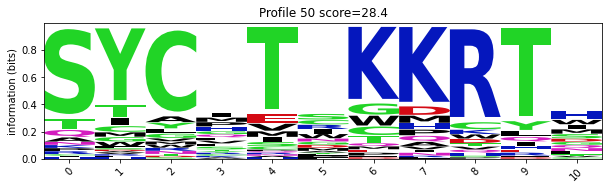

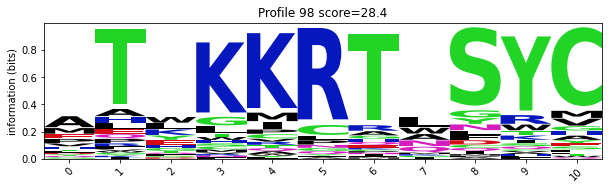

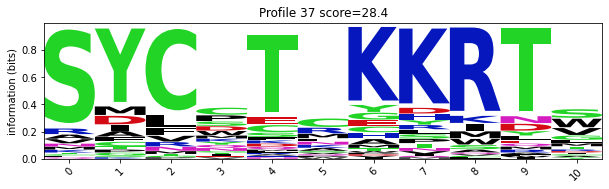

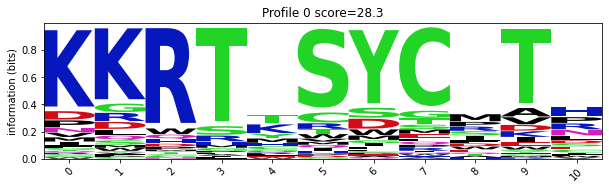

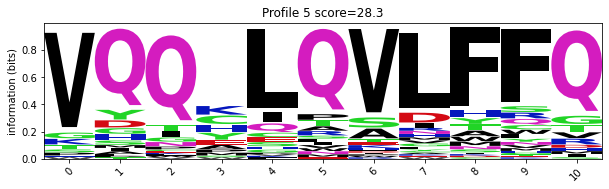

In [68]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

---

## Profile Score Distribution

In [69]:
R = specProModel.getR()
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-142.52104949951172 , 40.198710680007935


     P:     (k, alphSize, U) 
     X:     (batchsize, N, 6, T, alphSize) 
     Z:     (batchsize, N, 6, T-k+1, U)

In [70]:
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
assert k == R.shape[0]

#for pidx in range(R.shape[2]):
#    profile = R[:,:,pidx]
#    for seqidx in range(X.shape[1]):
#        for frame in range(X.shape[2]):
#            for i in range(0, X.shape[3]-k+1):
#                kmer = X[0,seqidx,frame,range(i,i+k),:]
#                assert kmer.shape == profile.shape, str(kmer.shape)+" != "+str(profile.shape)
#                score = np.math.floor(sum(np.array(kmer*profile).flatten()))
#                assert score in scoreBins, str(score)
#                scoreBins[score] += 1

for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        for s in np.array(Z[:,:,:,:,:]).flatten():
            score = np.math.floor(s)
            assert score in scoreBins, str(score)+" ("+str(s)+")"
            scoreBins[score] += 1

#S, R, Z = specProModel(X)
#for s in np.array(Z[:,:,:,:,:]).flatten():
#    score = np.math.floor(s)
#    assert score in scoreBins, str(score)+" ("+str(s)+")"
#    scoreBins[score] += 1

(array([19., 18., 18., 18., 18., 19., 18., 18., 18., 19.]),
 array([-143. , -124.8, -106.6,  -88.4,  -70.2,  -52. ,  -33.8,  -15.6,
           2.6,   20.8,   39. ]),
 <BarContainer object of 10 artists>)

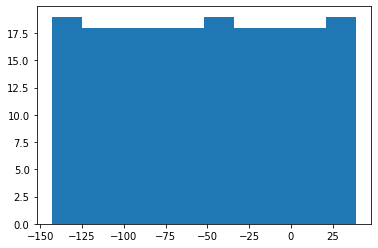

In [71]:
import matplotlib.pyplot as plt

plt.hist(scoreBins)

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [72]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [73]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [74]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [75]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [76]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")

In [83]:
P = specProModel.getP()
profiles = aaFromProfiles(P)

if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

Desired profiles:
Undesired profiles:
ATAEPERREPE
1 ATAEPER
  |||||||
5 ATAEPER
  Score=7



In [84]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

Desired profiles:
Undesired profiles:


ValueError: attempt to get argmax of an empty sequence